In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()

In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
#!ls /Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/development_mavenn2/Titeseq_16

In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-11 00:41:16.999807: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize at discrete monotonic GP map

In [9]:
gpmap.set_params()
theta_0_init = np.load('models/theta_0_DM.npy')
theta_lc_init = np.load('models/theta_lc_DM.npy')

init_params_dict = {'theta_0':theta_0_init, 'theta_lc':theta_lc_init}
#gpmap.set_params(**init_params_dict)

In [10]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [11]:
print(N_y[0:10])

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
dtype: int64


#### I obtained these values from Fig 3's script

In [12]:
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, np.log10(3e4)]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, np.log10(1e5)]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,np.log10(3e4)]])

aff_gates = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]

In [13]:
np.mean(np.array(aff_gates),axis=0)

array([[1.4775788 , 2.23034631],
       [2.23612365, 2.88471283],
       [2.88964045, 3.53840761],
       [3.54581157, 4.65141417]])

In [14]:
#bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds = np.mean(np.array(aff_gates),axis=0)
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,1.477579,2.230346
1,2.236124,2.884713
2,2.889640,3.538408
3,3.545812,4.651414


In [15]:
# mu_neg = np.log(200)
# mu_pos = np.log(9000)

#mu_neg = np.log(1.2)
mu_neg = np.log10(200)
#mu_neg = np.log(50)
mu_pos = np.log10(9000)

sigma_neg = 2.0
sigma_pos = 2.0

In [16]:
mu_neg, mu_pos

(2.3010299956639813, 3.9542425094393248)

In [17]:
np.log(20000), np.log(10)

(9.903487552536127, 2.302585092994046)

In [18]:
f_y_upper_bounds

array([2.23034631, 2.88471283, 3.53840761, 4.65141417])

In [19]:
#np.arange(10**(-13),10**(-6),10**(-12))
cs = [0,10**(-9.5),
     10**(-9),10**(-8.5),
     10**(-8),10**(-7.5),
     10**(-7),10**(-6.5),
     10**(-6),10**(-5.5),
     10**(-5),]

# cs = np.arange(0.1,1,0.085)
#cs = np.array(cs)*(10**6)

In [20]:
np.log10(cs)

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_18490/1526402024.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(cs)


array([-inf, -9.5, -9. , -8.5, -8. , -7.5, -7. , -6.5, -6. , -5.5, -5. ])

In [21]:
TiteSeq_mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
                                                         c=cs[mp_idx],
                                                         #c=np.log10(cs[mp_idx]),
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-10,)
           for mp_idx in range(len(y_cols)//4)
          ]

In [22]:
len(TiteSeq_mp_list)

11

In [23]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=TiteSeq_mp_list)

In [24]:
#model.model.summary()

In [25]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 19.9% for validation.
Time to set data: 0.376 sec.


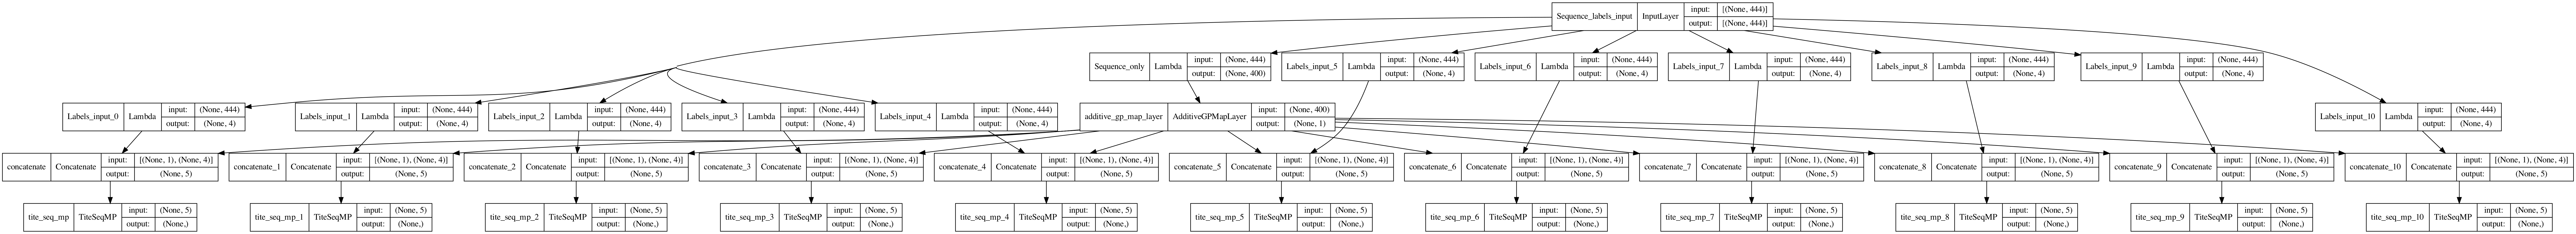

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='pngs/Titeseq_MP/titeseq16_TSMP.png')


In [27]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=3000,
          batch_size=400,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=200,
          linear_initialization=False)

Epoch 1/3000
22/22 [==============================] - 9s 74ms/step - loss: 15435141.0000 - tite_seq_mp_loss: 1125408.3750 - tite_seq_mp_1_loss: 1282102.2500 - tite_seq_mp_2_loss: 2190601.7500 - tite_seq_mp_3_loss: 1507305.2500 - tite_seq_mp_4_loss: 1091546.1250 - tite_seq_mp_5_loss: 577942.3125 - tite_seq_mp_6_loss: 706609.6875 - tite_seq_mp_7_loss: 2010938.2500 - tite_seq_mp_8_loss: 1295299.8750 - tite_seq_mp_9_loss: 1943345.6250 - tite_seq_mp_10_loss: 1704040.6250 - I_var: -0.1155 - val_loss: 8843565.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 931683.1250 - val_tite_seq_mp_2_loss: 1309901.3750 - val_tite_seq_mp_3_loss: 802613.3125 - val_tite_seq_mp_4_loss: 632378.9375 - val_tite_seq_mp_5_loss: 410733.8125 - val_tite_seq_mp_6_loss: 486266.4688 - val_tite_seq_mp_7_loss: 910412.6875 - val_tite_seq_mp_8_loss: 790082.4375 - val_tite_seq_mp_9_loss: 984006.0625 - val_tite_seq_mp_10_loss: 876217.0000 - val_I_var: -0.0998
Epoch 2/3000
22/22 [============================

Epoch 10/3000
22/22 [==============================] - 0s 7ms/step - loss: 15448105.0000 - tite_seq_mp_loss: 1125902.2500 - tite_seq_mp_1_loss: 1283171.0000 - tite_seq_mp_2_loss: 2192180.5000 - tite_seq_mp_3_loss: 1508283.1250 - tite_seq_mp_4_loss: 1092322.1250 - tite_seq_mp_5_loss: 578368.5625 - tite_seq_mp_6_loss: 707188.8750 - tite_seq_mp_7_loss: 2014513.2500 - tite_seq_mp_8_loss: 1296102.8750 - tite_seq_mp_9_loss: 1944328.7500 - tite_seq_mp_10_loss: 1705742.8750 - I_var: -0.1144 - val_loss: 8843565.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 931683.1250 - val_tite_seq_mp_2_loss: 1309901.3750 - val_tite_seq_mp_3_loss: 802613.3125 - val_tite_seq_mp_4_loss: 632378.9375 - val_tite_seq_mp_5_loss: 410733.8125 - val_tite_seq_mp_6_loss: 486266.4688 - val_tite_seq_mp_7_loss: 910412.6875 - val_tite_seq_mp_8_loss: 790082.4375 - val_tite_seq_mp_9_loss: 984006.0625 - val_tite_seq_mp_10_loss: 876217.0000 - val_I_var: -0.0998
Epoch 11/3000
22/22 [===========================

Epoch 19/3000
22/22 [==============================] - 0s 7ms/step - loss: 15449213.0000 - tite_seq_mp_loss: 1126057.1250 - tite_seq_mp_1_loss: 1283288.7500 - tite_seq_mp_2_loss: 2192266.5000 - tite_seq_mp_3_loss: 1508261.7500 - tite_seq_mp_4_loss: 1092366.1250 - tite_seq_mp_5_loss: 578469.5625 - tite_seq_mp_6_loss: 707275.0625 - tite_seq_mp_7_loss: 2014655.2500 - tite_seq_mp_8_loss: 1296240.1250 - tite_seq_mp_9_loss: 1944484.8750 - tite_seq_mp_10_loss: 1705850.6250 - I_var: -0.1131 - val_loss: 8843559.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 931683.1250 - val_tite_seq_mp_2_loss: 1309901.3750 - val_tite_seq_mp_3_loss: 802613.3125 - val_tite_seq_mp_4_loss: 632378.9375 - val_tite_seq_mp_5_loss: 410733.8125 - val_tite_seq_mp_6_loss: 486266.4062 - val_tite_seq_mp_7_loss: 910412.4375 - val_tite_seq_mp_8_loss: 790082.1250 - val_tite_seq_mp_9_loss: 984003.6875 - val_tite_seq_mp_10_loss: 876214.1250 - val_I_var: -0.0998
Epoch 20/3000
22/22 [===========================

Epoch 28/3000
22/22 [==============================] - 0s 7ms/step - loss: 15436615.0000 - tite_seq_mp_loss: 1126044.1250 - tite_seq_mp_1_loss: 1282951.0000 - tite_seq_mp_2_loss: 2192001.7500 - tite_seq_mp_3_loss: 1508100.5000 - tite_seq_mp_4_loss: 1092233.0000 - tite_seq_mp_5_loss: 578299.6250 - tite_seq_mp_6_loss: 706979.0000 - tite_seq_mp_7_loss: 2012454.7500 - tite_seq_mp_8_loss: 1294940.1250 - tite_seq_mp_9_loss: 1939897.8750 - tite_seq_mp_10_loss: 1702714.2500 - I_var: -0.1252 - val_loss: 8841813.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 931682.6875 - val_tite_seq_mp_2_loss: 1309899.2500 - val_tite_seq_mp_3_loss: 802607.7500 - val_tite_seq_mp_4_loss: 632367.1250 - val_tite_seq_mp_5_loss: 410717.3750 - val_tite_seq_mp_6_loss: 486201.6562 - val_tite_seq_mp_7_loss: 910067.7500 - val_tite_seq_mp_8_loss: 789759.0000 - val_tite_seq_mp_9_loss: 983263.8750 - val_tite_seq_mp_10_loss: 875976.3125 - val_I_var: -0.0994
Epoch 29/3000
22/22 [===========================

Epoch 37/3000
22/22 [==============================] - 0s 7ms/step - loss: 15429024.0000 - tite_seq_mp_loss: 1125634.3750 - tite_seq_mp_1_loss: 1282991.8750 - tite_seq_mp_2_loss: 2191502.0000 - tite_seq_mp_3_loss: 1507546.5000 - tite_seq_mp_4_loss: 1091095.5000 - tite_seq_mp_5_loss: 577557.9375 - tite_seq_mp_6_loss: 705704.0000 - tite_seq_mp_7_loss: 2010226.8750 - tite_seq_mp_8_loss: 1293620.8750 - tite_seq_mp_9_loss: 1940458.7500 - tite_seq_mp_10_loss: 1702683.6250 - I_var: -0.1183 - val_loss: 8839744.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 931667.0625 - val_tite_seq_mp_2_loss: 1309800.8750 - val_tite_seq_mp_3_loss: 802389.1250 - val_tite_seq_mp_4_loss: 632049.4375 - val_tite_seq_mp_5_loss: 410482.0000 - val_tite_seq_mp_6_loss: 485746.0938 - val_tite_seq_mp_7_loss: 909540.4375 - val_tite_seq_mp_8_loss: 789615.2500 - val_tite_seq_mp_9_loss: 983024.3750 - val_tite_seq_mp_10_loss: 876159.5625 - val_I_var: -0.0999
Epoch 38/3000
22/22 [===========================

Epoch 46/3000
22/22 [==============================] - 0s 7ms/step - loss: 15411423.0000 - tite_seq_mp_loss: 1125948.3750 - tite_seq_mp_1_loss: 1281317.0000 - tite_seq_mp_2_loss: 2186697.5000 - tite_seq_mp_3_loss: 1502042.3750 - tite_seq_mp_4_loss: 1088020.8750 - tite_seq_mp_5_loss: 576747.7500 - tite_seq_mp_6_loss: 705007.5000 - tite_seq_mp_7_loss: 2009288.6250 - tite_seq_mp_8_loss: 1293513.8750 - tite_seq_mp_9_loss: 1939964.7500 - tite_seq_mp_10_loss: 1702875.6250 - I_var: -0.1120 - val_loss: 8834645.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 931002.0000 - val_tite_seq_mp_2_loss: 1307864.3750 - val_tite_seq_mp_3_loss: 800941.3750 - val_tite_seq_mp_4_loss: 631377.5000 - val_tite_seq_mp_5_loss: 410314.6562 - val_tite_seq_mp_6_loss: 485473.9062 - val_tite_seq_mp_7_loss: 909628.2500 - val_tite_seq_mp_8_loss: 789687.6875 - val_tite_seq_mp_9_loss: 982868.1875 - val_tite_seq_mp_10_loss: 876217.8750 - val_I_var: -0.1000
Epoch 47/3000
22/22 [===========================

Epoch 55/3000
22/22 [==============================] - 0s 7ms/step - loss: 15395183.0000 - tite_seq_mp_loss: 1125697.2500 - tite_seq_mp_1_loss: 1278195.2500 - tite_seq_mp_2_loss: 2181857.0000 - tite_seq_mp_3_loss: 1499767.3750 - tite_seq_mp_4_loss: 1086776.8750 - tite_seq_mp_5_loss: 576581.3750 - tite_seq_mp_6_loss: 704402.1250 - tite_seq_mp_7_loss: 2008498.3750 - tite_seq_mp_8_loss: 1292754.8750 - tite_seq_mp_9_loss: 1938656.6250 - tite_seq_mp_10_loss: 1701996.5000 - I_var: -0.1161 - val_loss: 8831201.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 930036.8750 - val_tite_seq_mp_2_loss: 1306292.2500 - val_tite_seq_mp_3_loss: 800584.4375 - val_tite_seq_mp_4_loss: 631304.3750 - val_tite_seq_mp_5_loss: 410291.1250 - val_tite_seq_mp_6_loss: 485321.6562 - val_tite_seq_mp_7_loss: 909568.3125 - val_tite_seq_mp_8_loss: 789648.6250 - val_tite_seq_mp_9_loss: 982662.1250 - val_tite_seq_mp_10_loss: 876222.3750 - val_I_var: -0.1001
Epoch 56/3000
22/22 [===========================

Epoch 64/3000
22/22 [==============================] - 0s 8ms/step - loss: 15385091.0000 - tite_seq_mp_loss: 1125873.2500 - tite_seq_mp_1_loss: 1276097.6250 - tite_seq_mp_2_loss: 2178726.7500 - tite_seq_mp_3_loss: 1498102.5000 - tite_seq_mp_4_loss: 1085904.2500 - tite_seq_mp_5_loss: 576141.2500 - tite_seq_mp_6_loss: 704014.9375 - tite_seq_mp_7_loss: 2008080.1250 - tite_seq_mp_8_loss: 1292591.0000 - tite_seq_mp_9_loss: 1938084.1250 - tite_seq_mp_10_loss: 1701475.6250 - I_var: -0.1179 - val_loss: 8828362.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 929377.0000 - val_tite_seq_mp_2_loss: 1305206.3750 - val_tite_seq_mp_3_loss: 800260.5000 - val_tite_seq_mp_4_loss: 631154.6250 - val_tite_seq_mp_5_loss: 410233.2188 - val_tite_seq_mp_6_loss: 485145.5938 - val_tite_seq_mp_7_loss: 909473.3125 - val_tite_seq_mp_8_loss: 789594.3125 - val_tite_seq_mp_9_loss: 982421.8750 - val_tite_seq_mp_10_loss: 876224.6875 - val_I_var: -0.1001
Epoch 65/3000
22/22 [===========================

Epoch 73/3000
22/22 [==============================] - 0s 8ms/step - loss: 15370853.0000 - tite_seq_mp_loss: 1125431.7500 - tite_seq_mp_1_loss: 1273924.6250 - tite_seq_mp_2_loss: 2175312.0000 - tite_seq_mp_3_loss: 1496436.8750 - tite_seq_mp_4_loss: 1084842.5000 - tite_seq_mp_5_loss: 575741.8750 - tite_seq_mp_6_loss: 703059.7500 - tite_seq_mp_7_loss: 2006699.0000 - tite_seq_mp_8_loss: 1292022.1250 - tite_seq_mp_9_loss: 1936407.2500 - tite_seq_mp_10_loss: 1700974.7500 - I_var: -0.1184 - val_loss: 8825236.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 928735.0000 - val_tite_seq_mp_2_loss: 1304078.0000 - val_tite_seq_mp_3_loss: 799846.4375 - val_tite_seq_mp_4_loss: 630953.6875 - val_tite_seq_mp_5_loss: 410161.9062 - val_tite_seq_mp_6_loss: 484933.9375 - val_tite_seq_mp_7_loss: 909368.4375 - val_tite_seq_mp_8_loss: 789531.0625 - val_tite_seq_mp_9_loss: 982130.1250 - val_tite_seq_mp_10_loss: 876226.9375 - val_I_var: -0.1001
Epoch 74/3000
22/22 [===========================

Epoch 82/3000
22/22 [==============================] - 0s 8ms/step - loss: 15363382.0000 - tite_seq_mp_loss: 1125954.1250 - tite_seq_mp_1_loss: 1272708.7500 - tite_seq_mp_2_loss: 2172889.0000 - tite_seq_mp_3_loss: 1494535.5000 - tite_seq_mp_4_loss: 1083895.3750 - tite_seq_mp_5_loss: 575572.3125 - tite_seq_mp_6_loss: 702688.9375 - tite_seq_mp_7_loss: 2006521.0000 - tite_seq_mp_8_loss: 1291694.2500 - tite_seq_mp_9_loss: 1935911.7500 - tite_seq_mp_10_loss: 1701011.2500 - I_var: -0.1157 - val_loss: 8821719.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 928053.8750 - val_tite_seq_mp_2_loss: 1302843.3750 - val_tite_seq_mp_3_loss: 799339.8125 - val_tite_seq_mp_4_loss: 630706.5000 - val_tite_seq_mp_5_loss: 410077.3750 - val_tite_seq_mp_6_loss: 484692.0938 - val_tite_seq_mp_7_loss: 909252.4375 - val_tite_seq_mp_8_loss: 789461.1250 - val_tite_seq_mp_9_loss: 981794.5625 - val_tite_seq_mp_10_loss: 876229.0000 - val_I_var: -0.1002
Epoch 83/3000
22/22 [===========================

Epoch 91/3000
22/22 [==============================] - 0s 7ms/step - loss: 15336972.0000 - tite_seq_mp_loss: 1125416.5000 - tite_seq_mp_1_loss: 1269487.5000 - tite_seq_mp_2_loss: 2167128.5000 - tite_seq_mp_3_loss: 1491259.3750 - tite_seq_mp_4_loss: 1081525.3750 - tite_seq_mp_5_loss: 574723.1250 - tite_seq_mp_6_loss: 701240.5625 - tite_seq_mp_7_loss: 2002498.5000 - tite_seq_mp_8_loss: 1290185.5000 - tite_seq_mp_9_loss: 1934027.1250 - tite_seq_mp_10_loss: 1699479.6250 - I_var: -0.1131 - val_loss: 8817620.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 927275.1875 - val_tite_seq_mp_2_loss: 1301396.8750 - val_tite_seq_mp_3_loss: 798749.2500 - val_tite_seq_mp_4_loss: 630412.0000 - val_tite_seq_mp_5_loss: 409977.3750 - val_tite_seq_mp_6_loss: 484408.6875 - val_tite_seq_mp_7_loss: 909120.8750 - val_tite_seq_mp_8_loss: 789380.1875 - val_tite_seq_mp_9_loss: 981399.5000 - val_tite_seq_mp_10_loss: 876230.8125 - val_I_var: -0.1002
Epoch 92/3000
22/22 [===========================

Epoch 100/3000
22/22 [==============================] - 0s 8ms/step - loss: 15331720.0000 - tite_seq_mp_loss: 1125859.5000 - tite_seq_mp_1_loss: 1267816.1250 - tite_seq_mp_2_loss: 2164228.7500 - tite_seq_mp_3_loss: 1489841.1250 - tite_seq_mp_4_loss: 1080858.5000 - tite_seq_mp_5_loss: 574870.2500 - tite_seq_mp_6_loss: 701035.5000 - tite_seq_mp_7_loss: 2004866.7500 - tite_seq_mp_8_loss: 1290508.0000 - tite_seq_mp_9_loss: 1932334.1250 - tite_seq_mp_10_loss: 1699501.2500 - I_var: -0.1098 - val_loss: 8812785.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 926364.0000 - val_tite_seq_mp_2_loss: 1299694.5000 - val_tite_seq_mp_3_loss: 798047.8750 - val_tite_seq_mp_4_loss: 630061.8125 - val_tite_seq_mp_5_loss: 409860.8438 - val_tite_seq_mp_6_loss: 484070.5312 - val_tite_seq_mp_7_loss: 908973.7500 - val_tite_seq_mp_8_loss: 789286.3750 - val_tite_seq_mp_9_loss: 980923.4375 - val_tite_seq_mp_10_loss: 876232.0625 - val_I_var: -0.1003
Epoch 101/3000
22/22 [=========================

Epoch 109/3000
22/22 [==============================] - 0s 7ms/step - loss: 15310111.0000 - tite_seq_mp_loss: 1126008.3750 - tite_seq_mp_1_loss: 1264848.3750 - tite_seq_mp_2_loss: 2158720.0000 - tite_seq_mp_3_loss: 1486877.6250 - tite_seq_mp_4_loss: 1079042.6250 - tite_seq_mp_5_loss: 574407.5000 - tite_seq_mp_6_loss: 699832.9375 - tite_seq_mp_7_loss: 2002831.6250 - tite_seq_mp_8_loss: 1289765.1250 - tite_seq_mp_9_loss: 1929075.5000 - tite_seq_mp_10_loss: 1698701.0000 - I_var: -0.1244 - val_loss: 8807252.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 925349.0625 - val_tite_seq_mp_2_loss: 1297750.1250 - val_tite_seq_mp_3_loss: 797237.2500 - val_tite_seq_mp_4_loss: 629650.5625 - val_tite_seq_mp_5_loss: 409724.6250 - val_tite_seq_mp_6_loss: 483678.1562 - val_tite_seq_mp_7_loss: 908810.1250 - val_tite_seq_mp_8_loss: 789179.6875 - val_tite_seq_mp_9_loss: 980371.3750 - val_tite_seq_mp_10_loss: 876231.3125 - val_I_var: -0.1003
Epoch 110/3000
22/22 [=========================

Epoch 118/3000
22/22 [==============================] - 0s 7ms/step - loss: 15290295.0000 - tite_seq_mp_loss: 1126002.1250 - tite_seq_mp_1_loss: 1261324.2500 - tite_seq_mp_2_loss: 2152736.2500 - tite_seq_mp_3_loss: 1483760.7500 - tite_seq_mp_4_loss: 1076907.0000 - tite_seq_mp_5_loss: 573836.3750 - tite_seq_mp_6_loss: 698646.7500 - tite_seq_mp_7_loss: 2002044.2500 - tite_seq_mp_8_loss: 1289047.8750 - tite_seq_mp_9_loss: 1927845.8750 - tite_seq_mp_10_loss: 1698142.8750 - I_var: -0.1162 - val_loss: 8800593.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 924062.0625 - val_tite_seq_mp_2_loss: 1295370.0000 - val_tite_seq_mp_3_loss: 796314.3125 - val_tite_seq_mp_4_loss: 629189.3125 - val_tite_seq_mp_5_loss: 409573.3125 - val_tite_seq_mp_6_loss: 483207.4062 - val_tite_seq_mp_7_loss: 908622.3125 - val_tite_seq_mp_8_loss: 789054.0000 - val_tite_seq_mp_9_loss: 979698.7500 - val_tite_seq_mp_10_loss: 876231.9375 - val_I_var: -0.1004
Epoch 119/3000
22/22 [=========================

Epoch 127/3000
22/22 [==============================] - 0s 8ms/step - loss: 15265384.0000 - tite_seq_mp_loss: 1125768.8750 - tite_seq_mp_1_loss: 1257393.6250 - tite_seq_mp_2_loss: 2145723.7500 - tite_seq_mp_3_loss: 1479716.5000 - tite_seq_mp_4_loss: 1074569.6250 - tite_seq_mp_5_loss: 573208.6250 - tite_seq_mp_6_loss: 697253.1875 - tite_seq_mp_7_loss: 2001462.8750 - tite_seq_mp_8_loss: 1288118.8750 - tite_seq_mp_9_loss: 1924743.2500 - tite_seq_mp_10_loss: 1697423.2500 - I_var: -0.1110 - val_loss: 8793041.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 922648.9375 - val_tite_seq_mp_2_loss: 1292667.1250 - val_tite_seq_mp_3_loss: 795254.1875 - val_tite_seq_mp_4_loss: 628647.9375 - val_tite_seq_mp_5_loss: 409394.8438 - val_tite_seq_mp_6_loss: 482672.2812 - val_tite_seq_mp_7_loss: 908406.8125 - val_tite_seq_mp_8_loss: 788910.4375 - val_tite_seq_mp_9_loss: 978939.1875 - val_tite_seq_mp_10_loss: 876229.6250 - val_I_var: -0.1004
Epoch 128/3000
22/22 [=========================

Epoch 136/3000
22/22 [==============================] - 0s 8ms/step - loss: 15237437.0000 - tite_seq_mp_loss: 1125948.8750 - tite_seq_mp_1_loss: 1253011.2500 - tite_seq_mp_2_loss: 2137795.7500 - tite_seq_mp_3_loss: 1475590.0000 - tite_seq_mp_4_loss: 1072124.7500 - tite_seq_mp_5_loss: 572544.3125 - tite_seq_mp_6_loss: 695571.8125 - tite_seq_mp_7_loss: 1999986.0000 - tite_seq_mp_8_loss: 1287256.1250 - tite_seq_mp_9_loss: 1921277.3750 - tite_seq_mp_10_loss: 1696330.2500 - I_var: -0.1159 - val_loss: 8784434.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 921048.9375 - val_tite_seq_mp_2_loss: 1289609.5000 - val_tite_seq_mp_3_loss: 794033.5625 - val_tite_seq_mp_4_loss: 628036.3750 - val_tite_seq_mp_5_loss: 409197.7812 - val_tite_seq_mp_6_loss: 482055.2188 - val_tite_seq_mp_7_loss: 908173.1875 - val_tite_seq_mp_8_loss: 788746.5625 - val_tite_seq_mp_9_loss: 978038.5000 - val_tite_seq_mp_10_loss: 876225.0625 - val_I_var: -0.1005
Epoch 137/3000
22/22 [=========================

Epoch 145/3000
22/22 [==============================] - 0s 8ms/step - loss: 15204491.0000 - tite_seq_mp_loss: 1125900.0000 - tite_seq_mp_1_loss: 1247685.5000 - tite_seq_mp_2_loss: 2128552.2500 - tite_seq_mp_3_loss: 1470741.7500 - tite_seq_mp_4_loss: 1069187.6250 - tite_seq_mp_5_loss: 571845.4375 - tite_seq_mp_6_loss: 693630.8125 - tite_seq_mp_7_loss: 1998099.7500 - tite_seq_mp_8_loss: 1286091.1250 - tite_seq_mp_9_loss: 1917257.5000 - tite_seq_mp_10_loss: 1695500.0000 - I_var: -0.1038 - val_loss: 8774471.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 919151.0625 - val_tite_seq_mp_2_loss: 1286059.8750 - val_tite_seq_mp_3_loss: 792626.7500 - val_tite_seq_mp_4_loss: 627342.8750 - val_tite_seq_mp_5_loss: 408977.5625 - val_tite_seq_mp_6_loss: 481357.1875 - val_tite_seq_mp_7_loss: 907906.9375 - val_tite_seq_mp_8_loss: 788559.5000 - val_tite_seq_mp_9_loss: 976998.3750 - val_tite_seq_mp_10_loss: 876220.6875 - val_I_var: -0.1006
Epoch 146/3000
22/22 [=========================

Epoch 154/3000
22/22 [==============================] - 0s 8ms/step - loss: 15167826.0000 - tite_seq_mp_loss: 1125902.2500 - tite_seq_mp_1_loss: 1242253.1250 - tite_seq_mp_2_loss: 2118290.2500 - tite_seq_mp_3_loss: 1465223.1250 - tite_seq_mp_4_loss: 1065684.0000 - tite_seq_mp_5_loss: 570940.4375 - tite_seq_mp_6_loss: 691563.9375 - tite_seq_mp_7_loss: 1996388.7500 - tite_seq_mp_8_loss: 1284834.5000 - tite_seq_mp_9_loss: 1912550.5000 - tite_seq_mp_10_loss: 1694194.8750 - I_var: -0.1143 - val_loss: 8763610.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 917173.6875 - val_tite_seq_mp_2_loss: 1282257.3750 - val_tite_seq_mp_3_loss: 791048.3125 - val_tite_seq_mp_4_loss: 626559.6250 - val_tite_seq_mp_5_loss: 408730.0938 - val_tite_seq_mp_6_loss: 480584.2500 - val_tite_seq_mp_7_loss: 907617.5625 - val_tite_seq_mp_8_loss: 788345.3125 - val_tite_seq_mp_9_loss: 975815.6250 - val_tite_seq_mp_10_loss: 876208.6250 - val_I_var: -0.1006
Epoch 155/3000
22/22 [=========================

Epoch 163/3000
22/22 [==============================] - 0s 8ms/step - loss: 15125524.0000 - tite_seq_mp_loss: 1125770.5000 - tite_seq_mp_1_loss: 1235719.0000 - tite_seq_mp_2_loss: 2106957.0000 - tite_seq_mp_3_loss: 1458760.5000 - tite_seq_mp_4_loss: 1061817.7500 - tite_seq_mp_5_loss: 569951.4375 - tite_seq_mp_6_loss: 689022.3750 - tite_seq_mp_7_loss: 1994624.2500 - tite_seq_mp_8_loss: 1283095.5000 - tite_seq_mp_9_loss: 1907105.7500 - tite_seq_mp_10_loss: 1692699.7500 - I_var: -0.1184 - val_loss: 8751427.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 914983.6875 - val_tite_seq_mp_2_loss: 1278033.6250 - val_tite_seq_mp_3_loss: 789251.8750 - val_tite_seq_mp_4_loss: 625667.8125 - val_tite_seq_mp_5_loss: 408447.7188 - val_tite_seq_mp_6_loss: 479744.8750 - val_tite_seq_mp_7_loss: 907286.1875 - val_tite_seq_mp_8_loss: 788098.4375 - val_tite_seq_mp_9_loss: 974452.6875 - val_tite_seq_mp_10_loss: 876190.8750 - val_I_var: -0.1007
Epoch 164/3000
22/22 [=========================

Epoch 172/3000
22/22 [==============================] - 0s 7ms/step - loss: 15082998.0000 - tite_seq_mp_loss: 1125959.5000 - tite_seq_mp_1_loss: 1229299.3750 - tite_seq_mp_2_loss: 2095043.7500 - tite_seq_mp_3_loss: 1452008.2500 - tite_seq_mp_4_loss: 1057863.8750 - tite_seq_mp_5_loss: 568988.6875 - tite_seq_mp_6_loss: 686778.0625 - tite_seq_mp_7_loss: 1992498.6250 - tite_seq_mp_8_loss: 1281779.7500 - tite_seq_mp_9_loss: 1901362.5000 - tite_seq_mp_10_loss: 1691415.0000 - I_var: -0.1138 - val_loss: 8737848.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 912569.3125 - val_tite_seq_mp_2_loss: 1273342.3750 - val_tite_seq_mp_3_loss: 787245.5625 - val_tite_seq_mp_4_loss: 624664.6250 - val_tite_seq_mp_5_loss: 408131.0625 - val_tite_seq_mp_6_loss: 478816.9688 - val_tite_seq_mp_7_loss: 906915.4375 - val_tite_seq_mp_8_loss: 787808.8750 - val_tite_seq_mp_9_loss: 972915.6250 - val_tite_seq_mp_10_loss: 876166.8750 - val_I_var: -0.1007
Epoch 173/3000
22/22 [=========================

Epoch 181/3000
22/22 [==============================] - 0s 7ms/step - loss: 15033460.0000 - tite_seq_mp_loss: 1125766.5000 - tite_seq_mp_1_loss: 1222115.8750 - tite_seq_mp_2_loss: 2081539.2500 - tite_seq_mp_3_loss: 1444488.5000 - tite_seq_mp_4_loss: 1053015.8750 - tite_seq_mp_5_loss: 567895.1875 - tite_seq_mp_6_loss: 684069.1250 - tite_seq_mp_7_loss: 1990364.2500 - tite_seq_mp_8_loss: 1279703.7500 - tite_seq_mp_9_loss: 1894737.1250 - tite_seq_mp_10_loss: 1689764.5000 - I_var: -0.1142 - val_loss: 8723159.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 910019.6875 - val_tite_seq_mp_2_loss: 1268378.5000 - val_tite_seq_mp_3_loss: 784982.6250 - val_tite_seq_mp_4_loss: 623547.8125 - val_tite_seq_mp_5_loss: 407780.7812 - val_tite_seq_mp_6_loss: 477834.8750 - val_tite_seq_mp_7_loss: 906512.1250 - val_tite_seq_mp_8_loss: 787483.5000 - val_tite_seq_mp_9_loss: 971217.6250 - val_tite_seq_mp_10_loss: 876131.0625 - val_I_var: -0.1008
Epoch 182/3000
22/22 [=========================

Epoch 190/3000
22/22 [==============================] - 0s 7ms/step - loss: 14981322.0000 - tite_seq_mp_loss: 1125889.3750 - tite_seq_mp_1_loss: 1214476.7500 - tite_seq_mp_2_loss: 2067918.7500 - tite_seq_mp_3_loss: 1436063.1250 - tite_seq_mp_4_loss: 1048073.1250 - tite_seq_mp_5_loss: 566614.9375 - tite_seq_mp_6_loss: 681194.0625 - tite_seq_mp_7_loss: 1987769.8750 - tite_seq_mp_8_loss: 1277890.8750 - tite_seq_mp_9_loss: 1887446.2500 - tite_seq_mp_10_loss: 1687987.2500 - I_var: -0.0969 - val_loss: 8707384.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 907347.8750 - val_tite_seq_mp_2_loss: 1263115.2500 - val_tite_seq_mp_3_loss: 782531.6875 - val_tite_seq_mp_4_loss: 622321.5625 - val_tite_seq_mp_5_loss: 407391.0000 - val_tite_seq_mp_6_loss: 476801.8750 - val_tite_seq_mp_7_loss: 906062.6875 - val_tite_seq_mp_8_loss: 787115.1875 - val_tite_seq_mp_9_loss: 969343.8125 - val_tite_seq_mp_10_loss: 876083.6875 - val_I_var: -0.1008
Epoch 191/3000
22/22 [=========================

Epoch 199/3000
22/22 [==============================] - 0s 7ms/step - loss: 14921248.0000 - tite_seq_mp_loss: 1125872.3750 - tite_seq_mp_1_loss: 1206306.8750 - tite_seq_mp_2_loss: 2052584.8750 - tite_seq_mp_3_loss: 1426538.0000 - tite_seq_mp_4_loss: 1042365.5625 - tite_seq_mp_5_loss: 564942.6250 - tite_seq_mp_6_loss: 677865.6875 - tite_seq_mp_7_loss: 1984510.1250 - tite_seq_mp_8_loss: 1275522.7500 - tite_seq_mp_9_loss: 1878852.5000 - tite_seq_mp_10_loss: 1685885.7500 - I_var: -0.1027 - val_loss: 8690613.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 904772.6250 - val_tite_seq_mp_2_loss: 1257815.7500 - val_tite_seq_mp_3_loss: 779708.4375 - val_tite_seq_mp_4_loss: 620867.6250 - val_tite_seq_mp_5_loss: 406927.6875 - val_tite_seq_mp_6_loss: 475698.1562 - val_tite_seq_mp_7_loss: 905556.6250 - val_tite_seq_mp_8_loss: 786681.8125 - val_tite_seq_mp_9_loss: 967317.3125 - val_tite_seq_mp_10_loss: 875995.5000 - val_I_var: -0.1007
Epoch 200/3000
22/22 [=========================

Epoch 208/3000
22/22 [==============================] - 0s 7ms/step - loss: 14861505.0000 - tite_seq_mp_loss: 1125705.2500 - tite_seq_mp_1_loss: 1198531.5000 - tite_seq_mp_2_loss: 2038006.2500 - tite_seq_mp_3_loss: 1416928.8750 - tite_seq_mp_4_loss: 1036242.6875 - tite_seq_mp_5_loss: 563418.3125 - tite_seq_mp_6_loss: 674756.6250 - tite_seq_mp_7_loss: 1981401.6250 - tite_seq_mp_8_loss: 1273065.7500 - tite_seq_mp_9_loss: 1869836.1250 - tite_seq_mp_10_loss: 1683611.3750 - I_var: -0.0983 - val_loss: 8673065.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 901931.1250 - val_tite_seq_mp_2_loss: 1252208.2500 - val_tite_seq_mp_3_loss: 776848.8125 - val_tite_seq_mp_4_loss: 619428.5625 - val_tite_seq_mp_5_loss: 406459.4375 - val_tite_seq_mp_6_loss: 474615.7500 - val_tite_seq_mp_7_loss: 905015.0000 - val_tite_seq_mp_8_loss: 786229.3750 - val_tite_seq_mp_9_loss: 965132.4375 - val_tite_seq_mp_10_loss: 875925.6875 - val_I_var: -0.1007
Epoch 209/3000
22/22 [=========================

Epoch 217/3000
22/22 [==============================] - 0s 7ms/step - loss: 14798724.0000 - tite_seq_mp_loss: 1125923.6250 - tite_seq_mp_1_loss: 1190549.8750 - tite_seq_mp_2_loss: 2023396.6250 - tite_seq_mp_3_loss: 1406436.2500 - tite_seq_mp_4_loss: 1029942.2500 - tite_seq_mp_5_loss: 561738.7500 - tite_seq_mp_6_loss: 671457.7500 - tite_seq_mp_7_loss: 1978072.6250 - tite_seq_mp_8_loss: 1270192.7500 - tite_seq_mp_9_loss: 1860167.7500 - tite_seq_mp_10_loss: 1680846.2500 - I_var: -0.1065 - val_loss: 8654559.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 899101.0625 - val_tite_seq_mp_2_loss: 1246492.7500 - val_tite_seq_mp_3_loss: 773727.5000 - val_tite_seq_mp_4_loss: 617812.6875 - val_tite_seq_mp_5_loss: 405920.5312 - val_tite_seq_mp_6_loss: 473494.8438 - val_tite_seq_mp_7_loss: 904394.0625 - val_tite_seq_mp_8_loss: 785706.7500 - val_tite_seq_mp_9_loss: 962800.4375 - val_tite_seq_mp_10_loss: 875837.0625 - val_I_var: -0.1007
Epoch 218/3000
22/22 [=========================

Epoch 226/3000
22/22 [==============================] - 0s 7ms/step - loss: 14732439.0000 - tite_seq_mp_loss: 1125958.2500 - tite_seq_mp_1_loss: 1182244.7500 - tite_seq_mp_2_loss: 2008223.3750 - tite_seq_mp_3_loss: 1395124.1250 - tite_seq_mp_4_loss: 1022812.3750 - tite_seq_mp_5_loss: 559907.0625 - tite_seq_mp_6_loss: 668275.1875 - tite_seq_mp_7_loss: 1974479.1250 - tite_seq_mp_8_loss: 1267082.8750 - tite_seq_mp_9_loss: 1850130.5000 - tite_seq_mp_10_loss: 1678197.0000 - I_var: -0.1104 - val_loss: 8635645.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 896412.1875 - val_tite_seq_mp_2_loss: 1240989.3750 - val_tite_seq_mp_3_loss: 770323.1875 - val_tite_seq_mp_4_loss: 616033.6250 - val_tite_seq_mp_5_loss: 405317.1875 - val_tite_seq_mp_6_loss: 472345.2500 - val_tite_seq_mp_7_loss: 903713.1875 - val_tite_seq_mp_8_loss: 785120.8125 - val_tite_seq_mp_9_loss: 960397.9375 - val_tite_seq_mp_10_loss: 875722.2500 - val_I_var: -0.1006
Epoch 227/3000
22/22 [=========================

Epoch 235/3000
22/22 [==============================] - 0s 8ms/step - loss: 14665038.0000 - tite_seq_mp_loss: 1126026.1250 - tite_seq_mp_1_loss: 1174433.8750 - tite_seq_mp_2_loss: 1993736.8750 - tite_seq_mp_3_loss: 1383684.2500 - tite_seq_mp_4_loss: 1015736.6250 - tite_seq_mp_5_loss: 557906.5625 - tite_seq_mp_6_loss: 665057.1250 - tite_seq_mp_7_loss: 1969754.0000 - tite_seq_mp_8_loss: 1263874.2500 - tite_seq_mp_9_loss: 1839558.1250 - tite_seq_mp_10_loss: 1675270.0000 - I_var: -0.0989 - val_loss: 8616612.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 893700.9375 - val_tite_seq_mp_2_loss: 1235550.5000 - val_tite_seq_mp_3_loss: 766855.4375 - val_tite_seq_mp_4_loss: 614227.5000 - val_tite_seq_mp_5_loss: 404684.9688 - val_tite_seq_mp_6_loss: 471243.8750 - val_tite_seq_mp_7_loss: 902968.4375 - val_tite_seq_mp_8_loss: 784500.3125 - val_tite_seq_mp_9_loss: 957988.0000 - val_tite_seq_mp_10_loss: 875621.1250 - val_I_var: -0.1006
Epoch 236/3000
22/22 [=========================

Epoch 244/3000
22/22 [==============================] - 0s 7ms/step - loss: 14594879.0000 - tite_seq_mp_loss: 1125855.1250 - tite_seq_mp_1_loss: 1166454.3750 - tite_seq_mp_2_loss: 1979381.0000 - tite_seq_mp_3_loss: 1371481.0000 - tite_seq_mp_4_loss: 1007985.6250 - tite_seq_mp_5_loss: 555842.8750 - tite_seq_mp_6_loss: 661803.5000 - tite_seq_mp_7_loss: 1965685.3750 - tite_seq_mp_8_loss: 1260016.8750 - tite_seq_mp_9_loss: 1828546.2500 - tite_seq_mp_10_loss: 1671826.1250 - I_var: -0.0991 - val_loss: 8597270.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 891062.0625 - val_tite_seq_mp_2_loss: 1230259.6250 - val_tite_seq_mp_3_loss: 763228.7500 - val_tite_seq_mp_4_loss: 612322.3125 - val_tite_seq_mp_5_loss: 403997.4062 - val_tite_seq_mp_6_loss: 470134.5000 - val_tite_seq_mp_7_loss: 902137.6875 - val_tite_seq_mp_8_loss: 783807.5625 - val_tite_seq_mp_9_loss: 955531.3125 - val_tite_seq_mp_10_loss: 875518.8125 - val_I_var: -0.1006
Epoch 245/3000
22/22 [=========================

Epoch 253/3000
22/22 [==============================] - 0s 7ms/step - loss: 14524868.0000 - tite_seq_mp_loss: 1125924.8750 - tite_seq_mp_1_loss: 1159253.5000 - tite_seq_mp_2_loss: 1966166.5000 - tite_seq_mp_3_loss: 1359232.3750 - tite_seq_mp_4_loss: 1000251.1875 - tite_seq_mp_5_loss: 553499.7500 - tite_seq_mp_6_loss: 658367.4375 - tite_seq_mp_7_loss: 1960748.8750 - tite_seq_mp_8_loss: 1256221.6250 - tite_seq_mp_9_loss: 1817086.8750 - tite_seq_mp_10_loss: 1668113.5000 - I_var: -0.1076 - val_loss: 8578298.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 888644.5625 - val_tite_seq_mp_2_loss: 1225329.2500 - val_tite_seq_mp_3_loss: 759550.8750 - val_tite_seq_mp_4_loss: 610346.9375 - val_tite_seq_mp_5_loss: 403252.3750 - val_tite_seq_mp_6_loss: 469050.9062 - val_tite_seq_mp_7_loss: 901218.3125 - val_tite_seq_mp_8_loss: 783052.0000 - val_tite_seq_mp_9_loss: 953177.7500 - val_tite_seq_mp_10_loss: 875404.5625 - val_I_var: -0.1005
Epoch 254/3000
22/22 [=========================

Epoch 262/3000
22/22 [==============================] - 0s 8ms/step - loss: 14452794.0000 - tite_seq_mp_loss: 1125471.8750 - tite_seq_mp_1_loss: 1151654.5000 - tite_seq_mp_2_loss: 1952713.1250 - tite_seq_mp_3_loss: 1346476.2500 - tite_seq_mp_4_loss: 991936.1875 - tite_seq_mp_5_loss: 551242.1250 - tite_seq_mp_6_loss: 655371.0000 - tite_seq_mp_7_loss: 1955517.2500 - tite_seq_mp_8_loss: 1251657.8750 - tite_seq_mp_9_loss: 1806075.8750 - tite_seq_mp_10_loss: 1664678.1250 - I_var: -0.0949 - val_loss: 8559287.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 886308.2500 - val_tite_seq_mp_2_loss: 1220579.2500 - val_tite_seq_mp_3_loss: 755829.7500 - val_tite_seq_mp_4_loss: 608325.8125 - val_tite_seq_mp_5_loss: 402465.0312 - val_tite_seq_mp_6_loss: 467965.7500 - val_tite_seq_mp_7_loss: 900202.3750 - val_tite_seq_mp_8_loss: 782210.0625 - val_tite_seq_mp_9_loss: 950833.5000 - val_tite_seq_mp_10_loss: 875296.7500 - val_I_var: -0.1005
Epoch 263/3000
22/22 [==========================

Epoch 271/3000
22/22 [==============================] - 0s 8ms/step - loss: 14385064.0000 - tite_seq_mp_loss: 1125918.1250 - tite_seq_mp_1_loss: 1145230.1250 - tite_seq_mp_2_loss: 1941089.0000 - tite_seq_mp_3_loss: 1334137.2500 - tite_seq_mp_4_loss: 984189.2500 - tite_seq_mp_5_loss: 548828.2500 - tite_seq_mp_6_loss: 652265.4375 - tite_seq_mp_7_loss: 1949854.5000 - tite_seq_mp_8_loss: 1247496.3750 - tite_seq_mp_9_loss: 1795264.6250 - tite_seq_mp_10_loss: 1660788.8750 - I_var: -0.0867 - val_loss: 8540460.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 884181.3750 - val_tite_seq_mp_2_loss: 1216266.7500 - val_tite_seq_mp_3_loss: 751979.3125 - val_tite_seq_mp_4_loss: 606209.1250 - val_tite_seq_mp_5_loss: 401610.0938 - val_tite_seq_mp_6_loss: 466864.9062 - val_tite_seq_mp_7_loss: 899064.6875 - val_tite_seq_mp_8_loss: 781275.0000 - val_tite_seq_mp_9_loss: 948570.8750 - val_tite_seq_mp_10_loss: 875166.0625 - val_I_var: -0.1005
Epoch 272/3000
22/22 [==========================

Epoch 280/3000
22/22 [==============================] - 0s 7ms/step - loss: 14313206.0000 - tite_seq_mp_loss: 1125695.5000 - tite_seq_mp_1_loss: 1138962.7500 - tite_seq_mp_2_loss: 1929866.0000 - tite_seq_mp_3_loss: 1321185.5000 - tite_seq_mp_4_loss: 975788.3125 - tite_seq_mp_5_loss: 546222.5625 - tite_seq_mp_6_loss: 649002.6250 - tite_seq_mp_7_loss: 1943531.8750 - tite_seq_mp_8_loss: 1242484.1250 - tite_seq_mp_9_loss: 1784170.7500 - tite_seq_mp_10_loss: 1656293.8750 - I_var: -0.0846 - val_loss: 8522690.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 882139.8125 - val_tite_seq_mp_2_loss: 1212254.8750 - val_tite_seq_mp_3_loss: 748335.6875 - val_tite_seq_mp_4_loss: 604223.1875 - val_tite_seq_mp_5_loss: 400785.8750 - val_tite_seq_mp_6_loss: 465868.8750 - val_tite_seq_mp_7_loss: 897889.3125 - val_tite_seq_mp_8_loss: 780315.6250 - val_tite_seq_mp_9_loss: 946543.3750 - val_tite_seq_mp_10_loss: 875062.0000 - val_I_var: -0.1005
Epoch 281/3000
22/22 [==========================

Epoch 289/3000
22/22 [==============================] - 0s 7ms/step - loss: 14244195.0000 - tite_seq_mp_loss: 1125863.0000 - tite_seq_mp_1_loss: 1133147.1250 - tite_seq_mp_2_loss: 1919740.5000 - tite_seq_mp_3_loss: 1309224.7500 - tite_seq_mp_4_loss: 967539.3750 - tite_seq_mp_5_loss: 543588.2500 - tite_seq_mp_6_loss: 646221.0625 - tite_seq_mp_7_loss: 1936970.6250 - tite_seq_mp_8_loss: 1237356.3750 - tite_seq_mp_9_loss: 1773152.1250 - tite_seq_mp_10_loss: 1651388.2500 - I_var: -0.0991 - val_loss: 8504340.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 880375.8750 - val_tite_seq_mp_2_loss: 1208612.1250 - val_tite_seq_mp_3_loss: 744513.0000 - val_tite_seq_mp_4_loss: 602006.6250 - val_tite_seq_mp_5_loss: 399826.6875 - val_tite_seq_mp_6_loss: 464752.1250 - val_tite_seq_mp_7_loss: 896471.5625 - val_tite_seq_mp_8_loss: 779149.9375 - val_tite_seq_mp_9_loss: 944471.3125 - val_tite_seq_mp_10_loss: 874890.2500 - val_I_var: -0.1005
Epoch 290/3000
22/22 [==========================

Epoch 298/3000
22/22 [==============================] - 0s 8ms/step - loss: 14175524.0000 - tite_seq_mp_loss: 1126000.8750 - tite_seq_mp_1_loss: 1127767.1250 - tite_seq_mp_2_loss: 1910480.6250 - tite_seq_mp_3_loss: 1296722.3750 - tite_seq_mp_4_loss: 959243.7500 - tite_seq_mp_5_loss: 540943.0000 - tite_seq_mp_6_loss: 643379.6250 - tite_seq_mp_7_loss: 1929710.5000 - tite_seq_mp_8_loss: 1231847.0000 - tite_seq_mp_9_loss: 1762967.5000 - tite_seq_mp_10_loss: 1646460.6250 - I_var: -0.0936 - val_loss: 8486768.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 878794.2500 - val_tite_seq_mp_2_loss: 1205376.0000 - val_tite_seq_mp_3_loss: 740844.5625 - val_tite_seq_mp_4_loss: 599852.2500 - val_tite_seq_mp_5_loss: 398865.3750 - val_tite_seq_mp_6_loss: 463663.5000 - val_tite_seq_mp_7_loss: 894951.5000 - val_tite_seq_mp_8_loss: 777905.3750 - val_tite_seq_mp_9_loss: 942549.5625 - val_tite_seq_mp_10_loss: 874695.8125 - val_I_var: -0.1004
Epoch 299/3000
22/22 [==========================

Epoch 307/3000
22/22 [==============================] - 0s 7ms/step - loss: 14105338.0000 - tite_seq_mp_loss: 1125851.5000 - tite_seq_mp_1_loss: 1122798.3750 - tite_seq_mp_2_loss: 1902030.0000 - tite_seq_mp_3_loss: 1284815.3750 - tite_seq_mp_4_loss: 950922.6875 - tite_seq_mp_5_loss: 538078.5000 - tite_seq_mp_6_loss: 640477.0625 - tite_seq_mp_7_loss: 1921853.1250 - tite_seq_mp_8_loss: 1225680.8750 - tite_seq_mp_9_loss: 1752300.3750 - tite_seq_mp_10_loss: 1640527.7500 - I_var: -0.0869 - val_loss: 8469885.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 877376.8750 - val_tite_seq_mp_2_loss: 1202551.3750 - val_tite_seq_mp_3_loss: 737282.2500 - val_tite_seq_mp_4_loss: 597750.6250 - val_tite_seq_mp_5_loss: 397901.8750 - val_tite_seq_mp_6_loss: 462613.3125 - val_tite_seq_mp_7_loss: 893316.3750 - val_tite_seq_mp_8_loss: 776592.1250 - val_tite_seq_mp_9_loss: 940759.5000 - val_tite_seq_mp_10_loss: 874470.0000 - val_I_var: -0.1003
Epoch 308/3000
22/22 [==========================

Epoch 316/3000
22/22 [==============================] - 0s 8ms/step - loss: 14041403.0000 - tite_seq_mp_loss: 1125919.0000 - tite_seq_mp_1_loss: 1118360.3750 - tite_seq_mp_2_loss: 1894524.1250 - tite_seq_mp_3_loss: 1273351.2500 - tite_seq_mp_4_loss: 943011.1250 - tite_seq_mp_5_loss: 535519.5625 - tite_seq_mp_6_loss: 638056.5625 - tite_seq_mp_7_loss: 1913861.7500 - tite_seq_mp_8_loss: 1219966.5000 - tite_seq_mp_9_loss: 1743293.8750 - tite_seq_mp_10_loss: 1635537.6250 - I_var: -0.0874 - val_loss: 8453640.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 875909.1875 - val_tite_seq_mp_2_loss: 1199773.7500 - val_tite_seq_mp_3_loss: 733917.0625 - val_tite_seq_mp_4_loss: 595789.5000 - val_tite_seq_mp_5_loss: 396992.0625 - val_tite_seq_mp_6_loss: 461669.0000 - val_tite_seq_mp_7_loss: 891622.4375 - val_tite_seq_mp_8_loss: 775233.9375 - val_tite_seq_mp_9_loss: 939160.3125 - val_tite_seq_mp_10_loss: 874301.1250 - val_I_var: -0.1003
Epoch 317/3000
22/22 [==========================

Epoch 325/3000
22/22 [==============================] - 0s 9ms/step - loss: 13974599.0000 - tite_seq_mp_loss: 1125738.1250 - tite_seq_mp_1_loss: 1113783.5000 - tite_seq_mp_2_loss: 1887109.8750 - tite_seq_mp_3_loss: 1262278.2500 - tite_seq_mp_4_loss: 935063.3125 - tite_seq_mp_5_loss: 532636.4375 - tite_seq_mp_6_loss: 635593.4375 - tite_seq_mp_7_loss: 1905001.2500 - tite_seq_mp_8_loss: 1213565.5000 - tite_seq_mp_9_loss: 1733947.8750 - tite_seq_mp_10_loss: 1629881.0000 - I_var: -0.0905 - val_loss: 8438039.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 874614.2500 - val_tite_seq_mp_2_loss: 1197347.7500 - val_tite_seq_mp_3_loss: 730695.0625 - val_tite_seq_mp_4_loss: 593881.6875 - val_tite_seq_mp_5_loss: 396085.0000 - val_tite_seq_mp_6_loss: 460751.9375 - val_tite_seq_mp_7_loss: 889810.5000 - val_tite_seq_mp_8_loss: 773803.5000 - val_tite_seq_mp_9_loss: 937677.5625 - val_tite_seq_mp_10_loss: 874099.9375 - val_I_var: -0.1003
Epoch 326/3000
22/22 [==========================

Epoch 334/3000
22/22 [==============================] - 0s 7ms/step - loss: 13911492.0000 - tite_seq_mp_loss: 1125860.7500 - tite_seq_mp_1_loss: 1109916.7500 - tite_seq_mp_2_loss: 1880776.1250 - tite_seq_mp_3_loss: 1251796.1250 - tite_seq_mp_4_loss: 927472.3125 - tite_seq_mp_5_loss: 530195.4375 - tite_seq_mp_6_loss: 633425.0000 - tite_seq_mp_7_loss: 1896136.6250 - tite_seq_mp_8_loss: 1206899.1250 - tite_seq_mp_9_loss: 1725257.2500 - tite_seq_mp_10_loss: 1623757.3750 - I_var: -0.0760 - val_loss: 8422282.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 873587.8750 - val_tite_seq_mp_2_loss: 1195342.6250 - val_tite_seq_mp_3_loss: 727507.3750 - val_tite_seq_mp_4_loss: 591888.8750 - val_tite_seq_mp_5_loss: 395123.0000 - val_tite_seq_mp_6_loss: 459744.8750 - val_tite_seq_mp_7_loss: 887765.1875 - val_tite_seq_mp_8_loss: 772167.1250 - val_tite_seq_mp_9_loss: 936097.0625 - val_tite_seq_mp_10_loss: 873787.2500 - val_I_var: -0.1001
Epoch 335/3000
22/22 [==========================

Epoch 343/3000
22/22 [==============================] - 0s 8ms/step - loss: 13842851.0000 - tite_seq_mp_loss: 1125600.8750 - tite_seq_mp_1_loss: 1106203.0000 - tite_seq_mp_2_loss: 1874710.7500 - tite_seq_mp_3_loss: 1241279.1250 - tite_seq_mp_4_loss: 919595.8125 - tite_seq_mp_5_loss: 527148.6875 - tite_seq_mp_6_loss: 630994.1875 - tite_seq_mp_7_loss: 1884126.5000 - tite_seq_mp_8_loss: 1199521.5000 - tite_seq_mp_9_loss: 1716772.1250 - tite_seq_mp_10_loss: 1616897.2500 - I_var: -0.0679 - val_loss: 8407442.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 872645.0625 - val_tite_seq_mp_2_loss: 1193587.8750 - val_tite_seq_mp_3_loss: 724546.4375 - val_tite_seq_mp_4_loss: 590035.5625 - val_tite_seq_mp_5_loss: 394221.1875 - val_tite_seq_mp_6_loss: 458823.6562 - val_tite_seq_mp_7_loss: 885686.3750 - val_tite_seq_mp_8_loss: 770515.8125 - val_tite_seq_mp_9_loss: 934644.5000 - val_tite_seq_mp_10_loss: 873464.0000 - val_I_var: -0.0999
Epoch 344/3000
22/22 [==========================

Epoch 352/3000
22/22 [==============================] - 0s 7ms/step - loss: 13788650.0000 - tite_seq_mp_loss: 1125827.2500 - tite_seq_mp_1_loss: 1103247.1250 - tite_seq_mp_2_loss: 1870572.2500 - tite_seq_mp_3_loss: 1232184.5000 - tite_seq_mp_4_loss: 912772.6250 - tite_seq_mp_5_loss: 524951.8125 - tite_seq_mp_6_loss: 629333.5625 - tite_seq_mp_7_loss: 1876578.1250 - tite_seq_mp_8_loss: 1193144.2500 - tite_seq_mp_9_loss: 1709009.1250 - tite_seq_mp_10_loss: 1611027.5000 - I_var: -0.0876 - val_loss: 8393412.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 871667.8750 - val_tite_seq_mp_2_loss: 1191865.1250 - val_tite_seq_mp_3_loss: 721801.3750 - val_tite_seq_mp_4_loss: 588323.5000 - val_tite_seq_mp_5_loss: 393371.0625 - val_tite_seq_mp_6_loss: 458044.9688 - val_tite_seq_mp_7_loss: 883533.9375 - val_tite_seq_mp_8_loss: 768899.5625 - val_tite_seq_mp_9_loss: 933424.6875 - val_tite_seq_mp_10_loss: 873207.0625 - val_I_var: -0.0999
Epoch 353/3000
22/22 [==========================

Epoch 361/3000
22/22 [==============================] - 0s 8ms/step - loss: 13729176.0000 - tite_seq_mp_loss: 1125554.5000 - tite_seq_mp_1_loss: 1100673.6250 - tite_seq_mp_2_loss: 1866705.2500 - tite_seq_mp_3_loss: 1223379.8750 - tite_seq_mp_4_loss: 905659.0000 - tite_seq_mp_5_loss: 522352.7188 - tite_seq_mp_6_loss: 627473.6875 - tite_seq_mp_7_loss: 1866102.7500 - tite_seq_mp_8_loss: 1185890.8750 - tite_seq_mp_9_loss: 1701393.0000 - tite_seq_mp_10_loss: 1603989.1250 - I_var: -0.0742 - val_loss: 8379366.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 871062.1250 - val_tite_seq_mp_2_loss: 1190751.1250 - val_tite_seq_mp_3_loss: 719110.7500 - val_tite_seq_mp_4_loss: 586546.8125 - val_tite_seq_mp_5_loss: 392503.5938 - val_tite_seq_mp_6_loss: 457151.2188 - val_tite_seq_mp_7_loss: 881247.9375 - val_tite_seq_mp_8_loss: 767074.3750 - val_tite_seq_mp_9_loss: 931919.5000 - val_tite_seq_mp_10_loss: 872726.2500 - val_I_var: -0.0993
Epoch 362/3000
22/22 [==========================

Epoch 370/3000
22/22 [==============================] - 0s 7ms/step - loss: 13674849.0000 - tite_seq_mp_loss: 1125821.5000 - tite_seq_mp_1_loss: 1098416.3750 - tite_seq_mp_2_loss: 1863174.8750 - tite_seq_mp_3_loss: 1215197.0000 - tite_seq_mp_4_loss: 899162.0000 - tite_seq_mp_5_loss: 519996.4375 - tite_seq_mp_6_loss: 625840.1875 - tite_seq_mp_7_loss: 1855861.5000 - tite_seq_mp_8_loss: 1178948.3750 - tite_seq_mp_9_loss: 1694960.3750 - tite_seq_mp_10_loss: 1597468.2500 - I_var: -0.0774 - val_loss: 8366214.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870354.7500 - val_tite_seq_mp_2_loss: 1189521.6250 - val_tite_seq_mp_3_loss: 716669.2500 - val_tite_seq_mp_4_loss: 584947.1250 - val_tite_seq_mp_5_loss: 391707.4688 - val_tite_seq_mp_6_loss: 456433.7188 - val_tite_seq_mp_7_loss: 878933.3125 - val_tite_seq_mp_8_loss: 765337.5000 - val_tite_seq_mp_9_loss: 930685.7500 - val_tite_seq_mp_10_loss: 872352.9375 - val_I_var: -0.0990
Epoch 371/3000
22/22 [==========================

Epoch 379/3000
22/22 [==============================] - 0s 8ms/step - loss: 13621385.0000 - tite_seq_mp_loss: 1125925.1250 - tite_seq_mp_1_loss: 1095825.5000 - tite_seq_mp_2_loss: 1859584.0000 - tite_seq_mp_3_loss: 1207608.3750 - tite_seq_mp_4_loss: 893072.0000 - tite_seq_mp_5_loss: 517883.8438 - tite_seq_mp_6_loss: 624379.5625 - tite_seq_mp_7_loss: 1845598.2500 - tite_seq_mp_8_loss: 1172085.7500 - tite_seq_mp_9_loss: 1688816.8750 - tite_seq_mp_10_loss: 1590605.2500 - I_var: -0.0615 - val_loss: 8353940.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869583.8125 - val_tite_seq_mp_2_loss: 1188272.5000 - val_tite_seq_mp_3_loss: 714426.1875 - val_tite_seq_mp_4_loss: 583508.3125 - val_tite_seq_mp_5_loss: 390981.2500 - val_tite_seq_mp_6_loss: 455831.9375 - val_tite_seq_mp_7_loss: 876636.4375 - val_tite_seq_mp_8_loss: 763679.8125 - val_tite_seq_mp_9_loss: 929668.8125 - val_tite_seq_mp_10_loss: 872079.1875 - val_I_var: -0.0989
Epoch 380/3000
22/22 [==========================

Epoch 388/3000
22/22 [==============================] - 0s 7ms/step - loss: 13565333.0000 - tite_seq_mp_loss: 1125624.5000 - tite_seq_mp_1_loss: 1094016.3750 - tite_seq_mp_2_loss: 1856637.6250 - tite_seq_mp_3_loss: 1199667.0000 - tite_seq_mp_4_loss: 886487.8125 - tite_seq_mp_5_loss: 515652.7812 - tite_seq_mp_6_loss: 622948.6875 - tite_seq_mp_7_loss: 1834080.8750 - tite_seq_mp_8_loss: 1164395.0000 - tite_seq_mp_9_loss: 1682319.1250 - tite_seq_mp_10_loss: 1583499.5000 - I_var: -0.0440 - val_loss: 8341239.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869330.5625 - val_tite_seq_mp_2_loss: 1187783.5000 - val_tite_seq_mp_3_loss: 712256.7500 - val_tite_seq_mp_4_loss: 581904.2500 - val_tite_seq_mp_5_loss: 390202.3750 - val_tite_seq_mp_6_loss: 455097.5312 - val_tite_seq_mp_7_loss: 874147.4375 - val_tite_seq_mp_8_loss: 761754.5625 - val_tite_seq_mp_9_loss: 928101.8125 - val_tite_seq_mp_10_loss: 871388.7500 - val_I_var: -0.0979
Epoch 389/3000
22/22 [==========================

Epoch 397/3000
22/22 [==============================] - 0s 7ms/step - loss: 13517201.0000 - tite_seq_mp_loss: 1125743.7500 - tite_seq_mp_1_loss: 1092264.8750 - tite_seq_mp_2_loss: 1854562.6250 - tite_seq_mp_3_loss: 1193611.0000 - tite_seq_mp_4_loss: 881047.3125 - tite_seq_mp_5_loss: 513586.1875 - tite_seq_mp_6_loss: 621686.0000 - tite_seq_mp_7_loss: 1823478.2500 - tite_seq_mp_8_loss: 1158002.1250 - tite_seq_mp_9_loss: 1676735.7500 - tite_seq_mp_10_loss: 1576480.7500 - I_var: -0.0541 - val_loss: 8330219.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868767.3125 - val_tite_seq_mp_2_loss: 1187019.8750 - val_tite_seq_mp_3_loss: 710311.6250 - val_tite_seq_mp_4_loss: 580628.1250 - val_tite_seq_mp_5_loss: 389568.2500 - val_tite_seq_mp_6_loss: 454567.8125 - val_tite_seq_mp_7_loss: 871927.6250 - val_tite_seq_mp_8_loss: 760134.6250 - val_tite_seq_mp_9_loss: 927055.7500 - val_tite_seq_mp_10_loss: 870965.9375 - val_I_var: -0.0974
Epoch 398/3000
22/22 [==========================

Epoch 406/3000
22/22 [==============================] - 0s 8ms/step - loss: 13470625.0000 - tite_seq_mp_loss: 1125879.1250 - tite_seq_mp_1_loss: 1090920.3750 - tite_seq_mp_2_loss: 1852410.6250 - tite_seq_mp_3_loss: 1187372.2500 - tite_seq_mp_4_loss: 875677.9375 - tite_seq_mp_5_loss: 511822.9062 - tite_seq_mp_6_loss: 620654.0625 - tite_seq_mp_7_loss: 1812998.2500 - tite_seq_mp_8_loss: 1151142.2500 - tite_seq_mp_9_loss: 1671889.1250 - tite_seq_mp_10_loss: 1569856.0000 - I_var: -0.0381 - val_loss: 8319417.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868306.5625 - val_tite_seq_mp_2_loss: 1186466.3750 - val_tite_seq_mp_3_loss: 708453.8125 - val_tite_seq_mp_4_loss: 579365.2500 - val_tite_seq_mp_5_loss: 388939.2812 - val_tite_seq_mp_6_loss: 454073.0625 - val_tite_seq_mp_7_loss: 869604.8125 - val_tite_seq_mp_8_loss: 758518.1875 - val_tite_seq_mp_9_loss: 925948.0625 - val_tite_seq_mp_10_loss: 870469.8750 - val_I_var: -0.0968
Epoch 407/3000
22/22 [==========================

Epoch 415/3000
22/22 [==============================] - 0s 8ms/step - loss: 13426121.0000 - tite_seq_mp_loss: 1125957.8750 - tite_seq_mp_1_loss: 1089427.3750 - tite_seq_mp_2_loss: 1850610.2500 - tite_seq_mp_3_loss: 1181862.3750 - tite_seq_mp_4_loss: 870773.7500 - tite_seq_mp_5_loss: 509987.8750 - tite_seq_mp_6_loss: 619665.4375 - tite_seq_mp_7_loss: 1802216.8750 - tite_seq_mp_8_loss: 1144878.8750 - tite_seq_mp_9_loss: 1667468.5000 - tite_seq_mp_10_loss: 1563268.5000 - I_var: -0.0385 - val_loss: 8309415.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867750.9375 - val_tite_seq_mp_2_loss: 1185770.8750 - val_tite_seq_mp_3_loss: 706781.2500 - val_tite_seq_mp_4_loss: 578248.1250 - val_tite_seq_mp_5_loss: 388377.2188 - val_tite_seq_mp_6_loss: 453658.8125 - val_tite_seq_mp_7_loss: 867365.0625 - val_tite_seq_mp_8_loss: 756997.0000 - val_tite_seq_mp_9_loss: 925076.1250 - val_tite_seq_mp_10_loss: 870117.4375 - val_I_var: -0.0966
Epoch 416/3000
22/22 [==========================

Epoch 424/3000
22/22 [==============================] - 0s 8ms/step - loss: 13381783.0000 - tite_seq_mp_loss: 1125897.7500 - tite_seq_mp_1_loss: 1088009.0000 - tite_seq_mp_2_loss: 1849238.6250 - tite_seq_mp_3_loss: 1176391.0000 - tite_seq_mp_4_loss: 865948.0625 - tite_seq_mp_5_loss: 508156.0312 - tite_seq_mp_6_loss: 618703.8750 - tite_seq_mp_7_loss: 1791419.5000 - tite_seq_mp_8_loss: 1138509.3750 - tite_seq_mp_9_loss: 1663196.8750 - tite_seq_mp_10_loss: 1556309.3750 - I_var: -0.0536 - val_loss: 8299410.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867469.6250 - val_tite_seq_mp_2_loss: 1185487.3750 - val_tite_seq_mp_3_loss: 705239.3125 - val_tite_seq_mp_4_loss: 577080.9375 - val_tite_seq_mp_5_loss: 387808.5625 - val_tite_seq_mp_6_loss: 453209.4688 - val_tite_seq_mp_7_loss: 865065.3750 - val_tite_seq_mp_8_loss: 755400.0000 - val_tite_seq_mp_9_loss: 923902.6875 - val_tite_seq_mp_10_loss: 869474.6250 - val_I_var: -0.0956
Epoch 425/3000
22/22 [==========================

Epoch 433/3000
22/22 [==============================] - 0s 7ms/step - loss: 13339381.0000 - tite_seq_mp_loss: 1125998.8750 - tite_seq_mp_1_loss: 1087546.2500 - tite_seq_mp_2_loss: 1848388.7500 - tite_seq_mp_3_loss: 1171797.6250 - tite_seq_mp_4_loss: 861212.6875 - tite_seq_mp_5_loss: 506537.3125 - tite_seq_mp_6_loss: 617763.6875 - tite_seq_mp_7_loss: 1780296.7500 - tite_seq_mp_8_loss: 1131912.2500 - tite_seq_mp_9_loss: 1658701.3750 - tite_seq_mp_10_loss: 1549222.7500 - I_var: -0.0164 - val_loss: 8289816.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867336.3125 - val_tite_seq_mp_2_loss: 1185485.3750 - val_tite_seq_mp_3_loss: 703833.1875 - val_tite_seq_mp_4_loss: 575940.1250 - val_tite_seq_mp_5_loss: 387266.3125 - val_tite_seq_mp_6_loss: 452768.8438 - val_tite_seq_mp_7_loss: 862807.9375 - val_tite_seq_mp_8_loss: 753827.5625 - val_tite_seq_mp_9_loss: 922644.8125 - val_tite_seq_mp_10_loss: 868633.3750 - val_I_var: -0.0942
Epoch 434/3000
22/22 [==========================

Epoch 442/3000
22/22 [==============================] - 0s 8ms/step - loss: 13297282.0000 - tite_seq_mp_loss: 1125826.0000 - tite_seq_mp_1_loss: 1085857.7500 - tite_seq_mp_2_loss: 1846701.7500 - tite_seq_mp_3_loss: 1167022.3750 - tite_seq_mp_4_loss: 856811.5625 - tite_seq_mp_5_loss: 504961.0938 - tite_seq_mp_6_loss: 616895.7500 - tite_seq_mp_7_loss: 1769934.8750 - tite_seq_mp_8_loss: 1125734.5000 - tite_seq_mp_9_loss: 1655047.2500 - tite_seq_mp_10_loss: 1542487.6250 - I_var: -0.0297 - val_loss: 8281025.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867038.3125 - val_tite_seq_mp_2_loss: 1185293.1250 - val_tite_seq_mp_3_loss: 702507.5625 - val_tite_seq_mp_4_loss: 574961.1875 - val_tite_seq_mp_5_loss: 386791.0625 - val_tite_seq_mp_6_loss: 452412.6562 - val_tite_seq_mp_7_loss: 860644.5625 - val_tite_seq_mp_8_loss: 752428.6250 - val_tite_seq_mp_9_loss: 921658.6250 - val_tite_seq_mp_10_loss: 868017.4375 - val_I_var: -0.0933
Epoch 443/3000
22/22 [==========================

Epoch 451/3000
22/22 [==============================] - 0s 8ms/step - loss: 13260337.0000 - tite_seq_mp_loss: 1125695.7500 - tite_seq_mp_1_loss: 1085188.6250 - tite_seq_mp_2_loss: 1845842.3750 - tite_seq_mp_3_loss: 1163015.2500 - tite_seq_mp_4_loss: 852777.8750 - tite_seq_mp_5_loss: 503585.5625 - tite_seq_mp_6_loss: 616207.3750 - tite_seq_mp_7_loss: 1759903.5000 - tite_seq_mp_8_loss: 1120173.3750 - tite_seq_mp_9_loss: 1651662.2500 - tite_seq_mp_10_loss: 1536282.5000 - I_var: -0.0397 - val_loss: 8273021.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866692.1250 - val_tite_seq_mp_2_loss: 1185016.3750 - val_tite_seq_mp_3_loss: 701318.2500 - val_tite_seq_mp_4_loss: 574108.4375 - val_tite_seq_mp_5_loss: 386375.5938 - val_tite_seq_mp_6_loss: 452103.8750 - val_tite_seq_mp_7_loss: 858612.2500 - val_tite_seq_mp_8_loss: 751155.6250 - val_tite_seq_mp_9_loss: 920871.7500 - val_tite_seq_mp_10_loss: 867494.0625 - val_I_var: -0.0927
Epoch 452/3000
22/22 [==========================

Epoch 460/3000
22/22 [==============================] - 0s 9ms/step - loss: 13226107.0000 - tite_seq_mp_loss: 1125911.3750 - tite_seq_mp_1_loss: 1084953.6250 - tite_seq_mp_2_loss: 1846029.8750 - tite_seq_mp_3_loss: 1159683.7500 - tite_seq_mp_4_loss: 849056.9375 - tite_seq_mp_5_loss: 502272.3750 - tite_seq_mp_6_loss: 615624.6250 - tite_seq_mp_7_loss: 1749827.5000 - tite_seq_mp_8_loss: 1114701.6250 - tite_seq_mp_9_loss: 1648361.1250 - tite_seq_mp_10_loss: 1529681.2500 - I_var: -0.0285 - val_loss: 8265289.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866490.4375 - val_tite_seq_mp_2_loss: 1184945.3750 - val_tite_seq_mp_3_loss: 700251.5000 - val_tite_seq_mp_4_loss: 573268.8125 - val_tite_seq_mp_5_loss: 385983.5625 - val_tite_seq_mp_6_loss: 451790.6250 - val_tite_seq_mp_7_loss: 856623.4375 - val_tite_seq_mp_8_loss: 749908.3750 - val_tite_seq_mp_9_loss: 919961.6250 - val_tite_seq_mp_10_loss: 866793.4375 - val_I_var: -0.0916
Epoch 461/3000
22/22 [==========================

Epoch 469/3000
22/22 [==============================] - 1s 26ms/step - loss: 13189904.0000 - tite_seq_mp_loss: 1125824.1250 - tite_seq_mp_1_loss: 1084187.6250 - tite_seq_mp_2_loss: 1845171.1250 - tite_seq_mp_3_loss: 1156420.2500 - tite_seq_mp_4_loss: 845281.0000 - tite_seq_mp_5_loss: 500924.1562 - tite_seq_mp_6_loss: 614904.1250 - tite_seq_mp_7_loss: 1739560.1250 - tite_seq_mp_8_loss: 1109126.1250 - tite_seq_mp_9_loss: 1645291.6250 - tite_seq_mp_10_loss: 1523210.2500 - I_var: -0.0489 - val_loss: 8257344.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866662.8125 - val_tite_seq_mp_2_loss: 1185552.8750 - val_tite_seq_mp_3_loss: 699270.8125 - val_tite_seq_mp_4_loss: 572278.3750 - val_tite_seq_mp_5_loss: 385566.6250 - val_tite_seq_mp_6_loss: 451412.9688 - val_tite_seq_mp_7_loss: 854542.9375 - val_tite_seq_mp_8_loss: 748542.8125 - val_tite_seq_mp_9_loss: 918685.5625 - val_tite_seq_mp_10_loss: 865557.0000 - val_I_var: -0.0892
Epoch 470/3000
22/22 [=========================

Epoch 478/3000
22/22 [==============================] - 0s 7ms/step - loss: 13158848.0000 - tite_seq_mp_loss: 1125822.3750 - tite_seq_mp_1_loss: 1083930.2500 - tite_seq_mp_2_loss: 1844384.3750 - tite_seq_mp_3_loss: 1153223.5000 - tite_seq_mp_4_loss: 842008.8125 - tite_seq_mp_5_loss: 499960.9375 - tite_seq_mp_6_loss: 614546.5625 - tite_seq_mp_7_loss: 1730863.5000 - tite_seq_mp_8_loss: 1104136.3750 - tite_seq_mp_9_loss: 1642592.2500 - tite_seq_mp_10_loss: 1517378.0000 - I_var: -0.0173 - val_loss: 8250739.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866419.4375 - val_tite_seq_mp_2_loss: 1185437.2500 - val_tite_seq_mp_3_loss: 698375.9375 - val_tite_seq_mp_4_loss: 571602.3125 - val_tite_seq_mp_5_loss: 385261.8125 - val_tite_seq_mp_6_loss: 451167.0625 - val_tite_seq_mp_7_loss: 852717.9375 - val_tite_seq_mp_8_loss: 747508.0625 - val_tite_seq_mp_9_loss: 917971.6875 - val_tite_seq_mp_10_loss: 865005.3125 - val_I_var: -0.0885
Epoch 479/3000
22/22 [==========================

Epoch 487/3000
22/22 [==============================] - 0s 7ms/step - loss: 13127008.0000 - tite_seq_mp_loss: 1125920.8750 - tite_seq_mp_1_loss: 1082951.8750 - tite_seq_mp_2_loss: 1843445.6250 - tite_seq_mp_3_loss: 1150071.2500 - tite_seq_mp_4_loss: 838805.8125 - tite_seq_mp_5_loss: 498932.3750 - tite_seq_mp_6_loss: 613896.1875 - tite_seq_mp_7_loss: 1721675.0000 - tite_seq_mp_8_loss: 1099440.3750 - tite_seq_mp_9_loss: 1640184.5000 - tite_seq_mp_10_loss: 1511683.8750 - I_var: -0.0061 - val_loss: 8244818.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866109.1250 - val_tite_seq_mp_2_loss: 1185183.3750 - val_tite_seq_mp_3_loss: 697574.1250 - val_tite_seq_mp_4_loss: 571031.3125 - val_tite_seq_mp_5_loss: 385010.9375 - val_tite_seq_mp_6_loss: 450957.9375 - val_tite_seq_mp_7_loss: 851070.1250 - val_tite_seq_mp_8_loss: 746588.6250 - val_tite_seq_mp_9_loss: 917414.6875 - val_tite_seq_mp_10_loss: 864605.3125 - val_I_var: -0.0881
Epoch 488/3000
22/22 [==========================

Epoch 496/3000
22/22 [==============================] - 0s 7ms/step - loss: 13100962.0000 - tite_seq_mp_loss: 1125912.7500 - tite_seq_mp_1_loss: 1083529.0000 - tite_seq_mp_2_loss: 1844769.2500 - tite_seq_mp_3_loss: 1148249.0000 - tite_seq_mp_4_loss: 835899.1250 - tite_seq_mp_5_loss: 498010.9062 - tite_seq_mp_6_loss: 613504.7500 - tite_seq_mp_7_loss: 1713257.5000 - tite_seq_mp_8_loss: 1094696.5000 - tite_seq_mp_9_loss: 1637666.3750 - tite_seq_mp_10_loss: 1505464.7500 - I_var: -0.0076 - val_loss: 8238277.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866366.3125 - val_tite_seq_mp_2_loss: 1186020.6250 - val_tite_seq_mp_3_loss: 696823.3750 - val_tite_seq_mp_4_loss: 570177.5625 - val_tite_seq_mp_5_loss: 384701.5938 - val_tite_seq_mp_6_loss: 450645.0000 - val_tite_seq_mp_7_loss: 849218.8750 - val_tite_seq_mp_8_loss: 745455.9375 - val_tite_seq_mp_9_loss: 916239.3750 - val_tite_seq_mp_10_loss: 863356.2500 - val_I_var: -0.0856
Epoch 497/3000
22/22 [==========================

Epoch 505/3000
22/22 [==============================] - 0s 6ms/step - loss: 13074183.0000 - tite_seq_mp_loss: 1125814.0000 - tite_seq_mp_1_loss: 1082790.2500 - tite_seq_mp_2_loss: 1843952.2500 - tite_seq_mp_3_loss: 1146030.7500 - tite_seq_mp_4_loss: 833387.9375 - tite_seq_mp_5_loss: 497104.9688 - tite_seq_mp_6_loss: 613172.0625 - tite_seq_mp_7_loss: 1705096.5000 - tite_seq_mp_8_loss: 1090592.6250 - tite_seq_mp_9_loss: 1635749.3750 - tite_seq_mp_10_loss: 1500490.2500 - I_var: -0.0113 - val_loss: 8233012.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866185.5625 - val_tite_seq_mp_2_loss: 1186032.5000 - val_tite_seq_mp_3_loss: 696127.6875 - val_tite_seq_mp_4_loss: 569636.7500 - val_tite_seq_mp_5_loss: 384497.2500 - val_tite_seq_mp_6_loss: 450450.9688 - val_tite_seq_mp_7_loss: 847687.0625 - val_tite_seq_mp_8_loss: 744620.1875 - val_tite_seq_mp_9_loss: 915618.5000 - val_tite_seq_mp_10_loss: 862883.1250 - val_I_var: -0.0850
Epoch 506/3000
22/22 [==========================

Epoch 514/3000
22/22 [==============================] - 0s 7ms/step - loss: 13049979.0000 - tite_seq_mp_loss: 1125930.5000 - tite_seq_mp_1_loss: 1082945.2500 - tite_seq_mp_2_loss: 1844374.7500 - tite_seq_mp_3_loss: 1144210.6250 - tite_seq_mp_4_loss: 830693.3750 - tite_seq_mp_5_loss: 496351.0312 - tite_seq_mp_6_loss: 612805.0625 - tite_seq_mp_7_loss: 1697508.3750 - tite_seq_mp_8_loss: 1086449.8750 - tite_seq_mp_9_loss: 1633664.1250 - tite_seq_mp_10_loss: 1495043.6250 - I_var: 0.0061 - val_loss: 8228006.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866131.1875 - val_tite_seq_mp_2_loss: 1186284.0000 - val_tite_seq_mp_3_loss: 695507.8750 - val_tite_seq_mp_4_loss: 569076.6875 - val_tite_seq_mp_5_loss: 384306.4688 - val_tite_seq_mp_6_loss: 450250.0312 - val_tite_seq_mp_7_loss: 846242.5000 - val_tite_seq_mp_8_loss: 743810.2500 - val_tite_seq_mp_9_loss: 914913.8125 - val_tite_seq_mp_10_loss: 862210.6250 - val_I_var: -0.0839
Epoch 515/3000
22/22 [===========================

Epoch 523/3000
22/22 [==============================] - 0s 7ms/step - loss: 13025526.0000 - tite_seq_mp_loss: 1125748.2500 - tite_seq_mp_1_loss: 1082710.3750 - tite_seq_mp_2_loss: 1844617.6250 - tite_seq_mp_3_loss: 1142174.7500 - tite_seq_mp_4_loss: 827964.2500 - tite_seq_mp_5_loss: 495684.3438 - tite_seq_mp_6_loss: 612483.6250 - tite_seq_mp_7_loss: 1690151.7500 - tite_seq_mp_8_loss: 1082398.3750 - tite_seq_mp_9_loss: 1631834.8750 - tite_seq_mp_10_loss: 1489754.0000 - I_var: -0.0148 - val_loss: 8223103.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866273.3125 - val_tite_seq_mp_2_loss: 1186841.0000 - val_tite_seq_mp_3_loss: 694967.0000 - val_tite_seq_mp_4_loss: 568446.1875 - val_tite_seq_mp_5_loss: 384111.6250 - val_tite_seq_mp_6_loss: 450033.0312 - val_tite_seq_mp_7_loss: 844762.2500 - val_tite_seq_mp_8_loss: 742976.4375 - val_tite_seq_mp_9_loss: 914075.6250 - val_tite_seq_mp_10_loss: 861343.6875 - val_I_var: -0.0823
Epoch 524/3000
22/22 [==========================

Epoch 532/3000
22/22 [==============================] - 0s 7ms/step - loss: 13004943.0000 - tite_seq_mp_loss: 1125980.0000 - tite_seq_mp_1_loss: 1083041.3750 - tite_seq_mp_2_loss: 1845619.1250 - tite_seq_mp_3_loss: 1140925.3750 - tite_seq_mp_4_loss: 826000.1875 - tite_seq_mp_5_loss: 494756.0000 - tite_seq_mp_6_loss: 612066.8750 - tite_seq_mp_7_loss: 1683098.5000 - tite_seq_mp_8_loss: 1078639.1250 - tite_seq_mp_9_loss: 1630007.3750 - tite_seq_mp_10_loss: 1484807.3750 - I_var: 0.0045 - val_loss: 8218714.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866331.3125 - val_tite_seq_mp_2_loss: 1187212.5000 - val_tite_seq_mp_3_loss: 694482.3125 - val_tite_seq_mp_4_loss: 567914.1875 - val_tite_seq_mp_5_loss: 383957.5000 - val_tite_seq_mp_6_loss: 449852.4375 - val_tite_seq_mp_7_loss: 843458.3750 - val_tite_seq_mp_8_loss: 742262.3750 - val_tite_seq_mp_9_loss: 913324.5625 - val_tite_seq_mp_10_loss: 860645.1250 - val_I_var: -0.0810
Epoch 533/3000
22/22 [===========================

Epoch 541/3000
22/22 [==============================] - 0s 7ms/step - loss: 12984464.0000 - tite_seq_mp_loss: 1125855.8750 - tite_seq_mp_1_loss: 1082570.1250 - tite_seq_mp_2_loss: 1844488.0000 - tite_seq_mp_3_loss: 1139467.7500 - tite_seq_mp_4_loss: 823965.2500 - tite_seq_mp_5_loss: 494415.9688 - tite_seq_mp_6_loss: 611952.5625 - tite_seq_mp_7_loss: 1677070.3750 - tite_seq_mp_8_loss: 1075499.5000 - tite_seq_mp_9_loss: 1628592.3750 - tite_seq_mp_10_loss: 1480583.0000 - I_var: -0.0074 - val_loss: 8214893.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866288.0000 - val_tite_seq_mp_2_loss: 1187373.5000 - val_tite_seq_mp_3_loss: 694028.9375 - val_tite_seq_mp_4_loss: 567480.1875 - val_tite_seq_mp_5_loss: 383838.4062 - val_tite_seq_mp_6_loss: 449702.4375 - val_tite_seq_mp_7_loss: 842320.1250 - val_tite_seq_mp_8_loss: 741664.7500 - val_tite_seq_mp_9_loss: 912724.1875 - val_tite_seq_mp_10_loss: 860199.9375 - val_I_var: -0.0804
Epoch 542/3000
22/22 [==========================

Epoch 550/3000
22/22 [==============================] - 0s 6ms/step - loss: 12965458.0000 - tite_seq_mp_loss: 1125831.7500 - tite_seq_mp_1_loss: 1083128.7500 - tite_seq_mp_2_loss: 1845558.0000 - tite_seq_mp_3_loss: 1138192.6250 - tite_seq_mp_4_loss: 821969.6875 - tite_seq_mp_5_loss: 493828.3750 - tite_seq_mp_6_loss: 611507.0625 - tite_seq_mp_7_loss: 1670692.0000 - tite_seq_mp_8_loss: 1072008.6250 - tite_seq_mp_9_loss: 1626846.5000 - tite_seq_mp_10_loss: 1475890.7500 - I_var: -0.0018 - val_loss: 8210959.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866588.8750 - val_tite_seq_mp_2_loss: 1188243.8750 - val_tite_seq_mp_3_loss: 693670.4375 - val_tite_seq_mp_4_loss: 566871.1250 - val_tite_seq_mp_5_loss: 383685.1875 - val_tite_seq_mp_6_loss: 449509.0625 - val_tite_seq_mp_7_loss: 841088.4375 - val_tite_seq_mp_8_loss: 740960.7500 - val_tite_seq_mp_9_loss: 911841.5000 - val_tite_seq_mp_10_loss: 859227.3750 - val_I_var: -0.0784
Epoch 551/3000
22/22 [==========================

Epoch 559/3000
22/22 [==============================] - 0s 6ms/step - loss: 12949634.0000 - tite_seq_mp_loss: 1126013.7500 - tite_seq_mp_1_loss: 1082857.2500 - tite_seq_mp_2_loss: 1845572.0000 - tite_seq_mp_3_loss: 1137199.1250 - tite_seq_mp_4_loss: 820360.0625 - tite_seq_mp_5_loss: 493423.0000 - tite_seq_mp_6_loss: 611455.1250 - tite_seq_mp_7_loss: 1665725.7500 - tite_seq_mp_8_loss: 1069219.8750 - tite_seq_mp_9_loss: 1625690.2500 - tite_seq_mp_10_loss: 1472113.1250 - I_var: 0.0104 - val_loss: 8208208.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866212.9375 - val_tite_seq_mp_2_loss: 1187787.3750 - val_tite_seq_mp_3_loss: 693244.3750 - val_tite_seq_mp_4_loss: 566704.3125 - val_tite_seq_mp_5_loss: 383653.2812 - val_tite_seq_mp_6_loss: 449435.6562 - val_tite_seq_mp_7_loss: 840378.5000 - val_tite_seq_mp_8_loss: 740630.7500 - val_tite_seq_mp_9_loss: 911546.2500 - val_tite_seq_mp_10_loss: 859342.0625 - val_I_var: -0.0790
Epoch 560/3000
22/22 [===========================

Epoch 568/3000
22/22 [==============================] - 0s 6ms/step - loss: 12932932.0000 - tite_seq_mp_loss: 1125929.6250 - tite_seq_mp_1_loss: 1082969.7500 - tite_seq_mp_2_loss: 1846399.5000 - tite_seq_mp_3_loss: 1136208.8750 - tite_seq_mp_4_loss: 818618.1250 - tite_seq_mp_5_loss: 492885.4688 - tite_seq_mp_6_loss: 611165.0000 - tite_seq_mp_7_loss: 1660523.3750 - tite_seq_mp_8_loss: 1066474.6250 - tite_seq_mp_9_loss: 1624161.6250 - tite_seq_mp_10_loss: 1467590.0000 - I_var: -0.0074 - val_loss: 8205070.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866384.1875 - val_tite_seq_mp_2_loss: 1188361.3750 - val_tite_seq_mp_3_loss: 692948.5000 - val_tite_seq_mp_4_loss: 566229.9375 - val_tite_seq_mp_5_loss: 383549.7812 - val_tite_seq_mp_6_loss: 449286.0938 - val_tite_seq_mp_7_loss: 839415.6875 - val_tite_seq_mp_8_loss: 740091.5000 - val_tite_seq_mp_9_loss: 910849.6875 - val_tite_seq_mp_10_loss: 858680.1875 - val_I_var: -0.0777
Epoch 569/3000
22/22 [==========================

Epoch 577/3000
22/22 [==============================] - 0s 6ms/step - loss: 12919092.0000 - tite_seq_mp_loss: 1125990.5000 - tite_seq_mp_1_loss: 1083076.3750 - tite_seq_mp_2_loss: 1846518.6250 - tite_seq_mp_3_loss: 1135593.6250 - tite_seq_mp_4_loss: 817036.8125 - tite_seq_mp_5_loss: 492552.5938 - tite_seq_mp_6_loss: 611056.5000 - tite_seq_mp_7_loss: 1655948.1250 - tite_seq_mp_8_loss: 1063852.0000 - tite_seq_mp_9_loss: 1623233.8750 - tite_seq_mp_10_loss: 1464230.6250 - I_var: 0.0046 - val_loss: 8202311.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866508.5000 - val_tite_seq_mp_2_loss: 1188834.5000 - val_tite_seq_mp_3_loss: 692678.7500 - val_tite_seq_mp_4_loss: 565815.4375 - val_tite_seq_mp_5_loss: 383468.1875 - val_tite_seq_mp_6_loss: 449156.4375 - val_tite_seq_mp_7_loss: 838571.5000 - val_tite_seq_mp_8_loss: 739626.1250 - val_tite_seq_mp_9_loss: 910206.8125 - val_tite_seq_mp_10_loss: 858171.5000 - val_I_var: -0.0768
Epoch 578/3000
22/22 [===========================

Epoch 586/3000
22/22 [==============================] - 0s 6ms/step - loss: 12903306.0000 - tite_seq_mp_loss: 1125844.2500 - tite_seq_mp_1_loss: 1082767.6250 - tite_seq_mp_2_loss: 1846286.3750 - tite_seq_mp_3_loss: 1134344.0000 - tite_seq_mp_4_loss: 815520.6250 - tite_seq_mp_5_loss: 492150.5000 - tite_seq_mp_6_loss: 610766.8125 - tite_seq_mp_7_loss: 1651578.8750 - tite_seq_mp_8_loss: 1061215.5000 - tite_seq_mp_9_loss: 1622015.1250 - tite_seq_mp_10_loss: 1460810.8750 - I_var: 0.0248 - val_loss: 8199810.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866570.3750 - val_tite_seq_mp_2_loss: 1189140.5000 - val_tite_seq_mp_3_loss: 692442.7500 - val_tite_seq_mp_4_loss: 565467.0625 - val_tite_seq_mp_5_loss: 383405.7188 - val_tite_seq_mp_6_loss: 449043.9688 - val_tite_seq_mp_7_loss: 837853.2500 - val_tite_seq_mp_8_loss: 739232.3750 - val_tite_seq_mp_9_loss: 909611.2500 - val_tite_seq_mp_10_loss: 857769.8750 - val_I_var: -0.0761
Epoch 587/3000
22/22 [===========================

Epoch 595/3000
22/22 [==============================] - 0s 6ms/step - loss: 12889959.0000 - tite_seq_mp_loss: 1125805.8750 - tite_seq_mp_1_loss: 1082974.5000 - tite_seq_mp_2_loss: 1847039.8750 - tite_seq_mp_3_loss: 1133613.2500 - tite_seq_mp_4_loss: 814128.8750 - tite_seq_mp_5_loss: 491798.2188 - tite_seq_mp_6_loss: 610538.6250 - tite_seq_mp_7_loss: 1647492.6250 - tite_seq_mp_8_loss: 1058926.7500 - tite_seq_mp_9_loss: 1620721.3750 - tite_seq_mp_10_loss: 1456917.3750 - I_var: 0.0157 - val_loss: 8197441.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 866793.5625 - val_tite_seq_mp_2_loss: 1189812.2500 - val_tite_seq_mp_3_loss: 692264.5625 - val_tite_seq_mp_4_loss: 565041.3125 - val_tite_seq_mp_5_loss: 383331.4688 - val_tite_seq_mp_6_loss: 448918.8438 - val_tite_seq_mp_7_loss: 837084.9375 - val_tite_seq_mp_8_loss: 738792.1250 - val_tite_seq_mp_9_loss: 908933.3125 - val_tite_seq_mp_10_loss: 857195.6250 - val_I_var: -0.0749
Epoch 596/3000
22/22 [===========================

Epoch 604/3000
22/22 [==============================] - 0s 6ms/step - loss: 12880755.0000 - tite_seq_mp_loss: 1125989.1250 - tite_seq_mp_1_loss: 1083173.1250 - tite_seq_mp_2_loss: 1849050.5000 - tite_seq_mp_3_loss: 1133295.7500 - tite_seq_mp_4_loss: 813057.0625 - tite_seq_mp_5_loss: 491573.3750 - tite_seq_mp_6_loss: 610334.0625 - tite_seq_mp_7_loss: 1643988.1250 - tite_seq_mp_8_loss: 1056833.2500 - tite_seq_mp_9_loss: 1619689.1250 - tite_seq_mp_10_loss: 1453767.1250 - I_var: 0.0162 - val_loss: 8195109.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867178.6250 - val_tite_seq_mp_2_loss: 1190834.3750 - val_tite_seq_mp_3_loss: 692150.6875 - val_tite_seq_mp_4_loss: 564534.6875 - val_tite_seq_mp_5_loss: 383235.1875 - val_tite_seq_mp_6_loss: 448784.2500 - val_tite_seq_mp_7_loss: 836253.3125 - val_tite_seq_mp_8_loss: 738302.0000 - val_tite_seq_mp_9_loss: 908173.5625 - val_tite_seq_mp_10_loss: 856388.8750 - val_I_var: -0.0732
Epoch 605/3000
22/22 [===========================

Epoch 613/3000
22/22 [==============================] - 0s 6ms/step - loss: 12866987.0000 - tite_seq_mp_loss: 1125813.1250 - tite_seq_mp_1_loss: 1083303.2500 - tite_seq_mp_2_loss: 1848601.7500 - tite_seq_mp_3_loss: 1132356.0000 - tite_seq_mp_4_loss: 811586.8750 - tite_seq_mp_5_loss: 491094.8438 - tite_seq_mp_6_loss: 609998.5000 - tite_seq_mp_7_loss: 1640520.6250 - tite_seq_mp_8_loss: 1054277.6250 - tite_seq_mp_9_loss: 1618633.1250 - tite_seq_mp_10_loss: 1450797.6250 - I_var: 0.0222 - val_loss: 8193069.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867426.1250 - val_tite_seq_mp_2_loss: 1191572.1250 - val_tite_seq_mp_3_loss: 692048.8750 - val_tite_seq_mp_4_loss: 564135.6875 - val_tite_seq_mp_5_loss: 383170.9688 - val_tite_seq_mp_6_loss: 448678.3750 - val_tite_seq_mp_7_loss: 835556.5625 - val_tite_seq_mp_8_loss: 737895.8125 - val_tite_seq_mp_9_loss: 907529.0625 - val_tite_seq_mp_10_loss: 855782.0000 - val_I_var: -0.0719
Epoch 614/3000
22/22 [===========================

Epoch 622/3000
22/22 [==============================] - 0s 6ms/step - loss: 12860210.0000 - tite_seq_mp_loss: 1125949.2500 - tite_seq_mp_1_loss: 1083242.0000 - tite_seq_mp_2_loss: 1847993.0000 - tite_seq_mp_3_loss: 1132742.3750 - tite_seq_mp_4_loss: 810915.6250 - tite_seq_mp_5_loss: 491163.1562 - tite_seq_mp_6_loss: 610211.9375 - tite_seq_mp_7_loss: 1638323.5000 - tite_seq_mp_8_loss: 1053388.6250 - tite_seq_mp_9_loss: 1618043.6250 - tite_seq_mp_10_loss: 1448232.2500 - I_var: 0.0145 - val_loss: 8191769.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867056.6250 - val_tite_seq_mp_2_loss: 1190880.7500 - val_tite_seq_mp_3_loss: 691822.5000 - val_tite_seq_mp_4_loss: 564141.6875 - val_tite_seq_mp_5_loss: 383214.6562 - val_tite_seq_mp_6_loss: 448650.8750 - val_tite_seq_mp_7_loss: 835378.6875 - val_tite_seq_mp_8_loss: 737830.6875 - val_tite_seq_mp_9_loss: 907301.5625 - val_tite_seq_mp_10_loss: 856218.1875 - val_I_var: -0.0732
Epoch 623/3000
22/22 [===========================

Epoch 631/3000
22/22 [==============================] - 0s 6ms/step - loss: 12849133.0000 - tite_seq_mp_loss: 1125743.7500 - tite_seq_mp_1_loss: 1083462.0000 - tite_seq_mp_2_loss: 1848681.2500 - tite_seq_mp_3_loss: 1131914.1250 - tite_seq_mp_4_loss: 809719.8750 - tite_seq_mp_5_loss: 490898.1562 - tite_seq_mp_6_loss: 609856.3750 - tite_seq_mp_7_loss: 1634949.0000 - tite_seq_mp_8_loss: 1051482.2500 - tite_seq_mp_9_loss: 1616852.1250 - tite_seq_mp_10_loss: 1445569.3750 - I_var: 0.0405 - val_loss: 8190200.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867108.6250 - val_tite_seq_mp_2_loss: 1191120.2500 - val_tite_seq_mp_3_loss: 691723.5000 - val_tite_seq_mp_4_loss: 563900.3125 - val_tite_seq_mp_5_loss: 383192.9688 - val_tite_seq_mp_6_loss: 448583.3125 - val_tite_seq_mp_7_loss: 834911.6875 - val_tite_seq_mp_8_loss: 737570.1875 - val_tite_seq_mp_9_loss: 906854.8125 - val_tite_seq_mp_10_loss: 855960.5000 - val_I_var: -0.0728
Epoch 632/3000
22/22 [===========================

Epoch 640/3000
22/22 [==============================] - 0s 6ms/step - loss: 12841758.0000 - tite_seq_mp_loss: 1125840.5000 - tite_seq_mp_1_loss: 1083795.5000 - tite_seq_mp_2_loss: 1848944.6250 - tite_seq_mp_3_loss: 1132009.3750 - tite_seq_mp_4_loss: 808972.3750 - tite_seq_mp_5_loss: 490485.5938 - tite_seq_mp_6_loss: 609784.8750 - tite_seq_mp_7_loss: 1632962.1250 - tite_seq_mp_8_loss: 1049966.3750 - tite_seq_mp_9_loss: 1616222.6250 - tite_seq_mp_10_loss: 1442770.5000 - I_var: 0.0260 - val_loss: 8188415.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867626.4375 - val_tite_seq_mp_2_loss: 1192391.3750 - val_tite_seq_mp_3_loss: 691766.9375 - val_tite_seq_mp_4_loss: 563409.0000 - val_tite_seq_mp_5_loss: 383114.3750 - val_tite_seq_mp_6_loss: 448477.0938 - val_tite_seq_mp_7_loss: 834111.3750 - val_tite_seq_mp_8_loss: 737091.5000 - val_tite_seq_mp_9_loss: 906067.8750 - val_tite_seq_mp_10_loss: 855086.2500 - val_I_var: -0.0708
Epoch 641/3000
22/22 [===========================

Epoch 649/3000
22/22 [==============================] - 0s 6ms/step - loss: 12835573.0000 - tite_seq_mp_loss: 1125963.3750 - tite_seq_mp_1_loss: 1083534.5000 - tite_seq_mp_2_loss: 1849187.8750 - tite_seq_mp_3_loss: 1131691.5000 - tite_seq_mp_4_loss: 808316.4375 - tite_seq_mp_5_loss: 490570.5625 - tite_seq_mp_6_loss: 609625.3750 - tite_seq_mp_7_loss: 1631054.6250 - tite_seq_mp_8_loss: 1048839.7500 - tite_seq_mp_9_loss: 1615502.5000 - tite_seq_mp_10_loss: 1441281.6250 - I_var: 0.0028 - val_loss: 8187282.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867425.1875 - val_tite_seq_mp_2_loss: 1192142.0000 - val_tite_seq_mp_3_loss: 691626.5000 - val_tite_seq_mp_4_loss: 563343.5625 - val_tite_seq_mp_5_loss: 383143.0312 - val_tite_seq_mp_6_loss: 448449.8125 - val_tite_seq_mp_7_loss: 833866.4375 - val_tite_seq_mp_8_loss: 736969.7500 - val_tite_seq_mp_9_loss: 905788.3125 - val_tite_seq_mp_10_loss: 855254.0000 - val_I_var: -0.0714
Epoch 650/3000
22/22 [===========================

Epoch 658/3000
22/22 [==============================] - 0s 6ms/step - loss: 12825707.0000 - tite_seq_mp_loss: 1125754.3750 - tite_seq_mp_1_loss: 1083862.0000 - tite_seq_mp_2_loss: 1849303.7500 - tite_seq_mp_3_loss: 1131561.0000 - tite_seq_mp_4_loss: 807233.6875 - tite_seq_mp_5_loss: 490404.5938 - tite_seq_mp_6_loss: 609397.5625 - tite_seq_mp_7_loss: 1628189.2500 - tite_seq_mp_8_loss: 1047091.8125 - tite_seq_mp_9_loss: 1614457.2500 - tite_seq_mp_10_loss: 1438447.0000 - I_var: 0.0424 - val_loss: 8185690.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867699.5000 - val_tite_seq_mp_2_loss: 1192967.1250 - val_tite_seq_mp_3_loss: 691638.1250 - val_tite_seq_mp_4_loss: 563005.1875 - val_tite_seq_mp_5_loss: 383101.7500 - val_tite_seq_mp_6_loss: 448388.5625 - val_tite_seq_mp_7_loss: 833218.2500 - val_tite_seq_mp_8_loss: 736595.2500 - val_tite_seq_mp_9_loss: 905193.0000 - val_tite_seq_mp_10_loss: 854608.5625 - val_I_var: -0.0700
Epoch 659/3000
22/22 [===========================

Epoch 667/3000
22/22 [==============================] - 0s 6ms/step - loss: 12822913.0000 - tite_seq_mp_loss: 1125926.6250 - tite_seq_mp_1_loss: 1084053.5000 - tite_seq_mp_2_loss: 1850450.0000 - tite_seq_mp_3_loss: 1131212.1250 - tite_seq_mp_4_loss: 806547.2500 - tite_seq_mp_5_loss: 490434.4688 - tite_seq_mp_6_loss: 609510.8750 - tite_seq_mp_7_loss: 1627458.5000 - tite_seq_mp_8_loss: 1046123.9375 - tite_seq_mp_9_loss: 1614226.6250 - tite_seq_mp_10_loss: 1436964.2500 - I_var: 0.0370 - val_loss: 8184667.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867533.3750 - val_tite_seq_mp_2_loss: 1192629.2500 - val_tite_seq_mp_3_loss: 691564.8125 - val_tite_seq_mp_4_loss: 562974.3750 - val_tite_seq_mp_5_loss: 383141.1562 - val_tite_seq_mp_6_loss: 448372.1250 - val_tite_seq_mp_7_loss: 833015.9375 - val_tite_seq_mp_8_loss: 736503.6875 - val_tite_seq_mp_9_loss: 904907.3750 - val_tite_seq_mp_10_loss: 854750.5000 - val_I_var: -0.0705
Epoch 668/3000
22/22 [===========================

Epoch 676/3000
22/22 [==============================] - 0s 6ms/step - loss: 12816592.0000 - tite_seq_mp_loss: 1125973.2500 - tite_seq_mp_1_loss: 1084232.3750 - tite_seq_mp_2_loss: 1850772.7500 - tite_seq_mp_3_loss: 1131495.5000 - tite_seq_mp_4_loss: 806078.0000 - tite_seq_mp_5_loss: 490258.4375 - tite_seq_mp_6_loss: 609420.3750 - tite_seq_mp_7_loss: 1625751.6250 - tite_seq_mp_8_loss: 1044973.2500 - tite_seq_mp_9_loss: 1613253.2500 - tite_seq_mp_10_loss: 1434378.1250 - I_var: -0.0114 - val_loss: 8183095.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 867993.3750 - val_tite_seq_mp_2_loss: 1193865.1250 - val_tite_seq_mp_3_loss: 691667.5625 - val_tite_seq_mp_4_loss: 562565.6875 - val_tite_seq_mp_5_loss: 383084.9375 - val_tite_seq_mp_6_loss: 448318.7188 - val_tite_seq_mp_7_loss: 832207.5000 - val_tite_seq_mp_8_loss: 736042.1250 - val_tite_seq_mp_9_loss: 904184.3750 - val_tite_seq_mp_10_loss: 853891.1250 - val_I_var: -0.0685
Epoch 677/3000
22/22 [==========================

Epoch 685/3000
22/22 [==============================] - 0s 6ms/step - loss: 12809167.0000 - tite_seq_mp_loss: 1125853.8750 - tite_seq_mp_1_loss: 1083831.3750 - tite_seq_mp_2_loss: 1851142.8750 - tite_seq_mp_3_loss: 1130640.3750 - tite_seq_mp_4_loss: 805235.6250 - tite_seq_mp_5_loss: 490153.9375 - tite_seq_mp_6_loss: 609236.4375 - tite_seq_mp_7_loss: 1624083.2500 - tite_seq_mp_8_loss: 1043543.7500 - tite_seq_mp_9_loss: 1612646.2500 - tite_seq_mp_10_loss: 1432795.5000 - I_var: 0.0421 - val_loss: 8181898.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868176.1250 - val_tite_seq_mp_2_loss: 1194397.1250 - val_tite_seq_mp_3_loss: 691712.1875 - val_tite_seq_mp_4_loss: 562352.0000 - val_tite_seq_mp_5_loss: 383079.3438 - val_tite_seq_mp_6_loss: 448297.2500 - val_tite_seq_mp_7_loss: 831668.0000 - val_tite_seq_mp_8_loss: 735749.3125 - val_tite_seq_mp_9_loss: 903694.4375 - val_tite_seq_mp_10_loss: 853497.9375 - val_I_var: -0.0677
Epoch 686/3000
22/22 [===========================

Epoch 694/3000
22/22 [==============================] - 0s 6ms/step - loss: 12805415.0000 - tite_seq_mp_loss: 1125762.6250 - tite_seq_mp_1_loss: 1084059.2500 - tite_seq_mp_2_loss: 1850409.0000 - tite_seq_mp_3_loss: 1130938.0000 - tite_seq_mp_4_loss: 804916.7500 - tite_seq_mp_5_loss: 490173.6562 - tite_seq_mp_6_loss: 609236.3125 - tite_seq_mp_7_loss: 1623160.3750 - tite_seq_mp_8_loss: 1042930.6250 - tite_seq_mp_9_loss: 1612179.8750 - tite_seq_mp_10_loss: 1431643.7500 - I_var: 0.0303 - val_loss: 8180769.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868079.1250 - val_tite_seq_mp_2_loss: 1194317.5000 - val_tite_seq_mp_3_loss: 691668.8750 - val_tite_seq_mp_4_loss: 562295.5625 - val_tite_seq_mp_5_loss: 383107.6875 - val_tite_seq_mp_6_loss: 448301.2188 - val_tite_seq_mp_7_loss: 831344.8750 - val_tite_seq_mp_8_loss: 735593.1875 - val_tite_seq_mp_9_loss: 903370.7500 - val_tite_seq_mp_10_loss: 853415.5625 - val_I_var: -0.0676
Epoch 695/3000
22/22 [===========================

Epoch 703/3000
22/22 [==============================] - 0s 6ms/step - loss: 12800160.0000 - tite_seq_mp_loss: 1125895.2500 - tite_seq_mp_1_loss: 1084540.5000 - tite_seq_mp_2_loss: 1851037.0000 - tite_seq_mp_3_loss: 1131298.2500 - tite_seq_mp_4_loss: 804399.6875 - tite_seq_mp_5_loss: 490071.0000 - tite_seq_mp_6_loss: 609005.5625 - tite_seq_mp_7_loss: 1621524.5000 - tite_seq_mp_8_loss: 1041806.5625 - tite_seq_mp_9_loss: 1611171.1250 - tite_seq_mp_10_loss: 1429405.3750 - I_var: 0.0085 - val_loss: 8179446.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868292.1250 - val_tite_seq_mp_2_loss: 1194864.8750 - val_tite_seq_mp_3_loss: 691759.1250 - val_tite_seq_mp_4_loss: 562100.8750 - val_tite_seq_mp_5_loss: 383106.1875 - val_tite_seq_mp_6_loss: 448299.5625 - val_tite_seq_mp_7_loss: 830765.0000 - val_tite_seq_mp_8_loss: 735276.4375 - val_tite_seq_mp_9_loss: 902822.4375 - val_tite_seq_mp_10_loss: 852885.2500 - val_I_var: -0.0665
Epoch 704/3000
22/22 [===========================

Epoch 712/3000
22/22 [==============================] - 0s 6ms/step - loss: 12795407.0000 - tite_seq_mp_loss: 1125927.7500 - tite_seq_mp_1_loss: 1084528.0000 - tite_seq_mp_2_loss: 1851417.7500 - tite_seq_mp_3_loss: 1131074.3750 - tite_seq_mp_4_loss: 804002.1875 - tite_seq_mp_5_loss: 489868.6562 - tite_seq_mp_6_loss: 608915.4375 - tite_seq_mp_7_loss: 1620255.0000 - tite_seq_mp_8_loss: 1040870.1875 - tite_seq_mp_9_loss: 1610653.1250 - tite_seq_mp_10_loss: 1427890.2500 - I_var: -8.6475e-04 - val_loss: 8178303.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868427.8750 - val_tite_seq_mp_2_loss: 1195358.5000 - val_tite_seq_mp_3_loss: 691807.0625 - val_tite_seq_mp_4_loss: 561936.3125 - val_tite_seq_mp_5_loss: 383104.8750 - val_tite_seq_mp_6_loss: 448311.0938 - val_tite_seq_mp_7_loss: 830213.2500 - val_tite_seq_mp_8_loss: 734992.6875 - val_tite_seq_mp_9_loss: 902362.1875 - val_tite_seq_mp_10_loss: 852514.7500 - val_I_var: -0.0657
Epoch 713/3000
22/22 [======================

Epoch 721/3000
22/22 [==============================] - 0s 6ms/step - loss: 12792053.0000 - tite_seq_mp_loss: 1125642.6250 - tite_seq_mp_1_loss: 1084918.5000 - tite_seq_mp_2_loss: 1852374.0000 - tite_seq_mp_3_loss: 1130883.7500 - tite_seq_mp_4_loss: 803644.1250 - tite_seq_mp_5_loss: 489837.1250 - tite_seq_mp_6_loss: 608891.6250 - tite_seq_mp_7_loss: 1619263.7500 - tite_seq_mp_8_loss: 1040041.1250 - tite_seq_mp_9_loss: 1610099.6250 - tite_seq_mp_10_loss: 1426451.5000 - I_var: 0.0172 - val_loss: 8177133.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868488.3125 - val_tite_seq_mp_2_loss: 1195575.3750 - val_tite_seq_mp_3_loss: 691850.8750 - val_tite_seq_mp_4_loss: 561846.8750 - val_tite_seq_mp_5_loss: 383126.7188 - val_tite_seq_mp_6_loss: 448336.0938 - val_tite_seq_mp_7_loss: 829757.4375 - val_tite_seq_mp_8_loss: 734759.7500 - val_tite_seq_mp_9_loss: 901875.3125 - val_tite_seq_mp_10_loss: 852242.3125 - val_I_var: -0.0652
Epoch 722/3000
22/22 [===========================

Epoch 730/3000
22/22 [==============================] - 0s 6ms/step - loss: 12784351.0000 - tite_seq_mp_loss: 1125311.0000 - tite_seq_mp_1_loss: 1084553.8750 - tite_seq_mp_2_loss: 1852198.0000 - tite_seq_mp_3_loss: 1130582.2500 - tite_seq_mp_4_loss: 803068.3125 - tite_seq_mp_5_loss: 489895.2500 - tite_seq_mp_6_loss: 608690.5000 - tite_seq_mp_7_loss: 1618294.8750 - tite_seq_mp_8_loss: 1039021.8750 - tite_seq_mp_9_loss: 1608395.6250 - tite_seq_mp_10_loss: 1424335.5000 - I_var: 0.0089 - val_loss: 8176016.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868511.3125 - val_tite_seq_mp_2_loss: 1195705.2500 - val_tite_seq_mp_3_loss: 691885.0000 - val_tite_seq_mp_4_loss: 561777.5625 - val_tite_seq_mp_5_loss: 383146.8750 - val_tite_seq_mp_6_loss: 448370.2500 - val_tite_seq_mp_7_loss: 829329.3125 - val_tite_seq_mp_8_loss: 734547.9375 - val_tite_seq_mp_9_loss: 901498.8125 - val_tite_seq_mp_10_loss: 851969.8750 - val_I_var: -0.0647
Epoch 731/3000
22/22 [===========================

Epoch 739/3000
22/22 [==============================] - 0s 6ms/step - loss: 12786039.0000 - tite_seq_mp_loss: 1126008.8750 - tite_seq_mp_1_loss: 1085351.2500 - tite_seq_mp_2_loss: 1852840.5000 - tite_seq_mp_3_loss: 1131391.7500 - tite_seq_mp_4_loss: 802942.5000 - tite_seq_mp_5_loss: 489992.6875 - tite_seq_mp_6_loss: 608915.2500 - tite_seq_mp_7_loss: 1617423.1250 - tite_seq_mp_8_loss: 1038630.0000 - tite_seq_mp_9_loss: 1608812.1250 - tite_seq_mp_10_loss: 1423726.8750 - I_var: 0.0329 - val_loss: 8174602.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868705.5000 - val_tite_seq_mp_2_loss: 1196348.1250 - val_tite_seq_mp_3_loss: 691979.6250 - val_tite_seq_mp_4_loss: 561604.7500 - val_tite_seq_mp_5_loss: 383137.3125 - val_tite_seq_mp_6_loss: 448408.5312 - val_tite_seq_mp_7_loss: 828673.8125 - val_tite_seq_mp_8_loss: 734188.5625 - val_tite_seq_mp_9_loss: 900952.2500 - val_tite_seq_mp_10_loss: 851329.2500 - val_I_var: -0.0633
Epoch 740/3000
22/22 [===========================

Epoch 748/3000
22/22 [==============================] - 0s 6ms/step - loss: 12779240.0000 - tite_seq_mp_loss: 1125845.3750 - tite_seq_mp_1_loss: 1085076.5000 - tite_seq_mp_2_loss: 1852482.7500 - tite_seq_mp_3_loss: 1131196.6250 - tite_seq_mp_4_loss: 802317.0000 - tite_seq_mp_5_loss: 489833.7812 - tite_seq_mp_6_loss: 608782.0000 - tite_seq_mp_7_loss: 1616419.6250 - tite_seq_mp_8_loss: 1037793.5625 - tite_seq_mp_9_loss: 1607844.3750 - tite_seq_mp_10_loss: 1421643.5000 - I_var: 0.0177 - val_loss: 8173538.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868682.2500 - val_tite_seq_mp_2_loss: 1196377.2500 - val_tite_seq_mp_3_loss: 691995.3750 - val_tite_seq_mp_4_loss: 561579.3125 - val_tite_seq_mp_5_loss: 383165.7500 - val_tite_seq_mp_6_loss: 448456.7812 - val_tite_seq_mp_7_loss: 828294.9375 - val_tite_seq_mp_8_loss: 733996.5625 - val_tite_seq_mp_9_loss: 900574.3125 - val_tite_seq_mp_10_loss: 851141.4375 - val_I_var: -0.0630
Epoch 749/3000
22/22 [===========================

Epoch 757/3000
22/22 [==============================] - 0s 6ms/step - loss: 12779773.0000 - tite_seq_mp_loss: 1125860.3750 - tite_seq_mp_1_loss: 1084950.6250 - tite_seq_mp_2_loss: 1853721.1250 - tite_seq_mp_3_loss: 1130639.0000 - tite_seq_mp_4_loss: 802414.8125 - tite_seq_mp_5_loss: 490018.1562 - tite_seq_mp_6_loss: 608876.3125 - tite_seq_mp_7_loss: 1616133.8750 - tite_seq_mp_8_loss: 1037498.8125 - tite_seq_mp_9_loss: 1607920.2500 - tite_seq_mp_10_loss: 1421735.1250 - I_var: 0.0400 - val_loss: 8172440.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868470.7500 - val_tite_seq_mp_2_loss: 1195908.1250 - val_tite_seq_mp_3_loss: 691950.3750 - val_tite_seq_mp_4_loss: 561666.3750 - val_tite_seq_mp_5_loss: 383219.3438 - val_tite_seq_mp_6_loss: 448510.0625 - val_tite_seq_mp_7_loss: 828110.8750 - val_tite_seq_mp_8_loss: 733924.1250 - val_tite_seq_mp_9_loss: 900266.1875 - val_tite_seq_mp_10_loss: 851139.0000 - val_I_var: -0.0631
Epoch 758/3000
22/22 [===========================

Epoch 766/3000
22/22 [==============================] - 0s 6ms/step - loss: 12775080.0000 - tite_seq_mp_loss: 1125758.6250 - tite_seq_mp_1_loss: 1085242.0000 - tite_seq_mp_2_loss: 1852500.6250 - tite_seq_mp_3_loss: 1131084.5000 - tite_seq_mp_4_loss: 802088.6250 - tite_seq_mp_5_loss: 490087.8750 - tite_seq_mp_6_loss: 608880.8125 - tite_seq_mp_7_loss: 1615123.5000 - tite_seq_mp_8_loss: 1036674.6250 - tite_seq_mp_9_loss: 1607222.8750 - tite_seq_mp_10_loss: 1420411.6250 - I_var: 0.0254 - val_loss: 8171102.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868940.5000 - val_tite_seq_mp_2_loss: 1197117.0000 - val_tite_seq_mp_3_loss: 692179.4375 - val_tite_seq_mp_4_loss: 561390.1250 - val_tite_seq_mp_5_loss: 383177.9688 - val_tite_seq_mp_6_loss: 448564.7812 - val_tite_seq_mp_7_loss: 827258.4375 - val_tite_seq_mp_8_loss: 733432.8125 - val_tite_seq_mp_9_loss: 899558.1250 - val_tite_seq_mp_10_loss: 850209.3750 - val_I_var: -0.0610
Epoch 767/3000
22/22 [===========================

Epoch 775/3000
22/22 [==============================] - 0s 6ms/step - loss: 12773846.0000 - tite_seq_mp_loss: 1125953.7500 - tite_seq_mp_1_loss: 1085492.1250 - tite_seq_mp_2_loss: 1854144.7500 - tite_seq_mp_3_loss: 1131316.5000 - tite_seq_mp_4_loss: 801963.8750 - tite_seq_mp_5_loss: 490025.7188 - tite_seq_mp_6_loss: 608868.9375 - tite_seq_mp_7_loss: 1614055.0000 - tite_seq_mp_8_loss: 1036117.6875 - tite_seq_mp_9_loss: 1606641.6250 - tite_seq_mp_10_loss: 1419260.7500 - I_var: 0.0241 - val_loss: 8169856.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868900.2500 - val_tite_seq_mp_2_loss: 1197131.1250 - val_tite_seq_mp_3_loss: 692195.8750 - val_tite_seq_mp_4_loss: 561378.5625 - val_tite_seq_mp_5_loss: 383200.4375 - val_tite_seq_mp_6_loss: 448625.0312 - val_tite_seq_mp_7_loss: 826876.4375 - val_tite_seq_mp_8_loss: 733226.3750 - val_tite_seq_mp_9_loss: 899185.7500 - val_tite_seq_mp_10_loss: 849862.0000 - val_I_var: -0.0603
Epoch 776/3000
22/22 [===========================

Epoch 784/3000
22/22 [==============================] - 0s 6ms/step - loss: 12770830.0000 - tite_seq_mp_loss: 1125994.8750 - tite_seq_mp_1_loss: 1085593.6250 - tite_seq_mp_2_loss: 1853713.5000 - tite_seq_mp_3_loss: 1131322.8750 - tite_seq_mp_4_loss: 801645.5000 - tite_seq_mp_5_loss: 490091.5625 - tite_seq_mp_6_loss: 608862.1875 - tite_seq_mp_7_loss: 1613777.1250 - tite_seq_mp_8_loss: 1035536.6875 - tite_seq_mp_9_loss: 1606086.2500 - tite_seq_mp_10_loss: 1418202.3750 - I_var: 0.0415 - val_loss: 8168646.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868998.8125 - val_tite_seq_mp_2_loss: 1197481.8750 - val_tite_seq_mp_3_loss: 692274.6250 - val_tite_seq_mp_4_loss: 561306.3750 - val_tite_seq_mp_5_loss: 383209.7500 - val_tite_seq_mp_6_loss: 448685.8125 - val_tite_seq_mp_7_loss: 826377.6875 - val_tite_seq_mp_8_loss: 732942.2500 - val_tite_seq_mp_9_loss: 898684.4375 - val_tite_seq_mp_10_loss: 849410.0625 - val_I_var: -0.0594
Epoch 785/3000
22/22 [===========================

Epoch 793/3000
22/22 [==============================] - 0s 6ms/step - loss: 12765946.0000 - tite_seq_mp_loss: 1125147.3750 - tite_seq_mp_1_loss: 1085158.1250 - tite_seq_mp_2_loss: 1854301.7500 - tite_seq_mp_3_loss: 1130710.1250 - tite_seq_mp_4_loss: 801468.8125 - tite_seq_mp_5_loss: 489971.3125 - tite_seq_mp_6_loss: 608889.9375 - tite_seq_mp_7_loss: 1613087.6250 - tite_seq_mp_8_loss: 1034962.6875 - tite_seq_mp_9_loss: 1605399.3750 - tite_seq_mp_10_loss: 1416844.3750 - I_var: 0.0314 - val_loss: 8167499.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868840.2500 - val_tite_seq_mp_2_loss: 1197164.1250 - val_tite_seq_mp_3_loss: 692232.7500 - val_tite_seq_mp_4_loss: 561370.5000 - val_tite_seq_mp_5_loss: 383247.8750 - val_tite_seq_mp_6_loss: 448746.8438 - val_tite_seq_mp_7_loss: 826144.8750 - val_tite_seq_mp_8_loss: 732835.0000 - val_tite_seq_mp_9_loss: 898385.7500 - val_tite_seq_mp_10_loss: 849256.8750 - val_I_var: -0.0592
Epoch 794/3000
22/22 [===========================

Epoch 802/3000
22/22 [==============================] - 0s 7ms/step - loss: 12765029.0000 - tite_seq_mp_loss: 1125810.7500 - tite_seq_mp_1_loss: 1085554.2500 - tite_seq_mp_2_loss: 1853603.1250 - tite_seq_mp_3_loss: 1131347.6250 - tite_seq_mp_4_loss: 801267.4375 - tite_seq_mp_5_loss: 490106.9375 - tite_seq_mp_6_loss: 608982.6875 - tite_seq_mp_7_loss: 1612566.6250 - tite_seq_mp_8_loss: 1034474.6875 - tite_seq_mp_9_loss: 1605165.0000 - tite_seq_mp_10_loss: 1416143.8750 - I_var: 0.0312 - val_loss: 8166146.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869037.5625 - val_tite_seq_mp_2_loss: 1197754.0000 - val_tite_seq_mp_3_loss: 692347.3125 - val_tite_seq_mp_4_loss: 561239.1250 - val_tite_seq_mp_5_loss: 383232.6562 - val_tite_seq_mp_6_loss: 448808.4062 - val_tite_seq_mp_7_loss: 825558.1250 - val_tite_seq_mp_8_loss: 732501.8125 - val_tite_seq_mp_9_loss: 897843.9375 - val_tite_seq_mp_10_loss: 848548.6875 - val_I_var: -0.0577
Epoch 803/3000
22/22 [===========================

Epoch 811/3000
22/22 [==============================] - 0s 6ms/step - loss: 12761332.0000 - tite_seq_mp_loss: 1125894.8750 - tite_seq_mp_1_loss: 1085510.0000 - tite_seq_mp_2_loss: 1855320.1250 - tite_seq_mp_3_loss: 1131140.7500 - tite_seq_mp_4_loss: 801190.3750 - tite_seq_mp_5_loss: 489745.6250 - tite_seq_mp_6_loss: 608635.8750 - tite_seq_mp_7_loss: 1611190.8750 - tite_seq_mp_8_loss: 1033751.8750 - tite_seq_mp_9_loss: 1604244.0000 - tite_seq_mp_10_loss: 1414701.5000 - I_var: 0.0320 - val_loss: 8164887.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869500.0000 - val_tite_seq_mp_2_loss: 1198938.3750 - val_tite_seq_mp_3_loss: 692604.6250 - val_tite_seq_mp_4_loss: 561013.2500 - val_tite_seq_mp_5_loss: 383201.8750 - val_tite_seq_mp_6_loss: 448869.0312 - val_tite_seq_mp_7_loss: 824760.1250 - val_tite_seq_mp_8_loss: 732022.6875 - val_tite_seq_mp_9_loss: 897128.0000 - val_tite_seq_mp_10_loss: 847574.1250 - val_I_var: -0.0555
Epoch 812/3000
22/22 [===========================

Epoch 820/3000
22/22 [==============================] - 0s 6ms/step - loss: 12759169.0000 - tite_seq_mp_loss: 1125784.8750 - tite_seq_mp_1_loss: 1085710.3750 - tite_seq_mp_2_loss: 1853771.7500 - tite_seq_mp_3_loss: 1131406.2500 - tite_seq_mp_4_loss: 800934.0000 - tite_seq_mp_5_loss: 490149.2188 - tite_seq_mp_6_loss: 608947.5000 - tite_seq_mp_7_loss: 1611294.7500 - tite_seq_mp_8_loss: 1033282.8750 - tite_seq_mp_9_loss: 1603813.2500 - tite_seq_mp_10_loss: 1414069.1250 - I_var: 0.0498 - val_loss: 8163739.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869230.5625 - val_tite_seq_mp_2_loss: 1198374.2500 - val_tite_seq_mp_3_loss: 692494.4375 - val_tite_seq_mp_4_loss: 561127.0000 - val_tite_seq_mp_5_loss: 383248.7188 - val_tite_seq_mp_6_loss: 448928.8125 - val_tite_seq_mp_7_loss: 824633.8125 - val_tite_seq_mp_8_loss: 731990.5000 - val_tite_seq_mp_9_loss: 896902.8750 - val_tite_seq_mp_10_loss: 847532.8125 - val_I_var: -0.0555
Epoch 821/3000
22/22 [===========================

Epoch 829/3000
22/22 [==============================] - 0s 6ms/step - loss: 12759015.0000 - tite_seq_mp_loss: 1125991.1250 - tite_seq_mp_1_loss: 1086036.6250 - tite_seq_mp_2_loss: 1855409.2500 - tite_seq_mp_3_loss: 1131372.1250 - tite_seq_mp_4_loss: 801033.6875 - tite_seq_mp_5_loss: 490018.7812 - tite_seq_mp_6_loss: 609011.4375 - tite_seq_mp_7_loss: 1610583.7500 - tite_seq_mp_8_loss: 1033130.8125 - tite_seq_mp_9_loss: 1603369.3750 - tite_seq_mp_10_loss: 1413052.1250 - I_var: 0.0417 - val_loss: 8162468.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869388.4375 - val_tite_seq_mp_2_loss: 1198801.7500 - val_tite_seq_mp_3_loss: 692607.1875 - val_tite_seq_mp_4_loss: 561048.4375 - val_tite_seq_mp_5_loss: 383251.9062 - val_tite_seq_mp_6_loss: 448986.2500 - val_tite_seq_mp_7_loss: 824127.6250 - val_tite_seq_mp_8_loss: 731705.7500 - val_tite_seq_mp_9_loss: 896384.8750 - val_tite_seq_mp_10_loss: 846890.8750 - val_I_var: -0.0542
Epoch 830/3000
22/22 [===========================

Epoch 838/3000
22/22 [==============================] - 0s 6ms/step - loss: 12756420.0000 - tite_seq_mp_loss: 1125912.8750 - tite_seq_mp_1_loss: 1086084.6250 - tite_seq_mp_2_loss: 1854624.5000 - tite_seq_mp_3_loss: 1131701.1250 - tite_seq_mp_4_loss: 800790.5000 - tite_seq_mp_5_loss: 490202.8750 - tite_seq_mp_6_loss: 609108.8750 - tite_seq_mp_7_loss: 1610228.5000 - tite_seq_mp_8_loss: 1032663.3125 - tite_seq_mp_9_loss: 1602875.0000 - tite_seq_mp_10_loss: 1412222.1250 - I_var: 0.0400 - val_loss: 8161195.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869420.6250 - val_tite_seq_mp_2_loss: 1198995.7500 - val_tite_seq_mp_3_loss: 692642.8750 - val_tite_seq_mp_4_loss: 561007.5625 - val_tite_seq_mp_5_loss: 383257.8750 - val_tite_seq_mp_6_loss: 449042.9688 - val_tite_seq_mp_7_loss: 823711.0625 - val_tite_seq_mp_8_loss: 731499.0625 - val_tite_seq_mp_9_loss: 895983.1875 - val_tite_seq_mp_10_loss: 846359.1875 - val_I_var: -0.0530
Epoch 839/3000
22/22 [===========================

Epoch 847/3000
22/22 [==============================] - 0s 6ms/step - loss: 12754805.0000 - tite_seq_mp_loss: 1125994.6250 - tite_seq_mp_1_loss: 1085977.6250 - tite_seq_mp_2_loss: 1854670.1250 - tite_seq_mp_3_loss: 1131594.7500 - tite_seq_mp_4_loss: 800866.2500 - tite_seq_mp_5_loss: 490186.4375 - tite_seq_mp_6_loss: 609075.3750 - tite_seq_mp_7_loss: 1609870.6250 - tite_seq_mp_8_loss: 1032328.1250 - tite_seq_mp_9_loss: 1602641.8750 - tite_seq_mp_10_loss: 1411592.0000 - I_var: 0.0309 - val_loss: 8160065.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869250.0000 - val_tite_seq_mp_2_loss: 1198648.6250 - val_tite_seq_mp_3_loss: 692576.8750 - val_tite_seq_mp_4_loss: 561084.8125 - val_tite_seq_mp_5_loss: 383296.5312 - val_tite_seq_mp_6_loss: 449099.9375 - val_tite_seq_mp_7_loss: 823509.0625 - val_tite_seq_mp_8_loss: 731421.1250 - val_tite_seq_mp_9_loss: 895742.2500 - val_tite_seq_mp_10_loss: 846160.8750 - val_I_var: -0.0527
Epoch 848/3000
22/22 [===========================

Epoch 856/3000
22/22 [==============================] - 0s 6ms/step - loss: 12752632.0000 - tite_seq_mp_loss: 1125976.7500 - tite_seq_mp_1_loss: 1085944.3750 - tite_seq_mp_2_loss: 1854708.8750 - tite_seq_mp_3_loss: 1131647.3750 - tite_seq_mp_4_loss: 800644.8750 - tite_seq_mp_5_loss: 490283.0312 - tite_seq_mp_6_loss: 609190.9375 - tite_seq_mp_7_loss: 1609536.7500 - tite_seq_mp_8_loss: 1032065.7500 - tite_seq_mp_9_loss: 1601997.2500 - tite_seq_mp_10_loss: 1410630.1250 - I_var: 0.0026 - val_loss: 8158886.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869343.3750 - val_tite_seq_mp_2_loss: 1198914.5000 - val_tite_seq_mp_3_loss: 692648.3125 - val_tite_seq_mp_4_loss: 561040.6250 - val_tite_seq_mp_5_loss: 383306.0312 - val_tite_seq_mp_6_loss: 449153.5938 - val_tite_seq_mp_7_loss: 823078.1250 - val_tite_seq_mp_8_loss: 731209.6875 - val_tite_seq_mp_9_loss: 895296.6875 - val_tite_seq_mp_10_loss: 845619.3750 - val_I_var: -0.0516
Epoch 857/3000
22/22 [===========================

Epoch 865/3000
22/22 [==============================] - 0s 6ms/step - loss: 12750522.0000 - tite_seq_mp_loss: 1125787.1250 - tite_seq_mp_1_loss: 1086304.3750 - tite_seq_mp_2_loss: 1855532.0000 - tite_seq_mp_3_loss: 1131686.8750 - tite_seq_mp_4_loss: 800450.5000 - tite_seq_mp_5_loss: 490306.2188 - tite_seq_mp_6_loss: 609224.6250 - tite_seq_mp_7_loss: 1608898.8750 - tite_seq_mp_8_loss: 1031395.2500 - tite_seq_mp_9_loss: 1601381.6250 - tite_seq_mp_10_loss: 1409547.8750 - I_var: 0.0483 - val_loss: 8157709.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869403.1875 - val_tite_seq_mp_2_loss: 1199152.3750 - val_tite_seq_mp_3_loss: 692695.9375 - val_tite_seq_mp_4_loss: 561007.7500 - val_tite_seq_mp_5_loss: 383322.1875 - val_tite_seq_mp_6_loss: 449206.9688 - val_tite_seq_mp_7_loss: 822655.6875 - val_tite_seq_mp_8_loss: 730998.0000 - val_tite_seq_mp_9_loss: 894887.5000 - val_tite_seq_mp_10_loss: 845105.0000 - val_I_var: -0.0505
Epoch 866/3000
22/22 [===========================

Epoch 874/3000
22/22 [==============================] - 0s 6ms/step - loss: 12745771.0000 - tite_seq_mp_loss: 1125781.1250 - tite_seq_mp_1_loss: 1086398.7500 - tite_seq_mp_2_loss: 1855853.2500 - tite_seq_mp_3_loss: 1131673.5000 - tite_seq_mp_4_loss: 800122.6875 - tite_seq_mp_5_loss: 490311.4062 - tite_seq_mp_6_loss: 609202.5625 - tite_seq_mp_7_loss: 1608090.5000 - tite_seq_mp_8_loss: 1030873.6250 - tite_seq_mp_9_loss: 1599151.8750 - tite_seq_mp_10_loss: 1408308.1250 - I_var: 0.0896 - val_loss: 8156708.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869770.1875 - val_tite_seq_mp_2_loss: 1200000.3750 - val_tite_seq_mp_3_loss: 692922.7500 - val_tite_seq_mp_4_loss: 560861.4375 - val_tite_seq_mp_5_loss: 383315.8125 - val_tite_seq_mp_6_loss: 449257.4688 - val_tite_seq_mp_7_loss: 822033.8125 - val_tite_seq_mp_8_loss: 730679.6875 - val_tite_seq_mp_9_loss: 894288.1875 - val_tite_seq_mp_10_loss: 844303.3750 - val_I_var: -0.0487
Epoch 875/3000
22/22 [===========================

Epoch 883/3000
22/22 [==============================] - 0s 6ms/step - loss: 12747657.0000 - tite_seq_mp_loss: 1125927.2500 - tite_seq_mp_1_loss: 1086304.6250 - tite_seq_mp_2_loss: 1856063.7500 - tite_seq_mp_3_loss: 1131658.7500 - tite_seq_mp_4_loss: 800361.1875 - tite_seq_mp_5_loss: 490383.0938 - tite_seq_mp_6_loss: 609352.6875 - tite_seq_mp_7_loss: 1608064.2500 - tite_seq_mp_8_loss: 1030832.8125 - tite_seq_mp_9_loss: 1600610.2500 - tite_seq_mp_10_loss: 1408092.2500 - I_var: 0.0715 - val_loss: 8155529.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869507.8750 - val_tite_seq_mp_2_loss: 1199445.1250 - val_tite_seq_mp_3_loss: 692794.6875 - val_tite_seq_mp_4_loss: 560976.1250 - val_tite_seq_mp_5_loss: 383362.1562 - val_tite_seq_mp_6_loss: 449312.0000 - val_tite_seq_mp_7_loss: 821909.1875 - val_tite_seq_mp_8_loss: 730667.7500 - val_tite_seq_mp_9_loss: 894105.5625 - val_tite_seq_mp_10_loss: 844172.5000 - val_I_var: -0.0485
Epoch 884/3000
22/22 [===========================

Epoch 892/3000
22/22 [==============================] - 0s 6ms/step - loss: 12745473.0000 - tite_seq_mp_loss: 1125728.0000 - tite_seq_mp_1_loss: 1086132.7500 - tite_seq_mp_2_loss: 1856788.3750 - tite_seq_mp_3_loss: 1131150.1250 - tite_seq_mp_4_loss: 800632.3750 - tite_seq_mp_5_loss: 490209.2812 - tite_seq_mp_6_loss: 609207.9375 - tite_seq_mp_7_loss: 1607554.6250 - tite_seq_mp_8_loss: 1030777.3750 - tite_seq_mp_9_loss: 1599968.5000 - tite_seq_mp_10_loss: 1407319.0000 - I_var: 0.0509 - val_loss: 8154407.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869246.1250 - val_tite_seq_mp_2_loss: 1198779.5000 - val_tite_seq_mp_3_loss: 692674.5000 - val_tite_seq_mp_4_loss: 561118.6250 - val_tite_seq_mp_5_loss: 383414.3438 - val_tite_seq_mp_6_loss: 449365.8125 - val_tite_seq_mp_7_loss: 821838.5000 - val_tite_seq_mp_8_loss: 730690.7500 - val_tite_seq_mp_9_loss: 893941.1250 - val_tite_seq_mp_10_loss: 844063.3125 - val_I_var: -0.0483
Epoch 893/3000
22/22 [===========================

Epoch 901/3000
22/22 [==============================] - 0s 6ms/step - loss: 12741775.0000 - tite_seq_mp_loss: 1125684.8750 - tite_seq_mp_1_loss: 1085980.6250 - tite_seq_mp_2_loss: 1855256.8750 - tite_seq_mp_3_loss: 1131370.2500 - tite_seq_mp_4_loss: 800216.6250 - tite_seq_mp_5_loss: 490308.3125 - tite_seq_mp_6_loss: 609335.7500 - tite_seq_mp_7_loss: 1607491.7500 - tite_seq_mp_8_loss: 1030324.5625 - tite_seq_mp_9_loss: 1599483.0000 - tite_seq_mp_10_loss: 1406316.5000 - I_var: 0.0181 - val_loss: 8153321.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869257.6250 - val_tite_seq_mp_2_loss: 1198834.3750 - val_tite_seq_mp_3_loss: 692690.3125 - val_tite_seq_mp_4_loss: 561124.1250 - val_tite_seq_mp_5_loss: 383441.7500 - val_tite_seq_mp_6_loss: 449418.9062 - val_tite_seq_mp_7_loss: 821501.0000 - val_tite_seq_mp_8_loss: 730547.7500 - val_tite_seq_mp_9_loss: 893603.3125 - val_tite_seq_mp_10_loss: 843626.2500 - val_I_var: -0.0474
Epoch 902/3000
22/22 [===========================

Epoch 910/3000
22/22 [==============================] - 0s 6ms/step - loss: 12742676.0000 - tite_seq_mp_loss: 1125910.7500 - tite_seq_mp_1_loss: 1086347.0000 - tite_seq_mp_2_loss: 1857445.5000 - tite_seq_mp_3_loss: 1131553.6250 - tite_seq_mp_4_loss: 800406.3750 - tite_seq_mp_5_loss: 490360.0312 - tite_seq_mp_6_loss: 609331.1875 - tite_seq_mp_7_loss: 1606968.3750 - tite_seq_mp_8_loss: 1030159.8125 - tite_seq_mp_9_loss: 1598930.5000 - tite_seq_mp_10_loss: 1405257.0000 - I_var: 0.0394 - val_loss: 8152325.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869645.4375 - val_tite_seq_mp_2_loss: 1199893.8750 - val_tite_seq_mp_3_loss: 692905.7500 - val_tite_seq_mp_4_loss: 560930.5000 - val_tite_seq_mp_5_loss: 383428.8438 - val_tite_seq_mp_6_loss: 449469.0312 - val_tite_seq_mp_7_loss: 820800.9375 - val_tite_seq_mp_8_loss: 730202.5625 - val_tite_seq_mp_9_loss: 893029.4375 - val_tite_seq_mp_10_loss: 842742.6250 - val_I_var: -0.0454
Epoch 911/3000
22/22 [===========================

Epoch 919/3000
22/22 [==============================] - 0s 6ms/step - loss: 12738496.0000 - tite_seq_mp_loss: 1125904.3750 - tite_seq_mp_1_loss: 1086156.3750 - tite_seq_mp_2_loss: 1855474.6250 - tite_seq_mp_3_loss: 1131332.1250 - tite_seq_mp_4_loss: 800187.0625 - tite_seq_mp_5_loss: 490236.8438 - tite_seq_mp_6_loss: 609405.0625 - tite_seq_mp_7_loss: 1606226.5000 - tite_seq_mp_8_loss: 1029764.0625 - tite_seq_mp_9_loss: 1598810.0000 - tite_seq_mp_10_loss: 1404991.3750 - I_var: 0.0660 - val_loss: 8151214.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869499.3750 - val_tite_seq_mp_2_loss: 1199547.3750 - val_tite_seq_mp_3_loss: 692839.8125 - val_tite_seq_mp_4_loss: 561015.7500 - val_tite_seq_mp_5_loss: 383474.3125 - val_tite_seq_mp_6_loss: 449523.3750 - val_tite_seq_mp_7_loss: 820614.6875 - val_tite_seq_mp_8_loss: 730150.8125 - val_tite_seq_mp_9_loss: 892780.5625 - val_tite_seq_mp_10_loss: 842492.5625 - val_I_var: -0.0449
Epoch 920/3000
22/22 [===========================

Epoch 928/3000
22/22 [==============================] - 0s 7ms/step - loss: 12741109.0000 - tite_seq_mp_loss: 1126041.0000 - tite_seq_mp_1_loss: 1087024.8750 - tite_seq_mp_2_loss: 1856298.6250 - tite_seq_mp_3_loss: 1132353.7500 - tite_seq_mp_4_loss: 800331.7500 - tite_seq_mp_5_loss: 490471.5938 - tite_seq_mp_6_loss: 609603.8125 - tite_seq_mp_7_loss: 1606290.5000 - tite_seq_mp_8_loss: 1029801.1250 - tite_seq_mp_9_loss: 1598525.3750 - tite_seq_mp_10_loss: 1404360.2500 - I_var: 0.0585 - val_loss: 8150384.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869802.0000 - val_tite_seq_mp_2_loss: 1200251.6250 - val_tite_seq_mp_3_loss: 693021.4375 - val_tite_seq_mp_4_loss: 560899.8125 - val_tite_seq_mp_5_loss: 383480.8125 - val_tite_seq_mp_6_loss: 449575.3750 - val_tite_seq_mp_7_loss: 820074.1875 - val_tite_seq_mp_8_loss: 729906.8125 - val_tite_seq_mp_9_loss: 892290.9375 - val_tite_seq_mp_10_loss: 841805.3125 - val_I_var: -0.0434
Epoch 929/3000
22/22 [===========================

Epoch 937/3000
22/22 [==============================] - 0s 6ms/step - loss: 12735967.0000 - tite_seq_mp_loss: 1125793.7500 - tite_seq_mp_1_loss: 1086518.3750 - tite_seq_mp_2_loss: 1855118.7500 - tite_seq_mp_3_loss: 1131986.1250 - tite_seq_mp_4_loss: 800380.1250 - tite_seq_mp_5_loss: 490435.6875 - tite_seq_mp_6_loss: 609555.9375 - tite_seq_mp_7_loss: 1606013.5000 - tite_seq_mp_8_loss: 1029376.0000 - tite_seq_mp_9_loss: 1597327.3750 - tite_seq_mp_10_loss: 1403457.2500 - I_var: 0.0898 - val_loss: 8149240.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869485.2500 - val_tite_seq_mp_2_loss: 1199495.0000 - val_tite_seq_mp_3_loss: 692842.3750 - val_tite_seq_mp_4_loss: 561058.4375 - val_tite_seq_mp_5_loss: 383538.5625 - val_tite_seq_mp_6_loss: 449632.5312 - val_tite_seq_mp_7_loss: 820039.3125 - val_tite_seq_mp_8_loss: 729949.0000 - val_tite_seq_mp_9_loss: 892182.2500 - val_tite_seq_mp_10_loss: 841741.6250 - val_I_var: -0.0433
Epoch 938/3000
22/22 [===========================

Epoch 946/3000
22/22 [==============================] - 0s 7ms/step - loss: 12736087.0000 - tite_seq_mp_loss: 1125868.7500 - tite_seq_mp_1_loss: 1086433.5000 - tite_seq_mp_2_loss: 1855718.5000 - tite_seq_mp_3_loss: 1131934.5000 - tite_seq_mp_4_loss: 800338.8750 - tite_seq_mp_5_loss: 490560.3438 - tite_seq_mp_6_loss: 609659.6250 - tite_seq_mp_7_loss: 1605754.7500 - tite_seq_mp_8_loss: 1029338.5625 - tite_seq_mp_9_loss: 1597602.2500 - tite_seq_mp_10_loss: 1402872.5000 - I_var: 0.0108 - val_loss: 8148297.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869532.5625 - val_tite_seq_mp_2_loss: 1199591.6250 - val_tite_seq_mp_3_loss: 692876.9375 - val_tite_seq_mp_4_loss: 561061.1250 - val_tite_seq_mp_5_loss: 383572.5000 - val_tite_seq_mp_6_loss: 449688.2812 - val_tite_seq_mp_7_loss: 819712.8125 - val_tite_seq_mp_8_loss: 729820.3750 - val_tite_seq_mp_9_loss: 891842.9375 - val_tite_seq_mp_10_loss: 841321.1875 - val_I_var: -0.0424
Epoch 947/3000
22/22 [===========================

Epoch 955/3000
22/22 [==============================] - 0s 6ms/step - loss: 12734884.0000 - tite_seq_mp_loss: 1125748.5000 - tite_seq_mp_1_loss: 1086349.0000 - tite_seq_mp_2_loss: 1856607.6250 - tite_seq_mp_3_loss: 1131649.7500 - tite_seq_mp_4_loss: 800309.8750 - tite_seq_mp_5_loss: 490347.2188 - tite_seq_mp_6_loss: 609563.8750 - tite_seq_mp_7_loss: 1605498.5000 - tite_seq_mp_8_loss: 1029256.6875 - tite_seq_mp_9_loss: 1597230.8750 - tite_seq_mp_10_loss: 1402316.6250 - I_var: 0.0334 - val_loss: 8147322.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869446.1875 - val_tite_seq_mp_2_loss: 1199347.1250 - val_tite_seq_mp_3_loss: 692834.5000 - val_tite_seq_mp_4_loss: 561126.5625 - val_tite_seq_mp_5_loss: 383616.0938 - val_tite_seq_mp_6_loss: 449745.5312 - val_tite_seq_mp_7_loss: 819517.0000 - val_tite_seq_mp_8_loss: 729764.5000 - val_tite_seq_mp_9_loss: 891610.1250 - val_tite_seq_mp_10_loss: 841039.1875 - val_I_var: -0.0418
Epoch 956/3000
22/22 [===========================

Epoch 964/3000
22/22 [==============================] - 0s 6ms/step - loss: 12732754.0000 - tite_seq_mp_loss: 1125931.2500 - tite_seq_mp_1_loss: 1086327.3750 - tite_seq_mp_2_loss: 1856378.7500 - tite_seq_mp_3_loss: 1131808.8750 - tite_seq_mp_4_loss: 800049.3750 - tite_seq_mp_5_loss: 490533.8125 - tite_seq_mp_6_loss: 609728.9375 - tite_seq_mp_7_loss: 1605020.6250 - tite_seq_mp_8_loss: 1028724.0000 - tite_seq_mp_9_loss: 1596921.7500 - tite_seq_mp_10_loss: 1401324.3750 - I_var: 0.0720 - val_loss: 8146400.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869696.5625 - val_tite_seq_mp_2_loss: 1200030.8750 - val_tite_seq_mp_3_loss: 692972.6875 - val_tite_seq_mp_4_loss: 561017.0000 - val_tite_seq_mp_5_loss: 383631.9688 - val_tite_seq_mp_6_loss: 449803.1250 - val_tite_seq_mp_7_loss: 818987.5625 - val_tite_seq_mp_8_loss: 729507.6250 - val_tite_seq_mp_9_loss: 891126.3750 - val_tite_seq_mp_10_loss: 840349.3125 - val_I_var: -0.0403
Epoch 965/3000
22/22 [===========================

Epoch 973/3000
22/22 [==============================] - 0s 6ms/step - loss: 12730208.0000 - tite_seq_mp_loss: 1125846.8750 - tite_seq_mp_1_loss: 1086450.0000 - tite_seq_mp_2_loss: 1855274.8750 - tite_seq_mp_3_loss: 1131937.8750 - tite_seq_mp_4_loss: 800032.9375 - tite_seq_mp_5_loss: 490471.8750 - tite_seq_mp_6_loss: 609736.5000 - tite_seq_mp_7_loss: 1604885.6250 - tite_seq_mp_8_loss: 1028565.5000 - tite_seq_mp_9_loss: 1596377.8750 - tite_seq_mp_10_loss: 1400621.5000 - I_var: 0.0502 - val_loss: 8145454.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869625.6250 - val_tite_seq_mp_2_loss: 1199854.2500 - val_tite_seq_mp_3_loss: 692925.5625 - val_tite_seq_mp_4_loss: 561065.1250 - val_tite_seq_mp_5_loss: 383672.3125 - val_tite_seq_mp_6_loss: 449862.2812 - val_tite_seq_mp_7_loss: 818783.9375 - val_tite_seq_mp_8_loss: 729443.5625 - val_tite_seq_mp_9_loss: 890896.6250 - val_tite_seq_mp_10_loss: 840048.6250 - val_I_var: -0.0396
Epoch 974/3000
22/22 [===========================

Epoch 982/3000
22/22 [==============================] - 0s 6ms/step - loss: 12728782.0000 - tite_seq_mp_loss: 1125764.8750 - tite_seq_mp_1_loss: 1086430.1250 - tite_seq_mp_2_loss: 1855878.1250 - tite_seq_mp_3_loss: 1131912.6250 - tite_seq_mp_4_loss: 799938.3750 - tite_seq_mp_5_loss: 490461.6250 - tite_seq_mp_6_loss: 609748.7500 - tite_seq_mp_7_loss: 1604490.8750 - tite_seq_mp_8_loss: 1028377.9375 - tite_seq_mp_9_loss: 1596098.2500 - tite_seq_mp_10_loss: 1399672.0000 - I_var: 0.0573 - val_loss: 8144623.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869789.0625 - val_tite_seq_mp_2_loss: 1200231.1250 - val_tite_seq_mp_3_loss: 693027.4375 - val_tite_seq_mp_4_loss: 561015.8125 - val_tite_seq_mp_5_loss: 383700.2188 - val_tite_seq_mp_6_loss: 449918.7812 - val_tite_seq_mp_7_loss: 818396.3750 - val_tite_seq_mp_8_loss: 729262.8125 - val_tite_seq_mp_9_loss: 890488.6250 - val_tite_seq_mp_10_loss: 839517.5625 - val_I_var: -0.0385
Epoch 983/3000
22/22 [===========================

Epoch 991/3000
22/22 [==============================] - 0s 6ms/step - loss: 12728634.0000 - tite_seq_mp_loss: 1125841.5000 - tite_seq_mp_1_loss: 1086752.5000 - tite_seq_mp_2_loss: 1855036.0000 - tite_seq_mp_3_loss: 1132153.7500 - tite_seq_mp_4_loss: 800225.6875 - tite_seq_mp_5_loss: 490617.2812 - tite_seq_mp_6_loss: 609882.0000 - tite_seq_mp_7_loss: 1604449.0000 - tite_seq_mp_8_loss: 1028334.3125 - tite_seq_mp_9_loss: 1595823.5000 - tite_seq_mp_10_loss: 1399514.0000 - I_var: 0.0718 - val_loss: 8143638.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869577.3125 - val_tite_seq_mp_2_loss: 1199680.3750 - val_tite_seq_mp_3_loss: 692896.8750 - val_tite_seq_mp_4_loss: 561138.2500 - val_tite_seq_mp_5_loss: 383754.6562 - val_tite_seq_mp_6_loss: 449978.0000 - val_tite_seq_mp_7_loss: 818325.0000 - val_tite_seq_mp_8_loss: 729274.3125 - val_tite_seq_mp_9_loss: 890332.3750 - val_tite_seq_mp_10_loss: 839404.9375 - val_I_var: -0.0383
Epoch 992/3000
22/22 [===========================

Epoch 1000/3000
22/22 [==============================] - 0s 8ms/step - loss: 12728752.0000 - tite_seq_mp_loss: 1125894.8750 - tite_seq_mp_1_loss: 1086668.8750 - tite_seq_mp_2_loss: 1855714.5000 - tite_seq_mp_3_loss: 1132125.6250 - tite_seq_mp_4_loss: 800311.7500 - tite_seq_mp_5_loss: 490627.7188 - tite_seq_mp_6_loss: 609864.5625 - tite_seq_mp_7_loss: 1604415.7500 - tite_seq_mp_8_loss: 1028328.3750 - tite_seq_mp_9_loss: 1595805.5000 - tite_seq_mp_10_loss: 1398987.5000 - I_var: 0.0616 - val_loss: 8142690.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869484.2500 - val_tite_seq_mp_2_loss: 1199414.0000 - val_tite_seq_mp_3_loss: 692839.9375 - val_tite_seq_mp_4_loss: 561203.9375 - val_tite_seq_mp_5_loss: 383797.5625 - val_tite_seq_mp_6_loss: 450035.6562 - val_tite_seq_mp_7_loss: 818163.8125 - val_tite_seq_mp_8_loss: 729227.0000 - val_tite_seq_mp_9_loss: 890125.0000 - val_tite_seq_mp_10_loss: 839123.4375 - val_I_var: -0.0377
Epoch 1001/3000
22/22 [=========================

Epoch 1009/3000
22/22 [==============================] - 0s 6ms/step - loss: 12728752.0000 - tite_seq_mp_loss: 1125922.8750 - tite_seq_mp_1_loss: 1087039.3750 - tite_seq_mp_2_loss: 1856555.8750 - tite_seq_mp_3_loss: 1132489.1250 - tite_seq_mp_4_loss: 800115.5000 - tite_seq_mp_5_loss: 490681.8125 - tite_seq_mp_6_loss: 610003.6875 - tite_seq_mp_7_loss: 1603917.0000 - tite_seq_mp_8_loss: 1028114.8750 - tite_seq_mp_9_loss: 1595568.6250 - tite_seq_mp_10_loss: 1398336.1250 - I_var: 0.0675 - val_loss: 8142010.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869846.1250 - val_tite_seq_mp_2_loss: 1200286.0000 - val_tite_seq_mp_3_loss: 693049.8125 - val_tite_seq_mp_4_loss: 561051.4375 - val_tite_seq_mp_5_loss: 383805.0625 - val_tite_seq_mp_6_loss: 450088.3125 - val_tite_seq_mp_7_loss: 817655.5000 - val_tite_seq_mp_8_loss: 728973.3750 - val_tite_seq_mp_9_loss: 889591.1875 - val_tite_seq_mp_10_loss: 838386.8125 - val_I_var: -0.0361
Epoch 1010/3000
22/22 [=========================

Epoch 1018/3000
22/22 [==============================] - 0s 6ms/step - loss: 12728108.0000 - tite_seq_mp_loss: 1125991.8750 - tite_seq_mp_1_loss: 1086739.0000 - tite_seq_mp_2_loss: 1856877.1250 - tite_seq_mp_3_loss: 1131965.0000 - tite_seq_mp_4_loss: 800365.4375 - tite_seq_mp_5_loss: 490728.7500 - tite_seq_mp_6_loss: 610010.5000 - tite_seq_mp_7_loss: 1604007.8750 - tite_seq_mp_8_loss: 1028134.5000 - tite_seq_mp_9_loss: 1595320.5000 - tite_seq_mp_10_loss: 1397960.2500 - I_var: 0.0698 - val_loss: 8141102.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869711.3750 - val_tite_seq_mp_2_loss: 1199913.6250 - val_tite_seq_mp_3_loss: 692962.0625 - val_tite_seq_mp_4_loss: 561134.3750 - val_tite_seq_mp_5_loss: 383850.8750 - val_tite_seq_mp_6_loss: 450141.4062 - val_tite_seq_mp_7_loss: 817545.6875 - val_tite_seq_mp_8_loss: 728955.0625 - val_tite_seq_mp_9_loss: 889410.1875 - val_tite_seq_mp_10_loss: 838201.0625 - val_I_var: -0.0357
Epoch 1019/3000
22/22 [=========================

Epoch 1027/3000
22/22 [==============================] - 0s 6ms/step - loss: 12723569.0000 - tite_seq_mp_loss: 1125883.0000 - tite_seq_mp_1_loss: 1086512.3750 - tite_seq_mp_2_loss: 1856098.6250 - tite_seq_mp_3_loss: 1132118.5000 - tite_seq_mp_4_loss: 800021.3125 - tite_seq_mp_5_loss: 490506.4062 - tite_seq_mp_6_loss: 609963.3125 - tite_seq_mp_7_loss: 1603093.7500 - tite_seq_mp_8_loss: 1027676.2500 - tite_seq_mp_9_loss: 1594823.5000 - tite_seq_mp_10_loss: 1396864.7500 - I_var: 0.0622 - val_loss: 8140242.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869767.3750 - val_tite_seq_mp_2_loss: 1200059.1250 - val_tite_seq_mp_3_loss: 692992.8125 - val_tite_seq_mp_4_loss: 561123.5625 - val_tite_seq_mp_5_loss: 383881.5625 - val_tite_seq_mp_6_loss: 450192.7812 - val_tite_seq_mp_7_loss: 817281.5000 - val_tite_seq_mp_8_loss: 728836.6875 - val_tite_seq_mp_9_loss: 889083.5625 - val_tite_seq_mp_10_loss: 837746.4375 - val_I_var: -0.0347
Epoch 1028/3000
22/22 [=========================

Epoch 1036/3000
22/22 [==============================] - 0s 6ms/step - loss: 12720845.0000 - tite_seq_mp_loss: 1125593.0000 - tite_seq_mp_1_loss: 1086123.3750 - tite_seq_mp_2_loss: 1854640.0000 - tite_seq_mp_3_loss: 1131573.5000 - tite_seq_mp_4_loss: 799971.6875 - tite_seq_mp_5_loss: 490743.8125 - tite_seq_mp_6_loss: 610092.6875 - tite_seq_mp_7_loss: 1603372.1250 - tite_seq_mp_8_loss: 1027331.1875 - tite_seq_mp_9_loss: 1594643.2500 - tite_seq_mp_10_loss: 1396752.6250 - I_var: 0.0835 - val_loss: 8139302.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869641.5625 - val_tite_seq_mp_2_loss: 1199699.6250 - val_tite_seq_mp_3_loss: 692903.5000 - val_tite_seq_mp_4_loss: 561199.6875 - val_tite_seq_mp_5_loss: 383924.1250 - val_tite_seq_mp_6_loss: 450242.6875 - val_tite_seq_mp_7_loss: 817182.0000 - val_tite_seq_mp_8_loss: 728823.7500 - val_tite_seq_mp_9_loss: 888887.9375 - val_tite_seq_mp_10_loss: 837521.2500 - val_I_var: -0.0343
Epoch 1037/3000
22/22 [=========================

Epoch 1045/3000
22/22 [==============================] - 0s 6ms/step - loss: 12722456.0000 - tite_seq_mp_loss: 1125728.0000 - tite_seq_mp_1_loss: 1086439.0000 - tite_seq_mp_2_loss: 1854935.3750 - tite_seq_mp_3_loss: 1132049.2500 - tite_seq_mp_4_loss: 800144.0000 - tite_seq_mp_5_loss: 490777.9688 - tite_seq_mp_6_loss: 610131.6875 - tite_seq_mp_7_loss: 1603546.7500 - tite_seq_mp_8_loss: 1027692.0625 - tite_seq_mp_9_loss: 1594640.3750 - tite_seq_mp_10_loss: 1396364.6250 - I_var: 0.0842 - val_loss: 8138423.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869637.3125 - val_tite_seq_mp_2_loss: 1199665.5000 - val_tite_seq_mp_3_loss: 692898.0000 - val_tite_seq_mp_4_loss: 561215.9375 - val_tite_seq_mp_5_loss: 383954.5938 - val_tite_seq_mp_6_loss: 450286.8438 - val_tite_seq_mp_7_loss: 816992.9375 - val_tite_seq_mp_8_loss: 728749.8125 - val_tite_seq_mp_9_loss: 888622.9375 - val_tite_seq_mp_10_loss: 837123.3125 - val_I_var: -0.0334
Epoch 1046/3000
22/22 [=========================

Epoch 1054/3000
22/22 [==============================] - 0s 7ms/step - loss: 12722364.0000 - tite_seq_mp_loss: 1125796.6250 - tite_seq_mp_1_loss: 1086748.6250 - tite_seq_mp_2_loss: 1856117.8750 - tite_seq_mp_3_loss: 1132008.5000 - tite_seq_mp_4_loss: 800033.0000 - tite_seq_mp_5_loss: 490749.1250 - tite_seq_mp_6_loss: 610207.4375 - tite_seq_mp_7_loss: 1603306.6250 - tite_seq_mp_8_loss: 1027406.5000 - tite_seq_mp_9_loss: 1594385.0000 - tite_seq_mp_10_loss: 1395599.5000 - I_var: 0.0670 - val_loss: 8137640.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869665.4375 - val_tite_seq_mp_2_loss: 1199750.7500 - val_tite_seq_mp_3_loss: 692905.4375 - val_tite_seq_mp_4_loss: 561208.6250 - val_tite_seq_mp_5_loss: 383980.7188 - val_tite_seq_mp_6_loss: 450329.4688 - val_tite_seq_mp_7_loss: 816778.3750 - val_tite_seq_mp_8_loss: 728662.8750 - val_tite_seq_mp_9_loss: 888335.0000 - val_tite_seq_mp_10_loss: 836746.6250 - val_I_var: -0.0327
Epoch 1055/3000
22/22 [=========================

Epoch 1063/3000
22/22 [==============================] - 0s 7ms/step - loss: 12719653.0000 - tite_seq_mp_loss: 1125629.8750 - tite_seq_mp_1_loss: 1086284.2500 - tite_seq_mp_2_loss: 1855641.6250 - tite_seq_mp_3_loss: 1131895.0000 - tite_seq_mp_4_loss: 800203.5625 - tite_seq_mp_5_loss: 490596.0000 - tite_seq_mp_6_loss: 610133.9375 - tite_seq_mp_7_loss: 1603047.0000 - tite_seq_mp_8_loss: 1027341.3125 - tite_seq_mp_9_loss: 1593842.6250 - tite_seq_mp_10_loss: 1395031.7500 - I_var: 0.0681 - val_loss: 8136858.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869682.8750 - val_tite_seq_mp_2_loss: 1199726.7500 - val_tite_seq_mp_3_loss: 692912.2500 - val_tite_seq_mp_4_loss: 561220.9375 - val_tite_seq_mp_5_loss: 384011.0000 - val_tite_seq_mp_6_loss: 450368.1562 - val_tite_seq_mp_7_loss: 816605.3125 - val_tite_seq_mp_8_loss: 728607.0000 - val_tite_seq_mp_9_loss: 888048.7500 - val_tite_seq_mp_10_loss: 836398.2500 - val_I_var: -0.0320
Epoch 1064/3000
22/22 [=========================

Epoch 1072/3000
22/22 [==============================] - 0s 6ms/step - loss: 12721165.0000 - tite_seq_mp_loss: 1125939.3750 - tite_seq_mp_1_loss: 1087019.0000 - tite_seq_mp_2_loss: 1855943.6250 - tite_seq_mp_3_loss: 1132337.1250 - tite_seq_mp_4_loss: 800075.3125 - tite_seq_mp_5_loss: 490653.3438 - tite_seq_mp_6_loss: 610282.0000 - tite_seq_mp_7_loss: 1602808.8750 - tite_seq_mp_8_loss: 1027429.6250 - tite_seq_mp_9_loss: 1593927.7500 - tite_seq_mp_10_loss: 1394740.5000 - I_var: 0.0624 - val_loss: 8136108.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869718.5000 - val_tite_seq_mp_2_loss: 1199776.7500 - val_tite_seq_mp_3_loss: 692934.5000 - val_tite_seq_mp_4_loss: 561225.8750 - val_tite_seq_mp_5_loss: 384040.8438 - val_tite_seq_mp_6_loss: 450404.0312 - val_tite_seq_mp_7_loss: 816418.0625 - val_tite_seq_mp_8_loss: 728537.3125 - val_tite_seq_mp_9_loss: 887748.5000 - val_tite_seq_mp_10_loss: 836026.4375 - val_I_var: -0.0312
Epoch 1073/3000
22/22 [=========================

Epoch 1081/3000
22/22 [==============================] - 0s 6ms/step - loss: 12718447.0000 - tite_seq_mp_loss: 1125745.7500 - tite_seq_mp_1_loss: 1086435.8750 - tite_seq_mp_2_loss: 1855044.6250 - tite_seq_mp_3_loss: 1132202.1250 - tite_seq_mp_4_loss: 800321.0625 - tite_seq_mp_5_loss: 490769.5312 - tite_seq_mp_6_loss: 610215.7500 - tite_seq_mp_7_loss: 1602733.6250 - tite_seq_mp_8_loss: 1027307.4375 - tite_seq_mp_9_loss: 1593566.3750 - tite_seq_mp_10_loss: 1394098.3750 - I_var: 0.0701 - val_loss: 8135259.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869590.1875 - val_tite_seq_mp_2_loss: 1199389.0000 - val_tite_seq_mp_3_loss: 692850.3125 - val_tite_seq_mp_4_loss: 561305.3750 - val_tite_seq_mp_5_loss: 384080.1250 - val_tite_seq_mp_6_loss: 450440.5625 - val_tite_seq_mp_7_loss: 816362.9375 - val_tite_seq_mp_8_loss: 728553.0000 - val_tite_seq_mp_9_loss: 887581.6875 - val_tite_seq_mp_10_loss: 835830.3750 - val_I_var: -0.0309
Epoch 1082/3000
22/22 [=========================

Epoch 1090/3000
22/22 [==============================] - 0s 6ms/step - loss: 12719838.0000 - tite_seq_mp_loss: 1125994.0000 - tite_seq_mp_1_loss: 1086623.8750 - tite_seq_mp_2_loss: 1855509.7500 - tite_seq_mp_3_loss: 1132078.1250 - tite_seq_mp_4_loss: 800355.8750 - tite_seq_mp_5_loss: 490803.8438 - tite_seq_mp_6_loss: 610330.6250 - tite_seq_mp_7_loss: 1602932.8750 - tite_seq_mp_8_loss: 1027257.8125 - tite_seq_mp_9_loss: 1593784.5000 - tite_seq_mp_10_loss: 1394162.1250 - I_var: 0.0709 - val_loss: 8134484.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869502.6875 - val_tite_seq_mp_2_loss: 1199155.8750 - val_tite_seq_mp_3_loss: 692791.9375 - val_tite_seq_mp_4_loss: 561365.6250 - val_tite_seq_mp_5_loss: 384119.3438 - val_tite_seq_mp_6_loss: 450475.5312 - val_tite_seq_mp_7_loss: 816261.5000 - val_tite_seq_mp_8_loss: 728531.6250 - val_tite_seq_mp_9_loss: 887398.6875 - val_tite_seq_mp_10_loss: 835604.3125 - val_I_var: -0.0305
Epoch 1091/3000
22/22 [=========================

Epoch 1099/3000
22/22 [==============================] - 0s 6ms/step - loss: 12718129.0000 - tite_seq_mp_loss: 1125908.1250 - tite_seq_mp_1_loss: 1086608.1250 - tite_seq_mp_2_loss: 1854794.1250 - tite_seq_mp_3_loss: 1132400.6250 - tite_seq_mp_4_loss: 800273.8750 - tite_seq_mp_5_loss: 490831.0625 - tite_seq_mp_6_loss: 610380.8125 - tite_seq_mp_7_loss: 1602776.7500 - tite_seq_mp_8_loss: 1027201.0625 - tite_seq_mp_9_loss: 1593484.2500 - tite_seq_mp_10_loss: 1393463.5000 - I_var: 0.0497 - val_loss: 8133679.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869532.2500 - val_tite_seq_mp_2_loss: 1199202.5000 - val_tite_seq_mp_3_loss: 692805.5625 - val_tite_seq_mp_4_loss: 561356.6250 - val_tite_seq_mp_5_loss: 384139.7500 - val_tite_seq_mp_6_loss: 450503.0938 - val_tite_seq_mp_7_loss: 816088.6875 - val_tite_seq_mp_8_loss: 728472.5000 - val_tite_seq_mp_9_loss: 887135.4375 - val_tite_seq_mp_10_loss: 835166.1875 - val_I_var: -0.0296
Epoch 1100/3000
22/22 [=========================

Epoch 1108/3000
22/22 [==============================] - 0s 6ms/step - loss: 12713471.0000 - tite_seq_mp_loss: 1125537.6250 - tite_seq_mp_1_loss: 1086330.5000 - tite_seq_mp_2_loss: 1854186.2500 - tite_seq_mp_3_loss: 1131998.0000 - tite_seq_mp_4_loss: 800085.7500 - tite_seq_mp_5_loss: 490737.5938 - tite_seq_mp_6_loss: 610306.1875 - tite_seq_mp_7_loss: 1601847.3750 - tite_seq_mp_8_loss: 1026812.8125 - tite_seq_mp_9_loss: 1592798.1250 - tite_seq_mp_10_loss: 1392824.3750 - I_var: 0.1066 - val_loss: 8132952.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869592.5000 - val_tite_seq_mp_2_loss: 1199389.3750 - val_tite_seq_mp_3_loss: 692830.2500 - val_tite_seq_mp_4_loss: 561316.3750 - val_tite_seq_mp_5_loss: 384150.8750 - val_tite_seq_mp_6_loss: 450528.7500 - val_tite_seq_mp_7_loss: 815885.8125 - val_tite_seq_mp_8_loss: 728399.8125 - val_tite_seq_mp_9_loss: 886869.5000 - val_tite_seq_mp_10_loss: 834712.0625 - val_I_var: -0.0287
Epoch 1109/3000
22/22 [=========================

Epoch 1117/3000
22/22 [==============================] - 0s 6ms/step - loss: 12716610.0000 - tite_seq_mp_loss: 1125893.7500 - tite_seq_mp_1_loss: 1086709.8750 - tite_seq_mp_2_loss: 1855920.7500 - tite_seq_mp_3_loss: 1132198.6250 - tite_seq_mp_4_loss: 800238.6875 - tite_seq_mp_5_loss: 490711.0000 - tite_seq_mp_6_loss: 610349.0625 - tite_seq_mp_7_loss: 1602365.6250 - tite_seq_mp_8_loss: 1027110.3750 - tite_seq_mp_9_loss: 1592798.1250 - tite_seq_mp_10_loss: 1392306.8750 - I_var: 0.0340 - val_loss: 8132310.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869590.2500 - val_tite_seq_mp_2_loss: 1199319.0000 - val_tite_seq_mp_3_loss: 692837.0000 - val_tite_seq_mp_4_loss: 561340.4375 - val_tite_seq_mp_5_loss: 384183.5938 - val_tite_seq_mp_6_loss: 450552.4688 - val_tite_seq_mp_7_loss: 815760.6875 - val_tite_seq_mp_8_loss: 728370.5625 - val_tite_seq_mp_9_loss: 886632.8125 - val_tite_seq_mp_10_loss: 834446.6875 - val_I_var: -0.0282
Epoch 1118/3000
22/22 [=========================

Epoch 1126/3000
22/22 [==============================] - 0s 6ms/step - loss: 12716800.0000 - tite_seq_mp_loss: 1125985.5000 - tite_seq_mp_1_loss: 1086744.0000 - tite_seq_mp_2_loss: 1855240.8750 - tite_seq_mp_3_loss: 1132475.2500 - tite_seq_mp_4_loss: 800295.3750 - tite_seq_mp_5_loss: 490813.6562 - tite_seq_mp_6_loss: 610433.3125 - tite_seq_mp_7_loss: 1602621.2500 - tite_seq_mp_8_loss: 1026969.0625 - tite_seq_mp_9_loss: 1593110.0000 - tite_seq_mp_10_loss: 1392105.6250 - I_var: 0.0732 - val_loss: 8131441.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869463.1250 - val_tite_seq_mp_2_loss: 1198999.6250 - val_tite_seq_mp_3_loss: 692751.2500 - val_tite_seq_mp_4_loss: 561406.0000 - val_tite_seq_mp_5_loss: 384215.4688 - val_tite_seq_mp_6_loss: 450581.5312 - val_tite_seq_mp_7_loss: 815698.7500 - val_tite_seq_mp_8_loss: 728374.0625 - val_tite_seq_mp_9_loss: 886494.5000 - val_tite_seq_mp_10_loss: 834180.2500 - val_I_var: -0.0277
Epoch 1127/3000
22/22 [=========================

Epoch 1135/3000
22/22 [==============================] - 0s 6ms/step - loss: 12715579.0000 - tite_seq_mp_loss: 1125882.8750 - tite_seq_mp_1_loss: 1086525.1250 - tite_seq_mp_2_loss: 1855524.2500 - tite_seq_mp_3_loss: 1132025.3750 - tite_seq_mp_4_loss: 800290.2500 - tite_seq_mp_5_loss: 490854.1250 - tite_seq_mp_6_loss: 610521.7500 - tite_seq_mp_7_loss: 1602488.0000 - tite_seq_mp_8_loss: 1026910.1875 - tite_seq_mp_9_loss: 1592789.7500 - tite_seq_mp_10_loss: 1391758.5000 - I_var: 0.0803 - val_loss: 8130822.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869597.6250 - val_tite_seq_mp_2_loss: 1199319.7500 - val_tite_seq_mp_3_loss: 692833.5625 - val_tite_seq_mp_4_loss: 561333.5000 - val_tite_seq_mp_5_loss: 384219.5938 - val_tite_seq_mp_6_loss: 450597.0000 - val_tite_seq_mp_7_loss: 815477.6875 - val_tite_seq_mp_8_loss: 728289.0625 - val_tite_seq_mp_9_loss: 886210.7500 - val_tite_seq_mp_10_loss: 833666.0000 - val_I_var: -0.0267
Epoch 1136/3000
22/22 [=========================

Epoch 1144/3000
22/22 [==============================] - 0s 7ms/step - loss: 12715204.0000 - tite_seq_mp_loss: 1125809.1250 - tite_seq_mp_1_loss: 1086696.8750 - tite_seq_mp_2_loss: 1854784.3750 - tite_seq_mp_3_loss: 1132423.0000 - tite_seq_mp_4_loss: 800268.8750 - tite_seq_mp_5_loss: 490840.0625 - tite_seq_mp_6_loss: 610605.3750 - tite_seq_mp_7_loss: 1602437.5000 - tite_seq_mp_8_loss: 1026923.1250 - tite_seq_mp_9_loss: 1592798.6250 - tite_seq_mp_10_loss: 1391612.5000 - I_var: 0.0798 - val_loss: 8130149.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869548.0625 - val_tite_seq_mp_2_loss: 1199132.1250 - val_tite_seq_mp_3_loss: 692806.5625 - val_tite_seq_mp_4_loss: 561374.1875 - val_tite_seq_mp_5_loss: 384249.5938 - val_tite_seq_mp_6_loss: 450619.7188 - val_tite_seq_mp_7_loss: 815403.7500 - val_tite_seq_mp_8_loss: 728294.2500 - val_tite_seq_mp_9_loss: 886016.6250 - val_tite_seq_mp_10_loss: 833426.8750 - val_I_var: -0.0263
Epoch 1145/3000
22/22 [=========================

Epoch 1153/3000
22/22 [==============================] - 0s 7ms/step - loss: 12714778.0000 - tite_seq_mp_loss: 1125957.1250 - tite_seq_mp_1_loss: 1086902.1250 - tite_seq_mp_2_loss: 1855591.6250 - tite_seq_mp_3_loss: 1132247.5000 - tite_seq_mp_4_loss: 800211.7500 - tite_seq_mp_5_loss: 490811.7812 - tite_seq_mp_6_loss: 610500.4375 - tite_seq_mp_7_loss: 1602227.7500 - tite_seq_mp_8_loss: 1026813.5625 - tite_seq_mp_9_loss: 1592413.7500 - tite_seq_mp_10_loss: 1391092.5000 - I_var: 0.0465 - val_loss: 8129479.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869481.5625 - val_tite_seq_mp_2_loss: 1198933.2500 - val_tite_seq_mp_3_loss: 692768.0000 - val_tite_seq_mp_4_loss: 561419.6875 - val_tite_seq_mp_5_loss: 384280.6562 - val_tite_seq_mp_6_loss: 450641.7812 - val_tite_seq_mp_7_loss: 815326.3750 - val_tite_seq_mp_8_loss: 728285.2500 - val_tite_seq_mp_9_loss: 885850.8125 - val_tite_seq_mp_10_loss: 833213.9375 - val_I_var: -0.0259
Epoch 1154/3000
22/22 [=========================

Epoch 1162/3000
22/22 [==============================] - 0s 7ms/step - loss: 12713589.0000 - tite_seq_mp_loss: 1125890.8750 - tite_seq_mp_1_loss: 1086557.5000 - tite_seq_mp_2_loss: 1854662.5000 - tite_seq_mp_3_loss: 1132278.7500 - tite_seq_mp_4_loss: 800371.2500 - tite_seq_mp_5_loss: 490840.1875 - tite_seq_mp_6_loss: 610606.0000 - tite_seq_mp_7_loss: 1602094.2500 - tite_seq_mp_8_loss: 1026797.8750 - tite_seq_mp_9_loss: 1592481.5000 - tite_seq_mp_10_loss: 1391000.2500 - I_var: 0.0826 - val_loss: 8128774.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869442.2500 - val_tite_seq_mp_2_loss: 1198806.2500 - val_tite_seq_mp_3_loss: 692741.1875 - val_tite_seq_mp_4_loss: 561440.5000 - val_tite_seq_mp_5_loss: 384300.0938 - val_tite_seq_mp_6_loss: 450663.0625 - val_tite_seq_mp_7_loss: 815237.3750 - val_tite_seq_mp_8_loss: 728275.3125 - val_tite_seq_mp_9_loss: 885694.1250 - val_tite_seq_mp_10_loss: 832896.6875 - val_I_var: -0.0253
Epoch 1163/3000
22/22 [=========================

Epoch 1171/3000
22/22 [==============================] - 0s 6ms/step - loss: 12714608.0000 - tite_seq_mp_loss: 1125968.5000 - tite_seq_mp_1_loss: 1086732.6250 - tite_seq_mp_2_loss: 1855213.0000 - tite_seq_mp_3_loss: 1132419.5000 - tite_seq_mp_4_loss: 800438.3125 - tite_seq_mp_5_loss: 490857.1875 - tite_seq_mp_6_loss: 610674.1875 - tite_seq_mp_7_loss: 1602246.0000 - tite_seq_mp_8_loss: 1026855.6250 - tite_seq_mp_9_loss: 1592465.3750 - tite_seq_mp_10_loss: 1390729.8750 - I_var: 0.0734 - val_loss: 8128029.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869336.1250 - val_tite_seq_mp_2_loss: 1198472.3750 - val_tite_seq_mp_3_loss: 692680.2500 - val_tite_seq_mp_4_loss: 561513.9375 - val_tite_seq_mp_5_loss: 384333.6250 - val_tite_seq_mp_6_loss: 450686.5000 - val_tite_seq_mp_7_loss: 815201.4375 - val_tite_seq_mp_8_loss: 728290.0625 - val_tite_seq_mp_9_loss: 885562.1875 - val_tite_seq_mp_10_loss: 832675.3750 - val_I_var: -0.0249
Epoch 1172/3000
22/22 [=========================

Epoch 1180/3000
22/22 [==============================] - 0s 6ms/step - loss: 12706060.0000 - tite_seq_mp_loss: 1125470.5000 - tite_seq_mp_1_loss: 1085741.6250 - tite_seq_mp_2_loss: 1852119.3750 - tite_seq_mp_3_loss: 1131690.6250 - tite_seq_mp_4_loss: 799797.6250 - tite_seq_mp_5_loss: 490893.5938 - tite_seq_mp_6_loss: 610680.9375 - tite_seq_mp_7_loss: 1601695.3750 - tite_seq_mp_8_loss: 1026103.8125 - tite_seq_mp_9_loss: 1591820.6250 - tite_seq_mp_10_loss: 1390038.5000 - I_var: 0.0816 - val_loss: 8127515.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869425.8125 - val_tite_seq_mp_2_loss: 1198683.2500 - val_tite_seq_mp_3_loss: 692741.8125 - val_tite_seq_mp_4_loss: 561468.4375 - val_tite_seq_mp_5_loss: 384342.5938 - val_tite_seq_mp_6_loss: 450699.4375 - val_tite_seq_mp_7_loss: 815041.6250 - val_tite_seq_mp_8_loss: 728228.8125 - val_tite_seq_mp_9_loss: 885318.9375 - val_tite_seq_mp_10_loss: 832286.1250 - val_I_var: -0.0242
Epoch 1181/3000
22/22 [=========================

Epoch 1189/3000
22/22 [==============================] - 0s 7ms/step - loss: 12712932.0000 - tite_seq_mp_loss: 1125655.2500 - tite_seq_mp_1_loss: 1086729.1250 - tite_seq_mp_2_loss: 1855814.7500 - tite_seq_mp_3_loss: 1132321.6250 - tite_seq_mp_4_loss: 800367.2500 - tite_seq_mp_5_loss: 490820.3438 - tite_seq_mp_6_loss: 610674.1250 - tite_seq_mp_7_loss: 1602137.6250 - tite_seq_mp_8_loss: 1026732.0625 - tite_seq_mp_9_loss: 1592070.7500 - tite_seq_mp_10_loss: 1389601.5000 - I_var: 0.0744 - val_loss: 8126761.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869302.1250 - val_tite_seq_mp_2_loss: 1198377.6250 - val_tite_seq_mp_3_loss: 692654.4375 - val_tite_seq_mp_4_loss: 561527.7500 - val_tite_seq_mp_5_loss: 384366.8750 - val_tite_seq_mp_6_loss: 450724.5312 - val_tite_seq_mp_7_loss: 815003.3750 - val_tite_seq_mp_8_loss: 728237.2500 - val_tite_seq_mp_9_loss: 885223.8750 - val_tite_seq_mp_10_loss: 832066.3750 - val_I_var: -0.0238
Epoch 1190/3000
22/22 [=========================

Epoch 1198/3000
22/22 [==============================] - 0s 7ms/step - loss: 12709079.0000 - tite_seq_mp_loss: 1125850.2500 - tite_seq_mp_1_loss: 1086506.6250 - tite_seq_mp_2_loss: 1854901.1250 - tite_seq_mp_3_loss: 1132345.8750 - tite_seq_mp_4_loss: 800244.1875 - tite_seq_mp_5_loss: 490634.5938 - tite_seq_mp_6_loss: 610488.6875 - tite_seq_mp_7_loss: 1601110.2500 - tite_seq_mp_8_loss: 1026600.6875 - tite_seq_mp_9_loss: 1591358.6250 - tite_seq_mp_10_loss: 1389028.7500 - I_var: 0.0809 - val_loss: 8126531.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869602.6875 - val_tite_seq_mp_2_loss: 1199129.5000 - val_tite_seq_mp_3_loss: 692859.0000 - val_tite_seq_mp_4_loss: 561358.0000 - val_tite_seq_mp_5_loss: 384342.0312 - val_tite_seq_mp_6_loss: 450725.0625 - val_tite_seq_mp_7_loss: 814735.9375 - val_tite_seq_mp_8_loss: 728117.8750 - val_tite_seq_mp_9_loss: 884900.3750 - val_tite_seq_mp_10_loss: 831483.5000 - val_I_var: -0.0228
Epoch 1199/3000
22/22 [=========================

Epoch 1207/3000
22/22 [==============================] - 0s 6ms/step - loss: 12711022.0000 - tite_seq_mp_loss: 1125889.1250 - tite_seq_mp_1_loss: 1086594.7500 - tite_seq_mp_2_loss: 1855229.6250 - tite_seq_mp_3_loss: 1132525.5000 - tite_seq_mp_4_loss: 800373.1250 - tite_seq_mp_5_loss: 490824.4375 - tite_seq_mp_6_loss: 610602.2500 - tite_seq_mp_7_loss: 1601862.6250 - tite_seq_mp_8_loss: 1026652.7500 - tite_seq_mp_9_loss: 1591754.5000 - tite_seq_mp_10_loss: 1388705.0000 - I_var: 0.0458 - val_loss: 8125841.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869479.3750 - val_tite_seq_mp_2_loss: 1198796.2500 - val_tite_seq_mp_3_loss: 692783.0000 - val_tite_seq_mp_4_loss: 561427.5625 - val_tite_seq_mp_5_loss: 384372.8438 - val_tite_seq_mp_6_loss: 450747.4375 - val_tite_seq_mp_7_loss: 814717.1250 - val_tite_seq_mp_8_loss: 728130.5000 - val_tite_seq_mp_9_loss: 884792.1250 - val_tite_seq_mp_10_loss: 831318.5625 - val_I_var: -0.0225
Epoch 1208/3000
22/22 [=========================

Epoch 1216/3000
22/22 [==============================] - 0s 6ms/step - loss: 12709975.0000 - tite_seq_mp_loss: 1125917.2500 - tite_seq_mp_1_loss: 1086409.0000 - tite_seq_mp_2_loss: 1854705.0000 - tite_seq_mp_3_loss: 1132541.3750 - tite_seq_mp_4_loss: 800417.0000 - tite_seq_mp_5_loss: 490826.9062 - tite_seq_mp_6_loss: 610734.8750 - tite_seq_mp_7_loss: 1601892.7500 - tite_seq_mp_8_loss: 1026609.1250 - tite_seq_mp_9_loss: 1591529.2500 - tite_seq_mp_10_loss: 1388384.7500 - I_var: 0.0903 - val_loss: 8125133.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869300.3750 - val_tite_seq_mp_2_loss: 1198291.3750 - val_tite_seq_mp_3_loss: 692675.1250 - val_tite_seq_mp_4_loss: 561536.3125 - val_tite_seq_mp_5_loss: 384409.9062 - val_tite_seq_mp_6_loss: 450773.8750 - val_tite_seq_mp_7_loss: 814744.6250 - val_tite_seq_mp_8_loss: 728175.0625 - val_tite_seq_mp_9_loss: 884719.3125 - val_tite_seq_mp_10_loss: 831229.6250 - val_I_var: -0.0224
Epoch 1217/3000
22/22 [=========================

Epoch 1225/3000
22/22 [==============================] - 0s 7ms/step - loss: 12708692.0000 - tite_seq_mp_loss: 1125790.3750 - tite_seq_mp_1_loss: 1086350.3750 - tite_seq_mp_2_loss: 1854197.2500 - tite_seq_mp_3_loss: 1132471.5000 - tite_seq_mp_4_loss: 800401.0625 - tite_seq_mp_5_loss: 490738.0625 - tite_seq_mp_6_loss: 610610.8750 - tite_seq_mp_7_loss: 1601606.6250 - tite_seq_mp_8_loss: 1026538.5625 - tite_seq_mp_9_loss: 1591577.8750 - tite_seq_mp_10_loss: 1388402.1250 - I_var: 0.0579 - val_loss: 8124747.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869428.5625 - val_tite_seq_mp_2_loss: 1198600.0000 - val_tite_seq_mp_3_loss: 692761.3750 - val_tite_seq_mp_4_loss: 561454.0625 - val_tite_seq_mp_5_loss: 384397.6875 - val_tite_seq_mp_6_loss: 450781.8438 - val_tite_seq_mp_7_loss: 814596.0000 - val_tite_seq_mp_8_loss: 728120.6875 - val_tite_seq_mp_9_loss: 884516.1250 - val_tite_seq_mp_10_loss: 830813.3125 - val_I_var: -0.0216
Epoch 1226/3000
22/22 [=========================

Epoch 1234/3000
22/22 [==============================] - 0s 6ms/step - loss: 12709905.0000 - tite_seq_mp_loss: 1125744.7500 - tite_seq_mp_1_loss: 1086161.0000 - tite_seq_mp_2_loss: 1856445.7500 - tite_seq_mp_3_loss: 1131808.5000 - tite_seq_mp_4_loss: 800348.0000 - tite_seq_mp_5_loss: 490849.5000 - tite_seq_mp_6_loss: 610777.9375 - tite_seq_mp_7_loss: 1601519.3750 - tite_seq_mp_8_loss: 1026543.0625 - tite_seq_mp_9_loss: 1591460.1250 - tite_seq_mp_10_loss: 1388238.7500 - I_var: 0.0833 - val_loss: 8124112.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869364.8125 - val_tite_seq_mp_2_loss: 1198482.6250 - val_tite_seq_mp_3_loss: 692720.5625 - val_tite_seq_mp_4_loss: 561471.6250 - val_tite_seq_mp_5_loss: 384409.9375 - val_tite_seq_mp_6_loss: 450801.1875 - val_tite_seq_mp_7_loss: 814536.5000 - val_tite_seq_mp_8_loss: 728094.7500 - val_tite_seq_mp_9_loss: 884412.2500 - val_tite_seq_mp_10_loss: 830540.0000 - val_I_var: -0.0211
Epoch 1235/3000
22/22 [=========================

Epoch 1243/3000
22/22 [==============================] - 0s 6ms/step - loss: 12707959.0000 - tite_seq_mp_loss: 1125880.0000 - tite_seq_mp_1_loss: 1086371.5000 - tite_seq_mp_2_loss: 1853749.7500 - tite_seq_mp_3_loss: 1132601.3750 - tite_seq_mp_4_loss: 800253.1250 - tite_seq_mp_5_loss: 490914.8125 - tite_seq_mp_6_loss: 610793.5625 - tite_seq_mp_7_loss: 1601421.8750 - tite_seq_mp_8_loss: 1026330.5625 - tite_seq_mp_9_loss: 1591549.6250 - tite_seq_mp_10_loss: 1388084.2500 - I_var: 0.0913 - val_loss: 8123601.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869302.1875 - val_tite_seq_mp_2_loss: 1198269.3750 - val_tite_seq_mp_3_loss: 692685.0000 - val_tite_seq_mp_4_loss: 561515.5625 - val_tite_seq_mp_5_loss: 384429.4062 - val_tite_seq_mp_6_loss: 450819.1875 - val_tite_seq_mp_7_loss: 814513.8125 - val_tite_seq_mp_8_loss: 728105.9375 - val_tite_seq_mp_9_loss: 884301.2500 - val_tite_seq_mp_10_loss: 830380.8750 - val_I_var: -0.0209
Epoch 1244/3000
22/22 [=========================

Epoch 1252/3000
22/22 [==============================] - 0s 6ms/step - loss: 12706538.0000 - tite_seq_mp_loss: 1125549.7500 - tite_seq_mp_1_loss: 1086141.8750 - tite_seq_mp_2_loss: 1854785.2500 - tite_seq_mp_3_loss: 1132306.6250 - tite_seq_mp_4_loss: 800418.8125 - tite_seq_mp_5_loss: 490552.9688 - tite_seq_mp_6_loss: 610524.9375 - tite_seq_mp_7_loss: 1601149.1250 - tite_seq_mp_8_loss: 1026288.0625 - tite_seq_mp_9_loss: 1591164.6250 - tite_seq_mp_10_loss: 1387648.0000 - I_var: 0.0869 - val_loss: 8123224.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869343.8750 - val_tite_seq_mp_2_loss: 1198362.1250 - val_tite_seq_mp_3_loss: 692719.8125 - val_tite_seq_mp_4_loss: 561489.2500 - val_tite_seq_mp_5_loss: 384430.0000 - val_tite_seq_mp_6_loss: 450829.9062 - val_tite_seq_mp_7_loss: 814428.8125 - val_tite_seq_mp_8_loss: 728076.8750 - val_tite_seq_mp_9_loss: 884153.8750 - val_tite_seq_mp_10_loss: 830111.4375 - val_I_var: -0.0204
Epoch 1253/3000
22/22 [=========================

Epoch 1261/3000
22/22 [==============================] - 0s 6ms/step - loss: 12707589.0000 - tite_seq_mp_loss: 1125830.3750 - tite_seq_mp_1_loss: 1086263.8750 - tite_seq_mp_2_loss: 1854390.1250 - tite_seq_mp_3_loss: 1132392.0000 - tite_seq_mp_4_loss: 800314.0625 - tite_seq_mp_5_loss: 490845.5625 - tite_seq_mp_6_loss: 610836.7500 - tite_seq_mp_7_loss: 1601482.0000 - tite_seq_mp_8_loss: 1026372.0000 - tite_seq_mp_9_loss: 1591324.2500 - tite_seq_mp_10_loss: 1387528.0000 - I_var: 0.0800 - val_loss: 8122731.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869328.3125 - val_tite_seq_mp_2_loss: 1198275.0000 - val_tite_seq_mp_3_loss: 692718.1250 - val_tite_seq_mp_4_loss: 561501.4375 - val_tite_seq_mp_5_loss: 384439.9375 - val_tite_seq_mp_6_loss: 450844.1875 - val_tite_seq_mp_7_loss: 814382.6875 - val_tite_seq_mp_8_loss: 728067.4375 - val_tite_seq_mp_9_loss: 884028.3750 - val_tite_seq_mp_10_loss: 829867.6250 - val_I_var: -0.0200
Epoch 1262/3000
22/22 [=========================

Epoch 1270/3000
22/22 [==============================] - 0s 6ms/step - loss: 12708022.0000 - tite_seq_mp_loss: 1125793.5000 - tite_seq_mp_1_loss: 1086069.0000 - tite_seq_mp_2_loss: 1855886.8750 - tite_seq_mp_3_loss: 1131735.3750 - tite_seq_mp_4_loss: 800577.8750 - tite_seq_mp_5_loss: 490858.2812 - tite_seq_mp_6_loss: 610813.4375 - tite_seq_mp_7_loss: 1601513.0000 - tite_seq_mp_8_loss: 1026507.6250 - tite_seq_mp_9_loss: 1591046.3750 - tite_seq_mp_10_loss: 1387211.7500 - I_var: 0.0373 - val_loss: 8122027.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869085.0000 - val_tite_seq_mp_2_loss: 1197571.7500 - val_tite_seq_mp_3_loss: 692565.7500 - val_tite_seq_mp_4_loss: 561664.0000 - val_tite_seq_mp_5_loss: 384486.1875 - val_tite_seq_mp_6_loss: 450874.0625 - val_tite_seq_mp_7_loss: 814476.4375 - val_tite_seq_mp_8_loss: 728136.1250 - val_tite_seq_mp_9_loss: 884016.4375 - val_tite_seq_mp_10_loss: 829873.3125 - val_I_var: -0.0200
Epoch 1271/3000
22/22 [=========================

Epoch 1279/3000
22/22 [==============================] - 0s 6ms/step - loss: 12708124.0000 - tite_seq_mp_loss: 1125928.2500 - tite_seq_mp_1_loss: 1086326.2500 - tite_seq_mp_2_loss: 1854493.2500 - tite_seq_mp_3_loss: 1132447.5000 - tite_seq_mp_4_loss: 800314.2500 - tite_seq_mp_5_loss: 490984.2812 - tite_seq_mp_6_loss: 610920.1250 - tite_seq_mp_7_loss: 1601631.3750 - tite_seq_mp_8_loss: 1026397.3125 - tite_seq_mp_9_loss: 1591382.5000 - tite_seq_mp_10_loss: 1387290.0000 - I_var: 0.0799 - val_loss: 8121855.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869255.7500 - val_tite_seq_mp_2_loss: 1198079.0000 - val_tite_seq_mp_3_loss: 692678.8750 - val_tite_seq_mp_4_loss: 561530.5000 - val_tite_seq_mp_5_loss: 384455.2500 - val_tite_seq_mp_6_loss: 450873.7188 - val_tite_seq_mp_7_loss: 814308.4375 - val_tite_seq_mp_8_loss: 728050.7500 - val_tite_seq_mp_9_loss: 883848.5625 - val_tite_seq_mp_10_loss: 829495.6250 - val_I_var: -0.0193
Epoch 1280/3000
22/22 [=========================

Epoch 1288/3000
22/22 [==============================] - 0s 6ms/step - loss: 12706311.0000 - tite_seq_mp_loss: 1125809.0000 - tite_seq_mp_1_loss: 1086299.0000 - tite_seq_mp_2_loss: 1854738.5000 - tite_seq_mp_3_loss: 1132611.5000 - tite_seq_mp_4_loss: 800470.1875 - tite_seq_mp_5_loss: 490863.0625 - tite_seq_mp_6_loss: 610835.8750 - tite_seq_mp_7_loss: 1601485.6250 - tite_seq_mp_8_loss: 1026380.5000 - tite_seq_mp_9_loss: 1590614.5000 - tite_seq_mp_10_loss: 1386192.3750 - I_var: 0.0940 - val_loss: 8121377.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869221.6875 - val_tite_seq_mp_2_loss: 1197996.2500 - val_tite_seq_mp_3_loss: 692654.0625 - val_tite_seq_mp_4_loss: 561540.3750 - val_tite_seq_mp_5_loss: 384460.5312 - val_tite_seq_mp_6_loss: 450887.7500 - val_tite_seq_mp_7_loss: 814265.8125 - val_tite_seq_mp_8_loss: 728030.9375 - val_tite_seq_mp_9_loss: 883759.8750 - val_tite_seq_mp_10_loss: 829281.2500 - val_I_var: -0.0190
Epoch 1289/3000
22/22 [=========================

Epoch 1297/3000
22/22 [==============================] - 0s 6ms/step - loss: 12707538.0000 - tite_seq_mp_loss: 1125789.0000 - tite_seq_mp_1_loss: 1086233.3750 - tite_seq_mp_2_loss: 1855374.0000 - tite_seq_mp_3_loss: 1132296.3750 - tite_seq_mp_4_loss: 800607.8125 - tite_seq_mp_5_loss: 490884.6250 - tite_seq_mp_6_loss: 610936.3750 - tite_seq_mp_7_loss: 1601602.3750 - tite_seq_mp_8_loss: 1026499.5625 - tite_seq_mp_9_loss: 1590875.6250 - tite_seq_mp_10_loss: 1386431.1250 - I_var: 0.0651 - val_loss: 8120783.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869049.0000 - val_tite_seq_mp_2_loss: 1197441.6250 - val_tite_seq_mp_3_loss: 692549.1875 - val_tite_seq_mp_4_loss: 561670.4375 - val_tite_seq_mp_5_loss: 384498.4375 - val_tite_seq_mp_6_loss: 450911.2188 - val_tite_seq_mp_7_loss: 814334.0000 - val_tite_seq_mp_8_loss: 728081.9375 - val_tite_seq_mp_9_loss: 883728.5625 - val_tite_seq_mp_10_loss: 829239.8125 - val_I_var: -0.0189
Epoch 1298/3000
22/22 [=========================

Epoch 1306/3000
22/22 [==============================] - 0s 6ms/step - loss: 12708296.0000 - tite_seq_mp_loss: 1125880.8750 - tite_seq_mp_1_loss: 1086331.5000 - tite_seq_mp_2_loss: 1856620.6250 - tite_seq_mp_3_loss: 1132143.5000 - tite_seq_mp_4_loss: 800433.7500 - tite_seq_mp_5_loss: 490883.2812 - tite_seq_mp_6_loss: 610968.4375 - tite_seq_mp_7_loss: 1601472.6250 - tite_seq_mp_8_loss: 1026387.6875 - tite_seq_mp_9_loss: 1590874.5000 - tite_seq_mp_10_loss: 1386289.8750 - I_var: 0.0840 - val_loss: 8120787.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869302.9375 - val_tite_seq_mp_2_loss: 1198185.2500 - val_tite_seq_mp_3_loss: 692718.7500 - val_tite_seq_mp_4_loss: 561478.6250 - val_tite_seq_mp_5_loss: 384451.0000 - val_tite_seq_mp_6_loss: 450901.6250 - val_tite_seq_mp_7_loss: 814130.0000 - val_tite_seq_mp_8_loss: 727970.5625 - val_tite_seq_mp_9_loss: 883545.3125 - val_tite_seq_mp_10_loss: 828825.3125 - val_I_var: -0.0182
Epoch 1307/3000
22/22 [=========================

Epoch 1315/3000
22/22 [==============================] - 0s 6ms/step - loss: 12703696.0000 - tite_seq_mp_loss: 1125686.1250 - tite_seq_mp_1_loss: 1086054.6250 - tite_seq_mp_2_loss: 1853808.8750 - tite_seq_mp_3_loss: 1132423.7500 - tite_seq_mp_4_loss: 800297.3750 - tite_seq_mp_5_loss: 490669.0000 - tite_seq_mp_6_loss: 610761.0625 - tite_seq_mp_7_loss: 1600754.7500 - tite_seq_mp_8_loss: 1026391.8750 - tite_seq_mp_9_loss: 1590593.2500 - tite_seq_mp_10_loss: 1386244.5000 - I_var: 0.0859 - val_loss: 8120369.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869256.3125 - val_tite_seq_mp_2_loss: 1198045.1250 - val_tite_seq_mp_3_loss: 692693.5000 - val_tite_seq_mp_4_loss: 561502.2500 - val_tite_seq_mp_5_loss: 384459.5312 - val_tite_seq_mp_6_loss: 450913.6875 - val_tite_seq_mp_7_loss: 814111.7500 - val_tite_seq_mp_8_loss: 727966.9375 - val_tite_seq_mp_9_loss: 883473.6875 - val_tite_seq_mp_10_loss: 828668.6250 - val_I_var: -0.0179
Epoch 1316/3000
22/22 [=========================

Epoch 1324/3000
22/22 [==============================] - 0s 6ms/step - loss: 12703675.0000 - tite_seq_mp_loss: 1125694.0000 - tite_seq_mp_1_loss: 1085926.2500 - tite_seq_mp_2_loss: 1853464.6250 - tite_seq_mp_3_loss: 1132290.7500 - tite_seq_mp_4_loss: 800355.2500 - tite_seq_mp_5_loss: 490825.9375 - tite_seq_mp_6_loss: 610788.0000 - tite_seq_mp_7_loss: 1601260.7500 - tite_seq_mp_8_loss: 1026119.2500 - tite_seq_mp_9_loss: 1590876.6250 - tite_seq_mp_10_loss: 1386066.7500 - I_var: 0.0804 - val_loss: 8119868.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869139.3125 - val_tite_seq_mp_2_loss: 1197715.2500 - val_tite_seq_mp_3_loss: 692617.8125 - val_tite_seq_mp_4_loss: 561575.1250 - val_tite_seq_mp_5_loss: 384480.6562 - val_tite_seq_mp_6_loss: 450931.7500 - val_tite_seq_mp_7_loss: 814133.3125 - val_tite_seq_mp_8_loss: 727980.8125 - val_tite_seq_mp_9_loss: 883435.3125 - val_tite_seq_mp_10_loss: 828579.9375 - val_I_var: -0.0178
Epoch 1325/3000
22/22 [=========================

Epoch 1333/3000
22/22 [==============================] - 0s 6ms/step - loss: 12706187.0000 - tite_seq_mp_loss: 1125994.6250 - tite_seq_mp_1_loss: 1086230.0000 - tite_seq_mp_2_loss: 1854327.7500 - tite_seq_mp_3_loss: 1132648.0000 - tite_seq_mp_4_loss: 800610.6250 - tite_seq_mp_5_loss: 490965.9062 - tite_seq_mp_6_loss: 610997.8750 - tite_seq_mp_7_loss: 1601510.6250 - tite_seq_mp_8_loss: 1026437.6875 - tite_seq_mp_9_loss: 1590758.6250 - tite_seq_mp_10_loss: 1385695.1250 - I_var: 0.0525 - val_loss: 8119544.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869194.1250 - val_tite_seq_mp_2_loss: 1197865.1250 - val_tite_seq_mp_3_loss: 692661.1250 - val_tite_seq_mp_4_loss: 561523.0625 - val_tite_seq_mp_5_loss: 384467.5625 - val_tite_seq_mp_6_loss: 450934.4375 - val_tite_seq_mp_7_loss: 814054.6875 - val_tite_seq_mp_8_loss: 727937.5625 - val_tite_seq_mp_9_loss: 883337.7500 - val_tite_seq_mp_10_loss: 828289.8125 - val_I_var: -0.0172
Epoch 1334/3000
22/22 [=========================

Epoch 1342/3000
22/22 [==============================] - 0s 6ms/step - loss: 12705951.0000 - tite_seq_mp_loss: 1125854.6250 - tite_seq_mp_1_loss: 1086177.5000 - tite_seq_mp_2_loss: 1854868.8750 - tite_seq_mp_3_loss: 1132509.7500 - tite_seq_mp_4_loss: 800400.9375 - tite_seq_mp_5_loss: 491003.9062 - tite_seq_mp_6_loss: 610990.4375 - tite_seq_mp_7_loss: 1601352.3750 - tite_seq_mp_8_loss: 1026337.0000 - tite_seq_mp_9_loss: 1590702.8750 - tite_seq_mp_10_loss: 1385743.2500 - I_var: 0.0674 - val_loss: 8119304.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869205.6250 - val_tite_seq_mp_2_loss: 1197924.5000 - val_tite_seq_mp_3_loss: 692666.7500 - val_tite_seq_mp_4_loss: 561503.1875 - val_tite_seq_mp_5_loss: 384462.4688 - val_tite_seq_mp_6_loss: 450940.8750 - val_tite_seq_mp_7_loss: 814000.5000 - val_tite_seq_mp_8_loss: 727908.4375 - val_tite_seq_mp_9_loss: 883268.7500 - val_tite_seq_mp_10_loss: 828144.4375 - val_I_var: -0.0170
Epoch 1343/3000
22/22 [=========================

Epoch 1351/3000
22/22 [==============================] - 0s 6ms/step - loss: 12704405.0000 - tite_seq_mp_loss: 1125684.6250 - tite_seq_mp_1_loss: 1085889.1250 - tite_seq_mp_2_loss: 1854917.7500 - tite_seq_mp_3_loss: 1131932.3750 - tite_seq_mp_4_loss: 800275.9375 - tite_seq_mp_5_loss: 490928.7812 - tite_seq_mp_6_loss: 610961.7500 - tite_seq_mp_7_loss: 1601292.8750 - tite_seq_mp_8_loss: 1026310.3125 - tite_seq_mp_9_loss: 1590623.8750 - tite_seq_mp_10_loss: 1385579.5000 - I_var: 0.0765 - val_loss: 8118839.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869095.3125 - val_tite_seq_mp_2_loss: 1197569.3750 - val_tite_seq_mp_3_loss: 692600.5625 - val_tite_seq_mp_4_loss: 561581.4375 - val_tite_seq_mp_5_loss: 384484.8438 - val_tite_seq_mp_6_loss: 450956.6250 - val_tite_seq_mp_7_loss: 814033.3125 - val_tite_seq_mp_8_loss: 727932.5000 - val_tite_seq_mp_9_loss: 883235.9375 - val_tite_seq_mp_10_loss: 828070.5625 - val_I_var: -0.0169
Epoch 1352/3000
22/22 [=========================

Epoch 1360/3000
22/22 [==============================] - 0s 6ms/step - loss: 12706254.0000 - tite_seq_mp_loss: 1126077.5000 - tite_seq_mp_1_loss: 1086031.7500 - tite_seq_mp_2_loss: 1855273.0000 - tite_seq_mp_3_loss: 1132360.7500 - tite_seq_mp_4_loss: 800674.4375 - tite_seq_mp_5_loss: 490993.4375 - tite_seq_mp_6_loss: 611062.1250 - tite_seq_mp_7_loss: 1601334.2500 - tite_seq_mp_8_loss: 1026396.1250 - tite_seq_mp_9_loss: 1590678.3750 - tite_seq_mp_10_loss: 1385363.5000 - I_var: 0.0552 - val_loss: 8118768.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869265.7500 - val_tite_seq_mp_2_loss: 1198087.1250 - val_tite_seq_mp_3_loss: 692715.4375 - val_tite_seq_mp_4_loss: 561446.9375 - val_tite_seq_mp_5_loss: 384448.6250 - val_tite_seq_mp_6_loss: 450948.4375 - val_tite_seq_mp_7_loss: 813886.1875 - val_tite_seq_mp_8_loss: 727842.8125 - val_tite_seq_mp_9_loss: 883108.9375 - val_tite_seq_mp_10_loss: 827739.0000 - val_I_var: -0.0163
Epoch 1361/3000
22/22 [=========================

Epoch 1369/3000
22/22 [==============================] - 0s 6ms/step - loss: 12706019.0000 - tite_seq_mp_loss: 1126082.3750 - tite_seq_mp_1_loss: 1086293.1250 - tite_seq_mp_2_loss: 1854965.2500 - tite_seq_mp_3_loss: 1132634.8750 - tite_seq_mp_4_loss: 800634.8750 - tite_seq_mp_5_loss: 490946.0625 - tite_seq_mp_6_loss: 610964.0625 - tite_seq_mp_7_loss: 1601143.2500 - tite_seq_mp_8_loss: 1026412.5625 - tite_seq_mp_9_loss: 1590598.0000 - tite_seq_mp_10_loss: 1385337.6250 - I_var: 0.0784 - val_loss: 8118371.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869148.4375 - val_tite_seq_mp_2_loss: 1197750.2500 - val_tite_seq_mp_3_loss: 692637.5625 - val_tite_seq_mp_4_loss: 561522.8125 - val_tite_seq_mp_5_loss: 384471.4688 - val_tite_seq_mp_6_loss: 450963.1562 - val_tite_seq_mp_7_loss: 813914.9375 - val_tite_seq_mp_8_loss: 727862.1250 - val_tite_seq_mp_9_loss: 883081.8125 - val_tite_seq_mp_10_loss: 827739.7500 - val_I_var: -0.0164
Epoch 1370/3000
22/22 [=========================

Epoch 1378/3000
22/22 [==============================] - 0s 6ms/step - loss: 12705032.0000 - tite_seq_mp_loss: 1125958.6250 - tite_seq_mp_1_loss: 1086204.3750 - tite_seq_mp_2_loss: 1854486.0000 - tite_seq_mp_3_loss: 1132744.6250 - tite_seq_mp_4_loss: 800513.3750 - tite_seq_mp_5_loss: 490950.9062 - tite_seq_mp_6_loss: 611003.5625 - tite_seq_mp_7_loss: 1601228.8750 - tite_seq_mp_8_loss: 1026354.8125 - tite_seq_mp_9_loss: 1590463.5000 - tite_seq_mp_10_loss: 1385114.5000 - I_var: 0.0543 - val_loss: 8118002.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869087.5625 - val_tite_seq_mp_2_loss: 1197569.1250 - val_tite_seq_mp_3_loss: 692597.7500 - val_tite_seq_mp_4_loss: 561560.7500 - val_tite_seq_mp_5_loss: 384480.7500 - val_tite_seq_mp_6_loss: 450974.0938 - val_tite_seq_mp_7_loss: 813911.3750 - val_tite_seq_mp_8_loss: 727861.6875 - val_tite_seq_mp_9_loss: 883040.3750 - val_tite_seq_mp_10_loss: 827639.4375 - val_I_var: -0.0162
Epoch 1379/3000
22/22 [=========================

Epoch 1387/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699109.0000 - tite_seq_mp_loss: 1125474.5000 - tite_seq_mp_1_loss: 1085660.1250 - tite_seq_mp_2_loss: 1853292.6250 - tite_seq_mp_3_loss: 1132341.6250 - tite_seq_mp_4_loss: 800344.5625 - tite_seq_mp_5_loss: 490736.9062 - tite_seq_mp_6_loss: 610718.7500 - tite_seq_mp_7_loss: 1600363.5000 - tite_seq_mp_8_loss: 1026049.9375 - tite_seq_mp_9_loss: 1589539.7500 - tite_seq_mp_10_loss: 1384576.6250 - I_var: 0.0834 - val_loss: 8117705.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869098.1250 - val_tite_seq_mp_2_loss: 1197629.1250 - val_tite_seq_mp_3_loss: 692601.4375 - val_tite_seq_mp_4_loss: 561532.2500 - val_tite_seq_mp_5_loss: 384472.6875 - val_tite_seq_mp_6_loss: 450978.7500 - val_tite_seq_mp_7_loss: 813857.5000 - val_tite_seq_mp_8_loss: 727824.6250 - val_tite_seq_mp_9_loss: 882984.4375 - val_tite_seq_mp_10_loss: 827447.7500 - val_I_var: -0.0158
Epoch 1388/3000
22/22 [=========================

Epoch 1396/3000
22/22 [==============================] - 0s 6ms/step - loss: 12702304.0000 - tite_seq_mp_loss: 1125729.6250 - tite_seq_mp_1_loss: 1085971.3750 - tite_seq_mp_2_loss: 1854065.5000 - tite_seq_mp_3_loss: 1132129.6250 - tite_seq_mp_4_loss: 800328.6250 - tite_seq_mp_5_loss: 490931.4062 - tite_seq_mp_6_loss: 611062.1250 - tite_seq_mp_7_loss: 1601041.6250 - tite_seq_mp_8_loss: 1026066.8750 - tite_seq_mp_9_loss: 1590431.5000 - tite_seq_mp_10_loss: 1384537.3750 - I_var: 0.0800 - val_loss: 8117465.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869100.9375 - val_tite_seq_mp_2_loss: 1197623.0000 - val_tite_seq_mp_3_loss: 692601.3750 - val_tite_seq_mp_4_loss: 561522.6875 - val_tite_seq_mp_5_loss: 384469.6562 - val_tite_seq_mp_6_loss: 450983.2812 - val_tite_seq_mp_7_loss: 813824.5625 - val_tite_seq_mp_8_loss: 727809.6250 - val_tite_seq_mp_9_loss: 882928.2500 - val_tite_seq_mp_10_loss: 827322.4375 - val_I_var: -0.0156
Epoch 1397/3000
22/22 [=========================

Epoch 1405/3000
22/22 [==============================] - 0s 7ms/step - loss: 12704441.0000 - tite_seq_mp_loss: 1125829.0000 - tite_seq_mp_1_loss: 1086065.6250 - tite_seq_mp_2_loss: 1854668.2500 - tite_seq_mp_3_loss: 1132516.5000 - tite_seq_mp_4_loss: 800732.0625 - tite_seq_mp_5_loss: 490977.6562 - tite_seq_mp_6_loss: 611079.1250 - tite_seq_mp_7_loss: 1601229.1250 - tite_seq_mp_8_loss: 1026393.3125 - tite_seq_mp_9_loss: 1590344.8750 - tite_seq_mp_10_loss: 1384595.3750 - I_var: 0.0782 - val_loss: 8117068.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869004.8125 - val_tite_seq_mp_2_loss: 1197308.6250 - val_tite_seq_mp_3_loss: 692539.5000 - val_tite_seq_mp_4_loss: 561599.5000 - val_tite_seq_mp_5_loss: 384491.0938 - val_tite_seq_mp_6_loss: 450995.6875 - val_tite_seq_mp_7_loss: 813854.1250 - val_tite_seq_mp_8_loss: 727826.2500 - val_tite_seq_mp_9_loss: 882892.8125 - val_tite_seq_mp_10_loss: 827275.8125 - val_I_var: -0.0156
Epoch 1406/3000
22/22 [=========================

Epoch 1414/3000
22/22 [==============================] - 0s 6ms/step - loss: 12705523.0000 - tite_seq_mp_loss: 1125970.2500 - tite_seq_mp_1_loss: 1086381.2500 - tite_seq_mp_2_loss: 1855096.5000 - tite_seq_mp_3_loss: 1132689.2500 - tite_seq_mp_4_loss: 800611.6875 - tite_seq_mp_5_loss: 491016.1250 - tite_seq_mp_6_loss: 611143.9375 - tite_seq_mp_7_loss: 1601240.2500 - tite_seq_mp_8_loss: 1026359.1875 - tite_seq_mp_9_loss: 1590485.5000 - tite_seq_mp_10_loss: 1384519.6250 - I_var: 0.0498 - val_loss: 8116755.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868991.9375 - val_tite_seq_mp_2_loss: 1197291.6250 - val_tite_seq_mp_3_loss: 692521.2500 - val_tite_seq_mp_4_loss: 561589.8125 - val_tite_seq_mp_5_loss: 384486.1250 - val_tite_seq_mp_6_loss: 451000.8750 - val_tite_seq_mp_7_loss: 813819.1875 - val_tite_seq_mp_8_loss: 727805.3750 - val_tite_seq_mp_9_loss: 882845.8750 - val_tite_seq_mp_10_loss: 827124.0625 - val_I_var: -0.0153
Epoch 1415/3000
22/22 [=========================

Epoch 1423/3000
22/22 [==============================] - 0s 6ms/step - loss: 12692916.0000 - tite_seq_mp_loss: 1125238.3750 - tite_seq_mp_1_loss: 1085300.6250 - tite_seq_mp_2_loss: 1853758.3750 - tite_seq_mp_3_loss: 1132283.2500 - tite_seq_mp_4_loss: 800138.7500 - tite_seq_mp_5_loss: 490491.7500 - tite_seq_mp_6_loss: 610329.6875 - tite_seq_mp_7_loss: 1597808.7500 - tite_seq_mp_8_loss: 1025648.0000 - tite_seq_mp_9_loss: 1588834.8750 - tite_seq_mp_10_loss: 1383073.8750 - I_var: 0.1105 - val_loss: 8117066.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869272.2500 - val_tite_seq_mp_2_loss: 1198072.8750 - val_tite_seq_mp_3_loss: 692723.1875 - val_tite_seq_mp_4_loss: 561405.6250 - val_tite_seq_mp_5_loss: 384443.2812 - val_tite_seq_mp_6_loss: 450979.5625 - val_tite_seq_mp_7_loss: 813635.6250 - val_tite_seq_mp_8_loss: 727687.6875 - val_tite_seq_mp_9_loss: 882699.6250 - val_tite_seq_mp_10_loss: 826867.7500 - val_I_var: -0.0148
Epoch 1424/3000
22/22 [=========================

Epoch 1432/3000
22/22 [==============================] - 0s 6ms/step - loss: 12703926.0000 - tite_seq_mp_loss: 1126013.6250 - tite_seq_mp_1_loss: 1086031.7500 - tite_seq_mp_2_loss: 1854453.5000 - tite_seq_mp_3_loss: 1132504.2500 - tite_seq_mp_4_loss: 800663.6250 - tite_seq_mp_5_loss: 491028.2812 - tite_seq_mp_6_loss: 611143.5625 - tite_seq_mp_7_loss: 1601025.1250 - tite_seq_mp_8_loss: 1026238.8125 - tite_seq_mp_9_loss: 1590342.6250 - tite_seq_mp_10_loss: 1384470.8750 - I_var: 0.0895 - val_loss: 8116365.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869012.5000 - val_tite_seq_mp_2_loss: 1197319.8750 - val_tite_seq_mp_3_loss: 692534.4375 - val_tite_seq_mp_4_loss: 561575.3125 - val_tite_seq_mp_5_loss: 384486.4688 - val_tite_seq_mp_6_loss: 451007.2500 - val_tite_seq_mp_7_loss: 813748.1250 - val_tite_seq_mp_8_loss: 727757.8125 - val_tite_seq_mp_9_loss: 882722.8125 - val_tite_seq_mp_10_loss: 826921.0000 - val_I_var: -0.0150
Epoch 1433/3000
22/22 [=========================

Epoch 1441/3000
22/22 [==============================] - 0s 6ms/step - loss: 12703372.0000 - tite_seq_mp_loss: 1125987.3750 - tite_seq_mp_1_loss: 1086043.3750 - tite_seq_mp_2_loss: 1854471.2500 - tite_seq_mp_3_loss: 1132609.2500 - tite_seq_mp_4_loss: 800518.8125 - tite_seq_mp_5_loss: 490892.0312 - tite_seq_mp_6_loss: 611150.3125 - tite_seq_mp_7_loss: 1601044.8750 - tite_seq_mp_8_loss: 1026282.8125 - tite_seq_mp_9_loss: 1590273.7500 - tite_seq_mp_10_loss: 1384088.1250 - I_var: 0.0795 - val_loss: 8116084.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868982.6250 - val_tite_seq_mp_2_loss: 1197266.3750 - val_tite_seq_mp_3_loss: 692506.5625 - val_tite_seq_mp_4_loss: 561583.6875 - val_tite_seq_mp_5_loss: 384489.7500 - val_tite_seq_mp_6_loss: 451014.4062 - val_tite_seq_mp_7_loss: 813723.0000 - val_tite_seq_mp_8_loss: 727732.9375 - val_tite_seq_mp_9_loss: 882679.8750 - val_tite_seq_mp_10_loss: 826825.0000 - val_I_var: -0.0148
Epoch 1442/3000
22/22 [=========================

Epoch 1450/3000
22/22 [==============================] - 0s 6ms/step - loss: 12702332.0000 - tite_seq_mp_loss: 1125856.6250 - tite_seq_mp_1_loss: 1086043.6250 - tite_seq_mp_2_loss: 1854126.0000 - tite_seq_mp_3_loss: 1132530.5000 - tite_seq_mp_4_loss: 800527.2500 - tite_seq_mp_5_loss: 490975.8750 - tite_seq_mp_6_loss: 611097.3750 - tite_seq_mp_7_loss: 1600909.6250 - tite_seq_mp_8_loss: 1025874.1250 - tite_seq_mp_9_loss: 1590306.6250 - tite_seq_mp_10_loss: 1384073.6250 - I_var: 0.0772 - val_loss: 8115617.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868867.5625 - val_tite_seq_mp_2_loss: 1196899.5000 - val_tite_seq_mp_3_loss: 692421.1875 - val_tite_seq_mp_4_loss: 561664.7500 - val_tite_seq_mp_5_loss: 384507.9375 - val_tite_seq_mp_6_loss: 451028.8438 - val_tite_seq_mp_7_loss: 813764.1875 - val_tite_seq_mp_8_loss: 727759.2500 - val_tite_seq_mp_9_loss: 882667.1250 - val_tite_seq_mp_10_loss: 826757.2500 - val_I_var: -0.0147
Epoch 1451/3000
22/22 [=========================

Epoch 1459/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699467.0000 - tite_seq_mp_loss: 1125530.7500 - tite_seq_mp_1_loss: 1085820.2500 - tite_seq_mp_2_loss: 1853830.5000 - tite_seq_mp_3_loss: 1132101.8750 - tite_seq_mp_4_loss: 800088.2500 - tite_seq_mp_5_loss: 490764.7188 - tite_seq_mp_6_loss: 611022.1875 - tite_seq_mp_7_loss: 1600740.0000 - tite_seq_mp_8_loss: 1025662.3750 - tite_seq_mp_9_loss: 1590157.6250 - tite_seq_mp_10_loss: 1383740.0000 - I_var: 0.0883 - val_loss: 8115883.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869121.4375 - val_tite_seq_mp_2_loss: 1197643.7500 - val_tite_seq_mp_3_loss: 692600.9375 - val_tite_seq_mp_4_loss: 561479.1875 - val_tite_seq_mp_5_loss: 384464.7188 - val_tite_seq_mp_6_loss: 451006.9688 - val_tite_seq_mp_7_loss: 813589.1250 - val_tite_seq_mp_8_loss: 727643.6875 - val_tite_seq_mp_9_loss: 882521.2500 - val_tite_seq_mp_10_loss: 826531.9375 - val_I_var: -0.0143
Epoch 1460/3000
22/22 [=========================

Epoch 1468/3000
22/22 [==============================] - 0s 6ms/step - loss: 12701881.0000 - tite_seq_mp_loss: 1125854.0000 - tite_seq_mp_1_loss: 1085719.8750 - tite_seq_mp_2_loss: 1854443.6250 - tite_seq_mp_3_loss: 1132066.0000 - tite_seq_mp_4_loss: 800624.1875 - tite_seq_mp_5_loss: 490877.7188 - tite_seq_mp_6_loss: 611117.0625 - tite_seq_mp_7_loss: 1600872.1250 - tite_seq_mp_8_loss: 1026097.6875 - tite_seq_mp_9_loss: 1590216.7500 - tite_seq_mp_10_loss: 1383980.1250 - I_var: 0.0909 - val_loss: 8115401.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868991.1250 - val_tite_seq_mp_2_loss: 1197290.2500 - val_tite_seq_mp_3_loss: 692491.7500 - val_tite_seq_mp_4_loss: 561550.6875 - val_tite_seq_mp_5_loss: 384480.5000 - val_tite_seq_mp_6_loss: 451023.4375 - val_tite_seq_mp_7_loss: 813626.5000 - val_tite_seq_mp_8_loss: 727662.1250 - val_tite_seq_mp_9_loss: 882519.9375 - val_tite_seq_mp_10_loss: 826485.0000 - val_I_var: -0.0142
Epoch 1469/3000
22/22 [=========================

Epoch 1477/3000
22/22 [==============================] - 0s 6ms/step - loss: 12700964.0000 - tite_seq_mp_loss: 1125894.3750 - tite_seq_mp_1_loss: 1086007.3750 - tite_seq_mp_2_loss: 1853699.2500 - tite_seq_mp_3_loss: 1132599.7500 - tite_seq_mp_4_loss: 800399.9375 - tite_seq_mp_5_loss: 490813.4688 - tite_seq_mp_6_loss: 611070.8125 - tite_seq_mp_7_loss: 1600761.7500 - tite_seq_mp_8_loss: 1026047.8750 - tite_seq_mp_9_loss: 1590019.3750 - tite_seq_mp_10_loss: 1383638.2500 - I_var: 0.0745 - val_loss: 8115301.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869041.9375 - val_tite_seq_mp_2_loss: 1197396.1250 - val_tite_seq_mp_3_loss: 692530.4375 - val_tite_seq_mp_4_loss: 561521.5000 - val_tite_seq_mp_5_loss: 384474.9688 - val_tite_seq_mp_6_loss: 451020.5000 - val_tite_seq_mp_7_loss: 813580.5000 - val_tite_seq_mp_8_loss: 727633.3125 - val_tite_seq_mp_9_loss: 882438.1875 - val_tite_seq_mp_10_loss: 826383.6875 - val_I_var: -0.0141
Epoch 1478/3000
22/22 [=========================

Epoch 1486/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690916.0000 - tite_seq_mp_loss: 1124935.5000 - tite_seq_mp_1_loss: 1084905.5000 - tite_seq_mp_2_loss: 1853019.6250 - tite_seq_mp_3_loss: 1131273.5000 - tite_seq_mp_4_loss: 799874.9375 - tite_seq_mp_5_loss: 490774.7812 - tite_seq_mp_6_loss: 610840.8750 - tite_seq_mp_7_loss: 1599006.7500 - tite_seq_mp_8_loss: 1025413.5625 - tite_seq_mp_9_loss: 1588084.2500 - tite_seq_mp_10_loss: 1382777.0000 - I_var: 0.1122 - val_loss: 8114942.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868951.0625 - val_tite_seq_mp_2_loss: 1197132.6250 - val_tite_seq_mp_3_loss: 692457.1875 - val_tite_seq_mp_4_loss: 561579.6250 - val_tite_seq_mp_5_loss: 384490.9375 - val_tite_seq_mp_6_loss: 451032.7188 - val_tite_seq_mp_7_loss: 813603.1250 - val_tite_seq_mp_8_loss: 727641.3125 - val_tite_seq_mp_9_loss: 882415.9375 - val_tite_seq_mp_10_loss: 826357.8750 - val_I_var: -0.0140
Epoch 1487/3000
22/22 [=========================

Epoch 1495/3000
22/22 [==============================] - 0s 6ms/step - loss: 12701240.0000 - tite_seq_mp_loss: 1125898.6250 - tite_seq_mp_1_loss: 1086005.3750 - tite_seq_mp_2_loss: 1854319.1250 - tite_seq_mp_3_loss: 1132560.1250 - tite_seq_mp_4_loss: 800438.8125 - tite_seq_mp_5_loss: 490905.7500 - tite_seq_mp_6_loss: 611091.1250 - tite_seq_mp_7_loss: 1600617.6250 - tite_seq_mp_8_loss: 1026036.9375 - tite_seq_mp_9_loss: 1589914.0000 - tite_seq_mp_10_loss: 1383441.7500 - I_var: 0.0732 - val_loss: 8114806.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868990.8750 - val_tite_seq_mp_2_loss: 1197270.5000 - val_tite_seq_mp_3_loss: 692480.0625 - val_tite_seq_mp_4_loss: 561537.5625 - val_tite_seq_mp_5_loss: 384480.5312 - val_tite_seq_mp_6_loss: 451029.7500 - val_tite_seq_mp_7_loss: 813547.9375 - val_tite_seq_mp_8_loss: 727599.8750 - val_tite_seq_mp_9_loss: 882352.4375 - val_tite_seq_mp_10_loss: 826236.6250 - val_I_var: -0.0138
Epoch 1496/3000
22/22 [=========================

Epoch 1504/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691970.0000 - tite_seq_mp_loss: 1125290.3750 - tite_seq_mp_1_loss: 1085013.5000 - tite_seq_mp_2_loss: 1852802.2500 - tite_seq_mp_3_loss: 1132232.5000 - tite_seq_mp_4_loss: 800031.5625 - tite_seq_mp_5_loss: 490585.7500 - tite_seq_mp_6_loss: 610559.1250 - tite_seq_mp_7_loss: 1598101.5000 - tite_seq_mp_8_loss: 1025587.6875 - tite_seq_mp_9_loss: 1589054.7500 - tite_seq_mp_10_loss: 1382700.5000 - I_var: 0.1247 - val_loss: 8114634.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869030.2500 - val_tite_seq_mp_2_loss: 1197323.6250 - val_tite_seq_mp_3_loss: 692499.6875 - val_tite_seq_mp_4_loss: 561508.4375 - val_tite_seq_mp_5_loss: 384470.9375 - val_tite_seq_mp_6_loss: 451028.0625 - val_tite_seq_mp_7_loss: 813515.6250 - val_tite_seq_mp_8_loss: 727582.6875 - val_tite_seq_mp_9_loss: 882294.3750 - val_tite_seq_mp_10_loss: 826100.5625 - val_I_var: -0.0136
Epoch 1505/3000
22/22 [=========================

Epoch 1513/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699704.0000 - tite_seq_mp_loss: 1125550.2500 - tite_seq_mp_1_loss: 1085839.1250 - tite_seq_mp_2_loss: 1854461.3750 - tite_seq_mp_3_loss: 1132165.5000 - tite_seq_mp_4_loss: 800234.4375 - tite_seq_mp_5_loss: 490929.0938 - tite_seq_mp_6_loss: 611057.3750 - tite_seq_mp_7_loss: 1600416.2500 - tite_seq_mp_8_loss: 1025861.0625 - tite_seq_mp_9_loss: 1589909.8750 - tite_seq_mp_10_loss: 1383269.8750 - I_var: 0.0832 - val_loss: 8114498.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869070.1875 - val_tite_seq_mp_2_loss: 1197494.2500 - val_tite_seq_mp_3_loss: 692511.0625 - val_tite_seq_mp_4_loss: 561453.0625 - val_tite_seq_mp_5_loss: 384456.3750 - val_tite_seq_mp_6_loss: 451026.9375 - val_tite_seq_mp_7_loss: 813454.0000 - val_tite_seq_mp_8_loss: 727536.8125 - val_tite_seq_mp_9_loss: 882236.4375 - val_tite_seq_mp_10_loss: 825979.9375 - val_I_var: -0.0133
Epoch 1514/3000
22/22 [=========================

Epoch 1522/3000
22/22 [==============================] - 0s 6ms/step - loss: 12695804.0000 - tite_seq_mp_loss: 1125555.0000 - tite_seq_mp_1_loss: 1085717.2500 - tite_seq_mp_2_loss: 1854177.8750 - tite_seq_mp_3_loss: 1132154.8750 - tite_seq_mp_4_loss: 800472.9375 - tite_seq_mp_5_loss: 490817.5625 - tite_seq_mp_6_loss: 610842.2500 - tite_seq_mp_7_loss: 1600490.5000 - tite_seq_mp_8_loss: 1025525.3750 - tite_seq_mp_9_loss: 1588395.2500 - tite_seq_mp_10_loss: 1381645.8750 - I_var: 0.1112 - val_loss: 8114224.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869023.8125 - val_tite_seq_mp_2_loss: 1197320.6250 - val_tite_seq_mp_3_loss: 692468.4375 - val_tite_seq_mp_4_loss: 561491.8750 - val_tite_seq_mp_5_loss: 384467.9688 - val_tite_seq_mp_6_loss: 451033.5938 - val_tite_seq_mp_7_loss: 813463.6875 - val_tite_seq_mp_8_loss: 727534.8750 - val_tite_seq_mp_9_loss: 882199.1250 - val_tite_seq_mp_10_loss: 825939.9375 - val_I_var: -0.0133
Epoch 1523/3000
22/22 [=========================

Epoch 1531/3000
22/22 [==============================] - 0s 6ms/step - loss: 12701780.0000 - tite_seq_mp_loss: 1125906.1250 - tite_seq_mp_1_loss: 1086090.5000 - tite_seq_mp_2_loss: 1855371.2500 - tite_seq_mp_3_loss: 1132453.5000 - tite_seq_mp_4_loss: 800562.6250 - tite_seq_mp_5_loss: 490862.7500 - tite_seq_mp_6_loss: 611072.0000 - tite_seq_mp_7_loss: 1600611.7500 - tite_seq_mp_8_loss: 1026125.5000 - tite_seq_mp_9_loss: 1589740.0000 - tite_seq_mp_10_loss: 1382973.1250 - I_var: 0.0783 - val_loss: 8114196.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869124.5000 - val_tite_seq_mp_2_loss: 1197619.3750 - val_tite_seq_mp_3_loss: 692530.6250 - val_tite_seq_mp_4_loss: 561403.0625 - val_tite_seq_mp_5_loss: 384444.9688 - val_tite_seq_mp_6_loss: 451024.6250 - val_tite_seq_mp_7_loss: 813383.8750 - val_tite_seq_mp_8_loss: 727481.6875 - val_tite_seq_mp_9_loss: 882124.5625 - val_tite_seq_mp_10_loss: 825779.1875 - val_I_var: -0.0130
Epoch 1532/3000
22/22 [=========================

Epoch 1540/3000
22/22 [==============================] - 0s 6ms/step - loss: 12700341.0000 - tite_seq_mp_loss: 1125783.8750 - tite_seq_mp_1_loss: 1085995.3750 - tite_seq_mp_2_loss: 1854750.7500 - tite_seq_mp_3_loss: 1132386.5000 - tite_seq_mp_4_loss: 800419.1250 - tite_seq_mp_5_loss: 490860.0312 - tite_seq_mp_6_loss: 611108.5000 - tite_seq_mp_7_loss: 1600601.2500 - tite_seq_mp_8_loss: 1025796.7500 - tite_seq_mp_9_loss: 1589676.0000 - tite_seq_mp_10_loss: 1382952.5000 - I_var: 0.0704 - val_loss: 8113975.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869078.5000 - val_tite_seq_mp_2_loss: 1197451.8750 - val_tite_seq_mp_3_loss: 692490.7500 - val_tite_seq_mp_4_loss: 561442.1250 - val_tite_seq_mp_5_loss: 384458.2188 - val_tite_seq_mp_6_loss: 451031.0625 - val_tite_seq_mp_7_loss: 813395.6875 - val_tite_seq_mp_8_loss: 727484.3125 - val_tite_seq_mp_9_loss: 882091.5625 - val_tite_seq_mp_10_loss: 825770.8125 - val_I_var: -0.0130
Epoch 1541/3000
22/22 [=========================

Epoch 1549/3000
22/22 [==============================] - 0s 6ms/step - loss: 12701523.0000 - tite_seq_mp_loss: 1125965.6250 - tite_seq_mp_1_loss: 1086148.5000 - tite_seq_mp_2_loss: 1854719.3750 - tite_seq_mp_3_loss: 1132352.5000 - tite_seq_mp_4_loss: 800588.4375 - tite_seq_mp_5_loss: 490931.0312 - tite_seq_mp_6_loss: 611118.9375 - tite_seq_mp_7_loss: 1600709.7500 - tite_seq_mp_8_loss: 1026116.8125 - tite_seq_mp_9_loss: 1589913.3750 - tite_seq_mp_10_loss: 1382948.0000 - I_var: 0.0947 - val_loss: 8113291.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868861.1250 - val_tite_seq_mp_2_loss: 1196785.7500 - val_tite_seq_mp_3_loss: 692314.8125 - val_tite_seq_mp_4_loss: 561595.5625 - val_tite_seq_mp_5_loss: 384495.1562 - val_tite_seq_mp_6_loss: 451056.5312 - val_tite_seq_mp_7_loss: 813494.2500 - val_tite_seq_mp_8_loss: 727535.5625 - val_tite_seq_mp_9_loss: 882112.2500 - val_tite_seq_mp_10_loss: 825759.5625 - val_I_var: -0.0130
Epoch 1550/3000
22/22 [=========================

Epoch 1558/3000
22/22 [==============================] - 0s 6ms/step - loss: 12700809.0000 - tite_seq_mp_loss: 1125862.0000 - tite_seq_mp_1_loss: 1086214.0000 - tite_seq_mp_2_loss: 1854792.5000 - tite_seq_mp_3_loss: 1132437.0000 - tite_seq_mp_4_loss: 800438.1250 - tite_seq_mp_5_loss: 490865.0625 - tite_seq_mp_6_loss: 611126.1875 - tite_seq_mp_7_loss: 1600560.1250 - tite_seq_mp_8_loss: 1025888.3750 - tite_seq_mp_9_loss: 1589800.1250 - tite_seq_mp_10_loss: 1382814.6250 - I_var: 0.0927 - val_loss: 8113348.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868966.3750 - val_tite_seq_mp_2_loss: 1197082.7500 - val_tite_seq_mp_3_loss: 692383.8750 - val_tite_seq_mp_4_loss: 561505.6250 - val_tite_seq_mp_5_loss: 384473.6562 - val_tite_seq_mp_6_loss: 451045.3125 - val_tite_seq_mp_7_loss: 813418.6875 - val_tite_seq_mp_8_loss: 727490.6250 - val_tite_seq_mp_9_loss: 882039.6875 - val_tite_seq_mp_10_loss: 825660.9375 - val_I_var: -0.0128
Epoch 1559/3000
22/22 [=========================

Epoch 1567/3000
22/22 [==============================] - 0s 6ms/step - loss: 12697097.0000 - tite_seq_mp_loss: 1125086.8750 - tite_seq_mp_1_loss: 1085686.2500 - tite_seq_mp_2_loss: 1854185.7500 - tite_seq_mp_3_loss: 1132042.6250 - tite_seq_mp_4_loss: 800300.8125 - tite_seq_mp_5_loss: 490797.5312 - tite_seq_mp_6_loss: 611039.8125 - tite_seq_mp_7_loss: 1600390.5000 - tite_seq_mp_8_loss: 1025780.4375 - tite_seq_mp_9_loss: 1589491.0000 - tite_seq_mp_10_loss: 1382285.5000 - I_var: 0.1012 - val_loss: 8113311.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869059.6250 - val_tite_seq_mp_2_loss: 1197364.7500 - val_tite_seq_mp_3_loss: 692435.1250 - val_tite_seq_mp_4_loss: 561419.8750 - val_tite_seq_mp_5_loss: 384451.0312 - val_tite_seq_mp_6_loss: 451035.9375 - val_tite_seq_mp_7_loss: 813342.2500 - val_tite_seq_mp_8_loss: 727438.1875 - val_tite_seq_mp_9_loss: 881972.7500 - val_tite_seq_mp_10_loss: 825511.5625 - val_I_var: -0.0125
Epoch 1568/3000
22/22 [=========================

Epoch 1576/3000
22/22 [==============================] - 0s 6ms/step - loss: 12701258.0000 - tite_seq_mp_loss: 1125961.3750 - tite_seq_mp_1_loss: 1086205.0000 - tite_seq_mp_2_loss: 1854664.0000 - tite_seq_mp_3_loss: 1132532.0000 - tite_seq_mp_4_loss: 800483.2500 - tite_seq_mp_5_loss: 490987.7812 - tite_seq_mp_6_loss: 611225.1875 - tite_seq_mp_7_loss: 1600604.6250 - tite_seq_mp_8_loss: 1026029.5000 - tite_seq_mp_9_loss: 1589883.1250 - tite_seq_mp_10_loss: 1382673.1250 - I_var: 0.0902 - val_loss: 8113242.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869089.8750 - val_tite_seq_mp_2_loss: 1197415.3750 - val_tite_seq_mp_3_loss: 692455.9375 - val_tite_seq_mp_4_loss: 561406.1250 - val_tite_seq_mp_5_loss: 384453.3438 - val_tite_seq_mp_6_loss: 451032.5938 - val_tite_seq_mp_7_loss: 813312.5625 - val_tite_seq_mp_8_loss: 727412.0625 - val_tite_seq_mp_9_loss: 881915.3750 - val_tite_seq_mp_10_loss: 825468.8125 - val_I_var: -0.0125
Epoch 1577/3000
22/22 [=========================

Epoch 1585/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699019.0000 - tite_seq_mp_loss: 1125831.1250 - tite_seq_mp_1_loss: 1085843.8750 - tite_seq_mp_2_loss: 1854059.7500 - tite_seq_mp_3_loss: 1132465.0000 - tite_seq_mp_4_loss: 800374.5000 - tite_seq_mp_5_loss: 490901.7812 - tite_seq_mp_6_loss: 611036.5000 - tite_seq_mp_7_loss: 1600544.7500 - tite_seq_mp_8_loss: 1025919.0625 - tite_seq_mp_9_loss: 1589539.3750 - tite_seq_mp_10_loss: 1382494.2500 - I_var: 0.0901 - val_loss: 8112960.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869033.5000 - val_tite_seq_mp_2_loss: 1197227.8750 - val_tite_seq_mp_3_loss: 692399.6875 - val_tite_seq_mp_4_loss: 561439.9375 - val_tite_seq_mp_5_loss: 384462.5938 - val_tite_seq_mp_6_loss: 451039.5938 - val_tite_seq_mp_7_loss: 813325.5000 - val_tite_seq_mp_8_loss: 727414.5625 - val_tite_seq_mp_9_loss: 881892.3125 - val_tite_seq_mp_10_loss: 825443.0000 - val_I_var: -0.0125
Epoch 1586/3000
22/22 [=========================

Epoch 1594/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699131.0000 - tite_seq_mp_loss: 1125556.8750 - tite_seq_mp_1_loss: 1085707.8750 - tite_seq_mp_2_loss: 1855380.3750 - tite_seq_mp_3_loss: 1131655.6250 - tite_seq_mp_4_loss: 800347.2500 - tite_seq_mp_5_loss: 490870.5625 - tite_seq_mp_6_loss: 611057.0000 - tite_seq_mp_7_loss: 1600587.7500 - tite_seq_mp_8_loss: 1025834.2500 - tite_seq_mp_9_loss: 1589578.5000 - tite_seq_mp_10_loss: 1382544.3750 - I_var: 0.1113 - val_loss: 8112930.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869130.7500 - val_tite_seq_mp_2_loss: 1197532.8750 - val_tite_seq_mp_3_loss: 692454.3750 - val_tite_seq_mp_4_loss: 561352.0000 - val_tite_seq_mp_5_loss: 384441.0000 - val_tite_seq_mp_6_loss: 451028.7812 - val_tite_seq_mp_7_loss: 813244.8125 - val_tite_seq_mp_8_loss: 727352.5000 - val_tite_seq_mp_9_loss: 881836.9375 - val_tite_seq_mp_10_loss: 825275.7500 - val_I_var: -0.0121
Epoch 1595/3000
22/22 [=========================

Epoch 1603/3000
22/22 [==============================] - 0s 6ms/step - loss: 12698553.0000 - tite_seq_mp_loss: 1125741.2500 - tite_seq_mp_1_loss: 1086020.7500 - tite_seq_mp_2_loss: 1853708.2500 - tite_seq_mp_3_loss: 1132472.5000 - tite_seq_mp_4_loss: 800107.6250 - tite_seq_mp_5_loss: 490935.5000 - tite_seq_mp_6_loss: 611249.5000 - tite_seq_mp_7_loss: 1600544.2500 - tite_seq_mp_8_loss: 1025650.4375 - tite_seq_mp_9_loss: 1589572.5000 - tite_seq_mp_10_loss: 1382537.7500 - I_var: 0.0877 - val_loss: 8112382.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868984.0625 - val_tite_seq_mp_2_loss: 1197087.5000 - val_tite_seq_mp_3_loss: 692323.9375 - val_tite_seq_mp_4_loss: 561439.9375 - val_tite_seq_mp_5_loss: 384461.4375 - val_tite_seq_mp_6_loss: 451045.2500 - val_tite_seq_mp_7_loss: 813300.5625 - val_tite_seq_mp_8_loss: 727378.9375 - val_tite_seq_mp_9_loss: 881834.0000 - val_tite_seq_mp_10_loss: 825245.5000 - val_I_var: -0.0121
Epoch 1604/3000
22/22 [=========================

Epoch 1612/3000
22/22 [==============================] - 0s 6ms/step - loss: 12700954.0000 - tite_seq_mp_loss: 1126001.5000 - tite_seq_mp_1_loss: 1086173.1250 - tite_seq_mp_2_loss: 1854806.2500 - tite_seq_mp_3_loss: 1132570.2500 - tite_seq_mp_4_loss: 800618.6250 - tite_seq_mp_5_loss: 490962.2812 - tite_seq_mp_6_loss: 611215.4375 - tite_seq_mp_7_loss: 1600759.0000 - tite_seq_mp_8_loss: 1026062.6250 - tite_seq_mp_9_loss: 1589458.6250 - tite_seq_mp_10_loss: 1382314.7500 - I_var: 0.0866 - val_loss: 8112064.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868877.0625 - val_tite_seq_mp_2_loss: 1196660.3750 - val_tite_seq_mp_3_loss: 692237.0000 - val_tite_seq_mp_4_loss: 561548.8125 - val_tite_seq_mp_5_loss: 384492.7188 - val_tite_seq_mp_6_loss: 451057.7500 - val_tite_seq_mp_7_loss: 813368.4375 - val_tite_seq_mp_8_loss: 727417.0625 - val_tite_seq_mp_9_loss: 881828.9375 - val_tite_seq_mp_10_loss: 825295.3750 - val_I_var: -0.0122
Epoch 1613/3000
22/22 [=========================

Epoch 1621/3000
22/22 [==============================] - 0s 6ms/step - loss: 12700847.0000 - tite_seq_mp_loss: 1126053.5000 - tite_seq_mp_1_loss: 1086084.2500 - tite_seq_mp_2_loss: 1855232.2500 - tite_seq_mp_3_loss: 1132309.3750 - tite_seq_mp_4_loss: 800530.2500 - tite_seq_mp_5_loss: 490924.9375 - tite_seq_mp_6_loss: 611219.9375 - tite_seq_mp_7_loss: 1600557.7500 - tite_seq_mp_8_loss: 1025976.6250 - tite_seq_mp_9_loss: 1589619.2500 - tite_seq_mp_10_loss: 1382326.2500 - I_var: 0.0854 - val_loss: 8112430.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869129.0000 - val_tite_seq_mp_2_loss: 1197433.0000 - val_tite_seq_mp_3_loss: 692412.6250 - val_tite_seq_mp_4_loss: 561334.0000 - val_tite_seq_mp_5_loss: 384438.8125 - val_tite_seq_mp_6_loss: 451028.2500 - val_tite_seq_mp_7_loss: 813201.4375 - val_tite_seq_mp_8_loss: 727314.6250 - val_tite_seq_mp_9_loss: 881735.3125 - val_tite_seq_mp_10_loss: 825121.4375 - val_I_var: -0.0119
Epoch 1622/3000
22/22 [=========================

Epoch 1630/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699335.0000 - tite_seq_mp_loss: 1125930.2500 - tite_seq_mp_1_loss: 1086145.7500 - tite_seq_mp_2_loss: 1854233.0000 - tite_seq_mp_3_loss: 1132579.0000 - tite_seq_mp_4_loss: 800131.8125 - tite_seq_mp_5_loss: 490894.5938 - tite_seq_mp_6_loss: 611227.3750 - tite_seq_mp_7_loss: 1600485.0000 - tite_seq_mp_8_loss: 1025897.8750 - tite_seq_mp_9_loss: 1589559.3750 - tite_seq_mp_10_loss: 1382240.5000 - I_var: 0.1056 - val_loss: 8112091.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869057.0000 - val_tite_seq_mp_2_loss: 1197192.0000 - val_tite_seq_mp_3_loss: 692346.3125 - val_tite_seq_mp_4_loss: 561383.0625 - val_tite_seq_mp_5_loss: 384455.1562 - val_tite_seq_mp_6_loss: 451035.7500 - val_tite_seq_mp_7_loss: 813221.2500 - val_tite_seq_mp_8_loss: 727312.5000 - val_tite_seq_mp_9_loss: 881715.0000 - val_tite_seq_mp_10_loss: 825092.1250 - val_I_var: -0.0119
Epoch 1631/3000
22/22 [=========================

Epoch 1639/3000
22/22 [==============================] - 0s 7ms/step - loss: 12699017.0000 - tite_seq_mp_loss: 1125938.7500 - tite_seq_mp_1_loss: 1086024.5000 - tite_seq_mp_2_loss: 1854123.5000 - tite_seq_mp_3_loss: 1132345.2500 - tite_seq_mp_4_loss: 800485.1250 - tite_seq_mp_5_loss: 490871.0938 - tite_seq_mp_6_loss: 611164.6250 - tite_seq_mp_7_loss: 1600277.7500 - tite_seq_mp_8_loss: 1025837.4375 - tite_seq_mp_9_loss: 1589622.5000 - tite_seq_mp_10_loss: 1382315.5000 - I_var: 0.0884 - val_loss: 8111647.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868951.0000 - val_tite_seq_mp_2_loss: 1196824.8750 - val_tite_seq_mp_3_loss: 692245.5000 - val_tite_seq_mp_4_loss: 561457.8750 - val_tite_seq_mp_5_loss: 384471.8438 - val_tite_seq_mp_6_loss: 451047.0938 - val_tite_seq_mp_7_loss: 813267.1875 - val_tite_seq_mp_8_loss: 727334.9375 - val_tite_seq_mp_9_loss: 881717.0625 - val_tite_seq_mp_10_loss: 825048.6875 - val_I_var: -0.0118
Epoch 1640/3000
22/22 [=========================

Epoch 1648/3000
22/22 [==============================] - 0s 6ms/step - loss: 12700172.0000 - tite_seq_mp_loss: 1125946.2500 - tite_seq_mp_1_loss: 1086256.6250 - tite_seq_mp_2_loss: 1854607.3750 - tite_seq_mp_3_loss: 1132593.2500 - tite_seq_mp_4_loss: 800451.3750 - tite_seq_mp_5_loss: 490880.8125 - tite_seq_mp_6_loss: 611235.5625 - tite_seq_mp_7_loss: 1600482.3750 - tite_seq_mp_8_loss: 1025938.1250 - tite_seq_mp_9_loss: 1589550.6250 - tite_seq_mp_10_loss: 1382217.7500 - I_var: 0.0891 - val_loss: 8111425.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868933.1875 - val_tite_seq_mp_2_loss: 1196743.1250 - val_tite_seq_mp_3_loss: 692212.5000 - val_tite_seq_mp_4_loss: 561466.2500 - val_tite_seq_mp_5_loss: 384476.8438 - val_tite_seq_mp_6_loss: 451049.3438 - val_tite_seq_mp_7_loss: 813259.6875 - val_tite_seq_mp_8_loss: 727317.1875 - val_tite_seq_mp_9_loss: 881691.4375 - val_tite_seq_mp_10_loss: 824994.2500 - val_I_var: -0.0117
Epoch 1649/3000
22/22 [=========================

Epoch 1657/3000
22/22 [==============================] - 0s 6ms/step - loss: 12698580.0000 - tite_seq_mp_loss: 1125975.6250 - tite_seq_mp_1_loss: 1086072.5000 - tite_seq_mp_2_loss: 1854319.1250 - tite_seq_mp_3_loss: 1132554.6250 - tite_seq_mp_4_loss: 800319.2500 - tite_seq_mp_5_loss: 490838.9688 - tite_seq_mp_6_loss: 611128.1250 - tite_seq_mp_7_loss: 1600396.1250 - tite_seq_mp_8_loss: 1025849.7500 - tite_seq_mp_9_loss: 1589308.7500 - tite_seq_mp_10_loss: 1381803.3750 - I_var: 0.0633 - val_loss: 8111777.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869157.1875 - val_tite_seq_mp_2_loss: 1197400.0000 - val_tite_seq_mp_3_loss: 692373.5000 - val_tite_seq_mp_4_loss: 561288.1250 - val_tite_seq_mp_5_loss: 384436.0000 - val_tite_seq_mp_6_loss: 451021.9688 - val_tite_seq_mp_7_loss: 813114.6250 - val_tite_seq_mp_8_loss: 727226.1875 - val_tite_seq_mp_9_loss: 881601.5000 - val_tite_seq_mp_10_loss: 824876.6875 - val_I_var: -0.0115
Epoch 1658/3000
22/22 [=========================

Epoch 1666/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699314.0000 - tite_seq_mp_loss: 1125978.7500 - tite_seq_mp_1_loss: 1085962.8750 - tite_seq_mp_2_loss: 1854387.7500 - tite_seq_mp_3_loss: 1132359.1250 - tite_seq_mp_4_loss: 800468.6250 - tite_seq_mp_5_loss: 490904.0312 - tite_seq_mp_6_loss: 611161.5625 - tite_seq_mp_7_loss: 1600500.8750 - tite_seq_mp_8_loss: 1025863.7500 - tite_seq_mp_9_loss: 1589573.0000 - tite_seq_mp_10_loss: 1382143.2500 - I_var: 0.0510 - val_loss: 8111182.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868985.8125 - val_tite_seq_mp_2_loss: 1196895.8750 - val_tite_seq_mp_3_loss: 692220.0625 - val_tite_seq_mp_4_loss: 561400.6250 - val_tite_seq_mp_5_loss: 384464.9062 - val_tite_seq_mp_6_loss: 451040.6562 - val_tite_seq_mp_7_loss: 813177.8125 - val_tite_seq_mp_8_loss: 727242.2500 - val_tite_seq_mp_9_loss: 881618.2500 - val_tite_seq_mp_10_loss: 824855.1250 - val_I_var: -0.0115
Epoch 1667/3000
22/22 [=========================

Epoch 1675/3000
22/22 [==============================] - 0s 6ms/step - loss: 12697590.0000 - tite_seq_mp_loss: 1125922.1250 - tite_seq_mp_1_loss: 1085847.0000 - tite_seq_mp_2_loss: 1854696.5000 - tite_seq_mp_3_loss: 1132002.8750 - tite_seq_mp_4_loss: 800280.2500 - tite_seq_mp_5_loss: 490837.5625 - tite_seq_mp_6_loss: 611029.1250 - tite_seq_mp_7_loss: 1600328.6250 - tite_seq_mp_8_loss: 1025645.0625 - tite_seq_mp_9_loss: 1589209.3750 - tite_seq_mp_10_loss: 1381781.1250 - I_var: 0.0723 - val_loss: 8111289.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869102.5625 - val_tite_seq_mp_2_loss: 1197199.7500 - val_tite_seq_mp_3_loss: 692297.2500 - val_tite_seq_mp_4_loss: 561307.4375 - val_tite_seq_mp_5_loss: 384443.7812 - val_tite_seq_mp_6_loss: 451025.9375 - val_tite_seq_mp_7_loss: 813101.0625 - val_tite_seq_mp_8_loss: 727195.6875 - val_tite_seq_mp_9_loss: 881559.5625 - val_tite_seq_mp_10_loss: 824775.8125 - val_I_var: -0.0113
Epoch 1676/3000
22/22 [=========================

Epoch 1684/3000
22/22 [==============================] - 0s 6ms/step - loss: 12698889.0000 - tite_seq_mp_loss: 1125930.6250 - tite_seq_mp_1_loss: 1085998.7500 - tite_seq_mp_2_loss: 1855417.6250 - tite_seq_mp_3_loss: 1132166.6250 - tite_seq_mp_4_loss: 800146.5000 - tite_seq_mp_5_loss: 490904.5312 - tite_seq_mp_6_loss: 611174.9375 - tite_seq_mp_7_loss: 1600102.1250 - tite_seq_mp_8_loss: 1025680.2500 - tite_seq_mp_9_loss: 1589457.5000 - tite_seq_mp_10_loss: 1381896.5000 - I_var: 0.0712 - val_loss: 8111294.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869192.8750 - val_tite_seq_mp_2_loss: 1197437.0000 - val_tite_seq_mp_3_loss: 692357.6250 - val_tite_seq_mp_4_loss: 561236.5000 - val_tite_seq_mp_5_loss: 384430.4688 - val_tite_seq_mp_6_loss: 451014.7812 - val_tite_seq_mp_7_loss: 813031.8750 - val_tite_seq_mp_8_loss: 727140.6875 - val_tite_seq_mp_9_loss: 881501.3125 - val_tite_seq_mp_10_loss: 824670.0000 - val_I_var: -0.0111
Epoch 1685/3000
22/22 [=========================

Epoch 1693/3000
22/22 [==============================] - 0s 6ms/step - loss: 12699609.0000 - tite_seq_mp_loss: 1126040.5000 - tite_seq_mp_1_loss: 1086069.0000 - tite_seq_mp_2_loss: 1854949.0000 - tite_seq_mp_3_loss: 1132248.3750 - tite_seq_mp_4_loss: 800557.0000 - tite_seq_mp_5_loss: 490821.6250 - tite_seq_mp_6_loss: 611187.2500 - tite_seq_mp_7_loss: 1600378.7500 - tite_seq_mp_8_loss: 1025887.3125 - tite_seq_mp_9_loss: 1589461.2500 - tite_seq_mp_10_loss: 1381996.6250 - I_var: 0.0849 - val_loss: 8110644.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868992.8750 - val_tite_seq_mp_2_loss: 1196813.7500 - val_tite_seq_mp_3_loss: 692172.1875 - val_tite_seq_mp_4_loss: 561370.6250 - val_tite_seq_mp_5_loss: 384462.2188 - val_tite_seq_mp_6_loss: 451035.6250 - val_tite_seq_mp_7_loss: 813117.7500 - val_tite_seq_mp_8_loss: 727178.6875 - val_tite_seq_mp_9_loss: 881539.0000 - val_tite_seq_mp_10_loss: 824679.8750 - val_I_var: -0.0111
Epoch 1694/3000
22/22 [=========================

Epoch 1702/3000
22/22 [==============================] - 0s 7ms/step - loss: 12697297.0000 - tite_seq_mp_loss: 1125959.2500 - tite_seq_mp_1_loss: 1085841.3750 - tite_seq_mp_2_loss: 1853751.1250 - tite_seq_mp_3_loss: 1132408.8750 - tite_seq_mp_4_loss: 800249.1250 - tite_seq_mp_5_loss: 490879.1250 - tite_seq_mp_6_loss: 611217.5000 - tite_seq_mp_7_loss: 1600116.8750 - tite_seq_mp_8_loss: 1025678.0625 - tite_seq_mp_9_loss: 1589319.1250 - tite_seq_mp_10_loss: 1381863.0000 - I_var: 0.0879 - val_loss: 8110808.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869125.1875 - val_tite_seq_mp_2_loss: 1197178.6250 - val_tite_seq_mp_3_loss: 692265.0000 - val_tite_seq_mp_4_loss: 561264.7500 - val_tite_seq_mp_5_loss: 384440.7500 - val_tite_seq_mp_6_loss: 451018.6875 - val_tite_seq_mp_7_loss: 813028.4375 - val_tite_seq_mp_8_loss: 727119.5000 - val_tite_seq_mp_9_loss: 881473.5000 - val_tite_seq_mp_10_loss: 824612.1875 - val_I_var: -0.0111
Epoch 1703/3000
22/22 [=========================

Epoch 1711/3000
22/22 [==============================] - 0s 6ms/step - loss: 12695644.0000 - tite_seq_mp_loss: 1125495.0000 - tite_seq_mp_1_loss: 1085632.7500 - tite_seq_mp_2_loss: 1853985.5000 - tite_seq_mp_3_loss: 1132127.7500 - tite_seq_mp_4_loss: 800206.6250 - tite_seq_mp_5_loss: 490742.5938 - tite_seq_mp_6_loss: 611005.3125 - tite_seq_mp_7_loss: 1600149.0000 - tite_seq_mp_8_loss: 1025527.2500 - tite_seq_mp_9_loss: 1589046.5000 - tite_seq_mp_10_loss: 1381713.5000 - I_var: 0.0874 - val_loss: 8110253.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 868970.6875 - val_tite_seq_mp_2_loss: 1196657.6250 - val_tite_seq_mp_3_loss: 692125.9375 - val_tite_seq_mp_4_loss: 561388.8125 - val_tite_seq_mp_5_loss: 384473.9375 - val_tite_seq_mp_6_loss: 451034.7812 - val_tite_seq_mp_7_loss: 813095.9375 - val_tite_seq_mp_8_loss: 727139.2500 - val_tite_seq_mp_9_loss: 881479.6250 - val_tite_seq_mp_10_loss: 824605.0625 - val_I_var: -0.0110
Epoch 1712/3000
22/22 [=========================

Epoch 1720/3000
22/22 [==============================] - 0s 6ms/step - loss: 12697855.0000 - tite_seq_mp_loss: 1125945.2500 - tite_seq_mp_1_loss: 1085665.7500 - tite_seq_mp_2_loss: 1854659.6250 - tite_seq_mp_3_loss: 1132181.2500 - tite_seq_mp_4_loss: 800321.5000 - tite_seq_mp_5_loss: 490863.0625 - tite_seq_mp_6_loss: 611201.2500 - tite_seq_mp_7_loss: 1600098.0000 - tite_seq_mp_8_loss: 1025795.6250 - tite_seq_mp_9_loss: 1589277.7500 - tite_seq_mp_10_loss: 1381836.1250 - I_var: 0.0967 - val_loss: 8110606.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869188.2500 - val_tite_seq_mp_2_loss: 1197269.1250 - val_tite_seq_mp_3_loss: 692285.9375 - val_tite_seq_mp_4_loss: 561212.1875 - val_tite_seq_mp_5_loss: 384431.8750 - val_tite_seq_mp_6_loss: 451007.7500 - val_tite_seq_mp_7_loss: 812957.5000 - val_tite_seq_mp_8_loss: 727057.9375 - val_tite_seq_mp_9_loss: 881406.6875 - val_tite_seq_mp_10_loss: 824507.8125 - val_I_var: -0.0109
Epoch 1721/3000
22/22 [=========================

Epoch 1729/3000
22/22 [==============================] - 0s 6ms/step - loss: 12697929.0000 - tite_seq_mp_loss: 1125670.0000 - tite_seq_mp_1_loss: 1085902.1250 - tite_seq_mp_2_loss: 1855134.1250 - tite_seq_mp_3_loss: 1132063.3750 - tite_seq_mp_4_loss: 800418.8750 - tite_seq_mp_5_loss: 490868.6562 - tite_seq_mp_6_loss: 611238.0625 - tite_seq_mp_7_loss: 1600423.2500 - tite_seq_mp_8_loss: 1025717.5625 - tite_seq_mp_9_loss: 1589131.5000 - tite_seq_mp_10_loss: 1381349.7500 - I_var: 0.0876 - val_loss: 8110141.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869064.3750 - val_tite_seq_mp_2_loss: 1196854.2500 - val_tite_seq_mp_3_loss: 692169.4375 - val_tite_seq_mp_4_loss: 561307.5625 - val_tite_seq_mp_5_loss: 384460.2500 - val_tite_seq_mp_6_loss: 451018.7812 - val_tite_seq_mp_7_loss: 813005.0000 - val_tite_seq_mp_8_loss: 727063.8750 - val_tite_seq_mp_9_loss: 881405.9375 - val_tite_seq_mp_10_loss: 824509.9375 - val_I_var: -0.0109
Epoch 1730/3000
22/22 [=========================

Epoch 1738/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696680.0000 - tite_seq_mp_loss: 1125980.7500 - tite_seq_mp_1_loss: 1086139.7500 - tite_seq_mp_2_loss: 1853751.7500 - tite_seq_mp_3_loss: 1132490.3750 - tite_seq_mp_4_loss: 800304.6250 - tite_seq_mp_5_loss: 490898.3438 - tite_seq_mp_6_loss: 611204.8750 - tite_seq_mp_7_loss: 1600245.2500 - tite_seq_mp_8_loss: 1025650.0625 - tite_seq_mp_9_loss: 1588579.7500 - tite_seq_mp_10_loss: 1381423.1250 - I_var: 0.1222 - val_loss: 8110144.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869153.0000 - val_tite_seq_mp_2_loss: 1197105.1250 - val_tite_seq_mp_3_loss: 692224.5625 - val_tite_seq_mp_4_loss: 561225.2500 - val_tite_seq_mp_5_loss: 384443.4062 - val_tite_seq_mp_6_loss: 451006.9375 - val_tite_seq_mp_7_loss: 812927.9375 - val_tite_seq_mp_8_loss: 726999.9375 - val_tite_seq_mp_9_loss: 881361.6250 - val_tite_seq_mp_10_loss: 824414.2500 - val_I_var: -0.0107
Epoch 1739/3000
22/22 [=========================

Epoch 1747/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696466.0000 - tite_seq_mp_loss: 1125881.6250 - tite_seq_mp_1_loss: 1085955.2500 - tite_seq_mp_2_loss: 1853840.1250 - tite_seq_mp_3_loss: 1132641.2500 - tite_seq_mp_4_loss: 800246.5000 - tite_seq_mp_5_loss: 490806.0938 - tite_seq_mp_6_loss: 611145.0000 - tite_seq_mp_7_loss: 1600134.6250 - tite_seq_mp_8_loss: 1025724.5000 - tite_seq_mp_9_loss: 1589026.7500 - tite_seq_mp_10_loss: 1381051.8750 - I_var: 0.0934 - val_loss: 8109864.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869112.0625 - val_tite_seq_mp_2_loss: 1196976.1250 - val_tite_seq_mp_3_loss: 692167.8750 - val_tite_seq_mp_4_loss: 561241.8125 - val_tite_seq_mp_5_loss: 384449.0625 - val_tite_seq_mp_6_loss: 451009.7500 - val_tite_seq_mp_7_loss: 812919.1875 - val_tite_seq_mp_8_loss: 726973.8125 - val_tite_seq_mp_9_loss: 881355.0625 - val_tite_seq_mp_10_loss: 824378.1875 - val_I_var: -0.0107
Epoch 1748/3000
22/22 [=========================

Epoch 1756/3000
22/22 [==============================] - 0s 7ms/step - loss: 12696909.0000 - tite_seq_mp_loss: 1125904.7500 - tite_seq_mp_1_loss: 1086113.7500 - tite_seq_mp_2_loss: 1853889.5000 - tite_seq_mp_3_loss: 1132685.3750 - tite_seq_mp_4_loss: 800239.3125 - tite_seq_mp_5_loss: 490826.5000 - tite_seq_mp_6_loss: 611188.3125 - tite_seq_mp_7_loss: 1600018.8750 - tite_seq_mp_8_loss: 1025641.6250 - tite_seq_mp_9_loss: 1589037.6250 - tite_seq_mp_10_loss: 1381349.8750 - I_var: 0.0770 - val_loss: 8110001.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869234.1875 - val_tite_seq_mp_2_loss: 1197285.7500 - val_tite_seq_mp_3_loss: 692256.0625 - val_tite_seq_mp_4_loss: 561152.1875 - val_tite_seq_mp_5_loss: 384430.6250 - val_tite_seq_mp_6_loss: 450995.0312 - val_tite_seq_mp_7_loss: 812834.0000 - val_tite_seq_mp_8_loss: 726911.1875 - val_tite_seq_mp_9_loss: 881300.6875 - val_tite_seq_mp_10_loss: 824318.5625 - val_I_var: -0.0106
Epoch 1757/3000
22/22 [=========================

Epoch 1765/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696424.0000 - tite_seq_mp_loss: 1125844.3750 - tite_seq_mp_1_loss: 1085865.2500 - tite_seq_mp_2_loss: 1854216.2500 - tite_seq_mp_3_loss: 1131888.0000 - tite_seq_mp_4_loss: 800382.6875 - tite_seq_mp_5_loss: 490797.7812 - tite_seq_mp_6_loss: 611137.3125 - tite_seq_mp_7_loss: 1600078.5000 - tite_seq_mp_8_loss: 1025673.6875 - tite_seq_mp_9_loss: 1589092.3750 - tite_seq_mp_10_loss: 1381436.6250 - I_var: 0.0910 - val_loss: 8109506.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869119.1250 - val_tite_seq_mp_2_loss: 1196919.8750 - val_tite_seq_mp_3_loss: 692143.2500 - val_tite_seq_mp_4_loss: 561226.6250 - val_tite_seq_mp_5_loss: 384451.3750 - val_tite_seq_mp_6_loss: 451006.4062 - val_tite_seq_mp_7_loss: 812869.6875 - val_tite_seq_mp_8_loss: 726906.5625 - val_tite_seq_mp_9_loss: 881305.3750 - val_tite_seq_mp_10_loss: 824275.3125 - val_I_var: -0.0105
Epoch 1766/3000
22/22 [=========================

Epoch 1774/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696666.0000 - tite_seq_mp_loss: 1125939.3750 - tite_seq_mp_1_loss: 1085873.1250 - tite_seq_mp_2_loss: 1855118.3750 - tite_seq_mp_3_loss: 1131607.2500 - tite_seq_mp_4_loss: 800329.6875 - tite_seq_mp_5_loss: 490727.1250 - tite_seq_mp_6_loss: 611125.6250 - tite_seq_mp_7_loss: 1600006.8750 - tite_seq_mp_8_loss: 1025648.5625 - tite_seq_mp_9_loss: 1589144.2500 - tite_seq_mp_10_loss: 1381134.7500 - I_var: 0.0673 - val_loss: 8109289.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869084.0000 - val_tite_seq_mp_2_loss: 1196713.6250 - val_tite_seq_mp_3_loss: 692109.9375 - val_tite_seq_mp_4_loss: 561275.3750 - val_tite_seq_mp_5_loss: 384470.7812 - val_tite_seq_mp_6_loss: 451009.4062 - val_tite_seq_mp_7_loss: 812881.1250 - val_tite_seq_mp_8_loss: 726893.5625 - val_tite_seq_mp_9_loss: 881281.2500 - val_tite_seq_mp_10_loss: 824288.2500 - val_I_var: -0.0105
Epoch 1775/3000
22/22 [=========================

Epoch 1783/3000
22/22 [==============================] - 0s 6ms/step - loss: 12698768.0000 - tite_seq_mp_loss: 1126014.2500 - tite_seq_mp_1_loss: 1086710.6250 - tite_seq_mp_2_loss: 1855998.0000 - tite_seq_mp_3_loss: 1132699.6250 - tite_seq_mp_4_loss: 800088.1250 - tite_seq_mp_5_loss: 490803.1250 - tite_seq_mp_6_loss: 611117.0000 - tite_seq_mp_7_loss: 1600096.1250 - tite_seq_mp_8_loss: 1025500.3125 - tite_seq_mp_9_loss: 1588939.3750 - tite_seq_mp_10_loss: 1380788.2500 - I_var: 0.0423 - val_loss: 8109849.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869374.0000 - val_tite_seq_mp_2_loss: 1197603.8750 - val_tite_seq_mp_3_loss: 692336.4375 - val_tite_seq_mp_4_loss: 561040.0000 - val_tite_seq_mp_5_loss: 384417.0312 - val_tite_seq_mp_6_loss: 450978.9375 - val_tite_seq_mp_7_loss: 812687.4375 - val_tite_seq_mp_8_loss: 726760.8125 - val_tite_seq_mp_9_loss: 881199.8125 - val_tite_seq_mp_10_loss: 824169.6250 - val_I_var: -0.0103
Epoch 1784/3000
22/22 [=========================

Epoch 1792/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696572.0000 - tite_seq_mp_loss: 1125890.7500 - tite_seq_mp_1_loss: 1086338.3750 - tite_seq_mp_2_loss: 1854776.3750 - tite_seq_mp_3_loss: 1132358.1250 - tite_seq_mp_4_loss: 800162.4375 - tite_seq_mp_5_loss: 490628.8125 - tite_seq_mp_6_loss: 611160.3750 - tite_seq_mp_7_loss: 1599639.1250 - tite_seq_mp_8_loss: 1025548.6875 - tite_seq_mp_9_loss: 1588851.7500 - tite_seq_mp_10_loss: 1381203.8750 - I_var: 0.0716 - val_loss: 8109579.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869336.3125 - val_tite_seq_mp_2_loss: 1197461.5000 - val_tite_seq_mp_3_loss: 692290.1250 - val_tite_seq_mp_4_loss: 561063.8125 - val_tite_seq_mp_5_loss: 384428.1250 - val_tite_seq_mp_6_loss: 450982.9375 - val_tite_seq_mp_7_loss: 812682.1875 - val_tite_seq_mp_8_loss: 726727.1250 - val_tite_seq_mp_9_loss: 881182.2500 - val_tite_seq_mp_10_loss: 824142.6250 - val_I_var: -0.0103
Epoch 1793/3000
22/22 [=========================

Epoch 1801/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696024.0000 - tite_seq_mp_loss: 1125833.0000 - tite_seq_mp_1_loss: 1086082.8750 - tite_seq_mp_2_loss: 1854299.6250 - tite_seq_mp_3_loss: 1132136.2500 - tite_seq_mp_4_loss: 800095.3125 - tite_seq_mp_5_loss: 490701.7812 - tite_seq_mp_6_loss: 611082.5000 - tite_seq_mp_7_loss: 1599927.1250 - tite_seq_mp_8_loss: 1025516.2500 - tite_seq_mp_9_loss: 1589094.5000 - tite_seq_mp_10_loss: 1381242.0000 - I_var: 0.1010 - val_loss: 8108919.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869142.2500 - val_tite_seq_mp_2_loss: 1196807.3750 - val_tite_seq_mp_3_loss: 692110.8750 - val_tite_seq_mp_4_loss: 561214.7500 - val_tite_seq_mp_5_loss: 384467.6562 - val_tite_seq_mp_6_loss: 451003.4375 - val_tite_seq_mp_7_loss: 812774.8750 - val_tite_seq_mp_8_loss: 726754.5625 - val_tite_seq_mp_9_loss: 881205.0625 - val_tite_seq_mp_10_loss: 824156.2500 - val_I_var: -0.0103
Epoch 1802/3000
22/22 [=========================

Epoch 1810/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696395.0000 - tite_seq_mp_loss: 1125891.6250 - tite_seq_mp_1_loss: 1086191.1250 - tite_seq_mp_2_loss: 1855627.6250 - tite_seq_mp_3_loss: 1132055.3750 - tite_seq_mp_4_loss: 800038.9375 - tite_seq_mp_5_loss: 490773.4062 - tite_seq_mp_6_loss: 611122.5000 - tite_seq_mp_7_loss: 1599920.5000 - tite_seq_mp_8_loss: 1025397.1250 - tite_seq_mp_9_loss: 1588706.6250 - tite_seq_mp_10_loss: 1380657.0000 - I_var: 0.0978 - val_loss: 8109380.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869386.6875 - val_tite_seq_mp_2_loss: 1197548.5000 - val_tite_seq_mp_3_loss: 692306.6250 - val_tite_seq_mp_4_loss: 561028.6250 - val_tite_seq_mp_5_loss: 384430.4375 - val_tite_seq_mp_6_loss: 450981.0000 - val_tite_seq_mp_7_loss: 812610.4375 - val_tite_seq_mp_8_loss: 726623.8125 - val_tite_seq_mp_9_loss: 881125.5625 - val_tite_seq_mp_10_loss: 824056.3125 - val_I_var: -0.0101
Epoch 1811/3000
22/22 [=========================

Epoch 1819/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696766.0000 - tite_seq_mp_loss: 1125850.7500 - tite_seq_mp_1_loss: 1086319.6250 - tite_seq_mp_2_loss: 1854611.3750 - tite_seq_mp_3_loss: 1132346.1250 - tite_seq_mp_4_loss: 800220.0625 - tite_seq_mp_5_loss: 490681.7500 - tite_seq_mp_6_loss: 611210.6250 - tite_seq_mp_7_loss: 1599861.2500 - tite_seq_mp_8_loss: 1025465.5625 - tite_seq_mp_9_loss: 1589012.1250 - tite_seq_mp_10_loss: 1381173.3750 - I_var: 0.0858 - val_loss: 8108645.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869161.3125 - val_tite_seq_mp_2_loss: 1196797.6250 - val_tite_seq_mp_3_loss: 692102.1250 - val_tite_seq_mp_4_loss: 561198.6875 - val_tite_seq_mp_5_loss: 384474.0938 - val_tite_seq_mp_6_loss: 451004.6875 - val_tite_seq_mp_7_loss: 812722.3750 - val_tite_seq_mp_8_loss: 726663.7500 - val_tite_seq_mp_9_loss: 881154.7500 - val_tite_seq_mp_10_loss: 824083.9375 - val_I_var: -0.0102
Epoch 1820/3000
22/22 [=========================

Epoch 1828/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696684.0000 - tite_seq_mp_loss: 1125877.1250 - tite_seq_mp_1_loss: 1086423.3750 - tite_seq_mp_2_loss: 1854855.3750 - tite_seq_mp_3_loss: 1132602.8750 - tite_seq_mp_4_loss: 800099.1875 - tite_seq_mp_5_loss: 490753.5625 - tite_seq_mp_6_loss: 611223.9375 - tite_seq_mp_7_loss: 1599683.6250 - tite_seq_mp_8_loss: 1025388.6875 - tite_seq_mp_9_loss: 1588865.1250 - tite_seq_mp_10_loss: 1380898.0000 - I_var: 0.0925 - val_loss: 8109033.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869378.3750 - val_tite_seq_mp_2_loss: 1197458.7500 - val_tite_seq_mp_3_loss: 692279.4375 - val_tite_seq_mp_4_loss: 561030.5625 - val_tite_seq_mp_5_loss: 384441.1562 - val_tite_seq_mp_6_loss: 450985.6250 - val_tite_seq_mp_7_loss: 812573.0625 - val_tite_seq_mp_8_loss: 726541.4375 - val_tite_seq_mp_9_loss: 881072.2500 - val_tite_seq_mp_10_loss: 823990.0000 - val_I_var: -0.0100
Epoch 1829/3000
22/22 [=========================

Epoch 1837/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691697.0000 - tite_seq_mp_loss: 1125261.5000 - tite_seq_mp_1_loss: 1085636.6250 - tite_seq_mp_2_loss: 1853505.7500 - tite_seq_mp_3_loss: 1131754.8750 - tite_seq_mp_4_loss: 799595.1875 - tite_seq_mp_5_loss: 490807.8438 - tite_seq_mp_6_loss: 611170.8750 - tite_seq_mp_7_loss: 1599729.2500 - tite_seq_mp_8_loss: 1024981.0000 - tite_seq_mp_9_loss: 1588709.3750 - tite_seq_mp_10_loss: 1380532.0000 - I_var: 0.1146 - val_loss: 8108488.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869209.8125 - val_tite_seq_mp_2_loss: 1196868.6250 - val_tite_seq_mp_3_loss: 692126.3125 - val_tite_seq_mp_4_loss: 561170.5000 - val_tite_seq_mp_5_loss: 384480.5000 - val_tite_seq_mp_6_loss: 451005.1250 - val_tite_seq_mp_7_loss: 812659.1875 - val_tite_seq_mp_8_loss: 726564.6875 - val_tite_seq_mp_9_loss: 881087.6875 - val_tite_seq_mp_10_loss: 824034.3125 - val_I_var: -0.0101
Epoch 1838/3000
22/22 [=========================

Epoch 1846/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693401.0000 - tite_seq_mp_loss: 1125730.6250 - tite_seq_mp_1_loss: 1085767.8750 - tite_seq_mp_2_loss: 1854439.8750 - tite_seq_mp_3_loss: 1131470.2500 - tite_seq_mp_4_loss: 800004.1875 - tite_seq_mp_5_loss: 490740.4688 - tite_seq_mp_6_loss: 611051.5000 - tite_seq_mp_7_loss: 1599619.5000 - tite_seq_mp_8_loss: 1025204.8125 - tite_seq_mp_9_loss: 1588626.0000 - tite_seq_mp_10_loss: 1380734.3750 - I_var: 0.0848 - val_loss: 8108328.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869226.2500 - val_tite_seq_mp_2_loss: 1196875.2500 - val_tite_seq_mp_3_loss: 692127.0000 - val_tite_seq_mp_4_loss: 561155.3125 - val_tite_seq_mp_5_loss: 384481.1562 - val_tite_seq_mp_6_loss: 451006.4062 - val_tite_seq_mp_7_loss: 812630.8750 - val_tite_seq_mp_8_loss: 726516.2500 - val_tite_seq_mp_9_loss: 881058.4375 - val_tite_seq_mp_10_loss: 823969.4375 - val_I_var: -0.0100
Epoch 1847/3000
22/22 [=========================

Epoch 1855/3000
22/22 [==============================] - 0s 7ms/step - loss: 12695193.0000 - tite_seq_mp_loss: 1125898.5000 - tite_seq_mp_1_loss: 1086178.5000 - tite_seq_mp_2_loss: 1854503.7500 - tite_seq_mp_3_loss: 1132273.2500 - tite_seq_mp_4_loss: 800182.3125 - tite_seq_mp_5_loss: 490750.1250 - tite_seq_mp_6_loss: 611130.1250 - tite_seq_mp_7_loss: 1599874.8750 - tite_seq_mp_8_loss: 1025319.3750 - tite_seq_mp_9_loss: 1588377.5000 - tite_seq_mp_10_loss: 1380692.1250 - I_var: 0.1182 - val_loss: 8108318.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869270.3125 - val_tite_seq_mp_2_loss: 1197030.2500 - val_tite_seq_mp_3_loss: 692151.8125 - val_tite_seq_mp_4_loss: 561115.6875 - val_tite_seq_mp_5_loss: 384480.0312 - val_tite_seq_mp_6_loss: 451006.5000 - val_tite_seq_mp_7_loss: 812575.9375 - val_tite_seq_mp_8_loss: 726438.9375 - val_tite_seq_mp_9_loss: 881029.5000 - val_tite_seq_mp_10_loss: 823937.3750 - val_I_var: -0.0099
Epoch 1856/3000
22/22 [=========================

Epoch 1864/3000
22/22 [==============================] - 0s 6ms/step - loss: 12695261.0000 - tite_seq_mp_loss: 1125781.6250 - tite_seq_mp_1_loss: 1086377.2500 - tite_seq_mp_2_loss: 1854901.2500 - tite_seq_mp_3_loss: 1132437.7500 - tite_seq_mp_4_loss: 799969.0000 - tite_seq_mp_5_loss: 490721.9375 - tite_seq_mp_6_loss: 611221.8750 - tite_seq_mp_7_loss: 1599840.8750 - tite_seq_mp_8_loss: 1025359.6875 - tite_seq_mp_9_loss: 1588413.0000 - tite_seq_mp_10_loss: 1380224.0000 - I_var: 0.0995 - val_loss: 8108782.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869508.4375 - val_tite_seq_mp_2_loss: 1197736.6250 - val_tite_seq_mp_3_loss: 692352.6875 - val_tite_seq_mp_4_loss: 560932.8750 - val_tite_seq_mp_5_loss: 384439.6562 - val_tite_seq_mp_6_loss: 450987.9688 - val_tite_seq_mp_7_loss: 812426.0625 - val_tite_seq_mp_8_loss: 726330.7500 - val_tite_seq_mp_9_loss: 880953.5625 - val_tite_seq_mp_10_loss: 823831.0625 - val_I_var: -0.0098
Epoch 1865/3000
22/22 [=========================

Epoch 1873/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687186.0000 - tite_seq_mp_loss: 1125288.3750 - tite_seq_mp_1_loss: 1085602.2500 - tite_seq_mp_2_loss: 1853398.5000 - tite_seq_mp_3_loss: 1131865.1250 - tite_seq_mp_4_loss: 799757.8750 - tite_seq_mp_5_loss: 490581.4375 - tite_seq_mp_6_loss: 610917.3125 - tite_seq_mp_7_loss: 1598950.3750 - tite_seq_mp_8_loss: 1024613.7500 - tite_seq_mp_9_loss: 1587119.5000 - tite_seq_mp_10_loss: 1379078.5000 - I_var: 0.1105 - val_loss: 8108178.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869342.0000 - val_tite_seq_mp_2_loss: 1197232.2500 - val_tite_seq_mp_3_loss: 692192.0000 - val_tite_seq_mp_4_loss: 561038.3750 - val_tite_seq_mp_5_loss: 384469.1250 - val_tite_seq_mp_6_loss: 451006.9688 - val_tite_seq_mp_7_loss: 812491.0000 - val_tite_seq_mp_8_loss: 726331.0000 - val_tite_seq_mp_9_loss: 880969.0000 - val_tite_seq_mp_10_loss: 823823.3750 - val_I_var: -0.0097
Epoch 1874/3000
22/22 [=========================

Epoch 1882/3000
22/22 [==============================] - 0s 6ms/step - loss: 12694512.0000 - tite_seq_mp_loss: 1125911.3750 - tite_seq_mp_1_loss: 1086003.6250 - tite_seq_mp_2_loss: 1854273.8750 - tite_seq_mp_3_loss: 1132078.2500 - tite_seq_mp_4_loss: 800033.0000 - tite_seq_mp_5_loss: 490817.9375 - tite_seq_mp_6_loss: 611163.2500 - tite_seq_mp_7_loss: 1599789.8750 - tite_seq_mp_8_loss: 1025240.7500 - tite_seq_mp_9_loss: 1588638.3750 - tite_seq_mp_10_loss: 1380548.7500 - I_var: 0.0504 - val_loss: 8107943.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869302.6875 - val_tite_seq_mp_2_loss: 1197069.5000 - val_tite_seq_mp_3_loss: 692148.1250 - val_tite_seq_mp_4_loss: 561075.5625 - val_tite_seq_mp_5_loss: 384483.8750 - val_tite_seq_mp_6_loss: 451015.4375 - val_tite_seq_mp_7_loss: 812500.2500 - val_tite_seq_mp_8_loss: 726305.3750 - val_tite_seq_mp_9_loss: 880950.0000 - val_tite_seq_mp_10_loss: 823810.5625 - val_I_var: -0.0097
Epoch 1883/3000
22/22 [=========================

Epoch 1891/3000
22/22 [==============================] - 0s 6ms/step - loss: 12695574.0000 - tite_seq_mp_loss: 1125881.7500 - tite_seq_mp_1_loss: 1086189.7500 - tite_seq_mp_2_loss: 1854775.0000 - tite_seq_mp_3_loss: 1132066.7500 - tite_seq_mp_4_loss: 800146.3750 - tite_seq_mp_5_loss: 490796.0625 - tite_seq_mp_6_loss: 611271.1250 - tite_seq_mp_7_loss: 1599665.7500 - tite_seq_mp_8_loss: 1025405.3750 - tite_seq_mp_9_loss: 1588701.0000 - tite_seq_mp_10_loss: 1380661.8750 - I_var: 0.0966 - val_loss: 8107801.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869279.0625 - val_tite_seq_mp_2_loss: 1196880.2500 - val_tite_seq_mp_3_loss: 692129.3125 - val_tite_seq_mp_4_loss: 561121.3750 - val_tite_seq_mp_5_loss: 384502.2500 - val_tite_seq_mp_6_loss: 451022.7500 - val_tite_seq_mp_7_loss: 812519.9375 - val_tite_seq_mp_8_loss: 726297.6250 - val_tite_seq_mp_9_loss: 880929.6875 - val_tite_seq_mp_10_loss: 823836.2500 - val_I_var: -0.0098
Epoch 1892/3000
22/22 [=========================

Epoch 1900/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691044.0000 - tite_seq_mp_loss: 1125672.7500 - tite_seq_mp_1_loss: 1085774.8750 - tite_seq_mp_2_loss: 1855309.5000 - tite_seq_mp_3_loss: 1131586.5000 - tite_seq_mp_4_loss: 800106.1250 - tite_seq_mp_5_loss: 490444.0000 - tite_seq_mp_6_loss: 610834.9375 - tite_seq_mp_7_loss: 1598886.5000 - tite_seq_mp_8_loss: 1025082.0000 - tite_seq_mp_9_loss: 1587879.7500 - tite_seq_mp_10_loss: 1379452.6250 - I_var: 0.0974 - val_loss: 8107768.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869310.3125 - val_tite_seq_mp_2_loss: 1196969.7500 - val_tite_seq_mp_3_loss: 692148.6875 - val_tite_seq_mp_4_loss: 561093.5000 - val_tite_seq_mp_5_loss: 384502.7500 - val_tite_seq_mp_6_loss: 451024.9062 - val_tite_seq_mp_7_loss: 812482.5625 - val_tite_seq_mp_8_loss: 726247.0000 - val_tite_seq_mp_9_loss: 880896.5000 - val_tite_seq_mp_10_loss: 823809.7500 - val_I_var: -0.0098
Epoch 1901/3000
22/22 [=========================

Epoch 1909/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693446.0000 - tite_seq_mp_loss: 1125904.6250 - tite_seq_mp_1_loss: 1085854.2500 - tite_seq_mp_2_loss: 1854475.0000 - tite_seq_mp_3_loss: 1131903.2500 - tite_seq_mp_4_loss: 800118.4375 - tite_seq_mp_5_loss: 490610.3438 - tite_seq_mp_6_loss: 611131.5000 - tite_seq_mp_7_loss: 1599370.2500 - tite_seq_mp_8_loss: 1025256.7500 - tite_seq_mp_9_loss: 1588613.0000 - tite_seq_mp_10_loss: 1380193.5000 - I_var: 0.0592 - val_loss: 8107616.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869317.8750 - val_tite_seq_mp_2_loss: 1196980.2500 - val_tite_seq_mp_3_loss: 692142.5000 - val_tite_seq_mp_4_loss: 561085.9375 - val_tite_seq_mp_5_loss: 384506.4062 - val_tite_seq_mp_6_loss: 451029.5312 - val_tite_seq_mp_7_loss: 812457.8750 - val_tite_seq_mp_8_loss: 726201.0000 - val_tite_seq_mp_9_loss: 880865.1875 - val_tite_seq_mp_10_loss: 823747.6875 - val_I_var: -0.0096
Epoch 1910/3000
22/22 [=========================

Epoch 1918/3000
22/22 [==============================] - 0s 6ms/step - loss: 12695002.0000 - tite_seq_mp_loss: 1125946.5000 - tite_seq_mp_1_loss: 1086102.3750 - tite_seq_mp_2_loss: 1854793.1250 - tite_seq_mp_3_loss: 1132085.3750 - tite_seq_mp_4_loss: 800129.6250 - tite_seq_mp_5_loss: 490741.1875 - tite_seq_mp_6_loss: 611131.1875 - tite_seq_mp_7_loss: 1599606.7500 - tite_seq_mp_8_loss: 1025307.6875 - tite_seq_mp_9_loss: 1588665.1250 - tite_seq_mp_10_loss: 1380480.1250 - I_var: 0.1035 - val_loss: 8107977.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869510.5625 - val_tite_seq_mp_2_loss: 1197593.1250 - val_tite_seq_mp_3_loss: 692305.5625 - val_tite_seq_mp_4_loss: 560923.8125 - val_tite_seq_mp_5_loss: 384472.1875 - val_tite_seq_mp_6_loss: 451017.7188 - val_tite_seq_mp_7_loss: 812323.0000 - val_tite_seq_mp_8_loss: 726099.2500 - val_tite_seq_mp_9_loss: 880807.7500 - val_tite_seq_mp_10_loss: 823642.1875 - val_I_var: -0.0094
Epoch 1919/3000
22/22 [=========================

Epoch 1927/3000
22/22 [==============================] - 0s 6ms/step - loss: 12696992.0000 - tite_seq_mp_loss: 1126045.0000 - tite_seq_mp_1_loss: 1086650.1250 - tite_seq_mp_2_loss: 1855302.6250 - tite_seq_mp_3_loss: 1132701.0000 - tite_seq_mp_4_loss: 800165.4375 - tite_seq_mp_5_loss: 490833.5000 - tite_seq_mp_6_loss: 611292.8125 - tite_seq_mp_7_loss: 1599849.2500 - tite_seq_mp_8_loss: 1025360.1875 - tite_seq_mp_9_loss: 1588634.3750 - tite_seq_mp_10_loss: 1380143.3750 - I_var: 0.0512 - val_loss: 8107241.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869262.8750 - val_tite_seq_mp_2_loss: 1196748.1250 - val_tite_seq_mp_3_loss: 692069.8125 - val_tite_seq_mp_4_loss: 561136.5625 - val_tite_seq_mp_5_loss: 384529.7188 - val_tite_seq_mp_6_loss: 451046.8438 - val_tite_seq_mp_7_loss: 812460.1875 - val_tite_seq_mp_8_loss: 726146.7500 - val_tite_seq_mp_9_loss: 880837.6875 - val_tite_seq_mp_10_loss: 823719.3750 - val_I_var: -0.0096
Epoch 1928/3000
22/22 [=========================

Epoch 1936/3000
22/22 [==============================] - 0s 6ms/step - loss: 12695301.0000 - tite_seq_mp_loss: 1126066.6250 - tite_seq_mp_1_loss: 1086338.8750 - tite_seq_mp_2_loss: 1854346.5000 - tite_seq_mp_3_loss: 1132546.8750 - tite_seq_mp_4_loss: 800079.0000 - tite_seq_mp_5_loss: 490847.1875 - tite_seq_mp_6_loss: 611264.9375 - tite_seq_mp_7_loss: 1599586.3750 - tite_seq_mp_8_loss: 1025305.9375 - tite_seq_mp_9_loss: 1588596.0000 - tite_seq_mp_10_loss: 1380311.1250 - I_var: 0.0847 - val_loss: 8107763.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869508.5625 - val_tite_seq_mp_2_loss: 1197502.1250 - val_tite_seq_mp_3_loss: 692287.8125 - val_tite_seq_mp_4_loss: 560937.6875 - val_tite_seq_mp_5_loss: 384487.6875 - val_tite_seq_mp_6_loss: 451029.6562 - val_tite_seq_mp_7_loss: 812301.8125 - val_tite_seq_mp_8_loss: 726046.5625 - val_tite_seq_mp_9_loss: 880750.0625 - val_tite_seq_mp_10_loss: 823629.6250 - val_I_var: -0.0094
Epoch 1937/3000
22/22 [=========================

Epoch 1945/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693326.0000 - tite_seq_mp_loss: 1125791.2500 - tite_seq_mp_1_loss: 1086155.1250 - tite_seq_mp_2_loss: 1854722.0000 - tite_seq_mp_3_loss: 1132055.5000 - tite_seq_mp_4_loss: 800022.1875 - tite_seq_mp_5_loss: 490765.2500 - tite_seq_mp_6_loss: 611090.1250 - tite_seq_mp_7_loss: 1599405.5000 - tite_seq_mp_8_loss: 1025033.2500 - tite_seq_mp_9_loss: 1588295.1250 - tite_seq_mp_10_loss: 1379977.1250 - I_var: 0.0921 - val_loss: 8107534.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869458.6875 - val_tite_seq_mp_2_loss: 1197315.3750 - val_tite_seq_mp_3_loss: 692240.8750 - val_tite_seq_mp_4_loss: 560973.6250 - val_tite_seq_mp_5_loss: 384502.1562 - val_tite_seq_mp_6_loss: 451038.5938 - val_tite_seq_mp_7_loss: 812318.6875 - val_tite_seq_mp_8_loss: 726039.1875 - val_tite_seq_mp_9_loss: 880741.5625 - val_tite_seq_mp_10_loss: 823622.4375 - val_I_var: -0.0094
Epoch 1946/3000
22/22 [=========================

Epoch 1954/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693404.0000 - tite_seq_mp_loss: 1125963.5000 - tite_seq_mp_1_loss: 1086287.8750 - tite_seq_mp_2_loss: 1854361.3750 - tite_seq_mp_3_loss: 1132502.1250 - tite_seq_mp_4_loss: 799794.4375 - tite_seq_mp_5_loss: 490689.3438 - tite_seq_mp_6_loss: 611210.1875 - tite_seq_mp_7_loss: 1599476.5000 - tite_seq_mp_8_loss: 1025099.5625 - tite_seq_mp_9_loss: 1588261.7500 - tite_seq_mp_10_loss: 1379741.1250 - I_var: 0.0906 - val_loss: 8107496.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869488.6250 - val_tite_seq_mp_2_loss: 1197398.0000 - val_tite_seq_mp_3_loss: 692259.0625 - val_tite_seq_mp_4_loss: 560957.8750 - val_tite_seq_mp_5_loss: 384506.8750 - val_tite_seq_mp_6_loss: 451043.1562 - val_tite_seq_mp_7_loss: 812280.0000 - val_tite_seq_mp_8_loss: 725986.5625 - val_tite_seq_mp_9_loss: 880705.4375 - val_tite_seq_mp_10_loss: 823588.0000 - val_I_var: -0.0094
Epoch 1955/3000
22/22 [=========================

Epoch 1963/3000
22/22 [==============================] - 0s 6ms/step - loss: 12692651.0000 - tite_seq_mp_loss: 1125760.3750 - tite_seq_mp_1_loss: 1086101.1250 - tite_seq_mp_2_loss: 1855012.1250 - tite_seq_mp_3_loss: 1132055.2500 - tite_seq_mp_4_loss: 799991.7500 - tite_seq_mp_5_loss: 490641.9688 - tite_seq_mp_6_loss: 611051.5000 - tite_seq_mp_7_loss: 1598838.0000 - tite_seq_mp_8_loss: 1025052.0000 - tite_seq_mp_9_loss: 1588155.7500 - tite_seq_mp_10_loss: 1379977.6250 - I_var: 0.0983 - val_loss: 8107491.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869529.9375 - val_tite_seq_mp_2_loss: 1197517.7500 - val_tite_seq_mp_3_loss: 692286.7500 - val_tite_seq_mp_4_loss: 560926.3125 - val_tite_seq_mp_5_loss: 384506.0000 - val_tite_seq_mp_6_loss: 451045.5312 - val_tite_seq_mp_7_loss: 812238.8750 - val_tite_seq_mp_8_loss: 725941.5000 - val_tite_seq_mp_9_loss: 880676.0000 - val_tite_seq_mp_10_loss: 823539.5000 - val_I_var: -0.0093
Epoch 1964/3000
22/22 [=========================

Epoch 1972/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691410.0000 - tite_seq_mp_loss: 1125710.5000 - tite_seq_mp_1_loss: 1085955.5000 - tite_seq_mp_2_loss: 1854187.1250 - tite_seq_mp_3_loss: 1131851.0000 - tite_seq_mp_4_loss: 799697.5625 - tite_seq_mp_5_loss: 490628.2500 - tite_seq_mp_6_loss: 611102.7500 - tite_seq_mp_7_loss: 1599225.2500 - tite_seq_mp_8_loss: 1024831.2500 - tite_seq_mp_9_loss: 1588237.3750 - tite_seq_mp_10_loss: 1379970.7500 - I_var: 0.1245 - val_loss: 8107197.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869466.8125 - val_tite_seq_mp_2_loss: 1197278.5000 - val_tite_seq_mp_3_loss: 692220.8750 - val_tite_seq_mp_4_loss: 560974.6875 - val_tite_seq_mp_5_loss: 384521.1562 - val_tite_seq_mp_6_loss: 451056.5312 - val_tite_seq_mp_7_loss: 812263.2500 - val_tite_seq_mp_8_loss: 725940.6875 - val_tite_seq_mp_9_loss: 880660.3750 - val_tite_seq_mp_10_loss: 823531.0625 - val_I_var: -0.0093
Epoch 1973/3000
22/22 [=========================

Epoch 1981/3000
22/22 [==============================] - 0s 6ms/step - loss: 12692360.0000 - tite_seq_mp_loss: 1125899.5000 - tite_seq_mp_1_loss: 1086306.7500 - tite_seq_mp_2_loss: 1854272.1250 - tite_seq_mp_3_loss: 1132382.8750 - tite_seq_mp_4_loss: 800029.1875 - tite_seq_mp_5_loss: 490632.7500 - tite_seq_mp_6_loss: 611132.4375 - tite_seq_mp_7_loss: 1599405.6250 - tite_seq_mp_8_loss: 1025041.5625 - tite_seq_mp_9_loss: 1587674.6250 - tite_seq_mp_10_loss: 1379569.6250 - I_var: 0.1186 - val_loss: 8107160.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869480.4375 - val_tite_seq_mp_2_loss: 1197281.1250 - val_tite_seq_mp_3_loss: 692223.8125 - val_tite_seq_mp_4_loss: 560970.6875 - val_tite_seq_mp_5_loss: 384526.2812 - val_tite_seq_mp_6_loss: 451061.5312 - val_tite_seq_mp_7_loss: 812247.6250 - val_tite_seq_mp_8_loss: 725921.5000 - val_tite_seq_mp_9_loss: 880636.0625 - val_tite_seq_mp_10_loss: 823528.1875 - val_I_var: -0.0093
Epoch 1982/3000
22/22 [=========================

Epoch 1990/3000
22/22 [==============================] - 0s 6ms/step - loss: 12694575.0000 - tite_seq_mp_loss: 1125942.5000 - tite_seq_mp_1_loss: 1086239.3750 - tite_seq_mp_2_loss: 1856000.2500 - tite_seq_mp_3_loss: 1132091.2500 - tite_seq_mp_4_loss: 800099.3750 - tite_seq_mp_5_loss: 490740.3125 - tite_seq_mp_6_loss: 611215.9375 - tite_seq_mp_7_loss: 1599394.0000 - tite_seq_mp_8_loss: 1025177.5000 - tite_seq_mp_9_loss: 1587996.6250 - tite_seq_mp_10_loss: 1379665.1250 - I_var: 0.0847 - val_loss: 8107501.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869655.0000 - val_tite_seq_mp_2_loss: 1197824.2500 - val_tite_seq_mp_3_loss: 692376.7500 - val_tite_seq_mp_4_loss: 560835.6250 - val_tite_seq_mp_5_loss: 384498.9375 - val_tite_seq_mp_6_loss: 451051.8125 - val_tite_seq_mp_7_loss: 812125.0000 - val_tite_seq_mp_8_loss: 725843.0625 - val_tite_seq_mp_9_loss: 880580.1875 - val_tite_seq_mp_10_loss: 823428.0625 - val_I_var: -0.0091
Epoch 1991/3000
22/22 [=========================

Epoch 1999/3000
22/22 [==============================] - 0s 6ms/step - loss: 12694025.0000 - tite_seq_mp_loss: 1125925.3750 - tite_seq_mp_1_loss: 1086343.8750 - tite_seq_mp_2_loss: 1854521.3750 - tite_seq_mp_3_loss: 1132507.5000 - tite_seq_mp_4_loss: 800070.3125 - tite_seq_mp_5_loss: 490837.8750 - tite_seq_mp_6_loss: 611252.2500 - tite_seq_mp_7_loss: 1599543.8750 - tite_seq_mp_8_loss: 1025118.4375 - tite_seq_mp_9_loss: 1588222.8750 - tite_seq_mp_10_loss: 1379666.3750 - I_var: 0.1087 - val_loss: 8107087.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869543.0000 - val_tite_seq_mp_2_loss: 1197429.1250 - val_tite_seq_mp_3_loss: 692270.8750 - val_tite_seq_mp_4_loss: 560920.3750 - val_tite_seq_mp_5_loss: 384525.0312 - val_tite_seq_mp_6_loss: 451066.8125 - val_tite_seq_mp_7_loss: 812177.6250 - val_tite_seq_mp_8_loss: 725861.8750 - val_tite_seq_mp_9_loss: 880571.6875 - val_tite_seq_mp_10_loss: 823437.5000 - val_I_var: -0.0091
Epoch 2000/3000
22/22 [=========================

Epoch 2008/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693829.0000 - tite_seq_mp_loss: 1125984.0000 - tite_seq_mp_1_loss: 1086244.5000 - tite_seq_mp_2_loss: 1854684.5000 - tite_seq_mp_3_loss: 1132361.2500 - tite_seq_mp_4_loss: 800036.8750 - tite_seq_mp_5_loss: 490784.4375 - tite_seq_mp_6_loss: 611269.6875 - tite_seq_mp_7_loss: 1599454.6250 - tite_seq_mp_8_loss: 1025138.5625 - tite_seq_mp_9_loss: 1588307.3750 - tite_seq_mp_10_loss: 1379550.7500 - I_var: 0.0963 - val_loss: 8106949.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869536.1250 - val_tite_seq_mp_2_loss: 1197422.5000 - val_tite_seq_mp_3_loss: 692251.4375 - val_tite_seq_mp_4_loss: 560914.9375 - val_tite_seq_mp_5_loss: 384528.3125 - val_tite_seq_mp_6_loss: 451073.3438 - val_tite_seq_mp_7_loss: 812157.6250 - val_tite_seq_mp_8_loss: 725831.8125 - val_tite_seq_mp_9_loss: 880563.5000 - val_tite_seq_mp_10_loss: 823386.4375 - val_I_var: -0.0090
Epoch 2009/3000
22/22 [=========================

Epoch 2017/3000
22/22 [==============================] - 0s 6ms/step - loss: 12692500.0000 - tite_seq_mp_loss: 1125831.2500 - tite_seq_mp_1_loss: 1086235.6250 - tite_seq_mp_2_loss: 1854840.5000 - tite_seq_mp_3_loss: 1132225.5000 - tite_seq_mp_4_loss: 799970.2500 - tite_seq_mp_5_loss: 490680.0938 - tite_seq_mp_6_loss: 611089.3125 - tite_seq_mp_7_loss: 1599229.0000 - tite_seq_mp_8_loss: 1025006.3125 - tite_seq_mp_9_loss: 1587924.1250 - tite_seq_mp_10_loss: 1379453.8750 - I_var: 0.0965 - val_loss: 8106913.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869535.8125 - val_tite_seq_mp_2_loss: 1197369.2500 - val_tite_seq_mp_3_loss: 692251.3125 - val_tite_seq_mp_4_loss: 560931.0000 - val_tite_seq_mp_5_loss: 384540.2500 - val_tite_seq_mp_6_loss: 451079.9688 - val_tite_seq_mp_7_loss: 812151.6250 - val_tite_seq_mp_8_loss: 725823.5000 - val_tite_seq_mp_9_loss: 880529.8750 - val_tite_seq_mp_10_loss: 823417.3125 - val_I_var: -0.0091
Epoch 2018/3000
22/22 [=========================

Epoch 2026/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690702.0000 - tite_seq_mp_loss: 1125656.8750 - tite_seq_mp_1_loss: 1085998.0000 - tite_seq_mp_2_loss: 1853886.2500 - tite_seq_mp_3_loss: 1131984.6250 - tite_seq_mp_4_loss: 799945.2500 - tite_seq_mp_5_loss: 490678.2500 - tite_seq_mp_6_loss: 611143.5000 - tite_seq_mp_7_loss: 1599086.1250 - tite_seq_mp_8_loss: 1024854.1250 - tite_seq_mp_9_loss: 1588015.7500 - tite_seq_mp_10_loss: 1379439.6250 - I_var: 0.0937 - val_loss: 8106746.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869521.2500 - val_tite_seq_mp_2_loss: 1197298.7500 - val_tite_seq_mp_3_loss: 692224.9375 - val_tite_seq_mp_4_loss: 560942.6875 - val_tite_seq_mp_5_loss: 384548.1875 - val_tite_seq_mp_6_loss: 451088.0000 - val_tite_seq_mp_7_loss: 812144.7500 - val_tite_seq_mp_8_loss: 725806.8750 - val_tite_seq_mp_9_loss: 880516.5625 - val_tite_seq_mp_10_loss: 823372.1250 - val_I_var: -0.0090
Epoch 2027/3000
22/22 [=========================

Epoch 2035/3000
22/22 [==============================] - 0s 6ms/step - loss: 12692788.0000 - tite_seq_mp_loss: 1125942.8750 - tite_seq_mp_1_loss: 1086241.6250 - tite_seq_mp_2_loss: 1854564.7500 - tite_seq_mp_3_loss: 1132184.7500 - tite_seq_mp_4_loss: 800048.6250 - tite_seq_mp_5_loss: 490729.4688 - tite_seq_mp_6_loss: 611234.8750 - tite_seq_mp_7_loss: 1599411.1250 - tite_seq_mp_8_loss: 1024962.6875 - tite_seq_mp_9_loss: 1588099.3750 - tite_seq_mp_10_loss: 1379354.2500 - I_var: 0.0928 - val_loss: 8106636.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869518.3125 - val_tite_seq_mp_2_loss: 1197244.5000 - val_tite_seq_mp_3_loss: 692221.1875 - val_tite_seq_mp_4_loss: 560953.3750 - val_tite_seq_mp_5_loss: 384556.2812 - val_tite_seq_mp_6_loss: 451093.6875 - val_tite_seq_mp_7_loss: 812136.0000 - val_tite_seq_mp_8_loss: 725798.6250 - val_tite_seq_mp_9_loss: 880484.1875 - val_tite_seq_mp_10_loss: 823346.7500 - val_I_var: -0.0090
Epoch 2036/3000
22/22 [=========================

Epoch 2044/3000
22/22 [==============================] - 0s 6ms/step - loss: 12694349.0000 - tite_seq_mp_loss: 1126046.3750 - tite_seq_mp_1_loss: 1086560.8750 - tite_seq_mp_2_loss: 1854790.7500 - tite_seq_mp_3_loss: 1132664.8750 - tite_seq_mp_4_loss: 799924.0000 - tite_seq_mp_5_loss: 490829.5938 - tite_seq_mp_6_loss: 611309.6875 - tite_seq_mp_7_loss: 1599463.1250 - tite_seq_mp_8_loss: 1025039.9375 - tite_seq_mp_9_loss: 1588186.3750 - tite_seq_mp_10_loss: 1379519.6250 - I_var: 0.0881 - val_loss: 8106491.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869489.0625 - val_tite_seq_mp_2_loss: 1197080.2500 - val_tite_seq_mp_3_loss: 692188.9375 - val_tite_seq_mp_4_loss: 560988.8125 - val_tite_seq_mp_5_loss: 384572.1250 - val_tite_seq_mp_6_loss: 451102.4688 - val_tite_seq_mp_7_loss: 812151.0000 - val_tite_seq_mp_8_loss: 725803.0000 - val_tite_seq_mp_9_loss: 880471.0625 - val_tite_seq_mp_10_loss: 823361.3750 - val_I_var: -0.0090
Epoch 2045/3000
22/22 [=========================

Epoch 2053/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693852.0000 - tite_seq_mp_loss: 1125948.1250 - tite_seq_mp_1_loss: 1086259.6250 - tite_seq_mp_2_loss: 1856009.0000 - tite_seq_mp_3_loss: 1131960.2500 - tite_seq_mp_4_loss: 800142.6250 - tite_seq_mp_5_loss: 490663.6250 - tite_seq_mp_6_loss: 611250.5625 - tite_seq_mp_7_loss: 1599245.1250 - tite_seq_mp_8_loss: 1025111.8750 - tite_seq_mp_9_loss: 1587882.0000 - tite_seq_mp_10_loss: 1379365.2500 - I_var: 0.0915 - val_loss: 8106750.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869624.7500 - val_tite_seq_mp_2_loss: 1197548.5000 - val_tite_seq_mp_3_loss: 692305.7500 - val_tite_seq_mp_4_loss: 560870.0625 - val_tite_seq_mp_5_loss: 384548.0625 - val_tite_seq_mp_6_loss: 451096.1250 - val_tite_seq_mp_7_loss: 812041.1250 - val_tite_seq_mp_8_loss: 725740.1875 - val_tite_seq_mp_9_loss: 880417.7500 - val_tite_seq_mp_10_loss: 823274.5000 - val_I_var: -0.0088
Epoch 2054/3000
22/22 [=========================

Epoch 2062/3000
22/22 [==============================] - 0s 7ms/step - loss: 12693887.0000 - tite_seq_mp_loss: 1125987.0000 - tite_seq_mp_1_loss: 1086431.6250 - tite_seq_mp_2_loss: 1855936.0000 - tite_seq_mp_3_loss: 1131922.1250 - tite_seq_mp_4_loss: 799884.0000 - tite_seq_mp_5_loss: 490829.0000 - tite_seq_mp_6_loss: 611249.0000 - tite_seq_mp_7_loss: 1599211.6250 - tite_seq_mp_8_loss: 1024902.1250 - tite_seq_mp_9_loss: 1588018.2500 - tite_seq_mp_10_loss: 1379503.1250 - I_var: 0.1272 - val_loss: 8106903.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869720.5625 - val_tite_seq_mp_2_loss: 1197847.6250 - val_tite_seq_mp_3_loss: 692389.1875 - val_tite_seq_mp_4_loss: 560795.5000 - val_tite_seq_mp_5_loss: 384534.0625 - val_tite_seq_mp_6_loss: 451093.0938 - val_tite_seq_mp_7_loss: 811964.6875 - val_tite_seq_mp_8_loss: 725700.3125 - val_tite_seq_mp_9_loss: 880376.8750 - val_tite_seq_mp_10_loss: 823197.9375 - val_I_var: -0.0087
Epoch 2063/3000
22/22 [=========================

Epoch 2071/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693665.0000 - tite_seq_mp_loss: 1125868.8750 - tite_seq_mp_1_loss: 1086068.2500 - tite_seq_mp_2_loss: 1856915.0000 - tite_seq_mp_3_loss: 1131467.1250 - tite_seq_mp_4_loss: 800304.3125 - tite_seq_mp_5_loss: 490784.0000 - tite_seq_mp_6_loss: 611236.3750 - tite_seq_mp_7_loss: 1599381.3750 - tite_seq_mp_8_loss: 1025028.3750 - tite_seq_mp_9_loss: 1587680.0000 - tite_seq_mp_10_loss: 1378918.1250 - I_var: 0.0911 - val_loss: 8106026.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869413.1250 - val_tite_seq_mp_2_loss: 1196742.7500 - val_tite_seq_mp_3_loss: 692092.5625 - val_tite_seq_mp_4_loss: 561074.4375 - val_tite_seq_mp_5_loss: 384612.7188 - val_tite_seq_mp_6_loss: 451130.0312 - val_tite_seq_mp_7_loss: 812158.0625 - val_tite_seq_mp_8_loss: 725778.2500 - val_tite_seq_mp_9_loss: 880419.4375 - val_tite_seq_mp_10_loss: 823321.3125 - val_I_var: -0.0090
Epoch 2072/3000
22/22 [=========================

Epoch 2080/3000
22/22 [==============================] - 0s 6ms/step - loss: 12692289.0000 - tite_seq_mp_loss: 1126025.6250 - tite_seq_mp_1_loss: 1086475.3750 - tite_seq_mp_2_loss: 1855205.0000 - tite_seq_mp_3_loss: 1132362.5000 - tite_seq_mp_4_loss: 799913.1875 - tite_seq_mp_5_loss: 490627.8125 - tite_seq_mp_6_loss: 611190.8125 - tite_seq_mp_7_loss: 1598815.8750 - tite_seq_mp_8_loss: 1024743.2500 - tite_seq_mp_9_loss: 1587894.1250 - tite_seq_mp_10_loss: 1379020.8750 - I_var: 0.1135 - val_loss: 8106597.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869656.1875 - val_tite_seq_mp_2_loss: 1197571.3750 - val_tite_seq_mp_3_loss: 692315.3750 - val_tite_seq_mp_4_loss: 560855.1875 - val_tite_seq_mp_5_loss: 384561.9375 - val_tite_seq_mp_6_loss: 451110.4375 - val_tite_seq_mp_7_loss: 811978.8750 - val_tite_seq_mp_8_loss: 725699.3750 - val_tite_seq_mp_9_loss: 880341.4375 - val_tite_seq_mp_10_loss: 823224.0625 - val_I_var: -0.0088
Epoch 2081/3000
22/22 [=========================

Epoch 2089/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690107.0000 - tite_seq_mp_loss: 1125959.1250 - tite_seq_mp_1_loss: 1086162.6250 - tite_seq_mp_2_loss: 1854027.2500 - tite_seq_mp_3_loss: 1132199.1250 - tite_seq_mp_4_loss: 799854.1250 - tite_seq_mp_5_loss: 490622.5625 - tite_seq_mp_6_loss: 611114.6250 - tite_seq_mp_7_loss: 1599086.5000 - tite_seq_mp_8_loss: 1024723.3125 - tite_seq_mp_9_loss: 1587632.7500 - tite_seq_mp_10_loss: 1378712.8750 - I_var: 0.0783 - val_loss: 8106458.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869632.6250 - val_tite_seq_mp_2_loss: 1197486.5000 - val_tite_seq_mp_3_loss: 692288.3750 - val_tite_seq_mp_4_loss: 560871.7500 - val_tite_seq_mp_5_loss: 384571.5625 - val_tite_seq_mp_6_loss: 451118.7812 - val_tite_seq_mp_7_loss: 811977.0625 - val_tite_seq_mp_8_loss: 725695.5000 - val_tite_seq_mp_9_loss: 880326.3750 - val_tite_seq_mp_10_loss: 823206.5625 - val_I_var: -0.0087
Epoch 2090/3000
22/22 [=========================

Epoch 2098/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691344.0000 - tite_seq_mp_loss: 1125745.0000 - tite_seq_mp_1_loss: 1086607.5000 - tite_seq_mp_2_loss: 1854792.2500 - tite_seq_mp_3_loss: 1132400.2500 - tite_seq_mp_4_loss: 799861.3125 - tite_seq_mp_5_loss: 490663.5938 - tite_seq_mp_6_loss: 611197.0000 - tite_seq_mp_7_loss: 1599067.7500 - tite_seq_mp_8_loss: 1024728.2500 - tite_seq_mp_9_loss: 1587440.8750 - tite_seq_mp_10_loss: 1378828.1250 - I_var: 0.0814 - val_loss: 8106585.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869717.4375 - val_tite_seq_mp_2_loss: 1197727.1250 - val_tite_seq_mp_3_loss: 692366.1875 - val_tite_seq_mp_4_loss: 560812.7500 - val_tite_seq_mp_5_loss: 384563.1875 - val_tite_seq_mp_6_loss: 451116.2812 - val_tite_seq_mp_7_loss: 811913.1250 - val_tite_seq_mp_8_loss: 725664.2500 - val_tite_seq_mp_9_loss: 880279.6875 - val_tite_seq_mp_10_loss: 823142.4375 - val_I_var: -0.0086
Epoch 2099/3000
22/22 [=========================

Epoch 2107/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690843.0000 - tite_seq_mp_loss: 1125719.0000 - tite_seq_mp_1_loss: 1086455.7500 - tite_seq_mp_2_loss: 1854082.5000 - tite_seq_mp_3_loss: 1132285.6250 - tite_seq_mp_4_loss: 799653.6250 - tite_seq_mp_5_loss: 490711.5312 - tite_seq_mp_6_loss: 611264.5000 - tite_seq_mp_7_loss: 1599004.1250 - tite_seq_mp_8_loss: 1024670.5000 - tite_seq_mp_9_loss: 1587890.7500 - tite_seq_mp_10_loss: 1379089.1250 - I_var: 0.0729 - val_loss: 8106437.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869693.1250 - val_tite_seq_mp_2_loss: 1197615.1250 - val_tite_seq_mp_3_loss: 692336.3125 - val_tite_seq_mp_4_loss: 560831.2500 - val_tite_seq_mp_5_loss: 384572.1250 - val_tite_seq_mp_6_loss: 451124.0938 - val_tite_seq_mp_7_loss: 811912.5000 - val_tite_seq_mp_8_loss: 725666.5000 - val_tite_seq_mp_9_loss: 880260.7500 - val_tite_seq_mp_10_loss: 823142.8125 - val_I_var: -0.0086
Epoch 2108/3000
22/22 [=========================

Epoch 2116/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691658.0000 - tite_seq_mp_loss: 1125929.0000 - tite_seq_mp_1_loss: 1086243.0000 - tite_seq_mp_2_loss: 1854480.2500 - tite_seq_mp_3_loss: 1132360.1250 - tite_seq_mp_4_loss: 799934.5625 - tite_seq_mp_5_loss: 490658.9375 - tite_seq_mp_6_loss: 611232.0000 - tite_seq_mp_7_loss: 1599045.6250 - tite_seq_mp_8_loss: 1024742.1875 - tite_seq_mp_9_loss: 1587883.0000 - tite_seq_mp_10_loss: 1379134.0000 - I_var: 0.0971 - val_loss: 8106280.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869665.0625 - val_tite_seq_mp_2_loss: 1197500.1250 - val_tite_seq_mp_3_loss: 692298.9375 - val_tite_seq_mp_4_loss: 560858.7500 - val_tite_seq_mp_5_loss: 384585.2812 - val_tite_seq_mp_6_loss: 451132.5312 - val_tite_seq_mp_7_loss: 811917.3125 - val_tite_seq_mp_8_loss: 725664.6875 - val_tite_seq_mp_9_loss: 880246.9375 - val_tite_seq_mp_10_loss: 823127.2500 - val_I_var: -0.0086
Epoch 2117/3000
22/22 [=========================

Epoch 2125/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691196.0000 - tite_seq_mp_loss: 1125738.8750 - tite_seq_mp_1_loss: 1086151.5000 - tite_seq_mp_2_loss: 1855283.5000 - tite_seq_mp_3_loss: 1132078.3750 - tite_seq_mp_4_loss: 799828.5625 - tite_seq_mp_5_loss: 490644.8125 - tite_seq_mp_6_loss: 611259.6875 - tite_seq_mp_7_loss: 1598856.6250 - tite_seq_mp_8_loss: 1024639.0625 - tite_seq_mp_9_loss: 1587700.3750 - tite_seq_mp_10_loss: 1379001.0000 - I_var: 0.1099 - val_loss: 8106185.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869669.6875 - val_tite_seq_mp_2_loss: 1197520.5000 - val_tite_seq_mp_3_loss: 692294.5625 - val_tite_seq_mp_4_loss: 560845.9375 - val_tite_seq_mp_5_loss: 384586.6875 - val_tite_seq_mp_6_loss: 451137.2188 - val_tite_seq_mp_7_loss: 811893.0625 - val_tite_seq_mp_8_loss: 725648.9375 - val_tite_seq_mp_9_loss: 880228.0625 - val_tite_seq_mp_10_loss: 823077.6875 - val_I_var: -0.0085
Epoch 2126/3000
22/22 [=========================

Epoch 2134/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691383.0000 - tite_seq_mp_loss: 1125872.5000 - tite_seq_mp_1_loss: 1086342.7500 - tite_seq_mp_2_loss: 1854656.5000 - tite_seq_mp_3_loss: 1132356.3750 - tite_seq_mp_4_loss: 799978.4375 - tite_seq_mp_5_loss: 490687.4062 - tite_seq_mp_6_loss: 611124.9375 - tite_seq_mp_7_loss: 1598854.5000 - tite_seq_mp_8_loss: 1024794.5625 - tite_seq_mp_9_loss: 1587704.2500 - tite_seq_mp_10_loss: 1378997.1250 - I_var: 0.0959 - val_loss: 8106085.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869654.1250 - val_tite_seq_mp_2_loss: 1197417.6250 - val_tite_seq_mp_3_loss: 692277.2500 - val_tite_seq_mp_4_loss: 560866.2500 - val_tite_seq_mp_5_loss: 384597.4062 - val_tite_seq_mp_6_loss: 451144.2500 - val_tite_seq_mp_7_loss: 811896.1250 - val_tite_seq_mp_8_loss: 725656.0000 - val_tite_seq_mp_9_loss: 880208.7500 - val_tite_seq_mp_10_loss: 823083.5625 - val_I_var: -0.0085
Epoch 2135/3000
22/22 [=========================

Epoch 2143/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690702.0000 - tite_seq_mp_loss: 1125936.1250 - tite_seq_mp_1_loss: 1086266.1250 - tite_seq_mp_2_loss: 1854800.5000 - tite_seq_mp_3_loss: 1132126.2500 - tite_seq_mp_4_loss: 799974.5625 - tite_seq_mp_5_loss: 490748.5938 - tite_seq_mp_6_loss: 611150.3125 - tite_seq_mp_7_loss: 1598914.1250 - tite_seq_mp_8_loss: 1024691.3750 - tite_seq_mp_9_loss: 1587464.2500 - tite_seq_mp_10_loss: 1378616.5000 - I_var: 0.1216 - val_loss: 8106068.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869669.9375 - val_tite_seq_mp_2_loss: 1197435.8750 - val_tite_seq_mp_3_loss: 692287.2500 - val_tite_seq_mp_4_loss: 560858.3125 - val_tite_seq_mp_5_loss: 384601.5312 - val_tite_seq_mp_6_loss: 451147.8750 - val_tite_seq_mp_7_loss: 811873.1875 - val_tite_seq_mp_8_loss: 725648.3125 - val_tite_seq_mp_9_loss: 880182.2500 - val_tite_seq_mp_10_loss: 823080.0625 - val_I_var: -0.0085
Epoch 2144/3000
22/22 [=========================

Epoch 2152/3000
22/22 [==============================] - 0s 7ms/step - loss: 12690105.0000 - tite_seq_mp_loss: 1125877.2500 - tite_seq_mp_1_loss: 1086251.5000 - tite_seq_mp_2_loss: 1853855.6250 - tite_seq_mp_3_loss: 1132274.1250 - tite_seq_mp_4_loss: 799802.4375 - tite_seq_mp_5_loss: 490788.4688 - tite_seq_mp_6_loss: 611262.7500 - tite_seq_mp_7_loss: 1599026.3750 - tite_seq_mp_8_loss: 1024676.8750 - tite_seq_mp_9_loss: 1587597.7500 - tite_seq_mp_10_loss: 1378678.2500 - I_var: 0.0720 - val_loss: 8105930.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869647.6250 - val_tite_seq_mp_2_loss: 1197338.5000 - val_tite_seq_mp_3_loss: 692261.9375 - val_tite_seq_mp_4_loss: 560882.6875 - val_tite_seq_mp_5_loss: 384615.7188 - val_tite_seq_mp_6_loss: 451155.6562 - val_tite_seq_mp_7_loss: 811874.8750 - val_tite_seq_mp_8_loss: 725643.2500 - val_tite_seq_mp_9_loss: 880169.3750 - val_tite_seq_mp_10_loss: 823057.4375 - val_I_var: -0.0085
Epoch 2153/3000
22/22 [=========================

Epoch 2161/3000
22/22 [==============================] - 0s 6ms/step - loss: 12693119.0000 - tite_seq_mp_loss: 1126053.0000 - tite_seq_mp_1_loss: 1086632.7500 - tite_seq_mp_2_loss: 1855169.6250 - tite_seq_mp_3_loss: 1132449.6250 - tite_seq_mp_4_loss: 799977.9375 - tite_seq_mp_5_loss: 490793.6562 - tite_seq_mp_6_loss: 611348.7500 - tite_seq_mp_7_loss: 1599159.6250 - tite_seq_mp_8_loss: 1024819.6875 - tite_seq_mp_9_loss: 1587764.1250 - tite_seq_mp_10_loss: 1378938.1250 - I_var: 0.0890 - val_loss: 8105969.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869690.3750 - val_tite_seq_mp_2_loss: 1197484.8750 - val_tite_seq_mp_3_loss: 692295.4375 - val_tite_seq_mp_4_loss: 560839.9375 - val_tite_seq_mp_5_loss: 384607.2500 - val_tite_seq_mp_6_loss: 451156.3125 - val_tite_seq_mp_7_loss: 811828.0000 - val_tite_seq_mp_8_loss: 725626.7500 - val_tite_seq_mp_9_loss: 880140.6250 - val_tite_seq_mp_10_loss: 823016.6250 - val_I_var: -0.0084
Epoch 2162/3000
22/22 [=========================

Epoch 2170/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690101.0000 - tite_seq_mp_loss: 1125801.0000 - tite_seq_mp_1_loss: 1086233.7500 - tite_seq_mp_2_loss: 1854741.3750 - tite_seq_mp_3_loss: 1132013.3750 - tite_seq_mp_4_loss: 799941.5000 - tite_seq_mp_5_loss: 490618.4375 - tite_seq_mp_6_loss: 611200.4375 - tite_seq_mp_7_loss: 1598551.2500 - tite_seq_mp_8_loss: 1024671.5000 - tite_seq_mp_9_loss: 1587475.7500 - tite_seq_mp_10_loss: 1378838.8750 - I_var: 0.0835 - val_loss: 8105934.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869713.4375 - val_tite_seq_mp_2_loss: 1197549.1250 - val_tite_seq_mp_3_loss: 692306.8750 - val_tite_seq_mp_4_loss: 560820.1875 - val_tite_seq_mp_5_loss: 384608.5000 - val_tite_seq_mp_6_loss: 451158.9375 - val_tite_seq_mp_7_loss: 811795.5625 - val_tite_seq_mp_8_loss: 725610.1875 - val_tite_seq_mp_9_loss: 880113.0625 - val_tite_seq_mp_10_loss: 822975.1250 - val_I_var: -0.0083
Epoch 2171/3000
22/22 [=========================

Epoch 2179/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690912.0000 - tite_seq_mp_loss: 1125895.8750 - tite_seq_mp_1_loss: 1086571.7500 - tite_seq_mp_2_loss: 1855489.6250 - tite_seq_mp_3_loss: 1132532.8750 - tite_seq_mp_4_loss: 799821.6250 - tite_seq_mp_5_loss: 490618.7812 - tite_seq_mp_6_loss: 611231.7500 - tite_seq_mp_7_loss: 1598708.2500 - tite_seq_mp_8_loss: 1024560.5000 - tite_seq_mp_9_loss: 1587147.5000 - tite_seq_mp_10_loss: 1378318.1250 - I_var: 0.1196 - val_loss: 8106330.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869862.1875 - val_tite_seq_mp_2_loss: 1197982.7500 - val_tite_seq_mp_3_loss: 692454.1250 - val_tite_seq_mp_4_loss: 560721.1875 - val_tite_seq_mp_5_loss: 384589.9062 - val_tite_seq_mp_6_loss: 451149.5625 - val_tite_seq_mp_7_loss: 811699.1250 - val_tite_seq_mp_8_loss: 725577.5000 - val_tite_seq_mp_9_loss: 880059.0625 - val_tite_seq_mp_10_loss: 822951.8750 - val_I_var: -0.0083
Epoch 2180/3000
22/22 [=========================

Epoch 2188/3000
22/22 [==============================] - 0s 6ms/step - loss: 12692188.0000 - tite_seq_mp_loss: 1125921.0000 - tite_seq_mp_1_loss: 1086887.8750 - tite_seq_mp_2_loss: 1855331.3750 - tite_seq_mp_3_loss: 1132946.5000 - tite_seq_mp_4_loss: 799687.3750 - tite_seq_mp_5_loss: 490641.0625 - tite_seq_mp_6_loss: 611333.5000 - tite_seq_mp_7_loss: 1598810.0000 - tite_seq_mp_8_loss: 1024667.6250 - tite_seq_mp_9_loss: 1587502.5000 - tite_seq_mp_10_loss: 1378444.1250 - I_var: 0.0685 - val_loss: 8106334.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869882.6250 - val_tite_seq_mp_2_loss: 1198015.8750 - val_tite_seq_mp_3_loss: 692471.1250 - val_tite_seq_mp_4_loss: 560706.7500 - val_tite_seq_mp_5_loss: 384589.9688 - val_tite_seq_mp_6_loss: 451152.1250 - val_tite_seq_mp_7_loss: 811676.0625 - val_tite_seq_mp_8_loss: 725577.3750 - val_tite_seq_mp_9_loss: 880040.0000 - val_tite_seq_mp_10_loss: 822939.0625 - val_I_var: -0.0083
Epoch 2189/3000
22/22 [=========================

Epoch 2197/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690528.0000 - tite_seq_mp_loss: 1125904.0000 - tite_seq_mp_1_loss: 1086414.5000 - tite_seq_mp_2_loss: 1854671.8750 - tite_seq_mp_3_loss: 1132380.5000 - tite_seq_mp_4_loss: 799940.3125 - tite_seq_mp_5_loss: 490756.0000 - tite_seq_mp_6_loss: 611199.0625 - tite_seq_mp_7_loss: 1599049.0000 - tite_seq_mp_8_loss: 1024605.6875 - tite_seq_mp_9_loss: 1587370.1250 - tite_seq_mp_10_loss: 1378223.3750 - I_var: 0.0703 - val_loss: 8105532.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869647.0000 - val_tite_seq_mp_2_loss: 1197256.5000 - val_tite_seq_mp_3_loss: 692222.3750 - val_tite_seq_mp_4_loss: 560884.0000 - val_tite_seq_mp_5_loss: 384640.2812 - val_tite_seq_mp_6_loss: 451181.5938 - val_tite_seq_mp_7_loss: 811799.9375 - val_tite_seq_mp_8_loss: 725612.5000 - val_tite_seq_mp_9_loss: 880066.9375 - val_tite_seq_mp_10_loss: 822937.6875 - val_I_var: -0.0083
Epoch 2198/3000
22/22 [=========================

Epoch 2206/3000
22/22 [==============================] - 0s 6ms/step - loss: 12691158.0000 - tite_seq_mp_loss: 1125775.0000 - tite_seq_mp_1_loss: 1086588.1250 - tite_seq_mp_2_loss: 1856082.8750 - tite_seq_mp_3_loss: 1132044.8750 - tite_seq_mp_4_loss: 799749.6875 - tite_seq_mp_5_loss: 490675.2188 - tite_seq_mp_6_loss: 611223.1875 - tite_seq_mp_7_loss: 1598885.6250 - tite_seq_mp_8_loss: 1024664.8125 - tite_seq_mp_9_loss: 1587323.3750 - tite_seq_mp_10_loss: 1378131.8750 - I_var: 0.0945 - val_loss: 8106268.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869917.3750 - val_tite_seq_mp_2_loss: 1198096.3750 - val_tite_seq_mp_3_loss: 692492.1250 - val_tite_seq_mp_4_loss: 560685.3750 - val_tite_seq_mp_5_loss: 384594.0938 - val_tite_seq_mp_6_loss: 451158.5625 - val_tite_seq_mp_7_loss: 811625.6250 - val_tite_seq_mp_8_loss: 725554.1250 - val_tite_seq_mp_9_loss: 879987.8125 - val_tite_seq_mp_10_loss: 822873.3125 - val_I_var: -0.0082
Epoch 2207/3000
22/22 [=========================

Epoch 2215/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690401.0000 - tite_seq_mp_loss: 1125820.3750 - tite_seq_mp_1_loss: 1086438.3750 - tite_seq_mp_2_loss: 1854972.0000 - tite_seq_mp_3_loss: 1132340.2500 - tite_seq_mp_4_loss: 799438.1875 - tite_seq_mp_5_loss: 490782.6250 - tite_seq_mp_6_loss: 611331.5000 - tite_seq_mp_7_loss: 1598871.1250 - tite_seq_mp_8_loss: 1024402.3125 - tite_seq_mp_9_loss: 1587557.2500 - tite_seq_mp_10_loss: 1378433.3750 - I_var: 0.0998 - val_loss: 8105799.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869771.6250 - val_tite_seq_mp_2_loss: 1197623.8750 - val_tite_seq_mp_3_loss: 692346.0625 - val_tite_seq_mp_4_loss: 560790.8125 - val_tite_seq_mp_5_loss: 384626.8438 - val_tite_seq_mp_6_loss: 451177.0625 - val_tite_seq_mp_7_loss: 811696.7500 - val_tite_seq_mp_8_loss: 725580.6875 - val_tite_seq_mp_9_loss: 879999.1250 - val_tite_seq_mp_10_loss: 822903.2500 - val_I_var: -0.0082
Epoch 2216/3000
22/22 [=========================

Epoch 2224/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690112.0000 - tite_seq_mp_loss: 1125843.5000 - tite_seq_mp_1_loss: 1086529.1250 - tite_seq_mp_2_loss: 1855068.5000 - tite_seq_mp_3_loss: 1132175.1250 - tite_seq_mp_4_loss: 799678.1875 - tite_seq_mp_5_loss: 490753.6250 - tite_seq_mp_6_loss: 611312.0625 - tite_seq_mp_7_loss: 1598664.8750 - tite_seq_mp_8_loss: 1024362.1250 - tite_seq_mp_9_loss: 1587427.0000 - tite_seq_mp_10_loss: 1378284.5000 - I_var: 0.0969 - val_loss: 8106266.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869960.7500 - val_tite_seq_mp_2_loss: 1198191.0000 - val_tite_seq_mp_3_loss: 692525.6875 - val_tite_seq_mp_4_loss: 560653.7500 - val_tite_seq_mp_5_loss: 384593.6250 - val_tite_seq_mp_6_loss: 451162.2812 - val_tite_seq_mp_7_loss: 811573.0625 - val_tite_seq_mp_8_loss: 725540.9375 - val_tite_seq_mp_9_loss: 879946.9375 - val_tite_seq_mp_10_loss: 822835.1250 - val_I_var: -0.0081
Epoch 2225/3000
22/22 [=========================

Epoch 2233/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689802.0000 - tite_seq_mp_loss: 1125880.7500 - tite_seq_mp_1_loss: 1086519.6250 - tite_seq_mp_2_loss: 1854850.5000 - tite_seq_mp_3_loss: 1132432.2500 - tite_seq_mp_4_loss: 799541.5625 - tite_seq_mp_5_loss: 490650.1250 - tite_seq_mp_6_loss: 611280.2500 - tite_seq_mp_7_loss: 1598741.7500 - tite_seq_mp_8_loss: 1024316.3125 - tite_seq_mp_9_loss: 1587390.7500 - tite_seq_mp_10_loss: 1378182.5000 - I_var: 0.0964 - val_loss: 8105764.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869803.3750 - val_tite_seq_mp_2_loss: 1197687.8750 - val_tite_seq_mp_3_loss: 692368.5000 - val_tite_seq_mp_4_loss: 560763.1875 - val_tite_seq_mp_5_loss: 384628.1250 - val_tite_seq_mp_6_loss: 451181.3750 - val_tite_seq_mp_7_loss: 811651.5000 - val_tite_seq_mp_8_loss: 725569.9375 - val_tite_seq_mp_9_loss: 879954.3750 - val_tite_seq_mp_10_loss: 822871.7500 - val_I_var: -0.0082
Epoch 2234/3000
22/22 [=========================

Epoch 2242/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688635.0000 - tite_seq_mp_loss: 1125911.0000 - tite_seq_mp_1_loss: 1086524.3750 - tite_seq_mp_2_loss: 1853584.2500 - tite_seq_mp_3_loss: 1132883.1250 - tite_seq_mp_4_loss: 799753.3750 - tite_seq_mp_5_loss: 490804.3750 - tite_seq_mp_6_loss: 611319.5625 - tite_seq_mp_7_loss: 1598925.5000 - tite_seq_mp_8_loss: 1024559.3750 - tite_seq_mp_9_loss: 1586288.7500 - tite_seq_mp_10_loss: 1378067.6250 - I_var: 0.1092 - val_loss: 8105544.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869757.0000 - val_tite_seq_mp_2_loss: 1197501.1250 - val_tite_seq_mp_3_loss: 692316.1875 - val_tite_seq_mp_4_loss: 560800.7500 - val_tite_seq_mp_5_loss: 384640.5938 - val_tite_seq_mp_6_loss: 451190.2812 - val_tite_seq_mp_7_loss: 811671.0625 - val_tite_seq_mp_8_loss: 725582.3750 - val_tite_seq_mp_9_loss: 879942.5625 - val_tite_seq_mp_10_loss: 822858.5625 - val_I_var: -0.0082
Epoch 2243/3000
22/22 [=========================

Epoch 2251/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689276.0000 - tite_seq_mp_loss: 1125939.8750 - tite_seq_mp_1_loss: 1086281.7500 - tite_seq_mp_2_loss: 1854389.7500 - tite_seq_mp_3_loss: 1132291.1250 - tite_seq_mp_4_loss: 799753.3125 - tite_seq_mp_5_loss: 490664.1562 - tite_seq_mp_6_loss: 611326.5000 - tite_seq_mp_7_loss: 1598538.3750 - tite_seq_mp_8_loss: 1024520.8750 - tite_seq_mp_9_loss: 1587289.6250 - tite_seq_mp_10_loss: 1378266.7500 - I_var: 0.0583 - val_loss: 8105438.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869747.5000 - val_tite_seq_mp_2_loss: 1197478.7500 - val_tite_seq_mp_3_loss: 692301.1250 - val_tite_seq_mp_4_loss: 560802.4375 - val_tite_seq_mp_5_loss: 384644.1875 - val_tite_seq_mp_6_loss: 451195.1250 - val_tite_seq_mp_7_loss: 811656.8750 - val_tite_seq_mp_8_loss: 725572.5000 - val_tite_seq_mp_9_loss: 879929.0625 - val_tite_seq_mp_10_loss: 822826.6875 - val_I_var: -0.0081
Epoch 2252/3000
22/22 [=========================

Epoch 2260/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688891.0000 - tite_seq_mp_loss: 1125884.1250 - tite_seq_mp_1_loss: 1086295.7500 - tite_seq_mp_2_loss: 1854312.5000 - tite_seq_mp_3_loss: 1132465.7500 - tite_seq_mp_4_loss: 799812.8125 - tite_seq_mp_5_loss: 490703.5000 - tite_seq_mp_6_loss: 611155.1250 - tite_seq_mp_7_loss: 1598625.6250 - tite_seq_mp_8_loss: 1024419.7500 - tite_seq_mp_9_loss: 1587177.0000 - tite_seq_mp_10_loss: 1378027.1250 - I_var: 0.1187 - val_loss: 8105628.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869830.8125 - val_tite_seq_mp_2_loss: 1197707.3750 - val_tite_seq_mp_3_loss: 692384.2500 - val_tite_seq_mp_4_loss: 560742.4375 - val_tite_seq_mp_5_loss: 384630.4062 - val_tite_seq_mp_6_loss: 451190.1875 - val_tite_seq_mp_7_loss: 811598.5625 - val_tite_seq_mp_8_loss: 725564.2500 - val_tite_seq_mp_9_loss: 879890.5000 - val_tite_seq_mp_10_loss: 822806.0000 - val_I_var: -0.0081
Epoch 2261/3000
22/22 [=========================

Epoch 2269/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689925.0000 - tite_seq_mp_loss: 1125968.0000 - tite_seq_mp_1_loss: 1086434.6250 - tite_seq_mp_2_loss: 1854313.6250 - tite_seq_mp_3_loss: 1132527.8750 - tite_seq_mp_4_loss: 799761.6875 - tite_seq_mp_5_loss: 490762.6562 - tite_seq_mp_6_loss: 611364.5625 - tite_seq_mp_7_loss: 1598927.2500 - tite_seq_mp_8_loss: 1024518.0000 - tite_seq_mp_9_loss: 1587291.0000 - tite_seq_mp_10_loss: 1378042.2500 - I_var: 0.0795 - val_loss: 8105396.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869772.8125 - val_tite_seq_mp_2_loss: 1197497.7500 - val_tite_seq_mp_3_loss: 692319.1250 - val_tite_seq_mp_4_loss: 560790.5625 - val_tite_seq_mp_5_loss: 384647.3750 - val_tite_seq_mp_6_loss: 451199.8438 - val_tite_seq_mp_7_loss: 811622.5000 - val_tite_seq_mp_8_loss: 725570.5625 - val_tite_seq_mp_9_loss: 879888.0000 - val_tite_seq_mp_10_loss: 822804.0625 - val_I_var: -0.0081
Epoch 2270/3000
22/22 [=========================

Epoch 2278/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689337.0000 - tite_seq_mp_loss: 1125723.6250 - tite_seq_mp_1_loss: 1086324.3750 - tite_seq_mp_2_loss: 1854731.8750 - tite_seq_mp_3_loss: 1132559.0000 - tite_seq_mp_4_loss: 799769.0000 - tite_seq_mp_5_loss: 490571.8750 - tite_seq_mp_6_loss: 611328.3125 - tite_seq_mp_7_loss: 1598844.0000 - tite_seq_mp_8_loss: 1024566.4375 - tite_seq_mp_9_loss: 1587152.1250 - tite_seq_mp_10_loss: 1377752.5000 - I_var: 0.0961 - val_loss: 8105244.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869748.7500 - val_tite_seq_mp_2_loss: 1197440.8750 - val_tite_seq_mp_3_loss: 692289.8125 - val_tite_seq_mp_4_loss: 560795.4375 - val_tite_seq_mp_5_loss: 384650.8438 - val_tite_seq_mp_6_loss: 451205.2188 - val_tite_seq_mp_7_loss: 811617.0000 - val_tite_seq_mp_8_loss: 725567.0000 - val_tite_seq_mp_9_loss: 879878.3125 - val_tite_seq_mp_10_loss: 822767.1875 - val_I_var: -0.0080
Epoch 2279/3000
22/22 [=========================

Epoch 2287/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690037.0000 - tite_seq_mp_loss: 1125803.8750 - tite_seq_mp_1_loss: 1086332.7500 - tite_seq_mp_2_loss: 1855067.3750 - tite_seq_mp_3_loss: 1132264.3750 - tite_seq_mp_4_loss: 799804.8750 - tite_seq_mp_5_loss: 490800.0312 - tite_seq_mp_6_loss: 611306.1875 - tite_seq_mp_7_loss: 1598737.2500 - tite_seq_mp_8_loss: 1024528.6875 - tite_seq_mp_9_loss: 1587333.2500 - tite_seq_mp_10_loss: 1378043.5000 - I_var: 0.1056 - val_loss: 8105359.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869795.8750 - val_tite_seq_mp_2_loss: 1197562.6250 - val_tite_seq_mp_3_loss: 692336.1875 - val_tite_seq_mp_4_loss: 560767.6875 - val_tite_seq_mp_5_loss: 384647.0938 - val_tite_seq_mp_6_loss: 451203.4375 - val_tite_seq_mp_7_loss: 811579.0000 - val_tite_seq_mp_8_loss: 725559.5000 - val_tite_seq_mp_9_loss: 879844.8750 - val_tite_seq_mp_10_loss: 822779.0625 - val_I_var: -0.0081
Epoch 2288/3000
22/22 [=========================

Epoch 2296/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690152.0000 - tite_seq_mp_loss: 1125823.1250 - tite_seq_mp_1_loss: 1086276.2500 - tite_seq_mp_2_loss: 1856215.8750 - tite_seq_mp_3_loss: 1131769.8750 - tite_seq_mp_4_loss: 800001.3125 - tite_seq_mp_5_loss: 490663.2812 - tite_seq_mp_6_loss: 611275.5000 - tite_seq_mp_7_loss: 1598391.3750 - tite_seq_mp_8_loss: 1024583.6250 - tite_seq_mp_9_loss: 1587159.7500 - tite_seq_mp_10_loss: 1377978.0000 - I_var: 0.1024 - val_loss: 8104967.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869680.9375 - val_tite_seq_mp_2_loss: 1197126.6250 - val_tite_seq_mp_3_loss: 692219.1250 - val_tite_seq_mp_4_loss: 560868.9375 - val_tite_seq_mp_5_loss: 384675.9688 - val_tite_seq_mp_6_loss: 451219.5000 - val_tite_seq_mp_7_loss: 811650.2500 - val_tite_seq_mp_8_loss: 725592.9375 - val_tite_seq_mp_9_loss: 879854.0625 - val_tite_seq_mp_10_loss: 822794.3125 - val_I_var: -0.0081
Epoch 2297/3000
22/22 [=========================

Epoch 2305/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690978.0000 - tite_seq_mp_loss: 1125944.7500 - tite_seq_mp_1_loss: 1086482.3750 - tite_seq_mp_2_loss: 1855486.3750 - tite_seq_mp_3_loss: 1132284.0000 - tite_seq_mp_4_loss: 799783.1250 - tite_seq_mp_5_loss: 490812.9062 - tite_seq_mp_6_loss: 611390.4375 - tite_seq_mp_7_loss: 1598923.1250 - tite_seq_mp_8_loss: 1024562.0625 - tite_seq_mp_9_loss: 1587262.5000 - tite_seq_mp_10_loss: 1378030.7500 - I_var: 0.0971 - val_loss: 8105338.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869838.8750 - val_tite_seq_mp_2_loss: 1197687.7500 - val_tite_seq_mp_3_loss: 692374.1250 - val_tite_seq_mp_4_loss: 560723.2500 - val_tite_seq_mp_5_loss: 384637.7812 - val_tite_seq_mp_6_loss: 451204.0312 - val_tite_seq_mp_7_loss: 811522.1875 - val_tite_seq_mp_8_loss: 725547.0000 - val_tite_seq_mp_9_loss: 879806.1875 - val_tite_seq_mp_10_loss: 822713.5000 - val_I_var: -0.0079
Epoch 2306/3000
22/22 [=========================

Epoch 2314/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689934.0000 - tite_seq_mp_loss: 1125816.5000 - tite_seq_mp_1_loss: 1086368.0000 - tite_seq_mp_2_loss: 1855306.8750 - tite_seq_mp_3_loss: 1132213.7500 - tite_seq_mp_4_loss: 799824.6875 - tite_seq_mp_5_loss: 490739.3125 - tite_seq_mp_6_loss: 611365.4375 - tite_seq_mp_7_loss: 1598747.2500 - tite_seq_mp_8_loss: 1024474.8125 - tite_seq_mp_9_loss: 1587221.7500 - tite_seq_mp_10_loss: 1377843.0000 - I_var: 0.1217 - val_loss: 8105286.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869839.1250 - val_tite_seq_mp_2_loss: 1197674.1250 - val_tite_seq_mp_3_loss: 692379.0625 - val_tite_seq_mp_4_loss: 560725.5000 - val_tite_seq_mp_5_loss: 384641.3125 - val_tite_seq_mp_6_loss: 451206.3438 - val_tite_seq_mp_7_loss: 811509.1875 - val_tite_seq_mp_8_loss: 725544.9375 - val_tite_seq_mp_9_loss: 879781.5625 - val_tite_seq_mp_10_loss: 822701.7500 - val_I_var: -0.0079
Epoch 2315/3000
22/22 [=========================

Epoch 2323/3000
22/22 [==============================] - 0s 8ms/step - loss: 12684691.0000 - tite_seq_mp_loss: 1125808.5000 - tite_seq_mp_1_loss: 1086342.7500 - tite_seq_mp_2_loss: 1854283.8750 - tite_seq_mp_3_loss: 1132447.0000 - tite_seq_mp_4_loss: 799533.2500 - tite_seq_mp_5_loss: 490524.8438 - tite_seq_mp_6_loss: 610926.6250 - tite_seq_mp_7_loss: 1598433.8750 - tite_seq_mp_8_loss: 1024029.2500 - tite_seq_mp_9_loss: 1585953.3750 - tite_seq_mp_10_loss: 1376393.5000 - I_var: 0.1209 - val_loss: 8105311.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869862.8750 - val_tite_seq_mp_2_loss: 1197705.6250 - val_tite_seq_mp_3_loss: 692395.8750 - val_tite_seq_mp_4_loss: 560713.5000 - val_tite_seq_mp_5_loss: 384639.0000 - val_tite_seq_mp_6_loss: 451206.6250 - val_tite_seq_mp_7_loss: 811490.2500 - val_tite_seq_mp_8_loss: 725548.5000 - val_tite_seq_mp_9_loss: 879765.5625 - val_tite_seq_mp_10_loss: 822699.3750 - val_I_var: -0.0079
Epoch 2324/3000
22/22 [=========================

Epoch 2332/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688696.0000 - tite_seq_mp_loss: 1125832.7500 - tite_seq_mp_1_loss: 1086499.3750 - tite_seq_mp_2_loss: 1854133.0000 - tite_seq_mp_3_loss: 1132616.3750 - tite_seq_mp_4_loss: 799487.8750 - tite_seq_mp_5_loss: 490744.9688 - tite_seq_mp_6_loss: 611345.0625 - tite_seq_mp_7_loss: 1598803.3750 - tite_seq_mp_8_loss: 1024335.5625 - tite_seq_mp_9_loss: 1587136.1250 - tite_seq_mp_10_loss: 1377746.3750 - I_var: 0.0877 - val_loss: 8105185.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869846.5000 - val_tite_seq_mp_2_loss: 1197634.8750 - val_tite_seq_mp_3_loss: 692380.0000 - val_tite_seq_mp_4_loss: 560725.6875 - val_tite_seq_mp_5_loss: 384642.7500 - val_tite_seq_mp_6_loss: 451210.5000 - val_tite_seq_mp_7_loss: 811486.7500 - val_tite_seq_mp_8_loss: 725549.3125 - val_tite_seq_mp_9_loss: 879752.3750 - val_tite_seq_mp_10_loss: 822672.8750 - val_I_var: -0.0079
Epoch 2333/3000
22/22 [=========================

Epoch 2341/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687343.0000 - tite_seq_mp_loss: 1125897.1250 - tite_seq_mp_1_loss: 1086299.1250 - tite_seq_mp_2_loss: 1854971.1250 - tite_seq_mp_3_loss: 1131833.2500 - tite_seq_mp_4_loss: 799805.4375 - tite_seq_mp_5_loss: 490454.5938 - tite_seq_mp_6_loss: 611055.8125 - tite_seq_mp_7_loss: 1598238.5000 - tite_seq_mp_8_loss: 1024303.0625 - tite_seq_mp_9_loss: 1587037.5000 - tite_seq_mp_10_loss: 1377432.1250 - I_var: 0.0938 - val_loss: 8105303.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869900.5625 - val_tite_seq_mp_2_loss: 1197812.6250 - val_tite_seq_mp_3_loss: 692431.6250 - val_tite_seq_mp_4_loss: 560679.1250 - val_tite_seq_mp_5_loss: 384631.6562 - val_tite_seq_mp_6_loss: 451206.6250 - val_tite_seq_mp_7_loss: 811436.0625 - val_tite_seq_mp_8_loss: 725533.8125 - val_tite_seq_mp_9_loss: 879731.6250 - val_tite_seq_mp_10_loss: 822656.3750 - val_I_var: -0.0078
Epoch 2342/3000
22/22 [=========================

Epoch 2350/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689358.0000 - tite_seq_mp_loss: 1125810.0000 - tite_seq_mp_1_loss: 1086535.7500 - tite_seq_mp_2_loss: 1854976.7500 - tite_seq_mp_3_loss: 1132355.8750 - tite_seq_mp_4_loss: 799812.7500 - tite_seq_mp_5_loss: 490724.2812 - tite_seq_mp_6_loss: 611326.8125 - tite_seq_mp_7_loss: 1598646.8750 - tite_seq_mp_8_loss: 1024532.0000 - tite_seq_mp_9_loss: 1587042.0000 - tite_seq_mp_10_loss: 1377580.3750 - I_var: 0.0920 - val_loss: 8104884.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869785.2500 - val_tite_seq_mp_2_loss: 1197422.2500 - val_tite_seq_mp_3_loss: 692306.8750 - val_tite_seq_mp_4_loss: 560764.5625 - val_tite_seq_mp_5_loss: 384653.2500 - val_tite_seq_mp_6_loss: 451221.7188 - val_tite_seq_mp_7_loss: 811497.0625 - val_tite_seq_mp_8_loss: 725560.0625 - val_tite_seq_mp_9_loss: 879744.6875 - val_tite_seq_mp_10_loss: 822644.0625 - val_I_var: -0.0078
Epoch 2351/3000
22/22 [=========================

Epoch 2359/3000
22/22 [==============================] - 0s 7ms/step - loss: 12688076.0000 - tite_seq_mp_loss: 1125811.1250 - tite_seq_mp_1_loss: 1086399.0000 - tite_seq_mp_2_loss: 1854249.8750 - tite_seq_mp_3_loss: 1132343.8750 - tite_seq_mp_4_loss: 799744.8125 - tite_seq_mp_5_loss: 490761.0938 - tite_seq_mp_6_loss: 611346.0000 - tite_seq_mp_7_loss: 1598615.8750 - tite_seq_mp_8_loss: 1024458.1250 - tite_seq_mp_9_loss: 1586849.5000 - tite_seq_mp_10_loss: 1377482.3750 - I_var: 0.0804 - val_loss: 8104975.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869839.0625 - val_tite_seq_mp_2_loss: 1197577.3750 - val_tite_seq_mp_3_loss: 692363.3125 - val_tite_seq_mp_4_loss: 560723.0000 - val_tite_seq_mp_5_loss: 384643.8438 - val_tite_seq_mp_6_loss: 451218.0000 - val_tite_seq_mp_7_loss: 811450.0625 - val_tite_seq_mp_8_loss: 725549.6875 - val_tite_seq_mp_9_loss: 879712.0000 - val_tite_seq_mp_10_loss: 822615.6875 - val_I_var: -0.0077
Epoch 2360/3000
22/22 [=========================

Epoch 2368/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688843.0000 - tite_seq_mp_loss: 1125969.8750 - tite_seq_mp_1_loss: 1086217.0000 - tite_seq_mp_2_loss: 1855614.8750 - tite_seq_mp_3_loss: 1131957.8750 - tite_seq_mp_4_loss: 799981.7500 - tite_seq_mp_5_loss: 490675.2188 - tite_seq_mp_6_loss: 611209.8750 - tite_seq_mp_7_loss: 1598649.7500 - tite_seq_mp_8_loss: 1024555.2500 - tite_seq_mp_9_loss: 1586791.6250 - tite_seq_mp_10_loss: 1377203.3750 - I_var: 0.0657 - val_loss: 8104897.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869820.3125 - val_tite_seq_mp_2_loss: 1197534.5000 - val_tite_seq_mp_3_loss: 692341.0000 - val_tite_seq_mp_4_loss: 560732.1250 - val_tite_seq_mp_5_loss: 384648.0625 - val_tite_seq_mp_6_loss: 451222.0625 - val_tite_seq_mp_7_loss: 811443.3750 - val_tite_seq_mp_8_loss: 725544.6875 - val_tite_seq_mp_9_loss: 879708.6875 - val_tite_seq_mp_10_loss: 822618.0000 - val_I_var: -0.0078
Epoch 2369/3000
22/22 [=========================

Epoch 2377/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689607.0000 - tite_seq_mp_loss: 1125952.0000 - tite_seq_mp_1_loss: 1086738.5000 - tite_seq_mp_2_loss: 1855417.8750 - tite_seq_mp_3_loss: 1132617.1250 - tite_seq_mp_4_loss: 799768.0625 - tite_seq_mp_5_loss: 490748.9375 - tite_seq_mp_6_loss: 611321.0000 - tite_seq_mp_7_loss: 1598737.6250 - tite_seq_mp_8_loss: 1024505.9375 - tite_seq_mp_9_loss: 1586546.2500 - tite_seq_mp_10_loss: 1377237.1250 - I_var: 0.1027 - val_loss: 8105076.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869894.6875 - val_tite_seq_mp_2_loss: 1197741.1250 - val_tite_seq_mp_3_loss: 692419.8750 - val_tite_seq_mp_4_loss: 560680.1875 - val_tite_seq_mp_5_loss: 384635.1875 - val_tite_seq_mp_6_loss: 451215.5625 - val_tite_seq_mp_7_loss: 811387.9375 - val_tite_seq_mp_8_loss: 725535.3750 - val_tite_seq_mp_9_loss: 879675.2500 - val_tite_seq_mp_10_loss: 822607.7500 - val_I_var: -0.0078
Epoch 2378/3000
22/22 [=========================

Epoch 2386/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690718.0000 - tite_seq_mp_loss: 1125866.0000 - tite_seq_mp_1_loss: 1086684.2500 - tite_seq_mp_2_loss: 1856699.2500 - tite_seq_mp_3_loss: 1132233.0000 - tite_seq_mp_4_loss: 799893.5625 - tite_seq_mp_5_loss: 490691.6875 - tite_seq_mp_6_loss: 611333.8125 - tite_seq_mp_7_loss: 1598548.0000 - tite_seq_mp_8_loss: 1024509.6875 - tite_seq_mp_9_loss: 1586903.1250 - tite_seq_mp_10_loss: 1377340.7500 - I_var: 0.1112 - val_loss: 8105179.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869945.9375 - val_tite_seq_mp_2_loss: 1197887.3750 - val_tite_seq_mp_3_loss: 692469.0625 - val_tite_seq_mp_4_loss: 560644.1250 - val_tite_seq_mp_5_loss: 384624.3125 - val_tite_seq_mp_6_loss: 451211.6875 - val_tite_seq_mp_7_loss: 811343.2500 - val_tite_seq_mp_8_loss: 725527.7500 - val_tite_seq_mp_9_loss: 879655.6875 - val_tite_seq_mp_10_loss: 822586.3750 - val_I_var: -0.0077
Epoch 2387/3000
22/22 [=========================

Epoch 2395/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690194.0000 - tite_seq_mp_loss: 1125924.7500 - tite_seq_mp_1_loss: 1086569.8750 - tite_seq_mp_2_loss: 1856480.3750 - tite_seq_mp_3_loss: 1132147.0000 - tite_seq_mp_4_loss: 799935.0625 - tite_seq_mp_5_loss: 490623.3750 - tite_seq_mp_6_loss: 611275.9375 - tite_seq_mp_7_loss: 1598771.1250 - tite_seq_mp_8_loss: 1024500.0625 - tite_seq_mp_9_loss: 1586803.3750 - tite_seq_mp_10_loss: 1377148.8750 - I_var: 0.0950 - val_loss: 8104353.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869685.6250 - val_tite_seq_mp_2_loss: 1196969.8750 - val_tite_seq_mp_3_loss: 692199.5000 - val_tite_seq_mp_4_loss: 560863.3125 - val_tite_seq_mp_5_loss: 384684.5312 - val_tite_seq_mp_6_loss: 451245.2188 - val_tite_seq_mp_7_loss: 811511.4375 - val_tite_seq_mp_8_loss: 725589.8750 - val_tite_seq_mp_9_loss: 879696.8125 - val_tite_seq_mp_10_loss: 822622.6875 - val_I_var: -0.0078
Epoch 2396/3000
22/22 [=========================

Epoch 2404/3000
22/22 [==============================] - 0s 9ms/step - loss: 12686419.0000 - tite_seq_mp_loss: 1125622.0000 - tite_seq_mp_1_loss: 1086030.7500 - tite_seq_mp_2_loss: 1854416.5000 - tite_seq_mp_3_loss: 1132232.0000 - tite_seq_mp_4_loss: 799907.2500 - tite_seq_mp_5_loss: 490489.9688 - tite_seq_mp_6_loss: 611042.1875 - tite_seq_mp_7_loss: 1597978.5000 - tite_seq_mp_8_loss: 1024425.5000 - tite_seq_mp_9_loss: 1586846.7500 - tite_seq_mp_10_loss: 1377414.2500 - I_var: 0.0868 - val_loss: 8104748.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869846.0000 - val_tite_seq_mp_2_loss: 1197553.5000 - val_tite_seq_mp_3_loss: 692366.5000 - val_tite_seq_mp_4_loss: 560712.1250 - val_tite_seq_mp_5_loss: 384643.5938 - val_tite_seq_mp_6_loss: 451226.1250 - val_tite_seq_mp_7_loss: 811375.3750 - val_tite_seq_mp_8_loss: 725543.5625 - val_tite_seq_mp_9_loss: 879648.9375 - val_tite_seq_mp_10_loss: 822548.5625 - val_I_var: -0.0076
Epoch 2405/3000
22/22 [=========================

Epoch 2413/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689472.0000 - tite_seq_mp_loss: 1125992.7500 - tite_seq_mp_1_loss: 1086475.7500 - tite_seq_mp_2_loss: 1854988.6250 - tite_seq_mp_3_loss: 1132470.3750 - tite_seq_mp_4_loss: 799894.8125 - tite_seq_mp_5_loss: 490765.3750 - tite_seq_mp_6_loss: 611374.5625 - tite_seq_mp_7_loss: 1598787.1250 - tite_seq_mp_8_loss: 1024586.0625 - tite_seq_mp_9_loss: 1586843.0000 - tite_seq_mp_10_loss: 1377281.3750 - I_var: 0.0962 - val_loss: 8104746.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869842.7500 - val_tite_seq_mp_2_loss: 1197512.0000 - val_tite_seq_mp_3_loss: 692362.8750 - val_tite_seq_mp_4_loss: 560721.9375 - val_tite_seq_mp_5_loss: 384647.7188 - val_tite_seq_mp_6_loss: 451228.4688 - val_tite_seq_mp_7_loss: 811370.0000 - val_tite_seq_mp_8_loss: 725550.8125 - val_tite_seq_mp_9_loss: 879643.8125 - val_tite_seq_mp_10_loss: 822581.6875 - val_I_var: -0.0077
Epoch 2414/3000
22/22 [=========================

Epoch 2422/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687311.0000 - tite_seq_mp_loss: 1125706.8750 - tite_seq_mp_1_loss: 1086389.3750 - tite_seq_mp_2_loss: 1854851.2500 - tite_seq_mp_3_loss: 1132227.8750 - tite_seq_mp_4_loss: 799584.4375 - tite_seq_mp_5_loss: 490720.6250 - tite_seq_mp_6_loss: 611277.7500 - tite_seq_mp_7_loss: 1598461.2500 - tite_seq_mp_8_loss: 1024236.6250 - tite_seq_mp_9_loss: 1586703.1250 - tite_seq_mp_10_loss: 1377136.3750 - I_var: 0.0945 - val_loss: 8104956.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869929.4375 - val_tite_seq_mp_2_loss: 1197800.8750 - val_tite_seq_mp_3_loss: 692454.1875 - val_tite_seq_mp_4_loss: 560647.1250 - val_tite_seq_mp_5_loss: 384625.2500 - val_tite_seq_mp_6_loss: 451219.7188 - val_tite_seq_mp_7_loss: 811296.6875 - val_tite_seq_mp_8_loss: 725534.4375 - val_tite_seq_mp_9_loss: 879623.1250 - val_tite_seq_mp_10_loss: 822541.3750 - val_I_var: -0.0076
Epoch 2423/3000
22/22 [=========================

Epoch 2431/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688642.0000 - tite_seq_mp_loss: 1125970.0000 - tite_seq_mp_1_loss: 1086517.2500 - tite_seq_mp_2_loss: 1854881.1250 - tite_seq_mp_3_loss: 1132587.1250 - tite_seq_mp_4_loss: 799620.2500 - tite_seq_mp_5_loss: 490736.3438 - tite_seq_mp_6_loss: 611357.5625 - tite_seq_mp_7_loss: 1598317.7500 - tite_seq_mp_8_loss: 1024494.6875 - tite_seq_mp_9_loss: 1586819.7500 - tite_seq_mp_10_loss: 1377325.6250 - I_var: 0.0880 - val_loss: 8104931.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869937.0625 - val_tite_seq_mp_2_loss: 1197806.1250 - val_tite_seq_mp_3_loss: 692461.6875 - val_tite_seq_mp_4_loss: 560646.7500 - val_tite_seq_mp_5_loss: 384626.4375 - val_tite_seq_mp_6_loss: 451220.9375 - val_tite_seq_mp_7_loss: 811280.6250 - val_tite_seq_mp_8_loss: 725532.7500 - val_tite_seq_mp_9_loss: 879605.6250 - val_tite_seq_mp_10_loss: 822529.1875 - val_I_var: -0.0076
Epoch 2432/3000
22/22 [=========================

Epoch 2440/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688135.0000 - tite_seq_mp_loss: 1125880.7500 - tite_seq_mp_1_loss: 1086587.1250 - tite_seq_mp_2_loss: 1854728.3750 - tite_seq_mp_3_loss: 1132285.7500 - tite_seq_mp_4_loss: 799806.8750 - tite_seq_mp_5_loss: 490663.0625 - tite_seq_mp_6_loss: 611238.7500 - tite_seq_mp_7_loss: 1598280.1250 - tite_seq_mp_8_loss: 1024480.0625 - tite_seq_mp_9_loss: 1586936.8750 - tite_seq_mp_10_loss: 1377232.6250 - I_var: 0.1167 - val_loss: 8104305.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869757.4375 - val_tite_seq_mp_2_loss: 1197174.6250 - val_tite_seq_mp_3_loss: 692268.7500 - val_tite_seq_mp_4_loss: 560791.7500 - val_tite_seq_mp_5_loss: 384664.8125 - val_tite_seq_mp_6_loss: 451244.8125 - val_tite_seq_mp_7_loss: 811389.3125 - val_tite_seq_mp_8_loss: 725568.6875 - val_tite_seq_mp_9_loss: 879639.4375 - val_tite_seq_mp_10_loss: 822521.1250 - val_I_var: -0.0076
Epoch 2441/3000
22/22 [=========================

Epoch 2449/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686587.0000 - tite_seq_mp_loss: 1125915.5000 - tite_seq_mp_1_loss: 1085995.8750 - tite_seq_mp_2_loss: 1854908.3750 - tite_seq_mp_3_loss: 1131768.7500 - tite_seq_mp_4_loss: 799912.7500 - tite_seq_mp_5_loss: 490532.0312 - tite_seq_mp_6_loss: 611265.7500 - tite_seq_mp_7_loss: 1598374.1250 - tite_seq_mp_8_loss: 1024214.3125 - tite_seq_mp_9_loss: 1586605.0000 - tite_seq_mp_10_loss: 1377080.1250 - I_var: 0.0934 - val_loss: 8104343.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869771.8750 - val_tite_seq_mp_2_loss: 1197206.0000 - val_tite_seq_mp_3_loss: 692288.9375 - val_tite_seq_mp_4_loss: 560788.1875 - val_tite_seq_mp_5_loss: 384666.7188 - val_tite_seq_mp_6_loss: 451244.4688 - val_tite_seq_mp_7_loss: 811370.1250 - val_tite_seq_mp_8_loss: 725567.1875 - val_tite_seq_mp_9_loss: 879622.8750 - val_tite_seq_mp_10_loss: 822533.5000 - val_I_var: -0.0076
Epoch 2450/3000
22/22 [=========================

Epoch 2458/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688684.0000 - tite_seq_mp_loss: 1125848.6250 - tite_seq_mp_1_loss: 1086379.8750 - tite_seq_mp_2_loss: 1855628.6250 - tite_seq_mp_3_loss: 1132166.0000 - tite_seq_mp_4_loss: 800025.5000 - tite_seq_mp_5_loss: 490625.5938 - tite_seq_mp_6_loss: 611201.1875 - tite_seq_mp_7_loss: 1598344.3750 - tite_seq_mp_8_loss: 1024513.1875 - tite_seq_mp_9_loss: 1586851.8750 - tite_seq_mp_10_loss: 1377084.0000 - I_var: 0.0974 - val_loss: 8104730.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869931.9375 - val_tite_seq_mp_2_loss: 1197779.0000 - val_tite_seq_mp_3_loss: 692445.5625 - val_tite_seq_mp_4_loss: 560642.1250 - val_tite_seq_mp_5_loss: 384624.9062 - val_tite_seq_mp_6_loss: 451226.8438 - val_tite_seq_mp_7_loss: 811234.0625 - val_tite_seq_mp_8_loss: 725518.6875 - val_tite_seq_mp_9_loss: 879594.0000 - val_tite_seq_mp_10_loss: 822448.3750 - val_I_var: -0.0074
Epoch 2459/3000
22/22 [=========================

Epoch 2467/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690429.0000 - tite_seq_mp_loss: 1125849.7500 - tite_seq_mp_1_loss: 1087123.8750 - tite_seq_mp_2_loss: 1856573.1250 - tite_seq_mp_3_loss: 1132719.6250 - tite_seq_mp_4_loss: 799646.9375 - tite_seq_mp_5_loss: 490671.9375 - tite_seq_mp_6_loss: 611306.7500 - tite_seq_mp_7_loss: 1598396.1250 - tite_seq_mp_8_loss: 1024392.2500 - tite_seq_mp_9_loss: 1586631.2500 - tite_seq_mp_10_loss: 1377102.5000 - I_var: 0.1130 - val_loss: 8104989.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870012.3125 - val_tite_seq_mp_2_loss: 1197997.3750 - val_tite_seq_mp_3_loss: 692539.8125 - val_tite_seq_mp_4_loss: 560600.8125 - val_tite_seq_mp_5_loss: 384615.0938 - val_tite_seq_mp_6_loss: 451220.3438 - val_tite_seq_mp_7_loss: 811177.5625 - val_tite_seq_mp_8_loss: 725509.0000 - val_tite_seq_mp_9_loss: 879564.2500 - val_tite_seq_mp_10_loss: 822469.2500 - val_I_var: -0.0075
Epoch 2468/3000
22/22 [=========================

Epoch 2476/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688562.0000 - tite_seq_mp_loss: 1125968.0000 - tite_seq_mp_1_loss: 1086159.7500 - tite_seq_mp_2_loss: 1855920.0000 - tite_seq_mp_3_loss: 1131776.8750 - tite_seq_mp_4_loss: 800036.8750 - tite_seq_mp_5_loss: 490646.3438 - tite_seq_mp_6_loss: 611284.2500 - tite_seq_mp_7_loss: 1598500.2500 - tite_seq_mp_8_loss: 1024451.3125 - tite_seq_mp_9_loss: 1586746.3750 - tite_seq_mp_10_loss: 1377057.5000 - I_var: 0.0654 - val_loss: 8104335.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869815.0625 - val_tite_seq_mp_2_loss: 1197287.1250 - val_tite_seq_mp_3_loss: 692330.2500 - val_tite_seq_mp_4_loss: 560764.8125 - val_tite_seq_mp_5_loss: 384659.9375 - val_tite_seq_mp_6_loss: 451245.0938 - val_tite_seq_mp_7_loss: 811303.5000 - val_tite_seq_mp_8_loss: 725557.9375 - val_tite_seq_mp_9_loss: 879590.4375 - val_tite_seq_mp_10_loss: 822496.2500 - val_I_var: -0.0075
Epoch 2477/3000
22/22 [=========================

Epoch 2485/3000
22/22 [==============================] - 0s 6ms/step - loss: 12685147.0000 - tite_seq_mp_loss: 1125821.7500 - tite_seq_mp_1_loss: 1086138.5000 - tite_seq_mp_2_loss: 1853657.5000 - tite_seq_mp_3_loss: 1132115.1250 - tite_seq_mp_4_loss: 799481.9375 - tite_seq_mp_5_loss: 490679.8125 - tite_seq_mp_6_loss: 611218.3750 - tite_seq_mp_7_loss: 1598182.1250 - tite_seq_mp_8_loss: 1024246.5000 - tite_seq_mp_9_loss: 1586685.7500 - tite_seq_mp_10_loss: 1376907.5000 - I_var: 0.0877 - val_loss: 8104538.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869893.6250 - val_tite_seq_mp_2_loss: 1197590.8750 - val_tite_seq_mp_3_loss: 692409.1250 - val_tite_seq_mp_4_loss: 560689.3750 - val_tite_seq_mp_5_loss: 384640.6875 - val_tite_seq_mp_6_loss: 451237.1875 - val_tite_seq_mp_7_loss: 811224.1250 - val_tite_seq_mp_8_loss: 725526.7500 - val_tite_seq_mp_9_loss: 879570.5000 - val_tite_seq_mp_10_loss: 822472.5000 - val_I_var: -0.0075
Epoch 2486/3000
22/22 [=========================

Epoch 2494/3000
22/22 [==============================] - 0s 6ms/step - loss: 12675012.0000 - tite_seq_mp_loss: 1124920.5000 - tite_seq_mp_1_loss: 1084511.8750 - tite_seq_mp_2_loss: 1853302.1250 - tite_seq_mp_3_loss: 1130944.7500 - tite_seq_mp_4_loss: 798255.6875 - tite_seq_mp_5_loss: 490471.6562 - tite_seq_mp_6_loss: 610830.5625 - tite_seq_mp_7_loss: 1597491.6250 - tite_seq_mp_8_loss: 1022748.0000 - tite_seq_mp_9_loss: 1585843.5000 - tite_seq_mp_10_loss: 1375678.0000 - I_var: 0.1170 - val_loss: 8104790.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869988.1250 - val_tite_seq_mp_2_loss: 1197897.5000 - val_tite_seq_mp_3_loss: 692513.5000 - val_tite_seq_mp_4_loss: 560621.5625 - val_tite_seq_mp_5_loss: 384622.8750 - val_tite_seq_mp_6_loss: 451227.5625 - val_tite_seq_mp_7_loss: 811146.5625 - val_tite_seq_mp_8_loss: 725503.4375 - val_tite_seq_mp_9_loss: 879546.1250 - val_tite_seq_mp_10_loss: 822438.5625 - val_I_var: -0.0074
Epoch 2495/3000
22/22 [=========================

Epoch 2503/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687959.0000 - tite_seq_mp_loss: 1125903.8750 - tite_seq_mp_1_loss: 1086671.1250 - tite_seq_mp_2_loss: 1855099.3750 - tite_seq_mp_3_loss: 1132618.2500 - tite_seq_mp_4_loss: 799775.3125 - tite_seq_mp_5_loss: 490583.1250 - tite_seq_mp_6_loss: 611226.6250 - tite_seq_mp_7_loss: 1598133.5000 - tite_seq_mp_8_loss: 1024444.5000 - tite_seq_mp_9_loss: 1586652.3750 - tite_seq_mp_10_loss: 1376835.7500 - I_var: 0.0991 - val_loss: 8104543.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869926.3125 - val_tite_seq_mp_2_loss: 1197672.3750 - val_tite_seq_mp_3_loss: 692445.0000 - val_tite_seq_mp_4_loss: 560672.7500 - val_tite_seq_mp_5_loss: 384636.5938 - val_tite_seq_mp_6_loss: 451237.5000 - val_tite_seq_mp_7_loss: 811175.0000 - val_tite_seq_mp_8_loss: 725514.8750 - val_tite_seq_mp_9_loss: 879546.9375 - val_tite_seq_mp_10_loss: 822431.9375 - val_I_var: -0.0074
Epoch 2504/3000
22/22 [=========================

Epoch 2512/3000
22/22 [==============================] - 0s 6ms/step - loss: 12684083.0000 - tite_seq_mp_loss: 1125859.3750 - tite_seq_mp_1_loss: 1086282.3750 - tite_seq_mp_2_loss: 1854799.5000 - tite_seq_mp_3_loss: 1132188.3750 - tite_seq_mp_4_loss: 799599.0000 - tite_seq_mp_5_loss: 490594.3438 - tite_seq_mp_6_loss: 610973.6250 - tite_seq_mp_7_loss: 1598174.0000 - tite_seq_mp_8_loss: 1023775.9375 - tite_seq_mp_9_loss: 1585883.1250 - tite_seq_mp_10_loss: 1375939.3750 - I_var: 0.1230 - val_loss: 8104491.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869921.6250 - val_tite_seq_mp_2_loss: 1197603.2500 - val_tite_seq_mp_3_loss: 692441.1250 - val_tite_seq_mp_4_loss: 560685.9375 - val_tite_seq_mp_5_loss: 384640.2500 - val_tite_seq_mp_6_loss: 451240.0938 - val_tite_seq_mp_7_loss: 811174.9375 - val_tite_seq_mp_8_loss: 725524.6875 - val_tite_seq_mp_9_loss: 879548.8125 - val_tite_seq_mp_10_loss: 822426.0625 - val_I_var: -0.0074
Epoch 2513/3000
22/22 [=========================

Epoch 2521/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690107.0000 - tite_seq_mp_loss: 1126054.3750 - tite_seq_mp_1_loss: 1086835.8750 - tite_seq_mp_2_loss: 1855994.2500 - tite_seq_mp_3_loss: 1132414.0000 - tite_seq_mp_4_loss: 799883.7500 - tite_seq_mp_5_loss: 490607.6875 - tite_seq_mp_6_loss: 611297.7500 - tite_seq_mp_7_loss: 1598463.3750 - tite_seq_mp_8_loss: 1024510.8125 - tite_seq_mp_9_loss: 1586956.1250 - tite_seq_mp_10_loss: 1377074.5000 - I_var: 0.0765 - val_loss: 8104225.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869860.0000 - val_tite_seq_mp_2_loss: 1197429.7500 - val_tite_seq_mp_3_loss: 692370.3750 - val_tite_seq_mp_4_loss: 560722.0625 - val_tite_seq_mp_5_loss: 384648.3125 - val_tite_seq_mp_6_loss: 451248.7188 - val_tite_seq_mp_7_loss: 811190.3750 - val_tite_seq_mp_8_loss: 725523.6250 - val_tite_seq_mp_9_loss: 879560.3750 - val_tite_seq_mp_10_loss: 822387.4375 - val_I_var: -0.0073
Epoch 2522/3000
22/22 [=========================

Epoch 2530/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686545.0000 - tite_seq_mp_loss: 1125807.7500 - tite_seq_mp_1_loss: 1086389.0000 - tite_seq_mp_2_loss: 1854204.2500 - tite_seq_mp_3_loss: 1132445.7500 - tite_seq_mp_4_loss: 799444.0625 - tite_seq_mp_5_loss: 490718.8750 - tite_seq_mp_6_loss: 611337.5625 - tite_seq_mp_7_loss: 1598224.5000 - tite_seq_mp_8_loss: 1024361.8750 - tite_seq_mp_9_loss: 1586724.2500 - tite_seq_mp_10_loss: 1376874.2500 - I_var: 0.1022 - val_loss: 8104374.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869917.1250 - val_tite_seq_mp_2_loss: 1197611.6250 - val_tite_seq_mp_3_loss: 692432.8125 - val_tite_seq_mp_4_loss: 560685.2500 - val_tite_seq_mp_5_loss: 384640.5312 - val_tite_seq_mp_6_loss: 451244.8438 - val_tite_seq_mp_7_loss: 811135.8750 - val_tite_seq_mp_8_loss: 725504.1250 - val_tite_seq_mp_9_loss: 879536.8750 - val_tite_seq_mp_10_loss: 822381.3125 - val_I_var: -0.0072
Epoch 2531/3000
22/22 [=========================

Epoch 2539/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689967.0000 - tite_seq_mp_loss: 1126098.5000 - tite_seq_mp_1_loss: 1086804.5000 - tite_seq_mp_2_loss: 1855131.3750 - tite_seq_mp_3_loss: 1132665.2500 - tite_seq_mp_4_loss: 799788.2500 - tite_seq_mp_5_loss: 490825.0625 - tite_seq_mp_6_loss: 611412.6875 - tite_seq_mp_7_loss: 1598623.6250 - tite_seq_mp_8_loss: 1024527.5000 - tite_seq_mp_9_loss: 1586886.1250 - tite_seq_mp_10_loss: 1377187.0000 - I_var: 0.0997 - val_loss: 8104256.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869889.5625 - val_tite_seq_mp_2_loss: 1197482.7500 - val_tite_seq_mp_3_loss: 692406.8125 - val_tite_seq_mp_4_loss: 560715.3750 - val_tite_seq_mp_5_loss: 384649.0938 - val_tite_seq_mp_6_loss: 451250.2812 - val_tite_seq_mp_7_loss: 811147.8125 - val_tite_seq_mp_8_loss: 725516.7500 - val_tite_seq_mp_9_loss: 879537.3125 - val_tite_seq_mp_10_loss: 822376.8125 - val_I_var: -0.0072
Epoch 2540/3000
22/22 [=========================

Epoch 2548/3000
22/22 [==============================] - 0s 6ms/step - loss: 12684819.0000 - tite_seq_mp_loss: 1125437.3750 - tite_seq_mp_1_loss: 1086180.1250 - tite_seq_mp_2_loss: 1854745.7500 - tite_seq_mp_3_loss: 1131675.1250 - tite_seq_mp_4_loss: 799582.9375 - tite_seq_mp_5_loss: 490739.4688 - tite_seq_mp_6_loss: 611183.2500 - tite_seq_mp_7_loss: 1598207.3750 - tite_seq_mp_8_loss: 1024254.1875 - tite_seq_mp_9_loss: 1586319.1250 - tite_seq_mp_10_loss: 1376480.6250 - I_var: 0.1075 - val_loss: 8104650.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870030.6875 - val_tite_seq_mp_2_loss: 1197956.0000 - val_tite_seq_mp_3_loss: 692559.1250 - val_tite_seq_mp_4_loss: 560604.1250 - val_tite_seq_mp_5_loss: 384619.5625 - val_tite_seq_mp_6_loss: 451235.5938 - val_tite_seq_mp_7_loss: 811033.2500 - val_tite_seq_mp_8_loss: 725477.3750 - val_tite_seq_mp_9_loss: 879513.0625 - val_tite_seq_mp_10_loss: 822336.6875 - val_I_var: -0.0071
Epoch 2549/3000
22/22 [=========================

Epoch 2557/3000
22/22 [==============================] - 0s 6ms/step - loss: 12689348.0000 - tite_seq_mp_loss: 1125966.1250 - tite_seq_mp_1_loss: 1086684.0000 - tite_seq_mp_2_loss: 1856063.8750 - tite_seq_mp_3_loss: 1132374.0000 - tite_seq_mp_4_loss: 799861.3750 - tite_seq_mp_5_loss: 490722.7188 - tite_seq_mp_6_loss: 611344.6875 - tite_seq_mp_7_loss: 1598168.5000 - tite_seq_mp_8_loss: 1024501.2500 - tite_seq_mp_9_loss: 1586712.7500 - tite_seq_mp_10_loss: 1376932.6250 - I_var: 0.1170 - val_loss: 8104706.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870068.6250 - val_tite_seq_mp_2_loss: 1198097.7500 - val_tite_seq_mp_3_loss: 692592.8125 - val_tite_seq_mp_4_loss: 560572.3125 - val_tite_seq_mp_5_loss: 384609.0312 - val_tite_seq_mp_6_loss: 451232.9688 - val_tite_seq_mp_7_loss: 810987.8125 - val_tite_seq_mp_8_loss: 725462.5000 - val_tite_seq_mp_9_loss: 879503.1250 - val_tite_seq_mp_10_loss: 822294.5000 - val_I_var: -0.0070
Epoch 2558/3000
22/22 [=========================

Epoch 2566/3000
22/22 [==============================] - 0s 6ms/step - loss: 12684909.0000 - tite_seq_mp_loss: 1125822.1250 - tite_seq_mp_1_loss: 1086336.5000 - tite_seq_mp_2_loss: 1854592.0000 - tite_seq_mp_3_loss: 1132155.6250 - tite_seq_mp_4_loss: 799418.1875 - tite_seq_mp_5_loss: 490453.5625 - tite_seq_mp_6_loss: 611013.8750 - tite_seq_mp_7_loss: 1597522.3750 - tite_seq_mp_8_loss: 1024163.5000 - tite_seq_mp_9_loss: 1586668.0000 - tite_seq_mp_10_loss: 1376748.3750 - I_var: 0.1016 - val_loss: 8104465.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869978.6875 - val_tite_seq_mp_2_loss: 1197763.5000 - val_tite_seq_mp_3_loss: 692508.3125 - val_tite_seq_mp_4_loss: 560659.4375 - val_tite_seq_mp_5_loss: 384638.4375 - val_tite_seq_mp_6_loss: 451246.4375 - val_tite_seq_mp_7_loss: 811039.8125 - val_tite_seq_mp_8_loss: 725479.0000 - val_tite_seq_mp_9_loss: 879504.6875 - val_tite_seq_mp_10_loss: 822362.5000 - val_I_var: -0.0072
Epoch 2567/3000
22/22 [=========================

Epoch 2575/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688193.0000 - tite_seq_mp_loss: 1125940.0000 - tite_seq_mp_1_loss: 1086741.2500 - tite_seq_mp_2_loss: 1855304.2500 - tite_seq_mp_3_loss: 1132639.8750 - tite_seq_mp_4_loss: 799682.8125 - tite_seq_mp_5_loss: 490636.5625 - tite_seq_mp_6_loss: 611321.1875 - tite_seq_mp_7_loss: 1598236.8750 - tite_seq_mp_8_loss: 1024373.8125 - tite_seq_mp_9_loss: 1586589.5000 - tite_seq_mp_10_loss: 1376713.0000 - I_var: 0.0984 - val_loss: 8104515.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870008.6250 - val_tite_seq_mp_2_loss: 1197834.3750 - val_tite_seq_mp_3_loss: 692541.7500 - val_tite_seq_mp_4_loss: 560645.3750 - val_tite_seq_mp_5_loss: 384635.5625 - val_tite_seq_mp_6_loss: 451245.9375 - val_tite_seq_mp_7_loss: 811009.0625 - val_tite_seq_mp_8_loss: 725471.1875 - val_tite_seq_mp_9_loss: 879493.5625 - val_tite_seq_mp_10_loss: 822344.6250 - val_I_var: -0.0071
Epoch 2576/3000
22/22 [=========================

Epoch 2584/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687582.0000 - tite_seq_mp_loss: 1125873.1250 - tite_seq_mp_1_loss: 1086476.5000 - tite_seq_mp_2_loss: 1854794.8750 - tite_seq_mp_3_loss: 1132482.6250 - tite_seq_mp_4_loss: 799681.3125 - tite_seq_mp_5_loss: 490736.8125 - tite_seq_mp_6_loss: 611297.6250 - tite_seq_mp_7_loss: 1598273.7500 - tite_seq_mp_8_loss: 1024465.9375 - tite_seq_mp_9_loss: 1586573.0000 - tite_seq_mp_10_loss: 1376913.7500 - I_var: 0.0854 - val_loss: 8104555.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870028.7500 - val_tite_seq_mp_2_loss: 1197896.0000 - val_tite_seq_mp_3_loss: 692564.2500 - val_tite_seq_mp_4_loss: 560633.1875 - val_tite_seq_mp_5_loss: 384631.9688 - val_tite_seq_mp_6_loss: 451246.0000 - val_tite_seq_mp_7_loss: 810981.6875 - val_tite_seq_mp_8_loss: 725466.5000 - val_tite_seq_mp_9_loss: 879489.5000 - val_tite_seq_mp_10_loss: 822333.1250 - val_I_var: -0.0071
Epoch 2585/3000
22/22 [=========================

Epoch 2593/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688955.0000 - tite_seq_mp_loss: 1125985.8750 - tite_seq_mp_1_loss: 1086786.5000 - tite_seq_mp_2_loss: 1855584.0000 - tite_seq_mp_3_loss: 1132592.8750 - tite_seq_mp_4_loss: 799525.1250 - tite_seq_mp_5_loss: 490710.2812 - tite_seq_mp_6_loss: 611388.1250 - tite_seq_mp_7_loss: 1598257.3750 - tite_seq_mp_8_loss: 1024445.8125 - tite_seq_mp_9_loss: 1586758.8750 - tite_seq_mp_10_loss: 1376904.8750 - I_var: 0.0966 - val_loss: 8104718.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870099.5000 - val_tite_seq_mp_2_loss: 1198105.2500 - val_tite_seq_mp_3_loss: 692639.3125 - val_tite_seq_mp_4_loss: 560595.7500 - val_tite_seq_mp_5_loss: 384624.5000 - val_tite_seq_mp_6_loss: 451242.3438 - val_tite_seq_mp_7_loss: 810921.8750 - val_tite_seq_mp_8_loss: 725438.9375 - val_tite_seq_mp_9_loss: 879472.6875 - val_tite_seq_mp_10_loss: 822294.4375 - val_I_var: -0.0070
Epoch 2594/3000
22/22 [=========================

Epoch 2602/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686742.0000 - tite_seq_mp_loss: 1125822.0000 - tite_seq_mp_1_loss: 1086548.8750 - tite_seq_mp_2_loss: 1855250.0000 - tite_seq_mp_3_loss: 1132278.3750 - tite_seq_mp_4_loss: 799757.7500 - tite_seq_mp_5_loss: 490592.7188 - tite_seq_mp_6_loss: 611129.8750 - tite_seq_mp_7_loss: 1598176.6250 - tite_seq_mp_8_loss: 1024336.8125 - tite_seq_mp_9_loss: 1586479.5000 - tite_seq_mp_10_loss: 1376357.1250 - I_var: 0.0906 - val_loss: 8104261.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869966.2500 - val_tite_seq_mp_2_loss: 1197683.8750 - val_tite_seq_mp_3_loss: 692493.3750 - val_tite_seq_mp_4_loss: 560690.5000 - val_tite_seq_mp_5_loss: 384650.0312 - val_tite_seq_mp_6_loss: 451259.3438 - val_tite_seq_mp_7_loss: 810991.0000 - val_tite_seq_mp_8_loss: 725458.8750 - val_tite_seq_mp_9_loss: 879494.3125 - val_tite_seq_mp_10_loss: 822289.8750 - val_I_var: -0.0069
Epoch 2603/3000
22/22 [=========================

Epoch 2611/3000
22/22 [==============================] - 0s 7ms/step - loss: 12686793.0000 - tite_seq_mp_loss: 1125893.6250 - tite_seq_mp_1_loss: 1086465.5000 - tite_seq_mp_2_loss: 1854898.6250 - tite_seq_mp_3_loss: 1132288.8750 - tite_seq_mp_4_loss: 799600.6875 - tite_seq_mp_5_loss: 490661.8125 - tite_seq_mp_6_loss: 611261.1875 - tite_seq_mp_7_loss: 1598274.3750 - tite_seq_mp_8_loss: 1024348.8750 - tite_seq_mp_9_loss: 1586567.0000 - tite_seq_mp_10_loss: 1376516.2500 - I_var: 0.0977 - val_loss: 8104267.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869964.6875 - val_tite_seq_mp_2_loss: 1197656.8750 - val_tite_seq_mp_3_loss: 692501.1875 - val_tite_seq_mp_4_loss: 560706.8125 - val_tite_seq_mp_5_loss: 384656.6250 - val_tite_seq_mp_6_loss: 451262.6250 - val_tite_seq_mp_7_loss: 810982.3125 - val_tite_seq_mp_8_loss: 725460.9375 - val_tite_seq_mp_9_loss: 879483.1875 - val_tite_seq_mp_10_loss: 822307.8125 - val_I_var: -0.0070
Epoch 2612/3000
22/22 [=========================

Epoch 2620/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687645.0000 - tite_seq_mp_loss: 1125996.8750 - tite_seq_mp_1_loss: 1086559.0000 - tite_seq_mp_2_loss: 1855017.7500 - tite_seq_mp_3_loss: 1132633.8750 - tite_seq_mp_4_loss: 799628.3750 - tite_seq_mp_5_loss: 490653.5000 - tite_seq_mp_6_loss: 611325.3750 - tite_seq_mp_7_loss: 1598203.5000 - tite_seq_mp_8_loss: 1024389.8125 - tite_seq_mp_9_loss: 1586587.7500 - tite_seq_mp_10_loss: 1376635.3750 - I_var: 0.0950 - val_loss: 8104330.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870013.5000 - val_tite_seq_mp_2_loss: 1197825.3750 - val_tite_seq_mp_3_loss: 692551.5000 - val_tite_seq_mp_4_loss: 560666.0000 - val_tite_seq_mp_5_loss: 384644.5625 - val_tite_seq_mp_6_loss: 451259.7500 - val_tite_seq_mp_7_loss: 810929.7500 - val_tite_seq_mp_8_loss: 725441.6875 - val_tite_seq_mp_9_loss: 879470.8750 - val_tite_seq_mp_10_loss: 822242.8125 - val_I_var: -0.0068
Epoch 2621/3000
22/22 [=========================

Epoch 2629/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688317.0000 - tite_seq_mp_loss: 1125994.2500 - tite_seq_mp_1_loss: 1086755.7500 - tite_seq_mp_2_loss: 1855317.7500 - tite_seq_mp_3_loss: 1132634.3750 - tite_seq_mp_4_loss: 799725.3750 - tite_seq_mp_5_loss: 490667.0000 - tite_seq_mp_6_loss: 611331.0625 - tite_seq_mp_7_loss: 1598241.3750 - tite_seq_mp_8_loss: 1024396.3750 - tite_seq_mp_9_loss: 1586604.5000 - tite_seq_mp_10_loss: 1376634.3750 - I_var: 0.0980 - val_loss: 8104421.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870042.6875 - val_tite_seq_mp_2_loss: 1197883.8750 - val_tite_seq_mp_3_loss: 692587.6875 - val_tite_seq_mp_4_loss: 560659.9375 - val_tite_seq_mp_5_loss: 384645.5625 - val_tite_seq_mp_6_loss: 451259.8750 - val_tite_seq_mp_7_loss: 810902.8750 - val_tite_seq_mp_8_loss: 725437.1875 - val_tite_seq_mp_9_loss: 879459.1875 - val_tite_seq_mp_10_loss: 822258.0625 - val_I_var: -0.0068
Epoch 2630/3000
22/22 [=========================

Epoch 2638/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687172.0000 - tite_seq_mp_loss: 1125829.8750 - tite_seq_mp_1_loss: 1086682.2500 - tite_seq_mp_2_loss: 1855885.2500 - tite_seq_mp_3_loss: 1132321.7500 - tite_seq_mp_4_loss: 799803.0625 - tite_seq_mp_5_loss: 490413.2500 - tite_seq_mp_6_loss: 611149.0000 - tite_seq_mp_7_loss: 1597831.7500 - tite_seq_mp_8_loss: 1024364.1875 - tite_seq_mp_9_loss: 1586341.8750 - tite_seq_mp_10_loss: 1376534.3750 - I_var: 0.1026 - val_loss: 8103891.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869882.2500 - val_tite_seq_mp_2_loss: 1197281.3750 - val_tite_seq_mp_3_loss: 692412.5625 - val_tite_seq_mp_4_loss: 560814.8125 - val_tite_seq_mp_5_loss: 384688.3438 - val_tite_seq_mp_6_loss: 451284.4062 - val_tite_seq_mp_7_loss: 811014.6875 - val_tite_seq_mp_8_loss: 725477.3125 - val_tite_seq_mp_9_loss: 879488.1875 - val_tite_seq_mp_10_loss: 822263.5625 - val_I_var: -0.0068
Epoch 2639/3000
22/22 [=========================

Epoch 2647/3000
22/22 [==============================] - 0s 6ms/step - loss: 12690603.0000 - tite_seq_mp_loss: 1126022.3750 - tite_seq_mp_1_loss: 1086645.6250 - tite_seq_mp_2_loss: 1857268.3750 - tite_seq_mp_3_loss: 1132065.8750 - tite_seq_mp_4_loss: 800022.3750 - tite_seq_mp_5_loss: 490772.0938 - tite_seq_mp_6_loss: 611323.9375 - tite_seq_mp_7_loss: 1598348.3750 - tite_seq_mp_8_loss: 1024564.1250 - tite_seq_mp_9_loss: 1586692.7500 - tite_seq_mp_10_loss: 1376861.5000 - I_var: 0.1088 - val_loss: 8104528.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870104.9375 - val_tite_seq_mp_2_loss: 1198087.6250 - val_tite_seq_mp_3_loss: 692655.5625 - val_tite_seq_mp_4_loss: 560625.2500 - val_tite_seq_mp_5_loss: 384639.4375 - val_tite_seq_mp_6_loss: 451261.1250 - val_tite_seq_mp_7_loss: 810829.3750 - val_tite_seq_mp_8_loss: 725402.3125 - val_tite_seq_mp_9_loss: 879450.1250 - val_tite_seq_mp_10_loss: 822188.3750 - val_I_var: -0.0066
Epoch 2648/3000
22/22 [=========================

Epoch 2656/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687452.0000 - tite_seq_mp_loss: 1125812.3750 - tite_seq_mp_1_loss: 1086829.7500 - tite_seq_mp_2_loss: 1854298.5000 - tite_seq_mp_3_loss: 1132918.6250 - tite_seq_mp_4_loss: 799499.7500 - tite_seq_mp_5_loss: 490755.5312 - tite_seq_mp_6_loss: 611367.0625 - tite_seq_mp_7_loss: 1598159.5000 - tite_seq_mp_8_loss: 1024369.6875 - tite_seq_mp_9_loss: 1586656.6250 - tite_seq_mp_10_loss: 1376768.5000 - I_var: 0.1116 - val_loss: 8104343.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870039.8125 - val_tite_seq_mp_2_loss: 1197848.3750 - val_tite_seq_mp_3_loss: 692589.4375 - val_tite_seq_mp_4_loss: 560691.0000 - val_tite_seq_mp_5_loss: 384659.2500 - val_tite_seq_mp_6_loss: 451272.3750 - val_tite_seq_mp_7_loss: 810865.6250 - val_tite_seq_mp_8_loss: 725419.0625 - val_tite_seq_mp_9_loss: 879453.1875 - val_tite_seq_mp_10_loss: 822220.7500 - val_I_var: -0.0067
Epoch 2657/3000
22/22 [=========================

Epoch 2665/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687596.0000 - tite_seq_mp_loss: 1125939.7500 - tite_seq_mp_1_loss: 1086303.2500 - tite_seq_mp_2_loss: 1856453.7500 - tite_seq_mp_3_loss: 1131759.5000 - tite_seq_mp_4_loss: 799711.6875 - tite_seq_mp_5_loss: 490629.7500 - tite_seq_mp_6_loss: 611230.1875 - tite_seq_mp_7_loss: 1598043.0000 - tite_seq_mp_8_loss: 1024212.3750 - tite_seq_mp_9_loss: 1586581.7500 - tite_seq_mp_10_loss: 1376714.8750 - I_var: 0.0990 - val_loss: 8104129.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 869977.4375 - val_tite_seq_mp_2_loss: 1197572.8750 - val_tite_seq_mp_3_loss: 692526.1250 - val_tite_seq_mp_4_loss: 560763.6250 - val_tite_seq_mp_5_loss: 384680.8125 - val_tite_seq_mp_6_loss: 451284.2500 - val_tite_seq_mp_7_loss: 810907.1250 - val_tite_seq_mp_8_loss: 725439.1875 - val_tite_seq_mp_9_loss: 879457.3750 - val_tite_seq_mp_10_loss: 822236.1250 - val_I_var: -0.0067
Epoch 2666/3000
22/22 [=========================

Epoch 2674/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686647.0000 - tite_seq_mp_loss: 1125835.3750 - tite_seq_mp_1_loss: 1086461.6250 - tite_seq_mp_2_loss: 1855678.2500 - tite_seq_mp_3_loss: 1132157.3750 - tite_seq_mp_4_loss: 799792.3750 - tite_seq_mp_5_loss: 490579.0000 - tite_seq_mp_6_loss: 611126.0625 - tite_seq_mp_7_loss: 1597756.0000 - tite_seq_mp_8_loss: 1024375.7500 - tite_seq_mp_9_loss: 1586255.8750 - tite_seq_mp_10_loss: 1376614.0000 - I_var: 0.0857 - val_loss: 8104482.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870100.5000 - val_tite_seq_mp_2_loss: 1198021.2500 - val_tite_seq_mp_3_loss: 692665.0625 - val_tite_seq_mp_4_loss: 560665.9375 - val_tite_seq_mp_5_loss: 384655.7812 - val_tite_seq_mp_6_loss: 451273.3438 - val_tite_seq_mp_7_loss: 810801.0625 - val_tite_seq_mp_8_loss: 725399.1250 - val_tite_seq_mp_9_loss: 879430.7500 - val_tite_seq_mp_10_loss: 822185.1250 - val_I_var: -0.0065
Epoch 2675/3000
22/22 [=========================

Epoch 2683/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686387.0000 - tite_seq_mp_loss: 1125699.8750 - tite_seq_mp_1_loss: 1086659.6250 - tite_seq_mp_2_loss: 1855640.8750 - tite_seq_mp_3_loss: 1132420.8750 - tite_seq_mp_4_loss: 799584.0625 - tite_seq_mp_5_loss: 490545.8125 - tite_seq_mp_6_loss: 611153.3125 - tite_seq_mp_7_loss: 1597924.6250 - tite_seq_mp_8_loss: 1024301.9375 - tite_seq_mp_9_loss: 1586287.8750 - tite_seq_mp_10_loss: 1376151.8750 - I_var: 0.0947 - val_loss: 8104686.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870163.8750 - val_tite_seq_mp_2_loss: 1198202.8750 - val_tite_seq_mp_3_loss: 692743.3750 - val_tite_seq_mp_4_loss: 560638.9375 - val_tite_seq_mp_5_loss: 384651.4688 - val_tite_seq_mp_6_loss: 451271.8750 - val_tite_seq_mp_7_loss: 810751.0000 - val_tite_seq_mp_8_loss: 725383.7500 - val_tite_seq_mp_9_loss: 879412.5625 - val_tite_seq_mp_10_loss: 822182.8750 - val_I_var: -0.0065
Epoch 2684/3000
22/22 [=========================

Epoch 2692/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687852.0000 - tite_seq_mp_loss: 1125884.6250 - tite_seq_mp_1_loss: 1086726.7500 - tite_seq_mp_2_loss: 1856333.2500 - tite_seq_mp_3_loss: 1132381.6250 - tite_seq_mp_4_loss: 799694.6250 - tite_seq_mp_5_loss: 490605.7188 - tite_seq_mp_6_loss: 611224.5625 - tite_seq_mp_7_loss: 1598059.5000 - tite_seq_mp_8_loss: 1024312.3125 - tite_seq_mp_9_loss: 1586378.6250 - tite_seq_mp_10_loss: 1376237.7500 - I_var: 0.0911 - val_loss: 8104174.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870024.1875 - val_tite_seq_mp_2_loss: 1197735.6250 - val_tite_seq_mp_3_loss: 692584.8750 - val_tite_seq_mp_4_loss: 560746.8750 - val_tite_seq_mp_5_loss: 384680.0938 - val_tite_seq_mp_6_loss: 451291.2188 - val_tite_seq_mp_7_loss: 810830.5000 - val_tite_seq_mp_8_loss: 725408.0625 - val_tite_seq_mp_9_loss: 879439.7500 - val_tite_seq_mp_10_loss: 822148.5625 - val_I_var: -0.0064
Epoch 2693/3000
22/22 [=========================

Epoch 2701/3000
22/22 [==============================] - 0s 6ms/step - loss: 12688087.0000 - tite_seq_mp_loss: 1125871.8750 - tite_seq_mp_1_loss: 1086607.2500 - tite_seq_mp_2_loss: 1855568.7500 - tite_seq_mp_3_loss: 1132466.2500 - tite_seq_mp_4_loss: 799777.1875 - tite_seq_mp_5_loss: 490745.1875 - tite_seq_mp_6_loss: 611271.6250 - tite_seq_mp_7_loss: 1598072.8750 - tite_seq_mp_8_loss: 1024368.9375 - tite_seq_mp_9_loss: 1586599.0000 - tite_seq_mp_10_loss: 1376723.0000 - I_var: 0.1026 - val_loss: 8104514.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870123.0625 - val_tite_seq_mp_2_loss: 1198048.7500 - val_tite_seq_mp_3_loss: 692701.9375 - val_tite_seq_mp_4_loss: 560688.5625 - val_tite_seq_mp_5_loss: 384668.9375 - val_tite_seq_mp_6_loss: 451285.5938 - val_tite_seq_mp_7_loss: 810756.3125 - val_tite_seq_mp_8_loss: 725381.5625 - val_tite_seq_mp_9_loss: 879412.7500 - val_tite_seq_mp_10_loss: 822162.4375 - val_I_var: -0.0064
Epoch 2702/3000
22/22 [=========================

Epoch 2710/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687790.0000 - tite_seq_mp_loss: 1125958.6250 - tite_seq_mp_1_loss: 1086737.7500 - tite_seq_mp_2_loss: 1856766.3750 - tite_seq_mp_3_loss: 1132363.3750 - tite_seq_mp_4_loss: 799691.4375 - tite_seq_mp_5_loss: 490541.3750 - tite_seq_mp_6_loss: 611223.1875 - tite_seq_mp_7_loss: 1597973.5000 - tite_seq_mp_8_loss: 1024383.3125 - tite_seq_mp_9_loss: 1586213.0000 - tite_seq_mp_10_loss: 1375922.7500 - I_var: 0.1034 - val_loss: 8104506.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870136.1250 - val_tite_seq_mp_2_loss: 1198112.8750 - val_tite_seq_mp_3_loss: 692717.4375 - val_tite_seq_mp_4_loss: 560684.3750 - val_tite_seq_mp_5_loss: 384669.6250 - val_tite_seq_mp_6_loss: 451290.2500 - val_tite_seq_mp_7_loss: 810731.0625 - val_tite_seq_mp_8_loss: 725363.8125 - val_tite_seq_mp_9_loss: 879408.9375 - val_tite_seq_mp_10_loss: 822107.3125 - val_I_var: -0.0062
Epoch 2711/3000
22/22 [=========================

Epoch 2719/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687137.0000 - tite_seq_mp_loss: 1125873.1250 - tite_seq_mp_1_loss: 1086548.5000 - tite_seq_mp_2_loss: 1855905.1250 - tite_seq_mp_3_loss: 1132175.6250 - tite_seq_mp_4_loss: 799648.4375 - tite_seq_mp_5_loss: 490630.5312 - tite_seq_mp_6_loss: 611199.0000 - tite_seq_mp_7_loss: 1597879.8750 - tite_seq_mp_8_loss: 1024415.1250 - tite_seq_mp_9_loss: 1586352.1250 - tite_seq_mp_10_loss: 1376494.7500 - I_var: 0.0928 - val_loss: 8104697.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870191.7500 - val_tite_seq_mp_2_loss: 1198254.8750 - val_tite_seq_mp_3_loss: 692785.7500 - val_tite_seq_mp_4_loss: 560666.0000 - val_tite_seq_mp_5_loss: 384667.8750 - val_tite_seq_mp_6_loss: 451289.6250 - val_tite_seq_mp_7_loss: 810693.3125 - val_tite_seq_mp_8_loss: 725351.8750 - val_tite_seq_mp_9_loss: 879391.3125 - val_tite_seq_mp_10_loss: 822119.6250 - val_I_var: -0.0062
Epoch 2720/3000
22/22 [=========================

Epoch 2728/3000
22/22 [==============================] - 0s 6ms/step - loss: 12683528.0000 - tite_seq_mp_loss: 1125524.3750 - tite_seq_mp_1_loss: 1086345.8750 - tite_seq_mp_2_loss: 1855252.2500 - tite_seq_mp_3_loss: 1131939.1250 - tite_seq_mp_4_loss: 798958.6250 - tite_seq_mp_5_loss: 490638.0000 - tite_seq_mp_6_loss: 611158.1875 - tite_seq_mp_7_loss: 1597488.2500 - tite_seq_mp_8_loss: 1023746.0625 - tite_seq_mp_9_loss: 1586274.3750 - tite_seq_mp_10_loss: 1376187.7500 - I_var: 0.1301 - val_loss: 8105070.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870313.5000 - val_tite_seq_mp_2_loss: 1198628.2500 - val_tite_seq_mp_3_loss: 692922.0625 - val_tite_seq_mp_4_loss: 560598.0625 - val_tite_seq_mp_5_loss: 384652.6562 - val_tite_seq_mp_6_loss: 451283.8125 - val_tite_seq_mp_7_loss: 810611.7500 - val_tite_seq_mp_8_loss: 725322.5625 - val_tite_seq_mp_9_loss: 879363.8750 - val_tite_seq_mp_10_loss: 822089.6250 - val_I_var: -0.0061
Epoch 2729/3000
22/22 [=========================

Epoch 2737/3000
22/22 [==============================] - 0s 6ms/step - loss: 12685913.0000 - tite_seq_mp_loss: 1125938.5000 - tite_seq_mp_1_loss: 1086484.7500 - tite_seq_mp_2_loss: 1855966.7500 - tite_seq_mp_3_loss: 1131993.7500 - tite_seq_mp_4_loss: 799730.2500 - tite_seq_mp_5_loss: 490659.4375 - tite_seq_mp_6_loss: 611230.7500 - tite_seq_mp_7_loss: 1597777.3750 - tite_seq_mp_8_loss: 1024223.8125 - tite_seq_mp_9_loss: 1585735.5000 - tite_seq_mp_10_loss: 1376157.0000 - I_var: 0.1061 - val_loss: 8104600.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870182.4375 - val_tite_seq_mp_2_loss: 1198203.3750 - val_tite_seq_mp_3_loss: 692781.6875 - val_tite_seq_mp_4_loss: 560695.6875 - val_tite_seq_mp_5_loss: 384679.8438 - val_tite_seq_mp_6_loss: 451301.8750 - val_tite_seq_mp_7_loss: 810681.6250 - val_tite_seq_mp_8_loss: 725345.3125 - val_tite_seq_mp_9_loss: 879373.9375 - val_tite_seq_mp_10_loss: 822069.0625 - val_I_var: -0.0060
Epoch 2738/3000
22/22 [=========================

Epoch 2746/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687146.0000 - tite_seq_mp_loss: 1125730.2500 - tite_seq_mp_1_loss: 1086841.8750 - tite_seq_mp_2_loss: 1856227.0000 - tite_seq_mp_3_loss: 1131993.1250 - tite_seq_mp_4_loss: 799510.0625 - tite_seq_mp_5_loss: 490722.0312 - tite_seq_mp_6_loss: 611275.9375 - tite_seq_mp_7_loss: 1597987.2500 - tite_seq_mp_8_loss: 1024128.4375 - tite_seq_mp_9_loss: 1586245.1250 - tite_seq_mp_10_loss: 1376469.7500 - I_var: 0.0875 - val_loss: 8104359.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870103.6875 - val_tite_seq_mp_2_loss: 1197910.6250 - val_tite_seq_mp_3_loss: 692698.1250 - val_tite_seq_mp_4_loss: 560774.4375 - val_tite_seq_mp_5_loss: 384703.0312 - val_tite_seq_mp_6_loss: 451317.1562 - val_tite_seq_mp_7_loss: 810733.3750 - val_tite_seq_mp_8_loss: 725364.1875 - val_tite_seq_mp_9_loss: 879387.9375 - val_tite_seq_mp_10_loss: 822081.9375 - val_I_var: -0.0060
Epoch 2747/3000
22/22 [=========================

Epoch 2755/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686746.0000 - tite_seq_mp_loss: 1125940.6250 - tite_seq_mp_1_loss: 1086382.5000 - tite_seq_mp_2_loss: 1856215.6250 - tite_seq_mp_3_loss: 1131894.7500 - tite_seq_mp_4_loss: 799797.8125 - tite_seq_mp_5_loss: 490573.9062 - tite_seq_mp_6_loss: 611144.9375 - tite_seq_mp_7_loss: 1597487.1250 - tite_seq_mp_8_loss: 1024352.2500 - tite_seq_mp_9_loss: 1586378.3750 - tite_seq_mp_10_loss: 1376563.0000 - I_var: 0.1043 - val_loss: 8104054.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870008.3125 - val_tite_seq_mp_2_loss: 1197525.7500 - val_tite_seq_mp_3_loss: 692595.1875 - val_tite_seq_mp_4_loss: 560884.1875 - val_tite_seq_mp_5_loss: 384736.1562 - val_tite_seq_mp_6_loss: 451336.2188 - val_tite_seq_mp_7_loss: 810804.3750 - val_tite_seq_mp_8_loss: 725385.3125 - val_tite_seq_mp_9_loss: 879398.0625 - val_tite_seq_mp_10_loss: 822095.2500 - val_I_var: -0.0060
Epoch 2756/3000
22/22 [=========================

Epoch 2764/3000
22/22 [==============================] - 0s 6ms/step - loss: 12684633.0000 - tite_seq_mp_loss: 1125819.6250 - tite_seq_mp_1_loss: 1086362.8750 - tite_seq_mp_2_loss: 1855060.0000 - tite_seq_mp_3_loss: 1132173.6250 - tite_seq_mp_4_loss: 799444.0000 - tite_seq_mp_5_loss: 490540.3750 - tite_seq_mp_6_loss: 611105.8750 - tite_seq_mp_7_loss: 1597548.1250 - tite_seq_mp_8_loss: 1024232.3750 - tite_seq_mp_9_loss: 1586187.8750 - tite_seq_mp_10_loss: 1376141.3750 - I_var: 0.0979 - val_loss: 8104441.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870126.8750 - val_tite_seq_mp_2_loss: 1197964.7500 - val_tite_seq_mp_3_loss: 692731.6250 - val_tite_seq_mp_4_loss: 560788.1875 - val_tite_seq_mp_5_loss: 384713.3125 - val_tite_seq_mp_6_loss: 451327.7812 - val_tite_seq_mp_7_loss: 810707.4375 - val_tite_seq_mp_8_loss: 725346.0000 - val_tite_seq_mp_9_loss: 879366.5625 - val_tite_seq_mp_10_loss: 822084.6875 - val_I_var: -0.0059
Epoch 2765/3000
22/22 [=========================

Epoch 2773/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687147.0000 - tite_seq_mp_loss: 1125977.6250 - tite_seq_mp_1_loss: 1086632.7500 - tite_seq_mp_2_loss: 1855600.0000 - tite_seq_mp_3_loss: 1132716.1250 - tite_seq_mp_4_loss: 799509.3125 - tite_seq_mp_5_loss: 490690.3750 - tite_seq_mp_6_loss: 611241.4375 - tite_seq_mp_7_loss: 1597670.6250 - tite_seq_mp_8_loss: 1024232.7500 - tite_seq_mp_9_loss: 1586359.8750 - tite_seq_mp_10_loss: 1376501.3750 - I_var: 0.1021 - val_loss: 8105009.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870321.6250 - val_tite_seq_mp_2_loss: 1198572.2500 - val_tite_seq_mp_3_loss: 692947.6250 - val_tite_seq_mp_4_loss: 560659.0625 - val_tite_seq_mp_5_loss: 384680.4062 - val_tite_seq_mp_6_loss: 451313.6875 - val_tite_seq_mp_7_loss: 810581.9375 - val_tite_seq_mp_8_loss: 725301.4375 - val_tite_seq_mp_9_loss: 879327.6250 - val_tite_seq_mp_10_loss: 822018.6875 - val_I_var: -0.0057
Epoch 2774/3000
22/22 [=========================

Epoch 2782/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687945.0000 - tite_seq_mp_loss: 1125862.3750 - tite_seq_mp_1_loss: 1086771.7500 - tite_seq_mp_2_loss: 1856802.3750 - tite_seq_mp_3_loss: 1132094.1250 - tite_seq_mp_4_loss: 799702.1250 - tite_seq_mp_5_loss: 490578.4375 - tite_seq_mp_6_loss: 611231.5000 - tite_seq_mp_7_loss: 1597757.7500 - tite_seq_mp_8_loss: 1024299.7500 - tite_seq_mp_9_loss: 1586343.3750 - tite_seq_mp_10_loss: 1376487.0000 - I_var: 0.1020 - val_loss: 8103981.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870000.5625 - val_tite_seq_mp_2_loss: 1197457.6250 - val_tite_seq_mp_3_loss: 692597.1875 - val_tite_seq_mp_4_loss: 560934.6250 - val_tite_seq_mp_5_loss: 384757.4375 - val_tite_seq_mp_6_loss: 451357.5000 - val_tite_seq_mp_7_loss: 810797.9375 - val_tite_seq_mp_8_loss: 725373.0625 - val_tite_seq_mp_9_loss: 879372.1875 - val_tite_seq_mp_10_loss: 822049.0000 - val_I_var: -0.0057
Epoch 2783/3000
22/22 [=========================

Epoch 2791/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686052.0000 - tite_seq_mp_loss: 1125872.3750 - tite_seq_mp_1_loss: 1086766.8750 - tite_seq_mp_2_loss: 1854982.7500 - tite_seq_mp_3_loss: 1132459.3750 - tite_seq_mp_4_loss: 799387.7500 - tite_seq_mp_5_loss: 490695.5938 - tite_seq_mp_6_loss: 611273.6875 - tite_seq_mp_7_loss: 1597698.0000 - tite_seq_mp_8_loss: 1024076.8750 - tite_seq_mp_9_loss: 1586420.6250 - tite_seq_mp_10_loss: 1376403.8750 - I_var: 0.0906 - val_loss: 8104729.0000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870241.8750 - val_tite_seq_mp_2_loss: 1198329.3750 - val_tite_seq_mp_3_loss: 692871.1875 - val_tite_seq_mp_4_loss: 560729.5625 - val_tite_seq_mp_5_loss: 384702.7500 - val_tite_seq_mp_6_loss: 451334.4688 - val_tite_seq_mp_7_loss: 810620.5000 - val_tite_seq_mp_8_loss: 725306.2500 - val_tite_seq_mp_9_loss: 879326.1250 - val_tite_seq_mp_10_loss: 821981.8125 - val_I_var: -0.0055
Epoch 2792/3000
22/22 [=========================

Epoch 2800/3000
22/22 [==============================] - 0s 6ms/step - loss: 12683315.0000 - tite_seq_mp_loss: 1125554.0000 - tite_seq_mp_1_loss: 1086083.5000 - tite_seq_mp_2_loss: 1855442.1250 - tite_seq_mp_3_loss: 1131566.1250 - tite_seq_mp_4_loss: 799298.6250 - tite_seq_mp_5_loss: 490638.8438 - tite_seq_mp_6_loss: 611126.0625 - tite_seq_mp_7_loss: 1597696.1250 - tite_seq_mp_8_loss: 1023922.2500 - tite_seq_mp_9_loss: 1586024.0000 - tite_seq_mp_10_loss: 1375948.6250 - I_var: 0.0781 - val_loss: 8104897.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870305.0625 - val_tite_seq_mp_2_loss: 1198524.7500 - val_tite_seq_mp_3_loss: 692942.6250 - val_tite_seq_mp_4_loss: 560696.9375 - val_tite_seq_mp_5_loss: 384696.2812 - val_tite_seq_mp_6_loss: 451334.2188 - val_tite_seq_mp_7_loss: 810579.1875 - val_tite_seq_mp_8_loss: 725286.2500 - val_tite_seq_mp_9_loss: 879300.1250 - val_tite_seq_mp_10_loss: 821947.3125 - val_I_var: -0.0053
Epoch 2801/3000
22/22 [=========================

Epoch 2809/3000
22/22 [==============================] - 0s 6ms/step - loss: 12686030.0000 - tite_seq_mp_loss: 1125872.6250 - tite_seq_mp_1_loss: 1086586.6250 - tite_seq_mp_2_loss: 1855557.6250 - tite_seq_mp_3_loss: 1132269.0000 - tite_seq_mp_4_loss: 799495.0000 - tite_seq_mp_5_loss: 490747.1875 - tite_seq_mp_6_loss: 611250.4375 - tite_seq_mp_7_loss: 1597752.8750 - tite_seq_mp_8_loss: 1024073.1250 - tite_seq_mp_9_loss: 1586138.8750 - tite_seq_mp_10_loss: 1376272.8750 - I_var: 0.1096 - val_loss: 8104507.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870175.3750 - val_tite_seq_mp_2_loss: 1198073.0000 - val_tite_seq_mp_3_loss: 692802.3125 - val_tite_seq_mp_4_loss: 560809.5000 - val_tite_seq_mp_5_loss: 384729.5312 - val_tite_seq_mp_6_loss: 451354.9062 - val_tite_seq_mp_7_loss: 810665.5625 - val_tite_seq_mp_8_loss: 725314.8125 - val_tite_seq_mp_9_loss: 879317.0625 - val_tite_seq_mp_10_loss: 821981.3750 - val_I_var: -0.0054
Epoch 2810/3000
22/22 [=========================

Epoch 2818/3000
22/22 [==============================] - 0s 7ms/step - loss: 12682505.0000 - tite_seq_mp_loss: 1125673.0000 - tite_seq_mp_1_loss: 1086452.2500 - tite_seq_mp_2_loss: 1856238.2500 - tite_seq_mp_3_loss: 1131945.0000 - tite_seq_mp_4_loss: 799528.4375 - tite_seq_mp_5_loss: 490534.4062 - tite_seq_mp_6_loss: 611008.7500 - tite_seq_mp_7_loss: 1596934.1250 - tite_seq_mp_8_loss: 1023762.0625 - tite_seq_mp_9_loss: 1584848.8750 - tite_seq_mp_10_loss: 1375566.2500 - I_var: 0.1340 - val_loss: 8104926.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870309.8750 - val_tite_seq_mp_2_loss: 1198555.5000 - val_tite_seq_mp_3_loss: 692952.1875 - val_tite_seq_mp_4_loss: 560712.6250 - val_tite_seq_mp_5_loss: 384706.7500 - val_tite_seq_mp_6_loss: 451347.3438 - val_tite_seq_mp_7_loss: 810575.1875 - val_tite_seq_mp_8_loss: 725268.5000 - val_tite_seq_mp_9_loss: 879283.9375 - val_tite_seq_mp_10_loss: 821930.0000 - val_I_var: -0.0052
Epoch 2819/3000
22/22 [=========================

Epoch 2827/3000
22/22 [==============================] - 0s 6ms/step - loss: 12680786.0000 - tite_seq_mp_loss: 1125604.8750 - tite_seq_mp_1_loss: 1086542.8750 - tite_seq_mp_2_loss: 1855226.8750 - tite_seq_mp_3_loss: 1132353.1250 - tite_seq_mp_4_loss: 799507.3750 - tite_seq_mp_5_loss: 490532.1250 - tite_seq_mp_6_loss: 610865.5000 - tite_seq_mp_7_loss: 1597258.3750 - tite_seq_mp_8_loss: 1023681.8750 - tite_seq_mp_9_loss: 1584305.7500 - tite_seq_mp_10_loss: 1374890.6250 - I_var: 0.1137 - val_loss: 8104589.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870204.3125 - val_tite_seq_mp_2_loss: 1198181.6250 - val_tite_seq_mp_3_loss: 692836.8125 - val_tite_seq_mp_4_loss: 560802.3125 - val_tite_seq_mp_5_loss: 384732.5000 - val_tite_seq_mp_6_loss: 451365.5312 - val_tite_seq_mp_7_loss: 810645.9375 - val_tite_seq_mp_8_loss: 725292.9375 - val_tite_seq_mp_9_loss: 879294.1250 - val_tite_seq_mp_10_loss: 821948.5000 - val_I_var: -0.0052
Epoch 2828/3000
22/22 [=========================

Epoch 2836/3000
22/22 [==============================] - 0s 6ms/step - loss: 12687843.0000 - tite_seq_mp_loss: 1125970.2500 - tite_seq_mp_1_loss: 1086969.6250 - tite_seq_mp_2_loss: 1856439.2500 - tite_seq_mp_3_loss: 1132520.5000 - tite_seq_mp_4_loss: 799621.6250 - tite_seq_mp_5_loss: 490665.2500 - tite_seq_mp_6_loss: 611298.5000 - tite_seq_mp_7_loss: 1597664.7500 - tite_seq_mp_8_loss: 1024197.8750 - tite_seq_mp_9_loss: 1586285.5000 - tite_seq_mp_10_loss: 1376196.2500 - I_var: 0.0926 - val_loss: 8105097.5000 - val_tite_seq_mp_loss: 709269.5000 - val_tite_seq_mp_1_loss: 870360.1875 - val_tite_seq_mp_2_loss: 1198682.1250 - val_tite_seq_mp_3_loss: 693017.1875 - val_tite_seq_mp_4_loss: 560700.3125 - val_tite_seq_mp_5_loss: 384706.3750 - val_tite_seq_mp_6_loss: 451355.5312 - val_tite_seq_mp_7_loss: 810554.6250 - val_tite_seq_mp_8_loss: 725261.0625 - val_tite_seq_mp_9_loss: 879256.3125 - val_tite_seq_mp_10_loss: 821919.6875 - val_I_var: -0.0051
Epoch 2837/3000
22/22 [=========================

On test data:


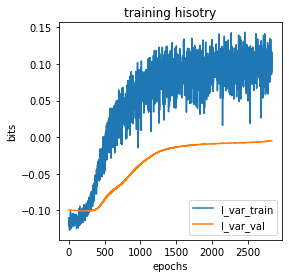

In [28]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
fig.savefig('pngs/Titeseq_MP/history.png',dpi=200,bbox_inches='tight')

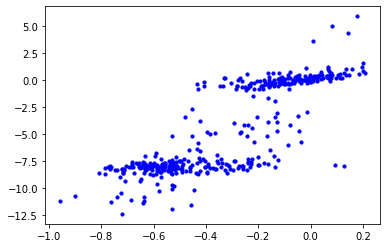

In [29]:
plt.scatter(theta_lc_init.ravel(),gpmap.weights[1].numpy().ravel(),c='blue',s=10)

In [30]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

# theta_0 = np.squeeze(gpmap.weights[1].numpy())[0]
# theta_0_df = pd.DataFrame(theta_0,columns=model.alphabet)

# theta_1 = np.squeeze(gpmap.weights[1].numpy())[1]
# theta_1_df = pd.DataFrame(theta_1,columns=model.alphabet)

In [31]:
phi = gpmap.x_to_phi(x_test)

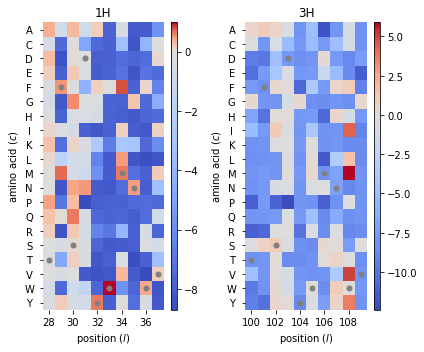

In [32]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/GP_map.png',dpi=200,bbox_inches='tight',facecolor='white')

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_18490/1791248001.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


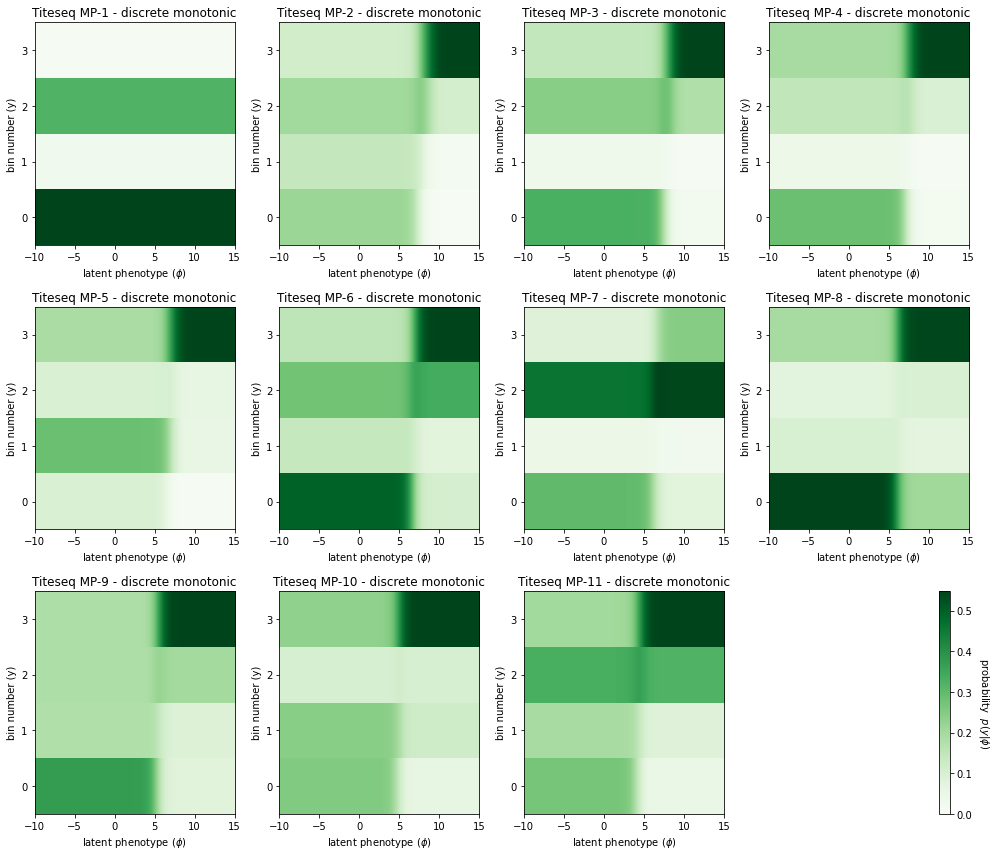

In [33]:
# Create grid in phi space
phi_lim = [-10, 15]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = TiteSeq_mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = TiteSeq_mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/Titeseq_MP/MPs.png',dpi=200,bbox_inches='tight')


In [34]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)

In [35]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [36]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [37]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

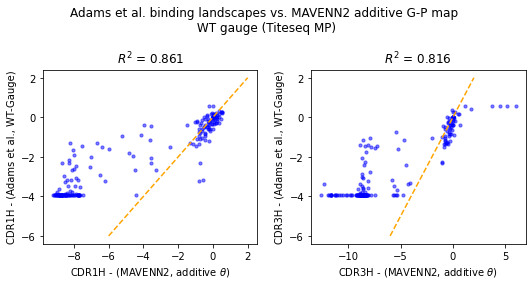

In [38]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

lims = [-6,2]
ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[0:9].values.ravel(),-CDR1H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR1H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[10:20].values.ravel(),-CDR3H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR3H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge (Titeseq MP) ')
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_vs_mavenn_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [39]:
# np.save('models/theta_0_TS.npy',model.model.get_weights()[0])
# np.save('models/theta_lc_TS.npy',model.model.get_weights()[1])
# np.save('models/theta_lc_consensus_TS_df.npy', theta_lc_consensus_df.values)

In [40]:
#theta_lc_TS = np.load('models/theta_lc_consensus_TS_df.npy')
theta_lc_DM = np.load('models/theta_lc_consensus_DM_df.npy')



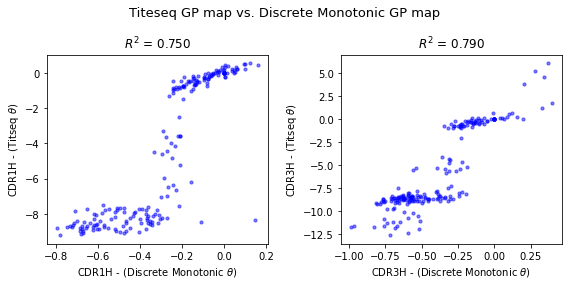

In [41]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]

Rsq = np.corrcoef(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR1H - (Titseq $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR3H - (Titseq $\\theta$)')

fig.suptitle('Titeseq GP map vs. Discrete Monotonic GP map',fontsize=13)
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Titeseq_vs_Discrete_mono_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


### Compute K_D values

In [42]:
#phi = gpmap.x_to_phi(x_test)

a = TiteSeq_mp_list[0].get_weights()[0][0]

def mu_of_phi(c, 
              a=a,
              phi=phi,
              mu_neg=mu_neg):

    K_a_of_phi = 10**(phi)
    B = 10**(mu_neg)
    A = 10**(a)
    
    mu_of_phi = np.log10(A*(c*K_a_of_phi)/(1+c*K_a_of_phi)+B)
    
    return mu_of_phi
    
def Ka_of_c(c, 
            a=a,
            phi=phi,
            mu_neg=mu_neg):

    K_a_of_phi = 10**(phi)
    B = 10**(mu_neg)
    A = 10**(a)
    
    mu_of_phi = np.log10(A*(c*K_a_of_phi)/(1+c*K_a_of_phi)+B)
    #return B-10**
    
    return mu_of_phi


In [43]:
model.x_stats['consensus_seq']

'TFSDYWMNWVGSYYGMDYWG'

In [44]:
def _x_to_mat(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] == alphabet[np.newaxis, :]).astype(float)

In [45]:
model.x_stats['consensus_seq']

'TFSDYWMNWVGSYYGMDYWG'

In [46]:
WT_seq = model.x_stats['consensus_seq']

single_mutants = []

for idx,WT_char in enumerate(WT_seq):
    #print(idx)
    for mutant in model.alphabet:
#         if mutant==WT_seq[idx]:
#             continue
#         else:
        temp_WT_list = list(WT_seq)
        temp_WT_list[idx] = mutant
        single_mutant = ''.join(temp_WT_list)
        single_mutants.append(single_mutant)
            

In [47]:
phi_single_mutants = gpmap.x_to_phi(single_mutants)

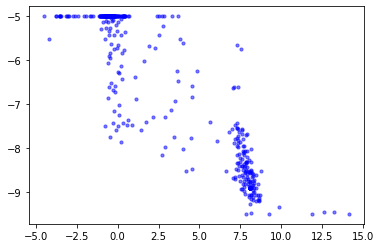

In [48]:
lims = []
plt.scatter(phi_single_mutants,
            pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df]).values.ravel(),
            color='blue',s=10,alpha=0.5)

In [49]:
phi_WT = gpmap.x_to_phi(WT_seq)

Text(0, 0.5, '$\\mu(\\phi)$')

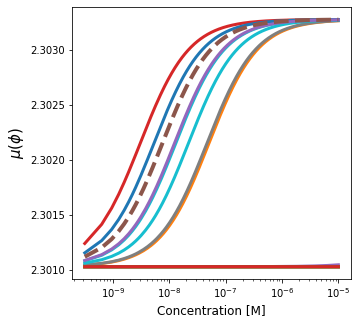

In [50]:
plt.figure(figsize=(5,5))

cs_ = np.arange(10**-9.5,10**-5,10**(-9.5))

for _ in np.random.choice(np.arange(0,len(phi)),size=25):
    
    plt.plot(cs_,mu_of_phi(c=cs_,phi=phi[_]),lw=3)
    #plt.plot(cs_,mu_of_phi(c=cs_,phi=phi[_]),'--',lw=3)

plt.plot(cs_,mu_of_phi(c=cs_,phi=phi_WT),'--',lw=4,zorder=10)    
    
plt.xlabel('Concentration [M]',fontsize=12)
plt.xscale('log')
#plt.yscale('log')
plt.ylabel('$\mu(\phi)$',fontsize=15)
#plt.ylim(0,4)